In [1]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

In [2]:
class AutoEncoder(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.input_shape = kwargs["input_shape"]
        # number of hidden units in first hidden layer
        self.n_units = kwargs["n_units"]
        self.half_units = kwargs["n_units"] // 2
        
        self.encoder = torch.nn.Sequential(
            # Linear(): Initiate a linear function theta*x + b
            nn.Linear(in_features=self.input_shape, out_features=self.n_units),
            torch.nn.ReLU(),
            nn.Linear(in_features=self.n_units, out_features=self.half_units),
            # torch.nn.ReLU(),
            # nn.Linear(in_features=64, out_features=32),
        )
        self.decoder = torch.nn.Sequential(
            # nn.Linear(in_features=32, out_features=64),
            # torch.nn.ReLU(),
            nn.Linear(in_features=self.half_units, out_features=self.n_units),
            torch.nn.ReLU(),
            nn.Linear(in_features=self.n_units, out_features=self.input_shape),
            torch.nn.Sigmoid()
        )
    
    # x denotes features
    def forward(self, X):
        encode = self.encoder(X)
        decode = self.decoder(encode)
        return decode

In [5]:
data = np.ndarray(shape=(10000,30,30))

for i in range(10000):
    path = f'data/jet_matrices/sample{i+1}.dat'
    sample = np.loadtxt(path, unpack = True)
    data[i] = sample

In [59]:
X = torch.from_numpy(data)
# Converts all scalars to floats. May affect training behavior (ie. reconstructions made of non-binary scalar values)
X = X.float()

In [63]:
pca = PCA().fit(X[0].numpy())

% matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 11, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 11, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

UsageError: Line magic function `%` not found.


In [52]:
# PCA

n_components = 20

X_pca = np.ndarray(shape=(10000,30,n_components))
pca = PCA(n_components=n_components)
for i in range(len(X)):
    x = pca.fit_transform(X[i].numpy())
    X_pca[i] = x
X = torch.from_numpy(X_pca)
X = X.float()

In [53]:
batch_size = 32
# 30x30 = 900
input_shape = X.shape[1] * X.shape[2]
lr = 1e-3

In [54]:
train_size = int(0.8 * len(X))
test_size = len(X) - train_size
train, test = torch.utils.data.random_split(X, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(
    train, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=False
)

test_loader = torch.utils.data.DataLoader(
    test, batch_size=batch_size, shuffle=False, num_workers=0
)

In [55]:
# Use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Define model
model = AutoEncoder(input_shape=input_shape, n_units=32).to(device)

# Define Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)

# Mean-squared error loss
criterion = nn.MSELoss()

cuda


In [ ]:
# # USE FOR MNIST ONLY
# input_shape = 784
# # Convert numpy array to tensor
# transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

# # Define 
# train = torchvision.datasets.MNIST(
#     root="~/torch_datasets", train=True, transform=transform, download=True
# )

# test = torchvision.datasets.MNIST(
#     root="~/torch_datasets", train=False, transform=transform, download=True
# )

# train_loader = torch.utils.data.DataLoader(
#     train, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True
# )

# test_loader = torch.utils.data.DataLoader(
#     test, batch_size=batch_size, shuffle=False, num_workers=4
# )

In [ ]:
def CustomCrossEntropy(outputs, targets):
    pass

In [ ]:
# # Example of target with class indices
# loss = nn.CrossEntropyLoss()
# input = torch.tensor([[0.0,0.0],[1.0,1.0],[0.0,0.0]], requires_grad=True)
# print(input)
# target = torch.tensor([0,1,0], dtype=torch.long)
# print(target)
# output = loss(input, target)
# print(output)
# output.backward()

In [56]:
# Training

# Reset model state if previously trained
torch.manual_seed(1)
def weights_init(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight.data)
        print("existing instance")

model.apply(weights_init)

print("Training...")

epochs=5
for epoch in range(epochs):
    loss = 0
    for i, batch in enumerate(train_loader, 0):
        
        # reshape mini-batch data from [batch_size, 30, 30] to [batch_size, 900]
        # load it to the active device
        batch = batch.view(-1, input_shape).to(device)
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions
        outputs = model(batch)
        
        # compute training reconstruction loss
        train_loss = criterion(outputs, batch)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
    
    # compute the epoch training loss
    loss = loss / len(train_loader)
    
    # display the epoch training loss
    print("Epoch : {}/{}, Training Loss = {:.6f}".format(epoch + 1, epochs, loss))

existing instance
existing instance
existing instance
existing instance
Training...
Epoch : 1/5, Training Loss = 0.086346
Epoch : 2/5, Training Loss = 0.051790
Epoch : 3/5, Training Loss = 0.050066
Epoch : 4/5, Training Loss = 0.049204
Epoch : 5/5, Training Loss = 0.048728


In [ ]:
# PATH = './cifar_net.pth'
# torch.save(net.state_dict(), PATH)

In [57]:
# Testing

# Decoupled into three lists due to issue with placing torch tensors into multidimensional lists
batches = []
recons = []
test_losses = []

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for batch in test_loader:
        #batch = batch[0]
        batch = batch.view(-1, input_shape).to(device)
        reconstructions = model(batch)
        # Reconstruction loss
        test_loss = criterion(reconstructions, batch)
        # Store samples, predictions, and loss for visualization purposes
        batches.append(batch)
        recons.append(reconstructions)
        test_losses.append(test_loss)
        print(test_loss.item())
        #print(reconstructions[0])

0.04644232615828514
0.04881754890084267
0.049167655408382416
0.04875993728637695
0.04712145775556564
0.04669664055109024
0.04751703515648842
0.049046751111745834
0.048389140516519547
0.04569641873240471
0.04830075055360794
0.04616587609052658
0.048375558108091354
0.047790832817554474
0.05041896179318428
0.046746186912059784
0.049952540546655655
0.04733097925782204
0.04821234568953514
0.04965318739414215
0.04947314038872719
0.05010038986802101
0.04766019433736801
0.04494224861264229
0.04713176190853119
0.048322875052690506
0.04792841151356697
0.04826590418815613
0.04963892698287964
0.04898519068956375
0.048659343272447586
0.050214532762765884
0.045863620936870575
0.04856899753212929
0.0484500452876091
0.04914848506450653
0.046507447957992554
0.04978843033313751
0.052388910204172134
0.04766807705163956
0.05068707466125488
0.04958678036928177
0.04788937419652939
0.046978626400232315
0.049380213022232056
0.047513943165540695
0.050637587904930115
0.05257458984851837
0.04838225618004799
0.04

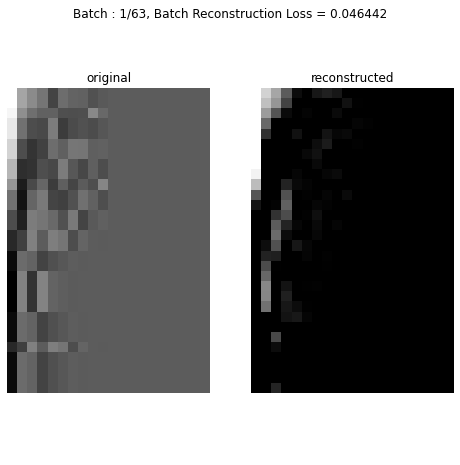

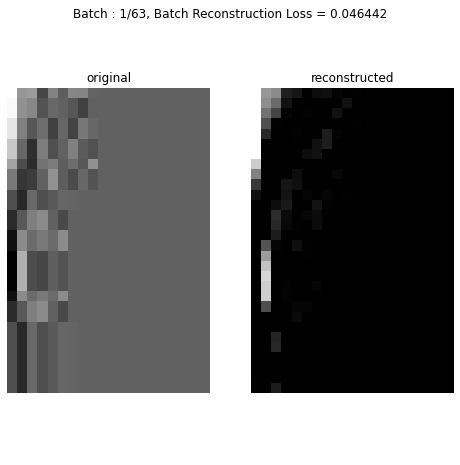

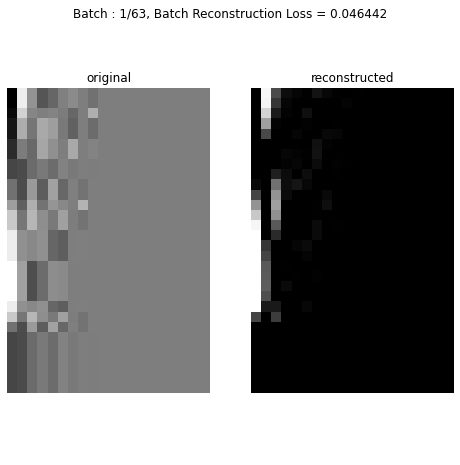

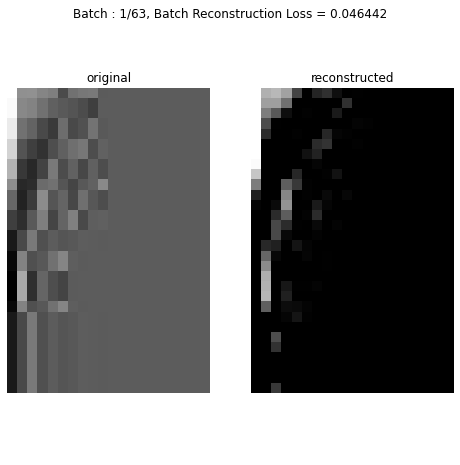

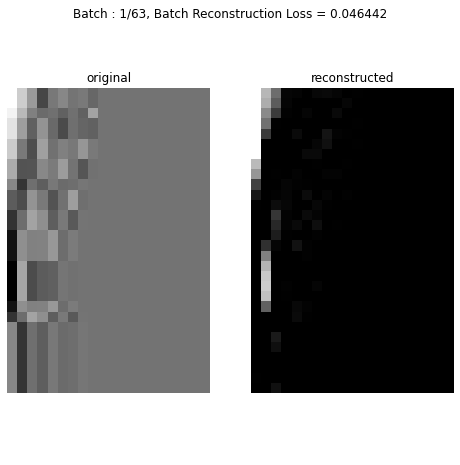

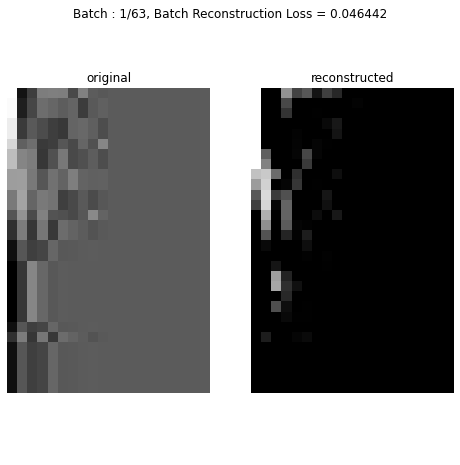

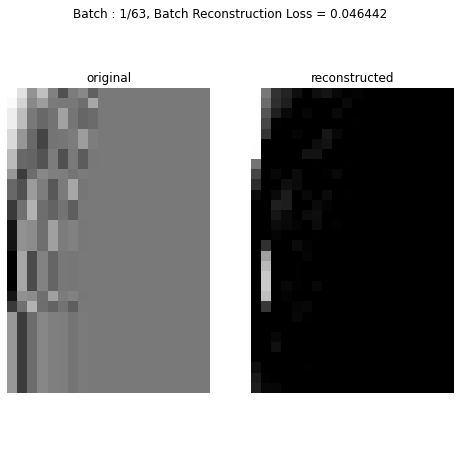

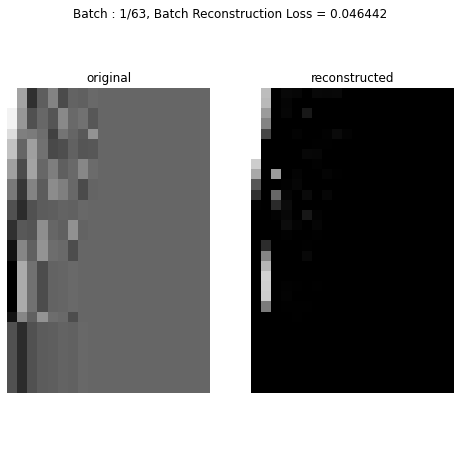

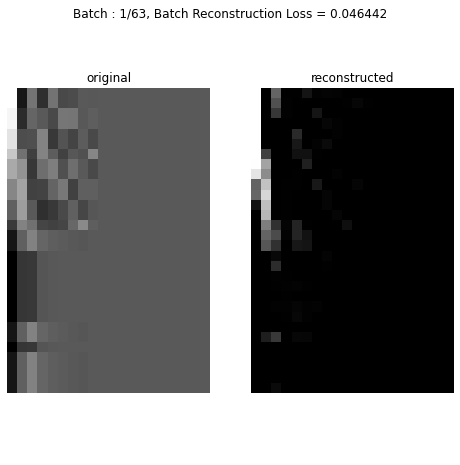

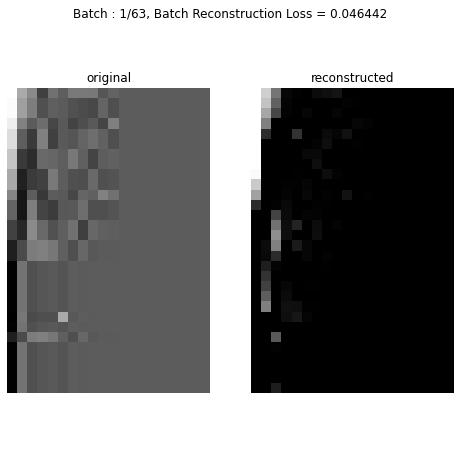

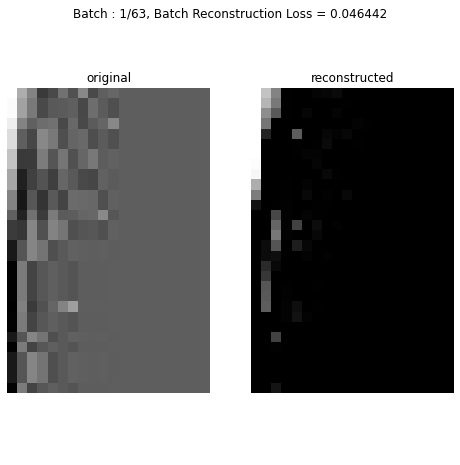

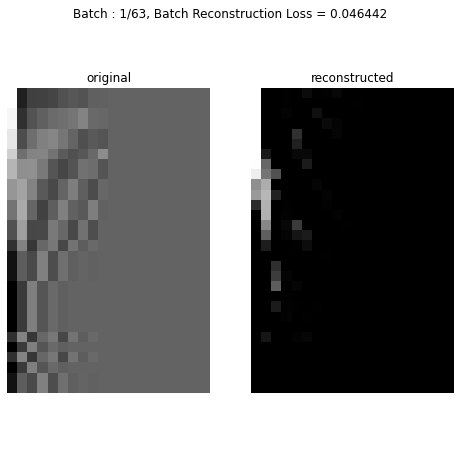

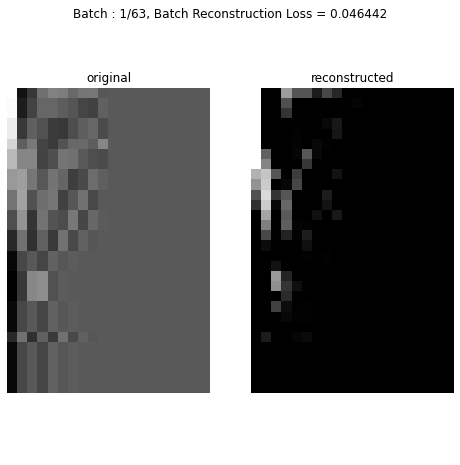

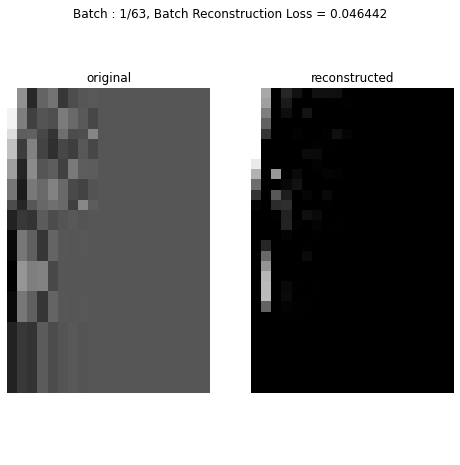

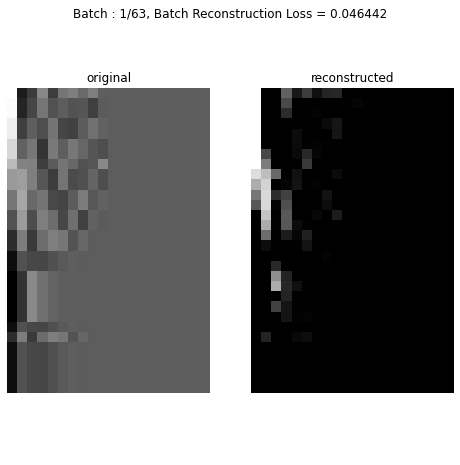

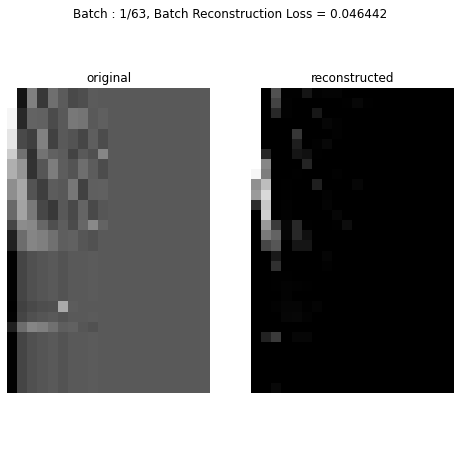

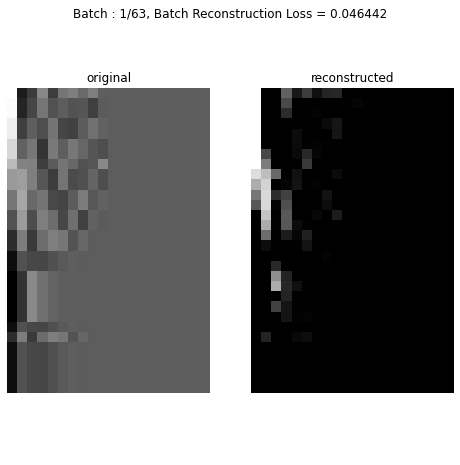

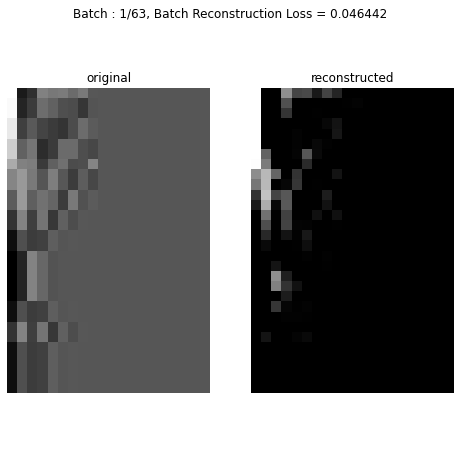

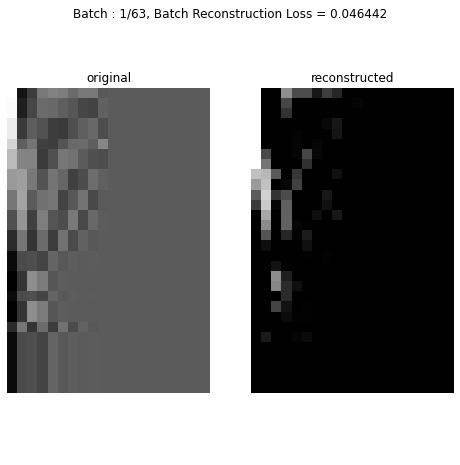

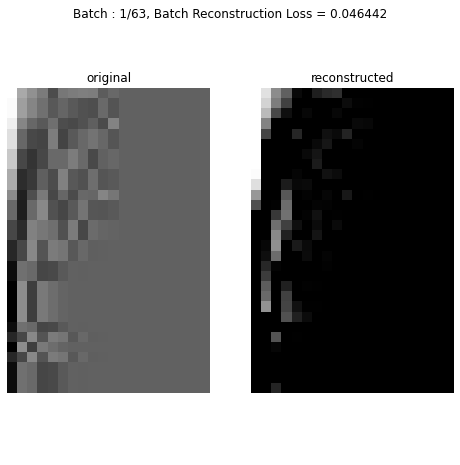

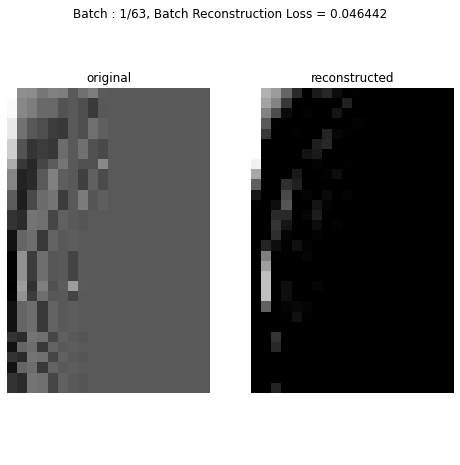

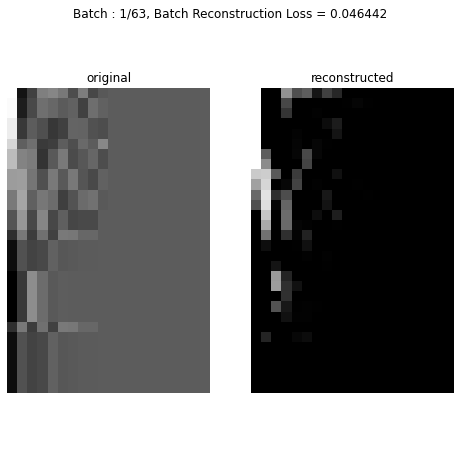

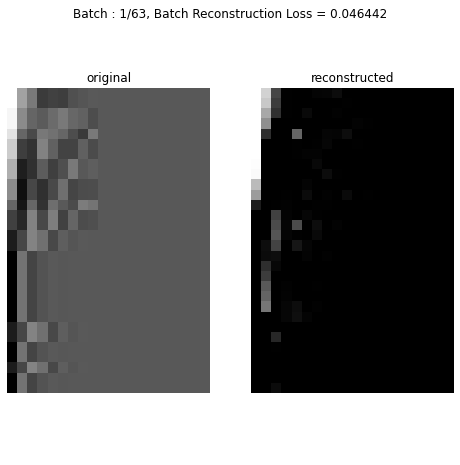

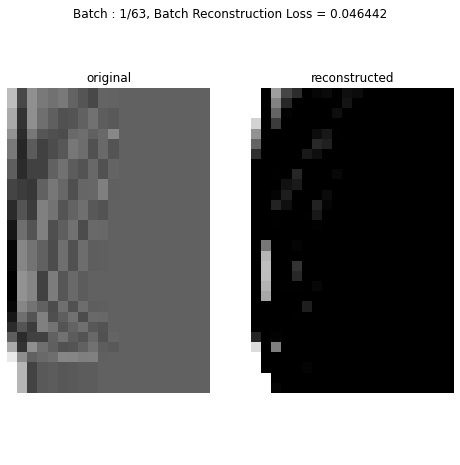

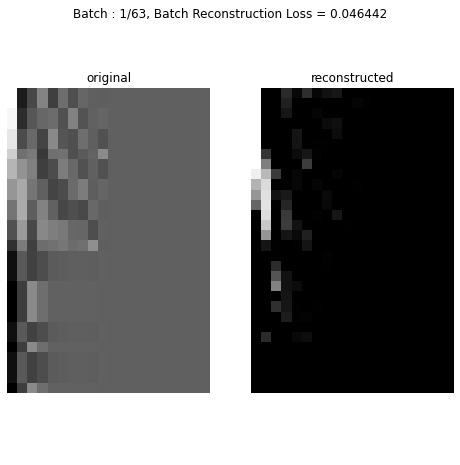

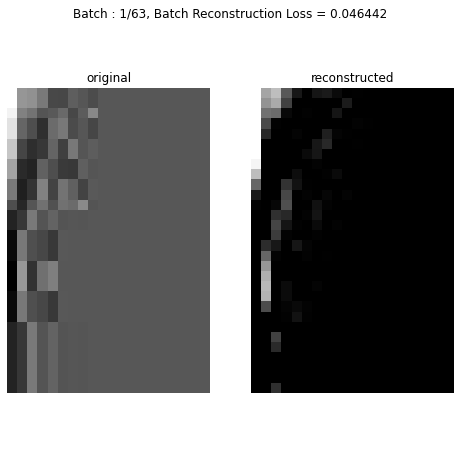

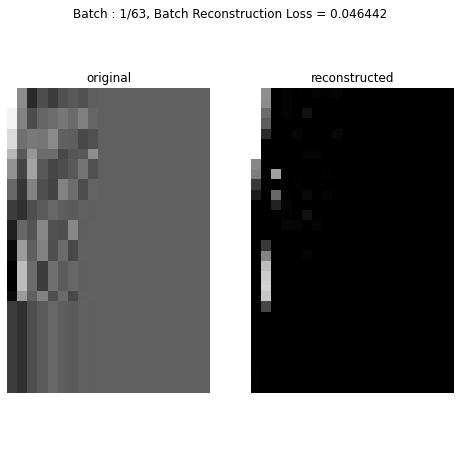

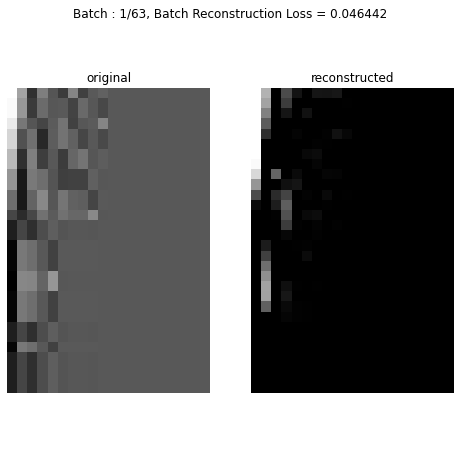

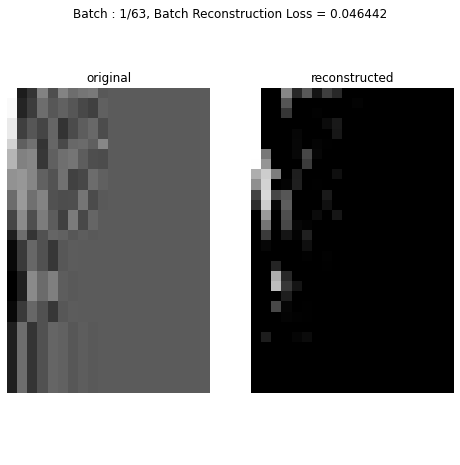

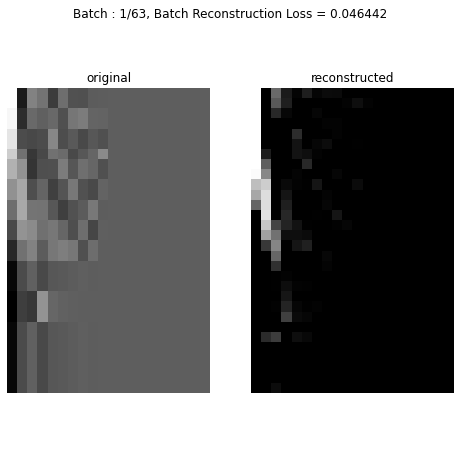

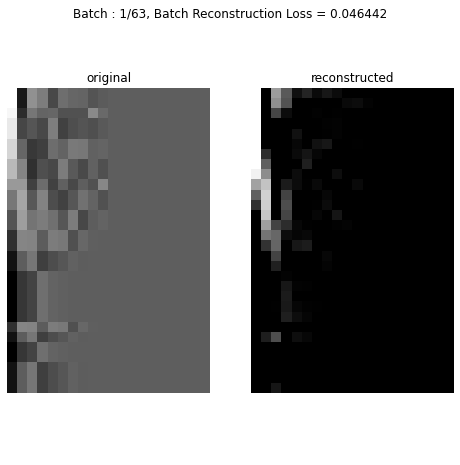

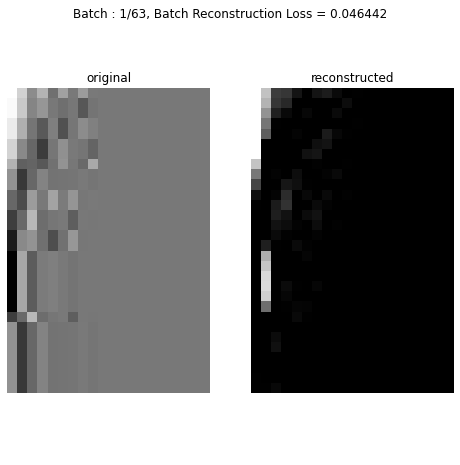

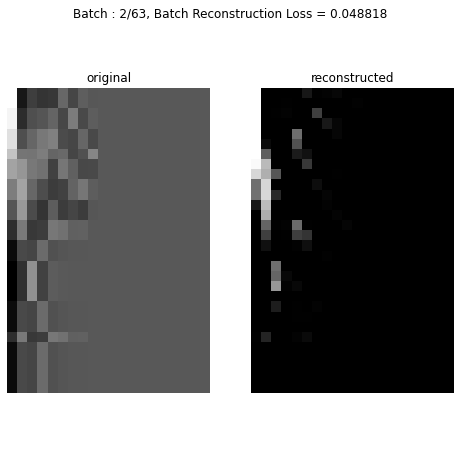

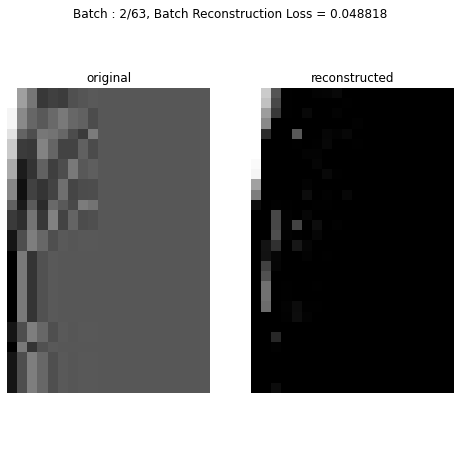

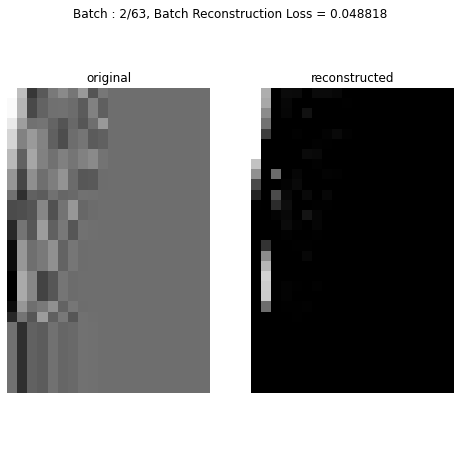

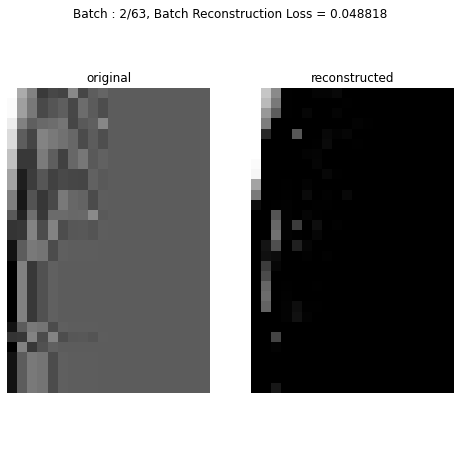

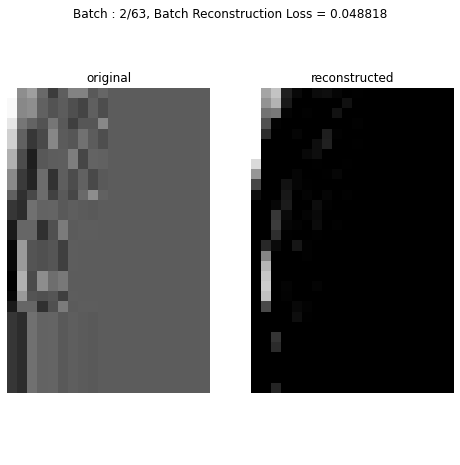

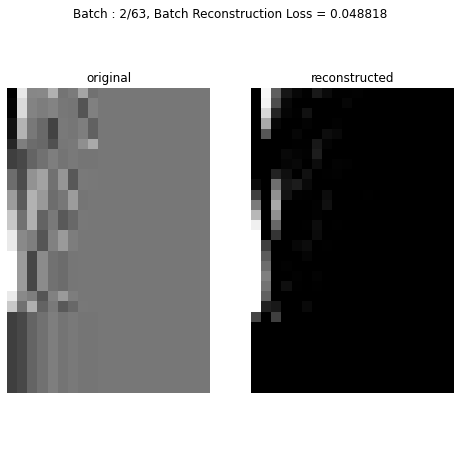

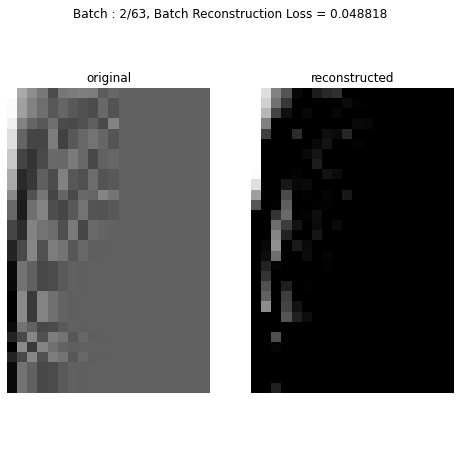

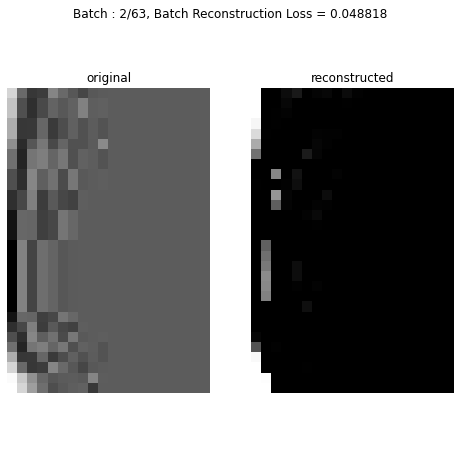

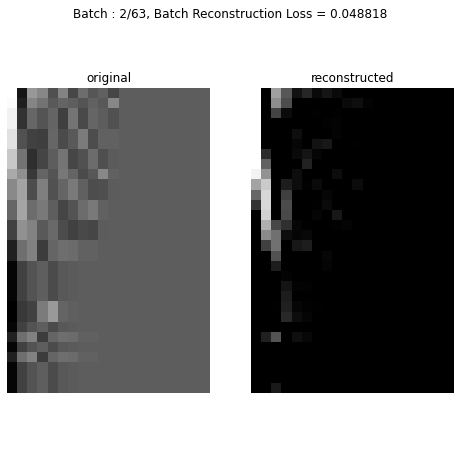

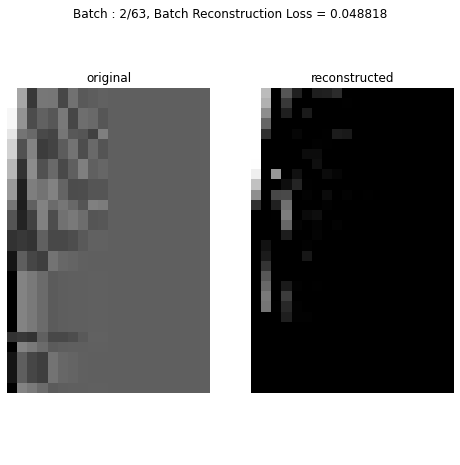

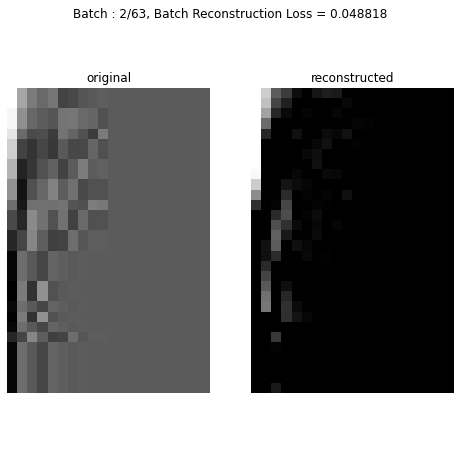

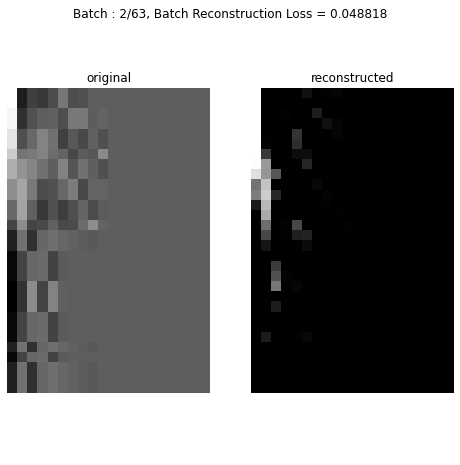

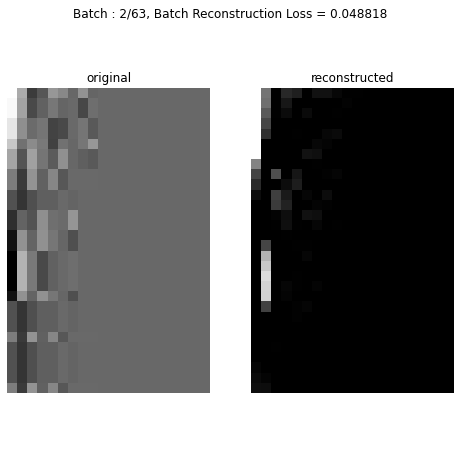

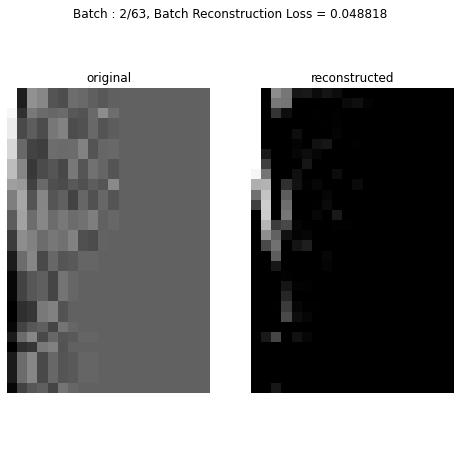

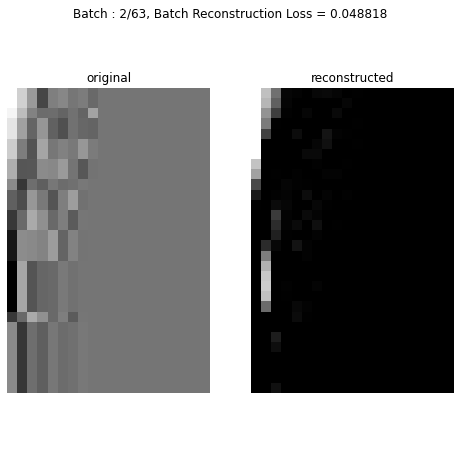

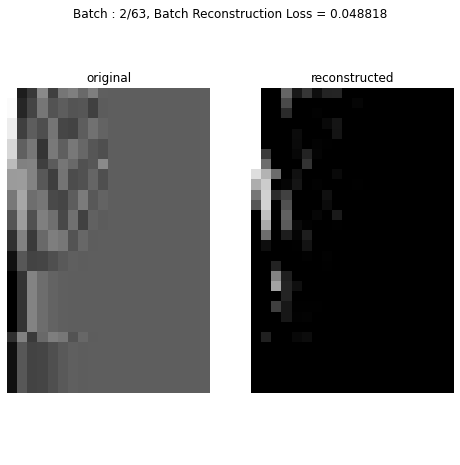

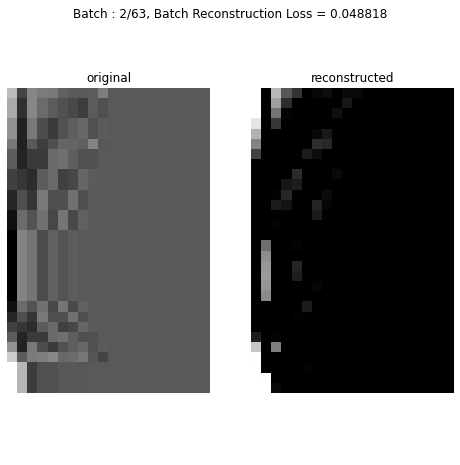

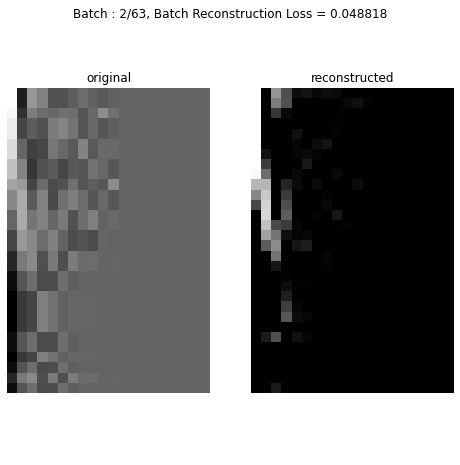

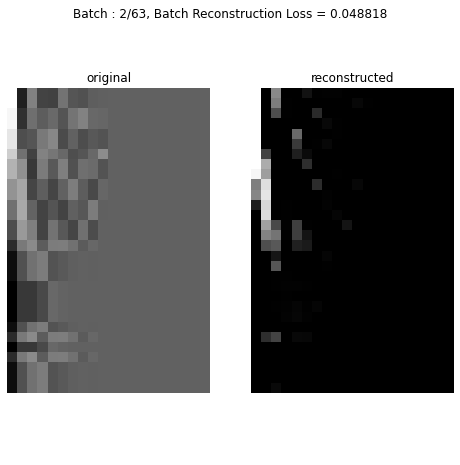

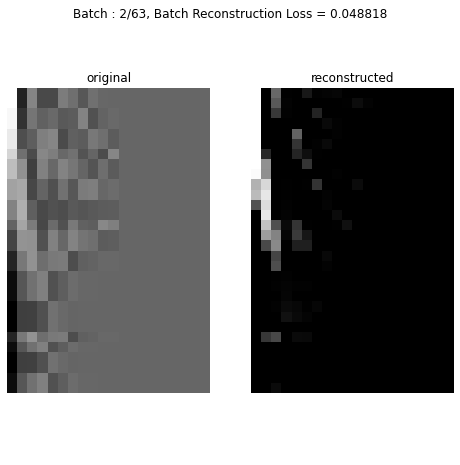

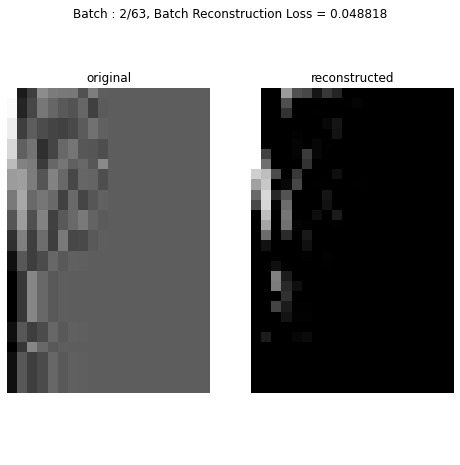

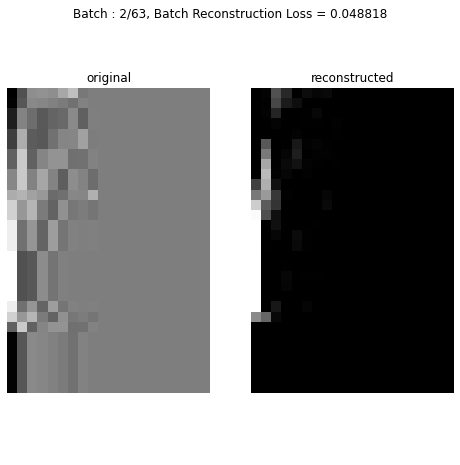

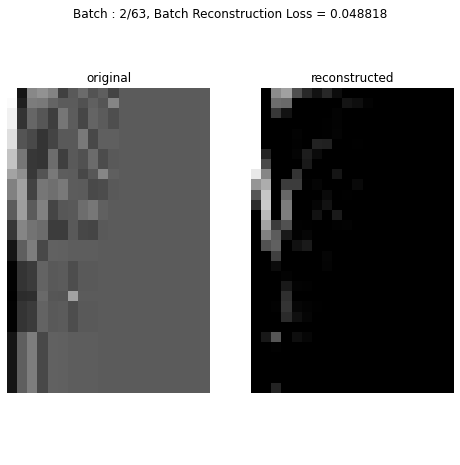

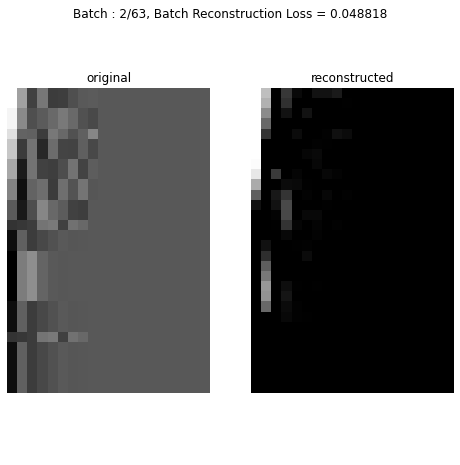

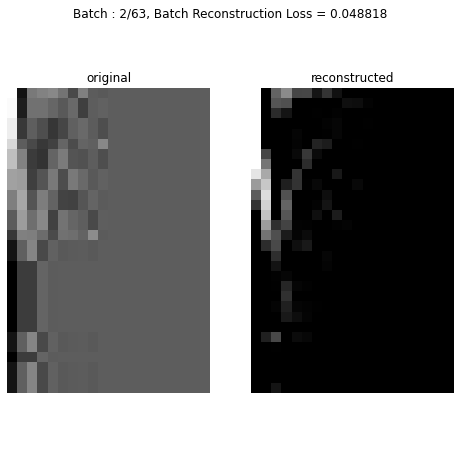

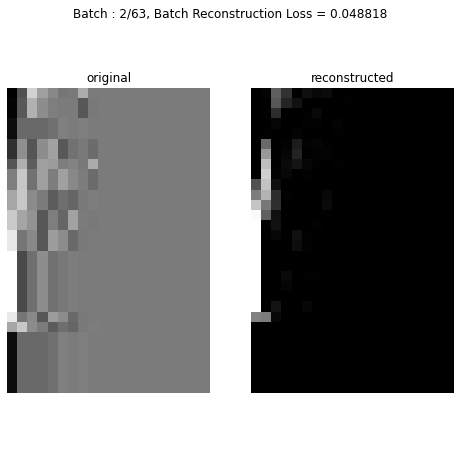

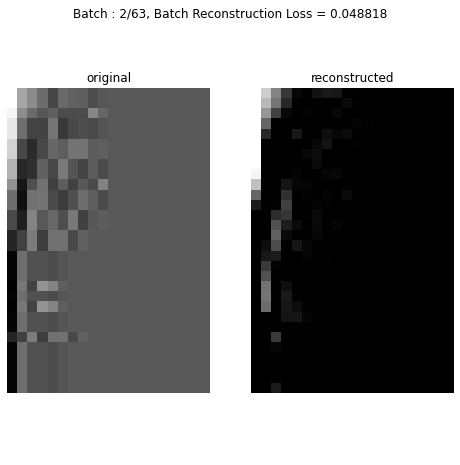

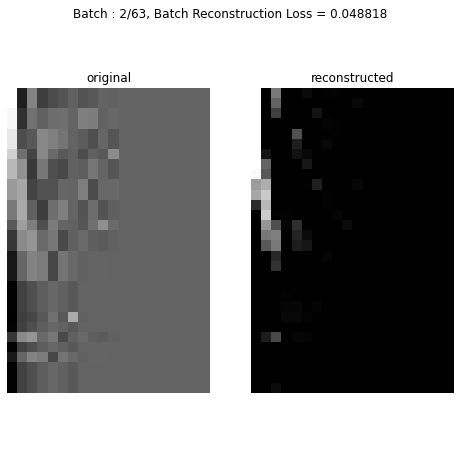

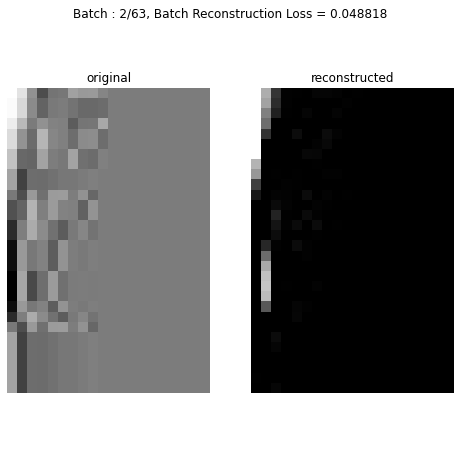

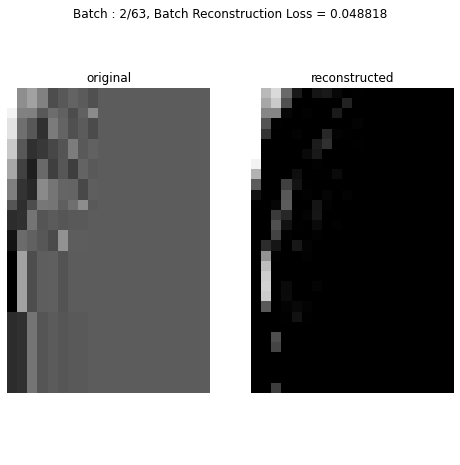

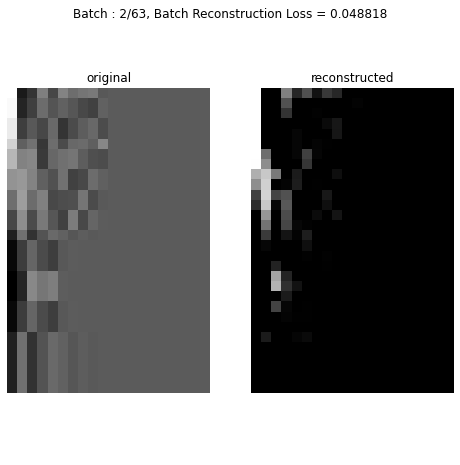

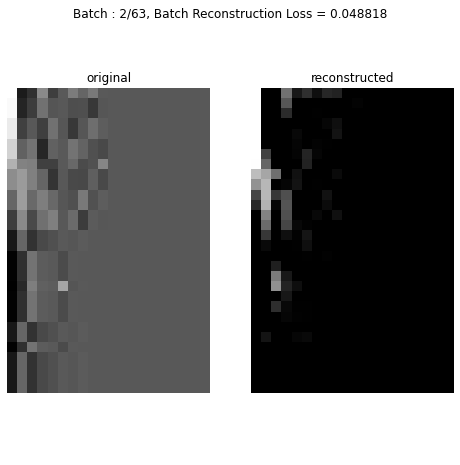

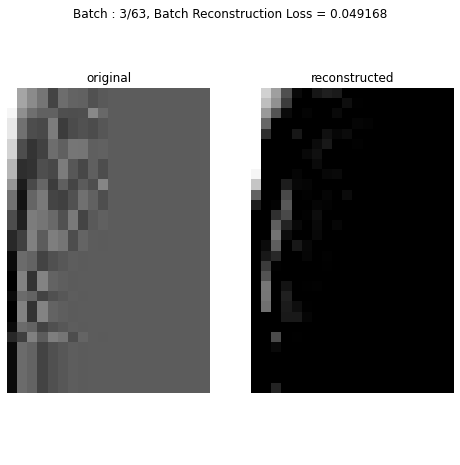

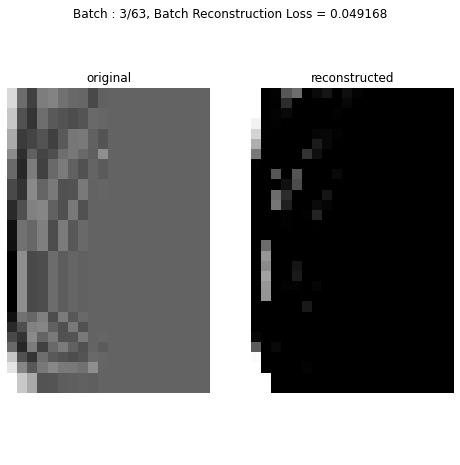

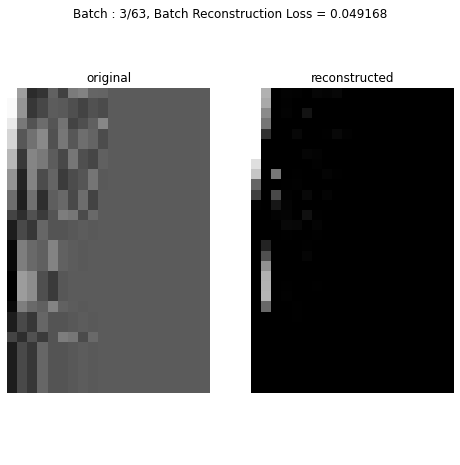

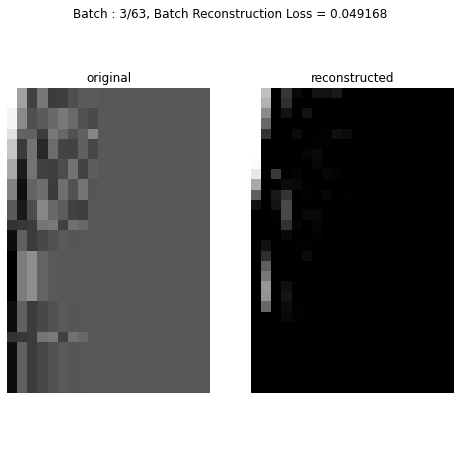

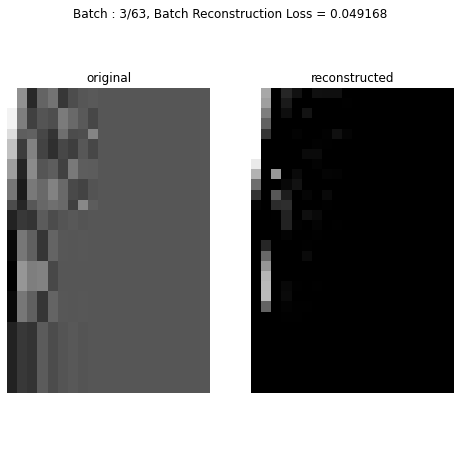

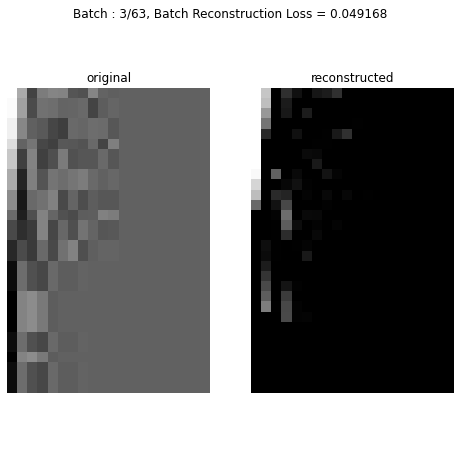

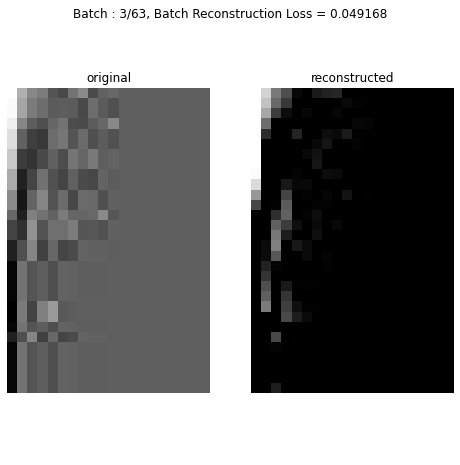

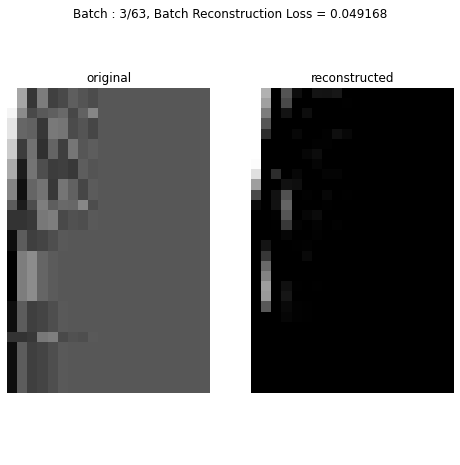

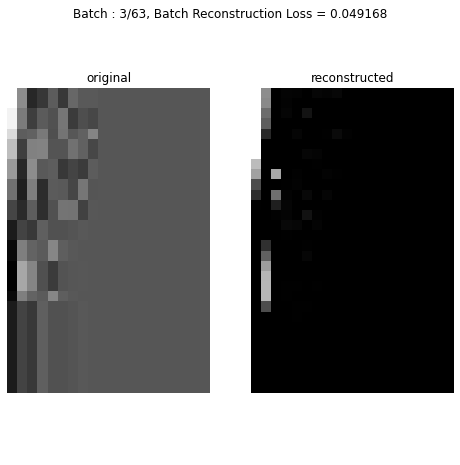

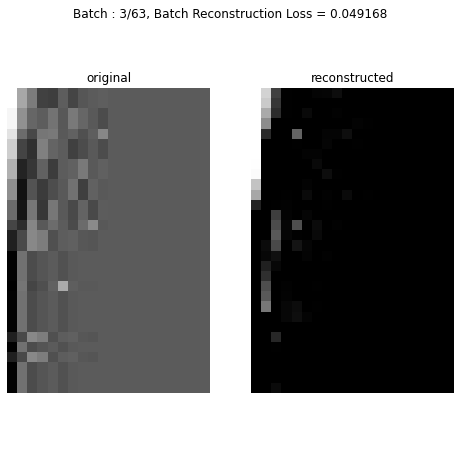

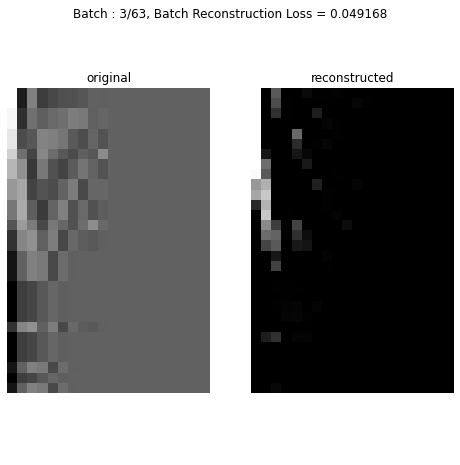

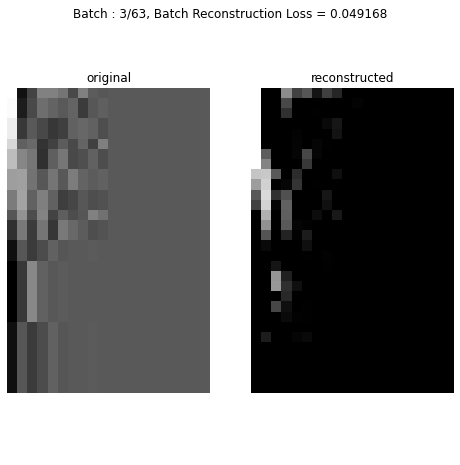

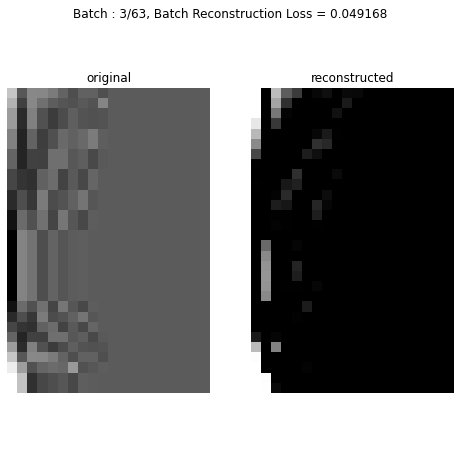

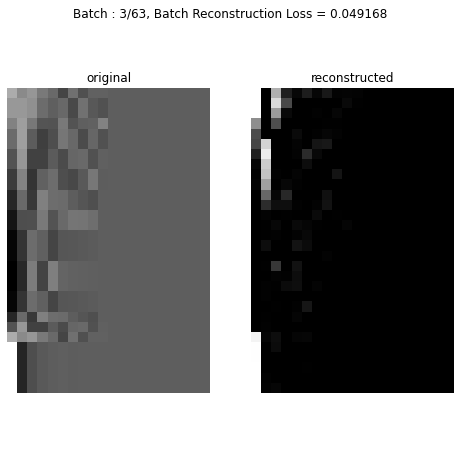

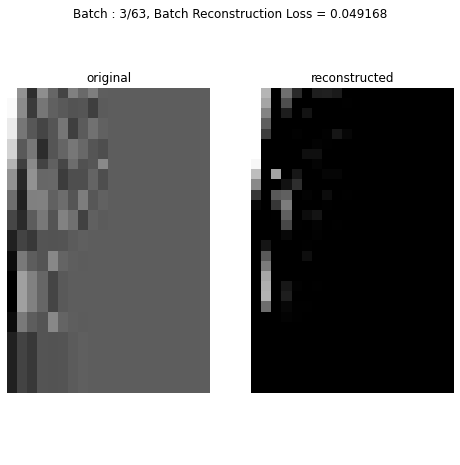

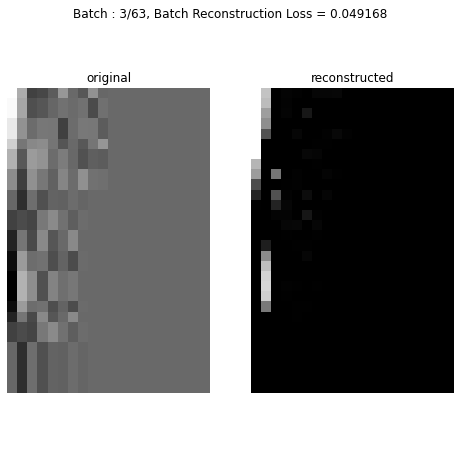

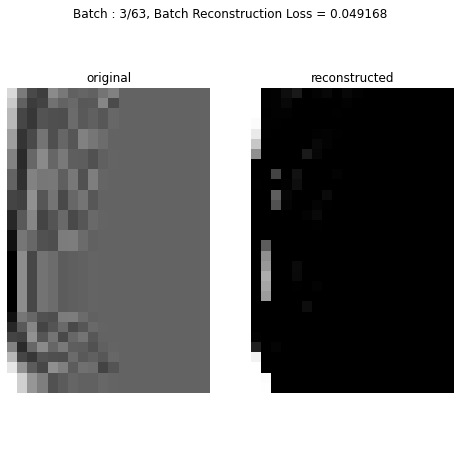

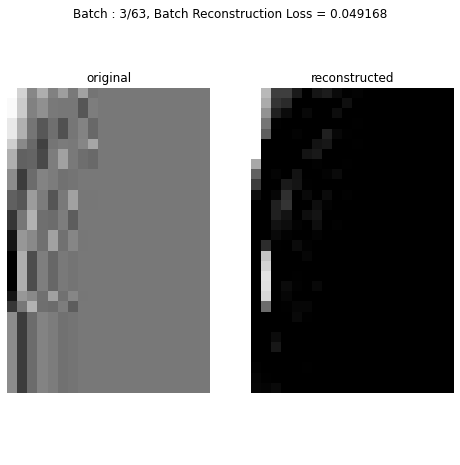

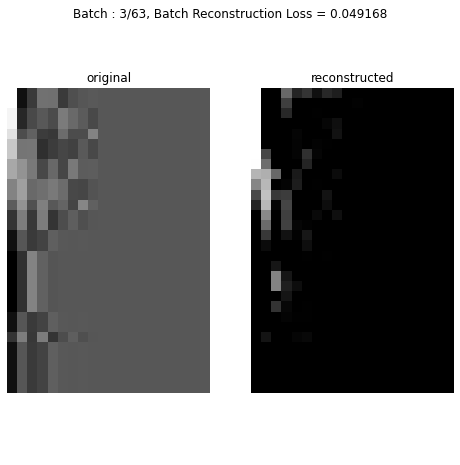

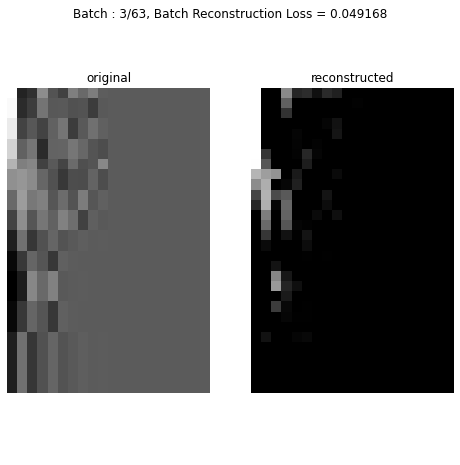

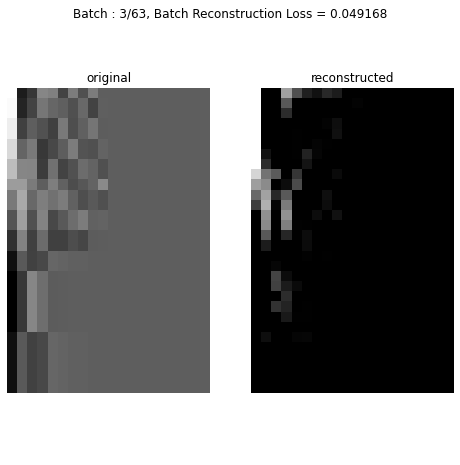

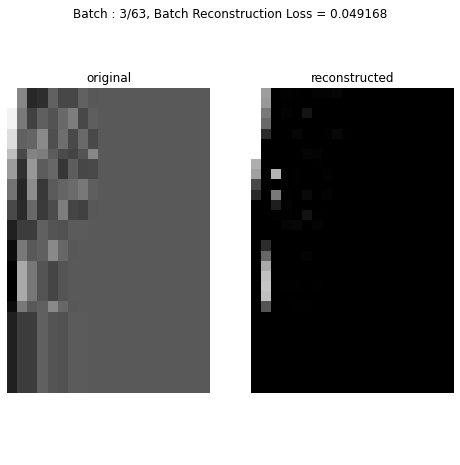

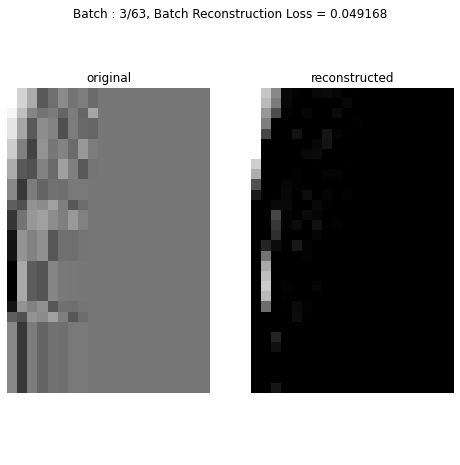

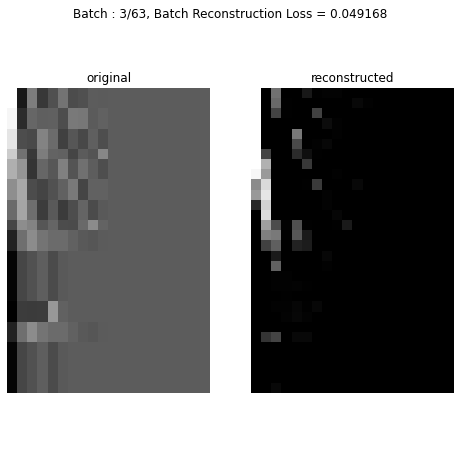

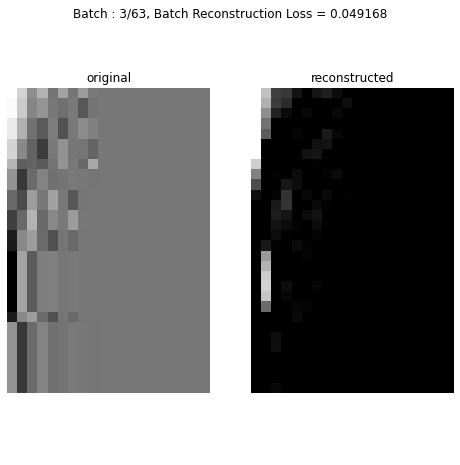

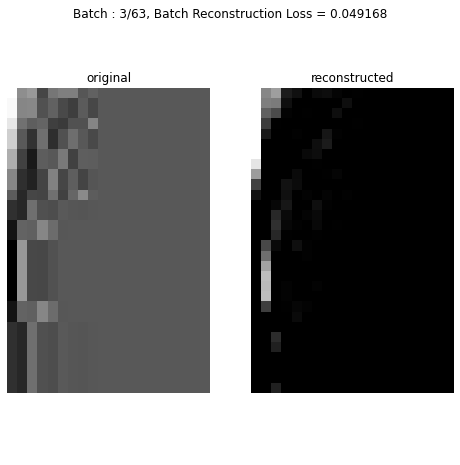

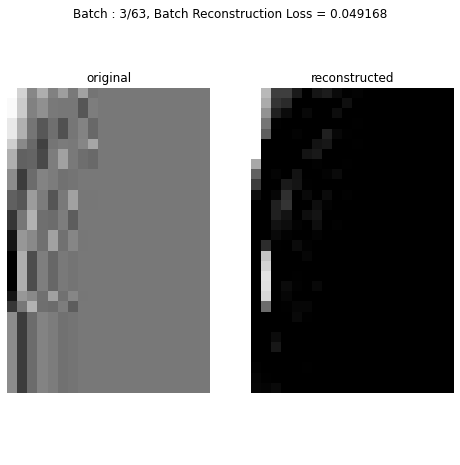

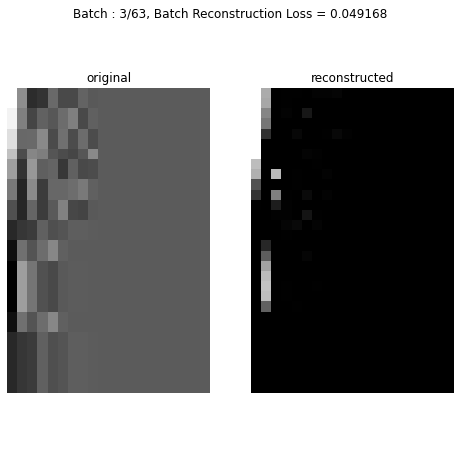

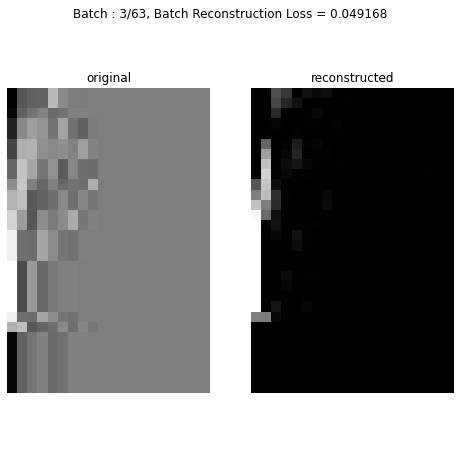

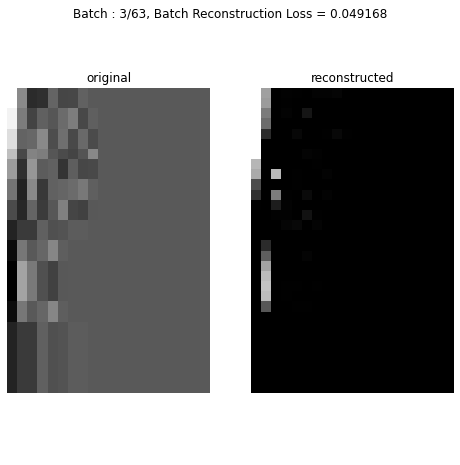

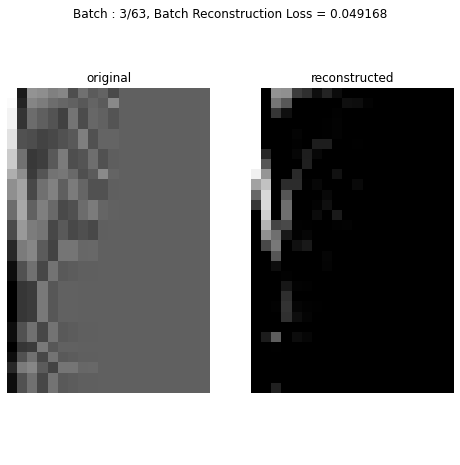

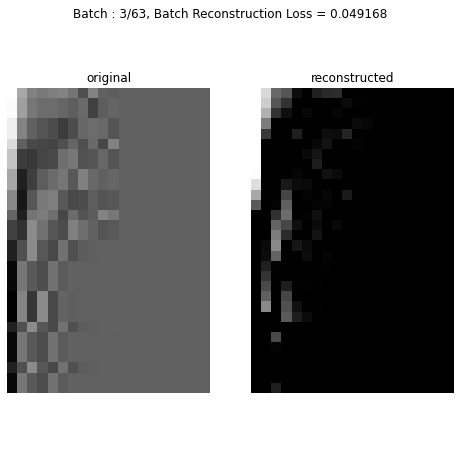

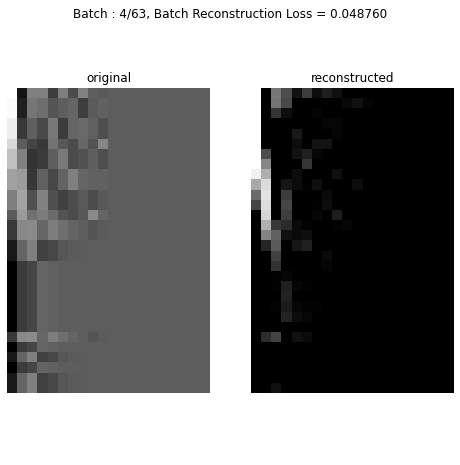

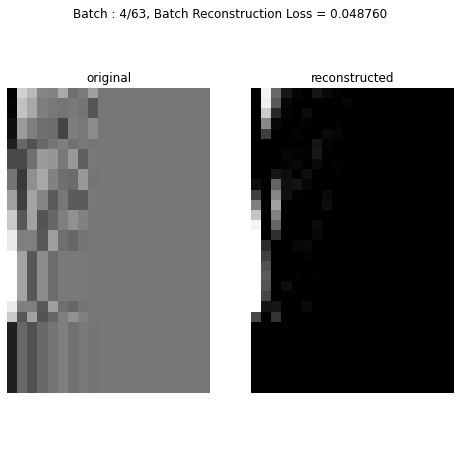

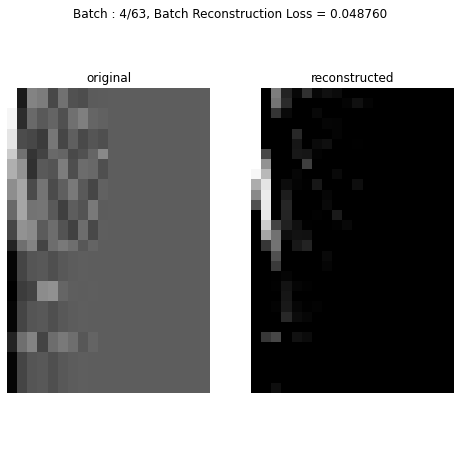

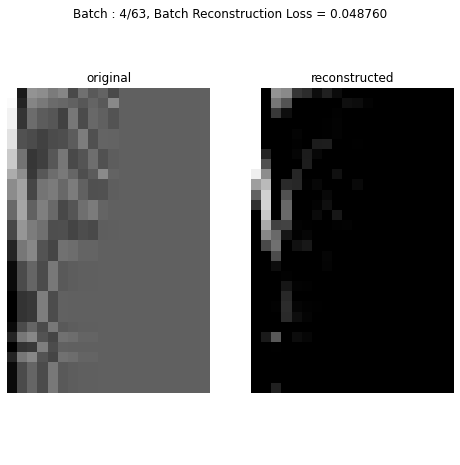

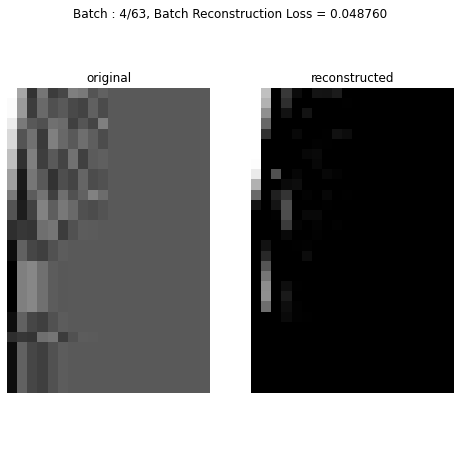

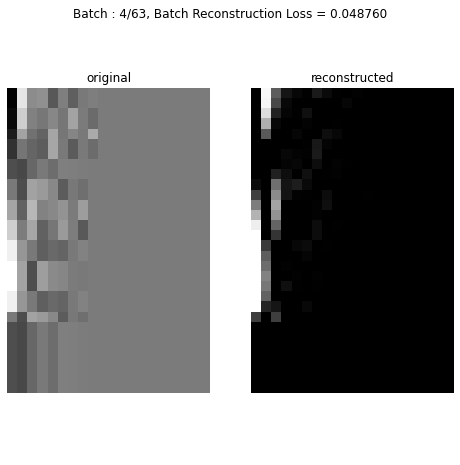

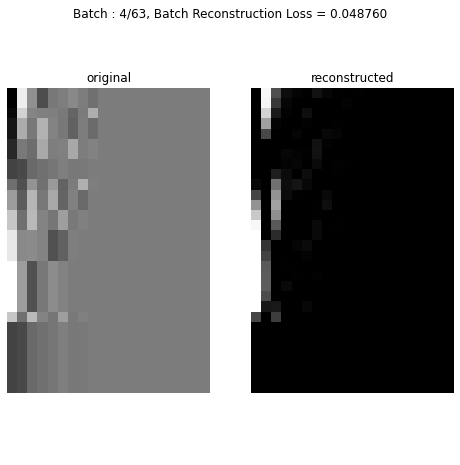

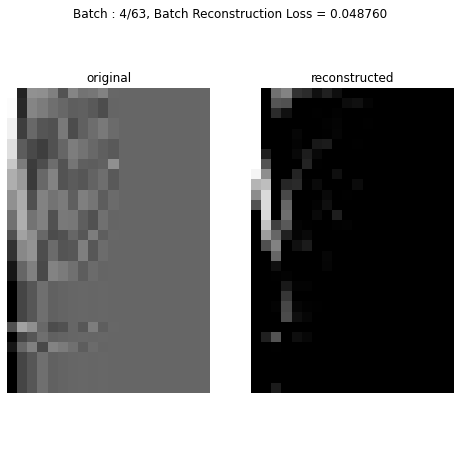

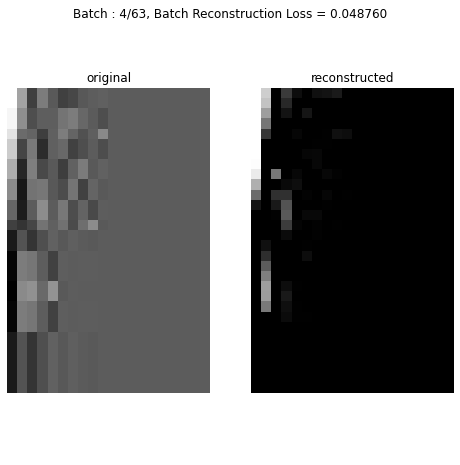

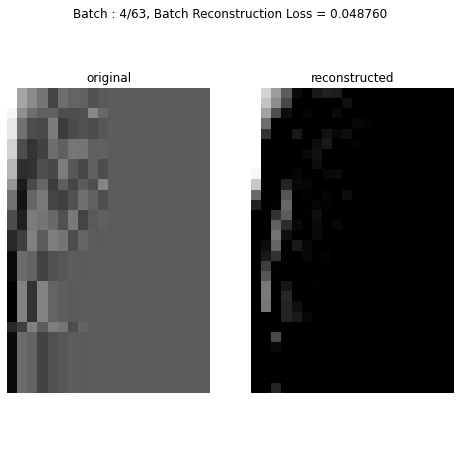

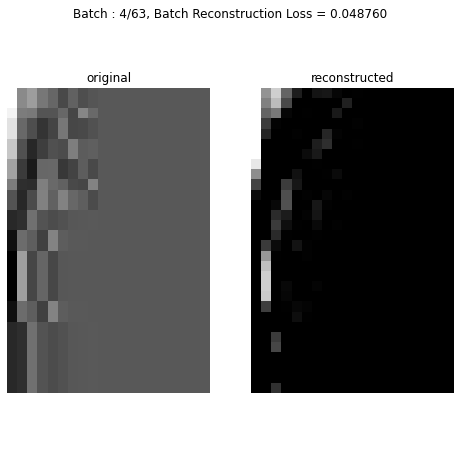

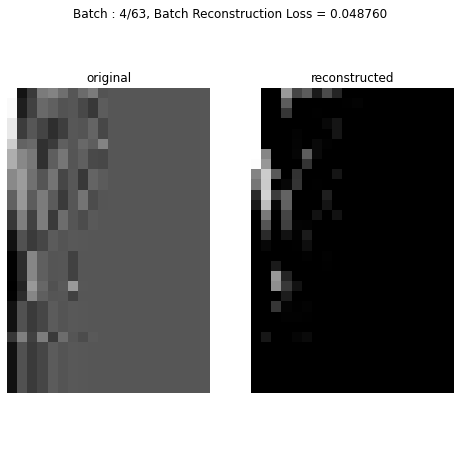

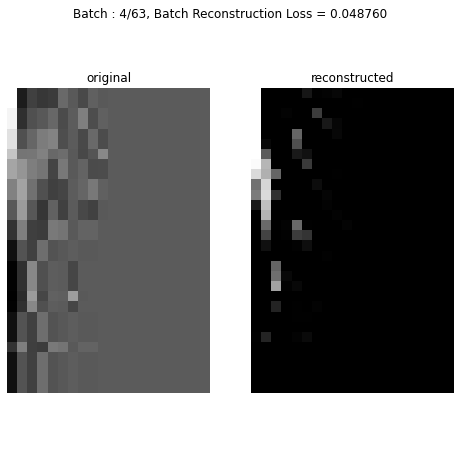

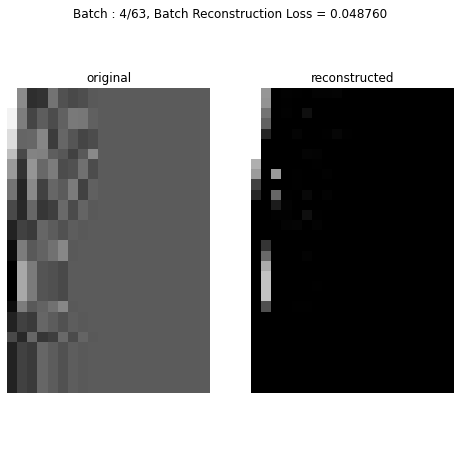

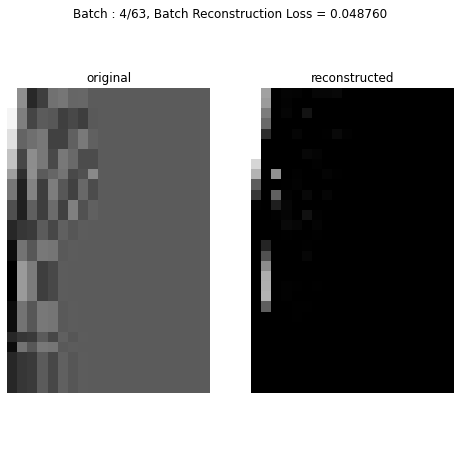

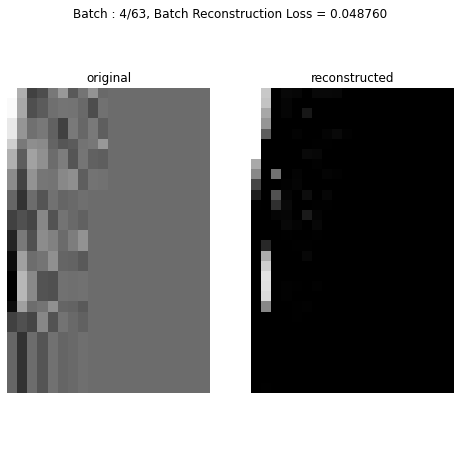

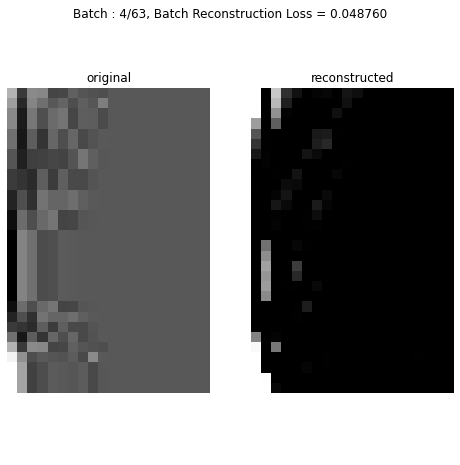

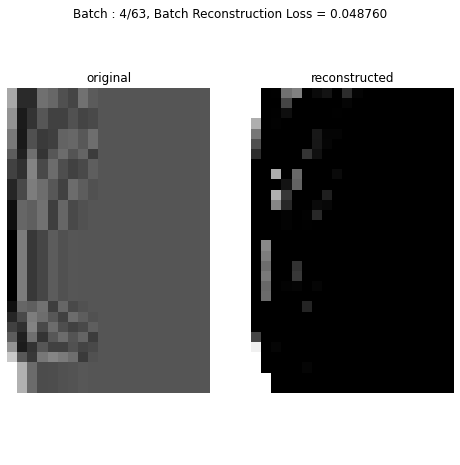

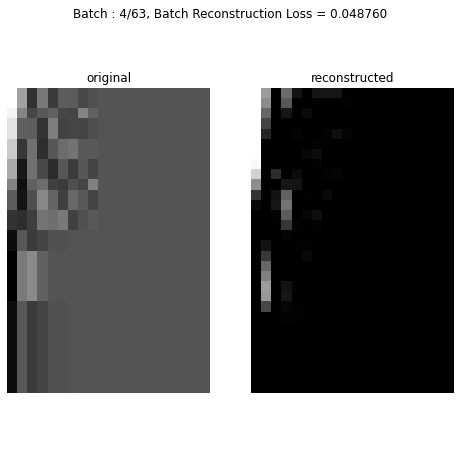

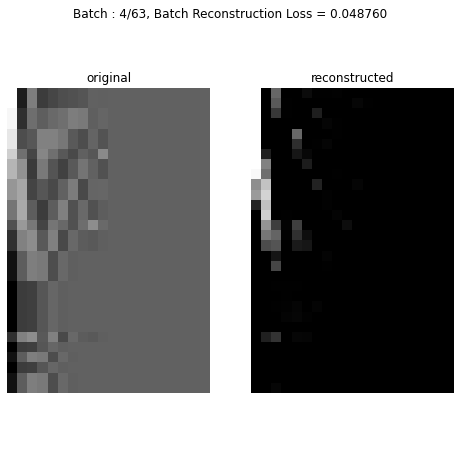

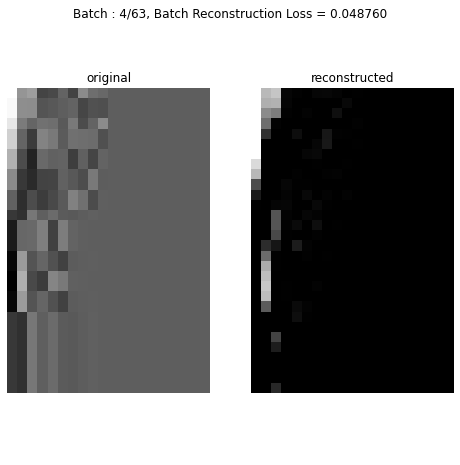

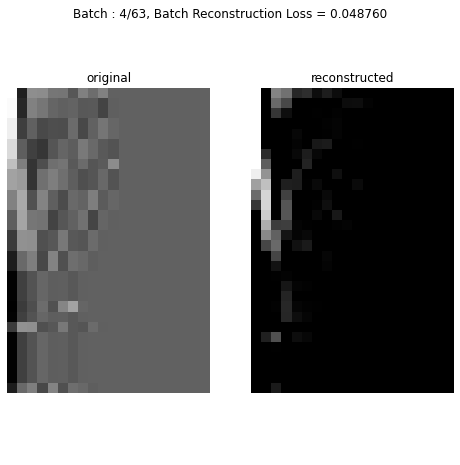

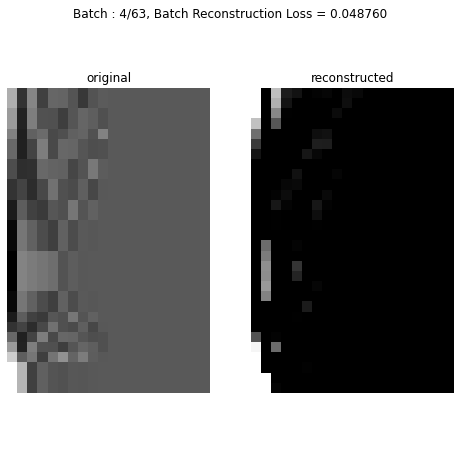

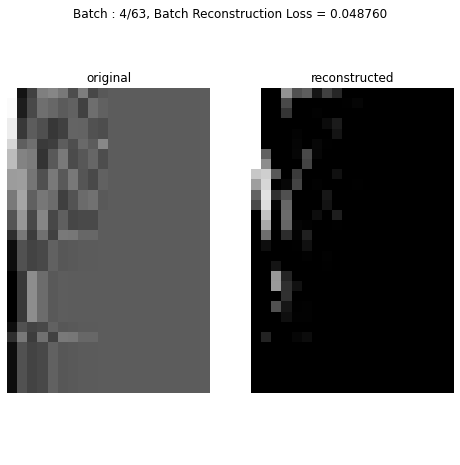

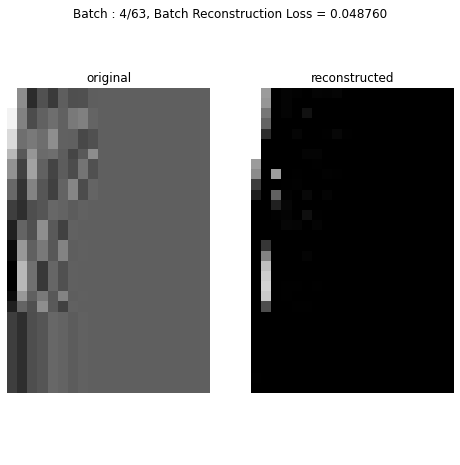

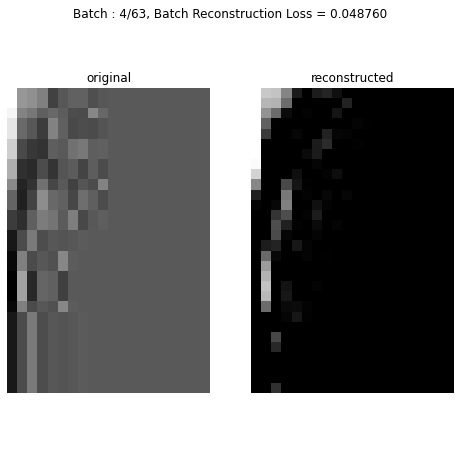

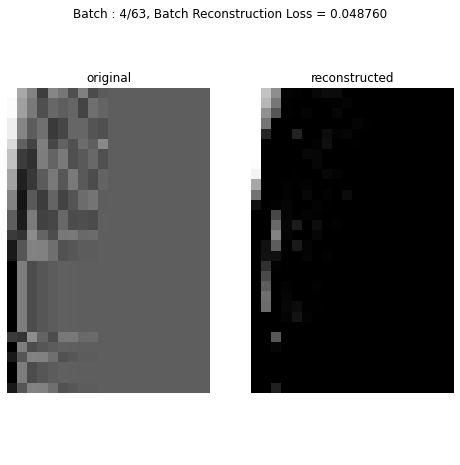

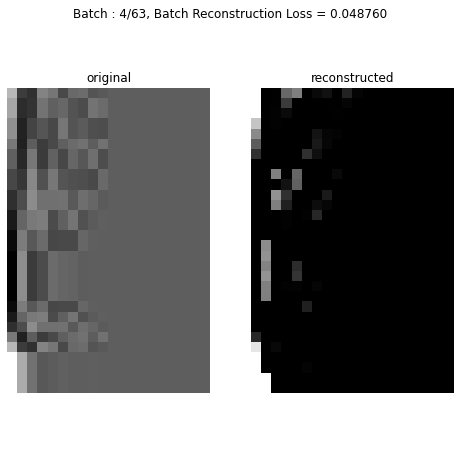

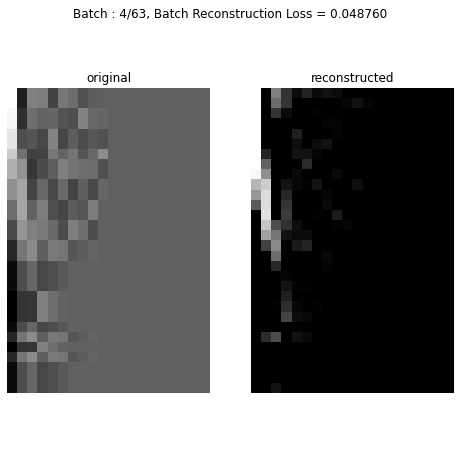

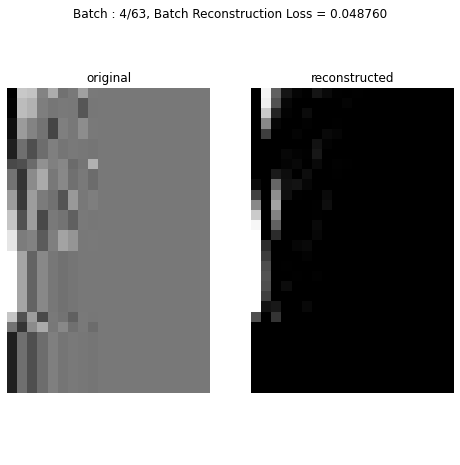

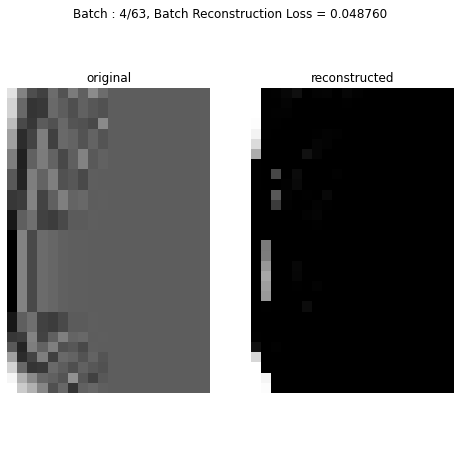

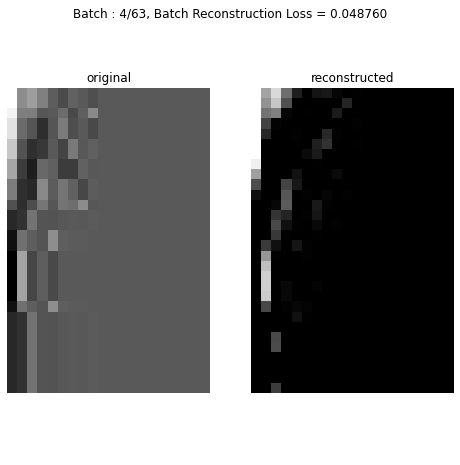

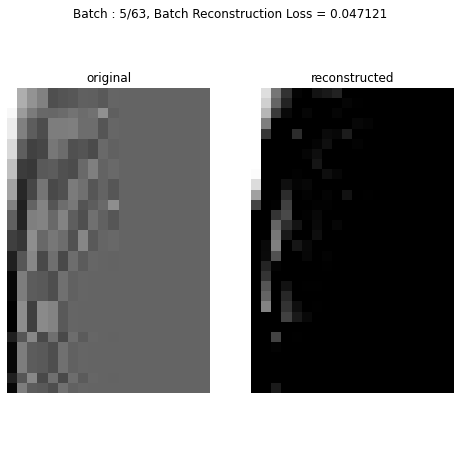

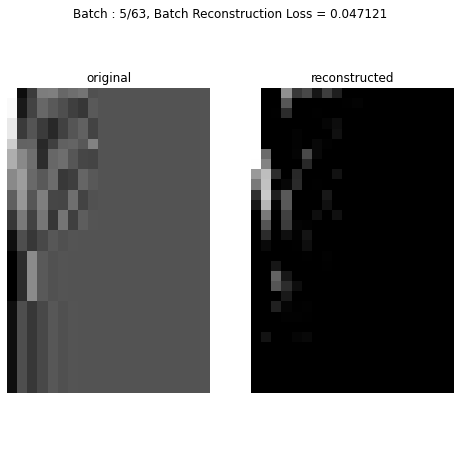

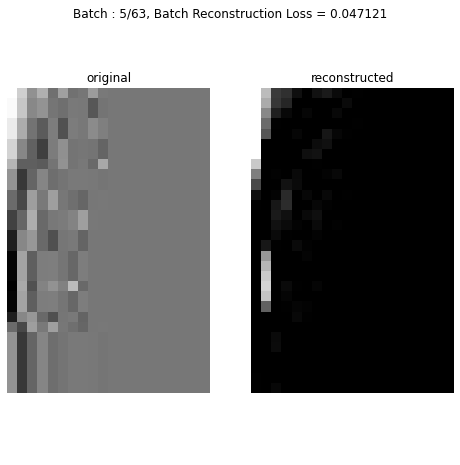

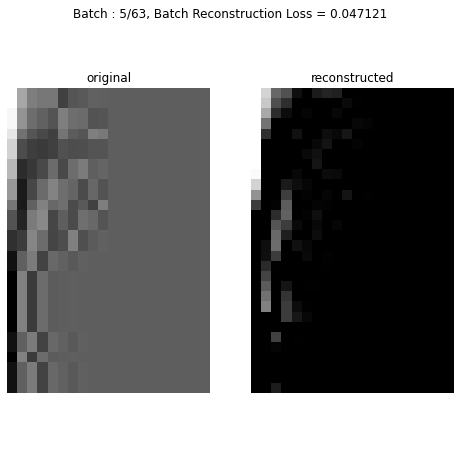

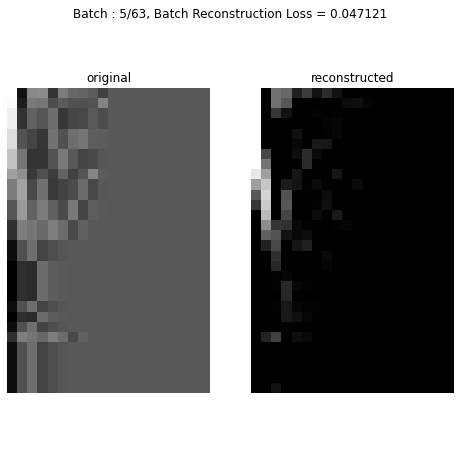

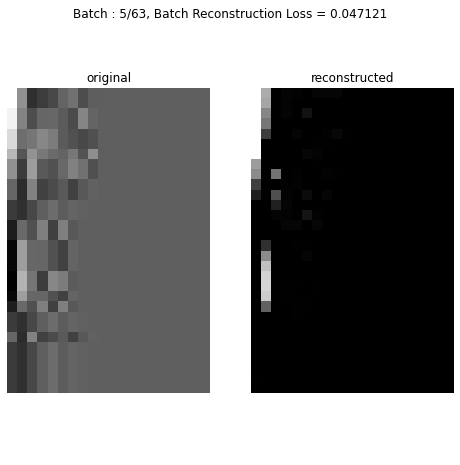

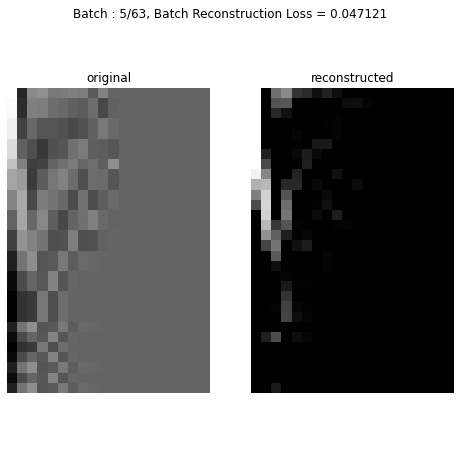

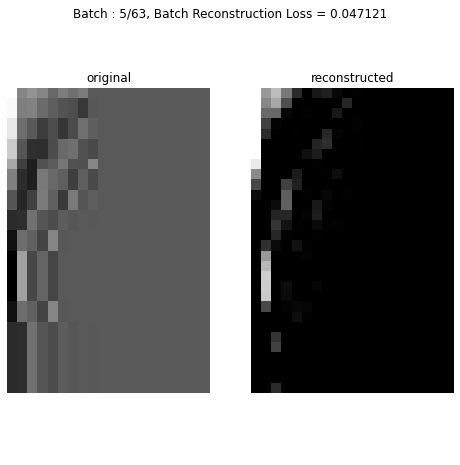

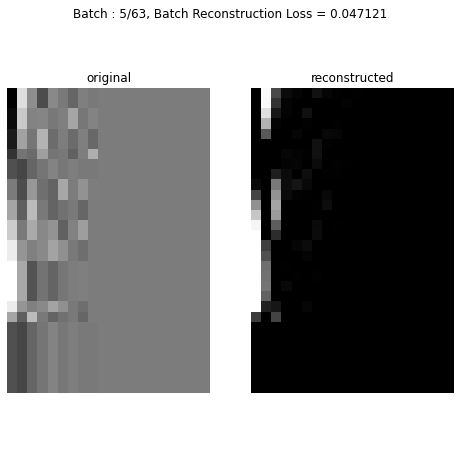

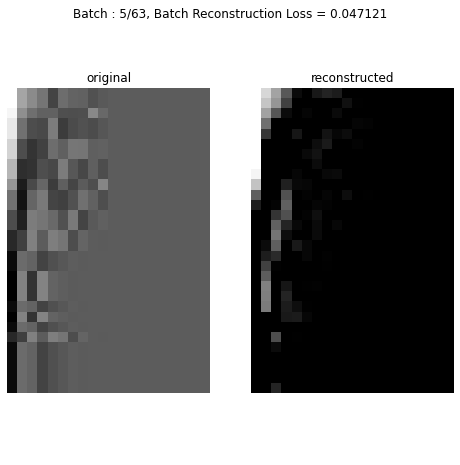

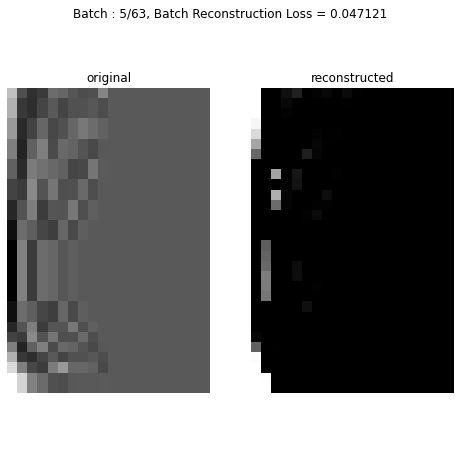

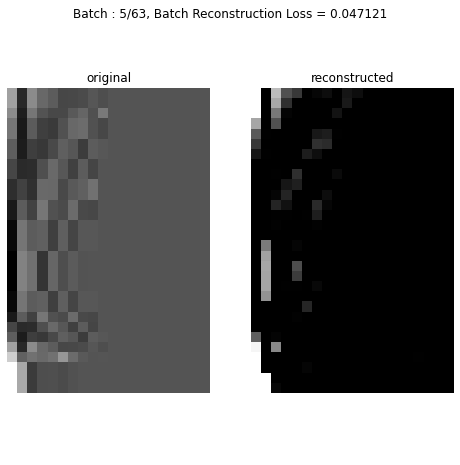

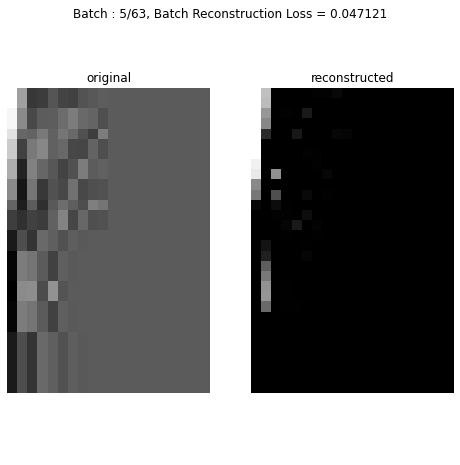

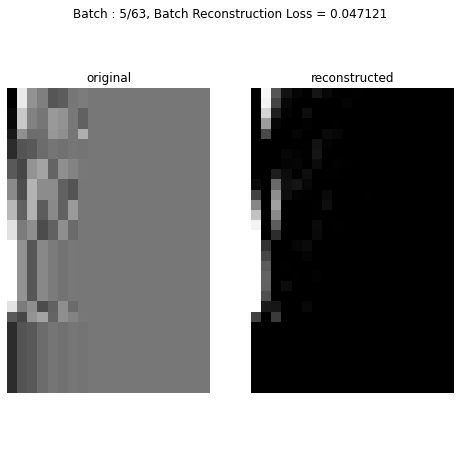

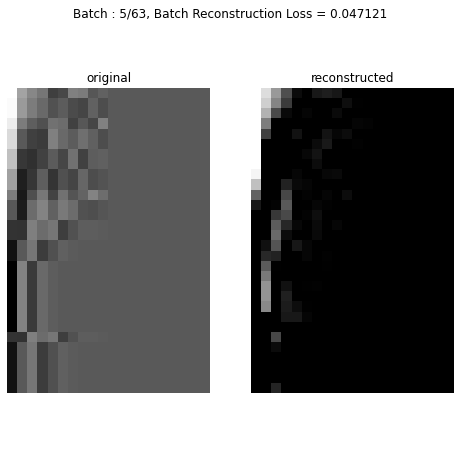

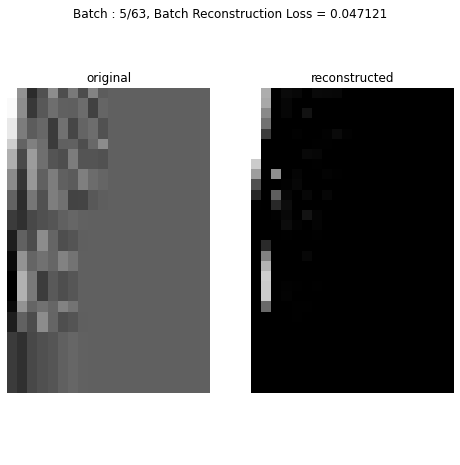

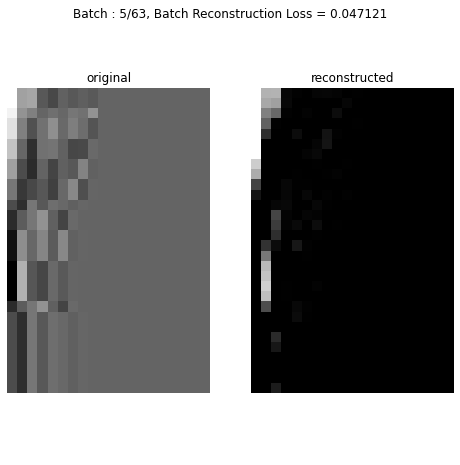

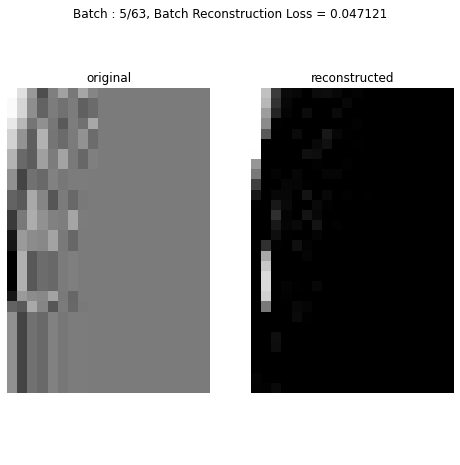

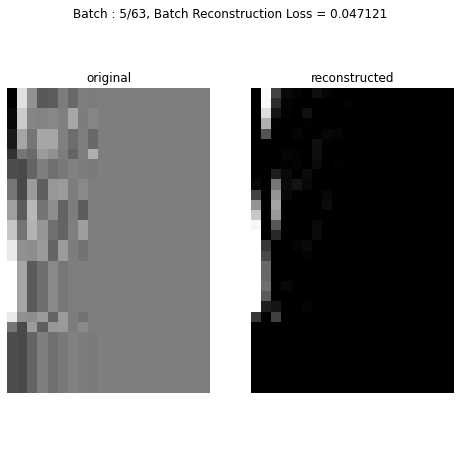

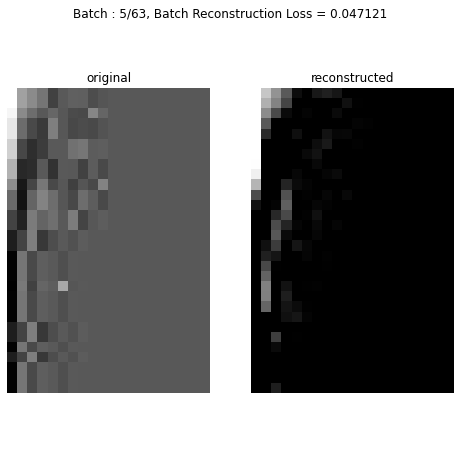

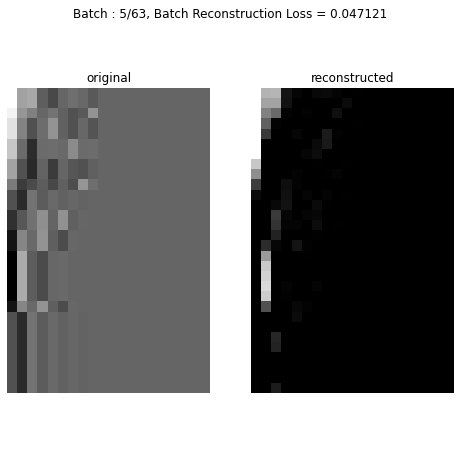

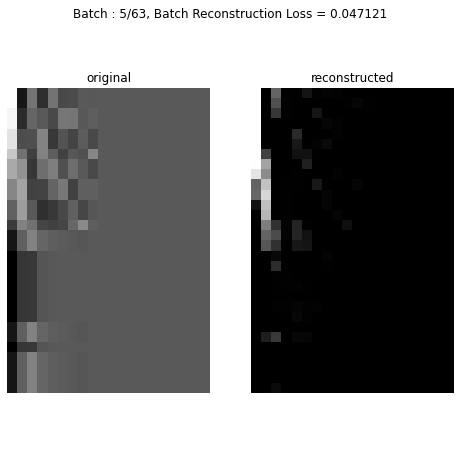

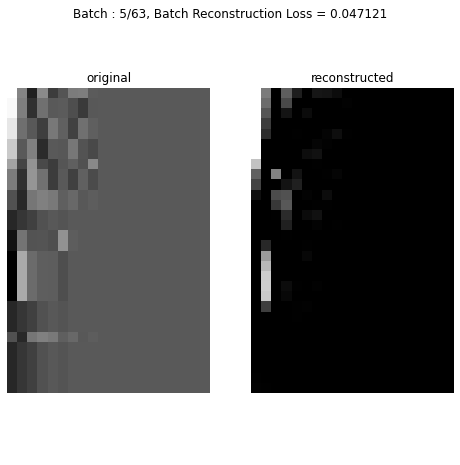

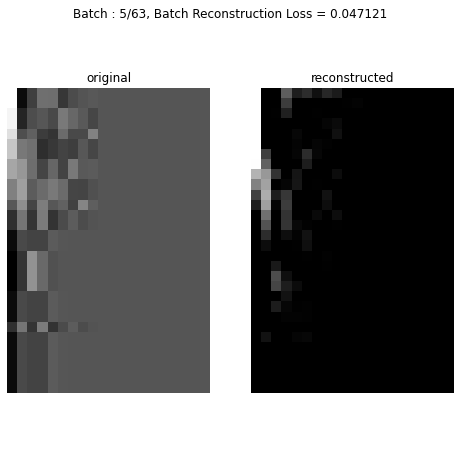

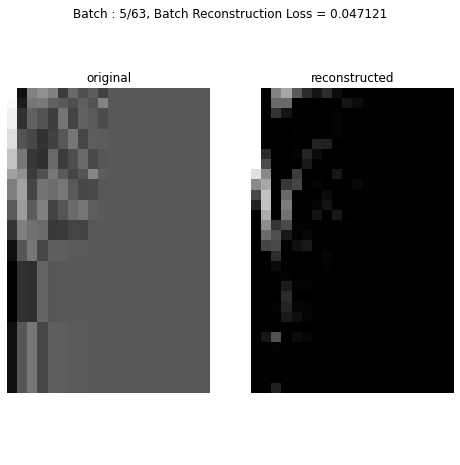

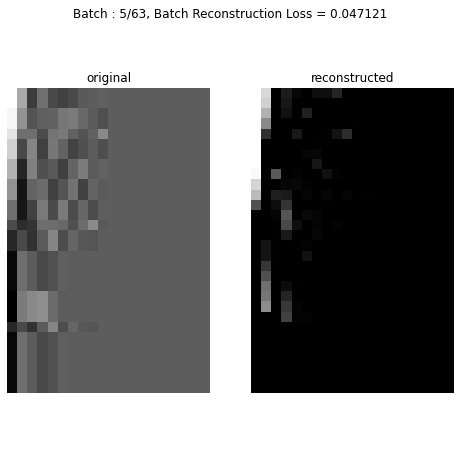

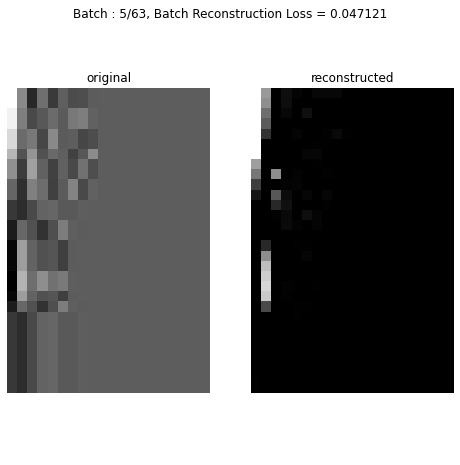

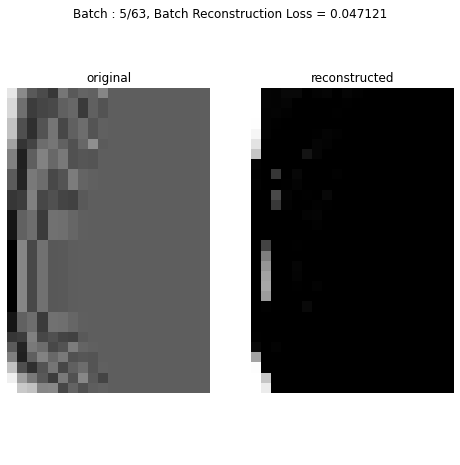

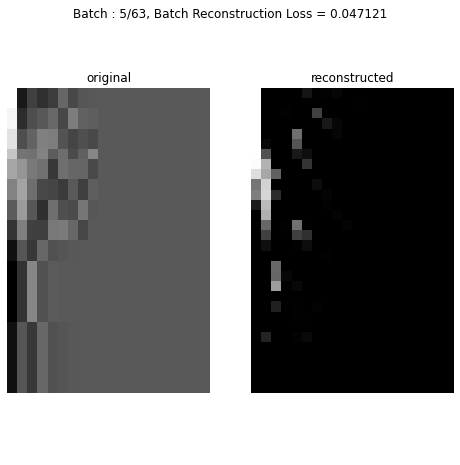

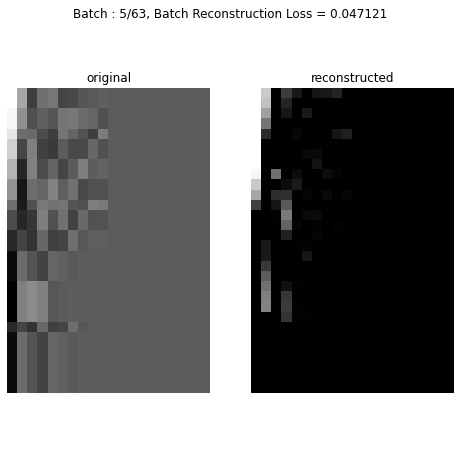

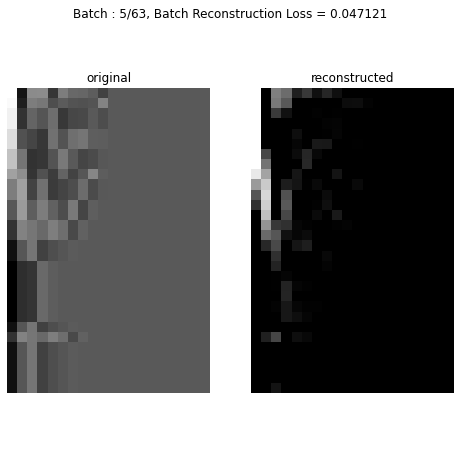

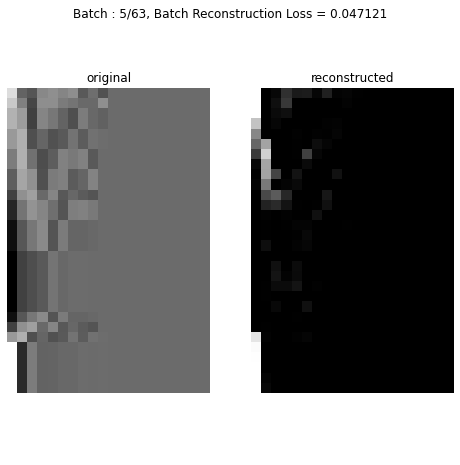

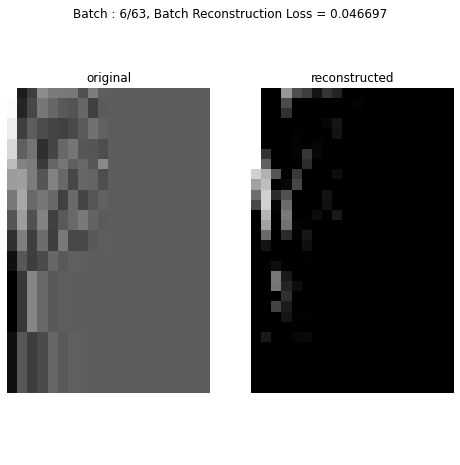

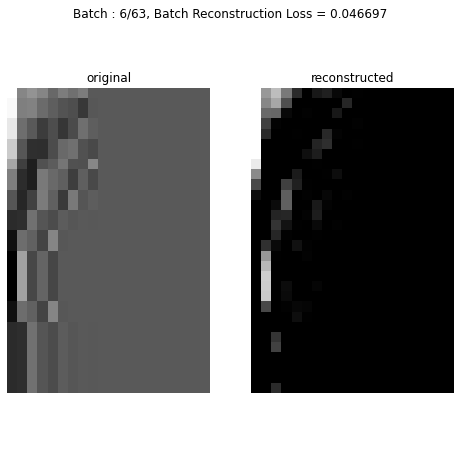

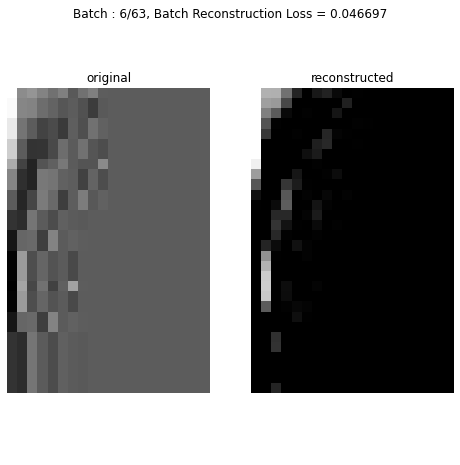

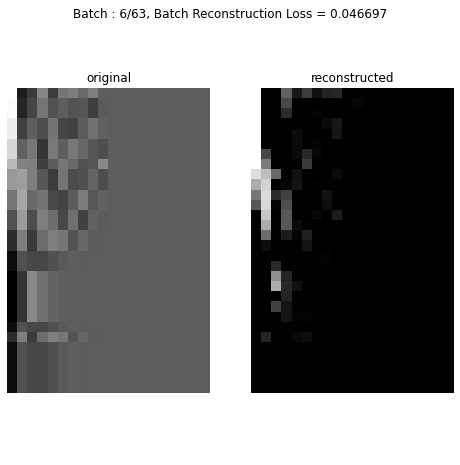

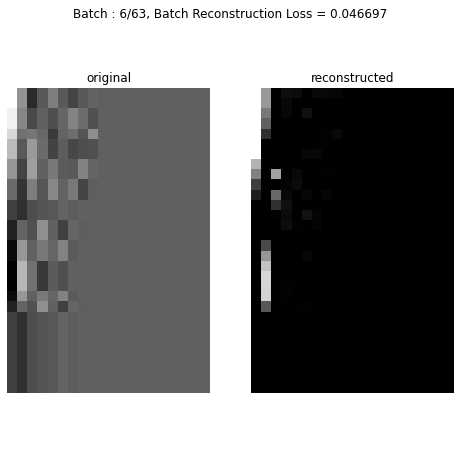

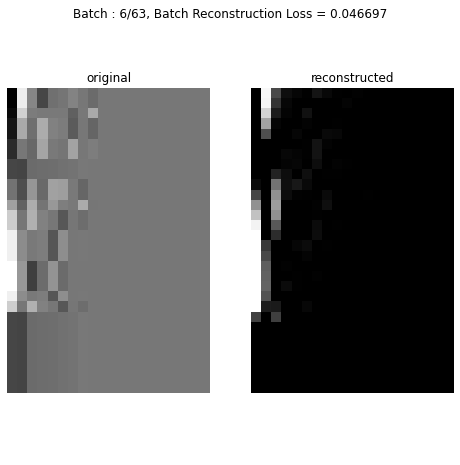

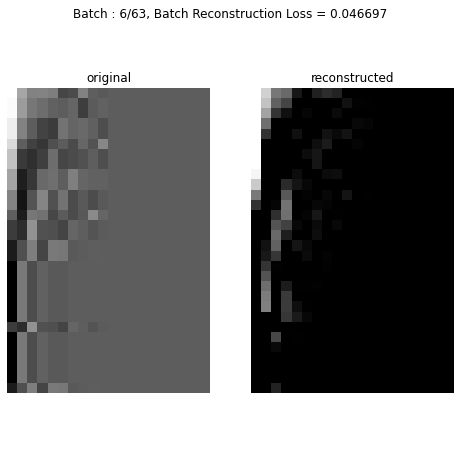

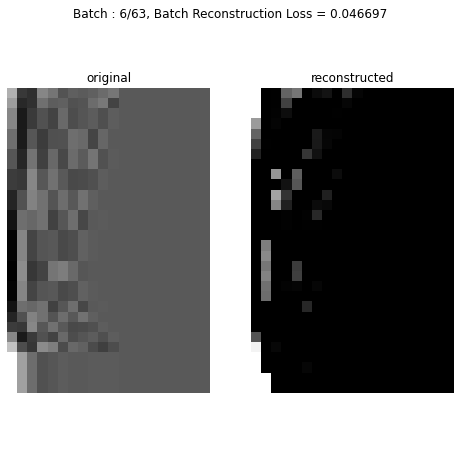

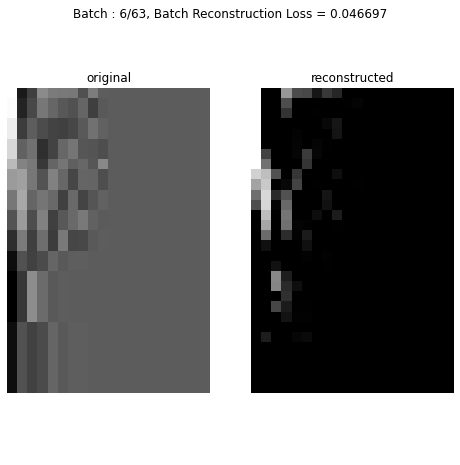

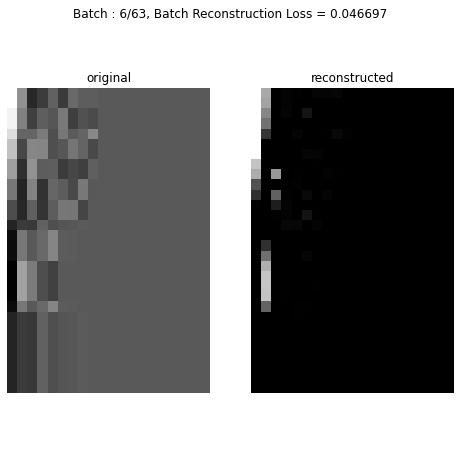

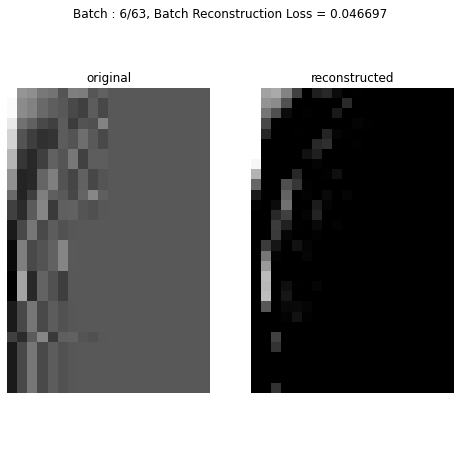

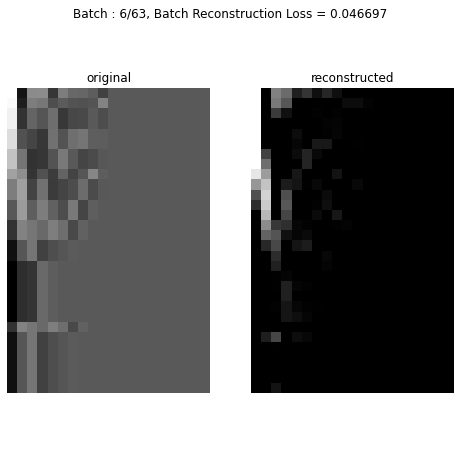

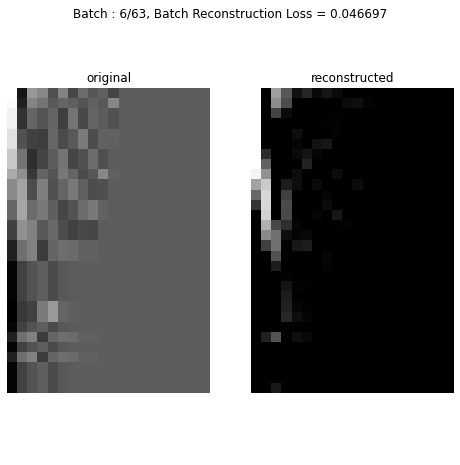

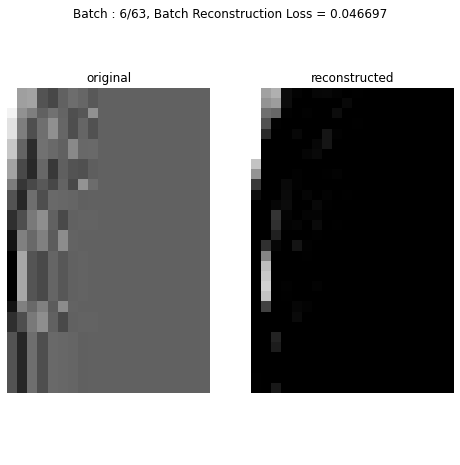

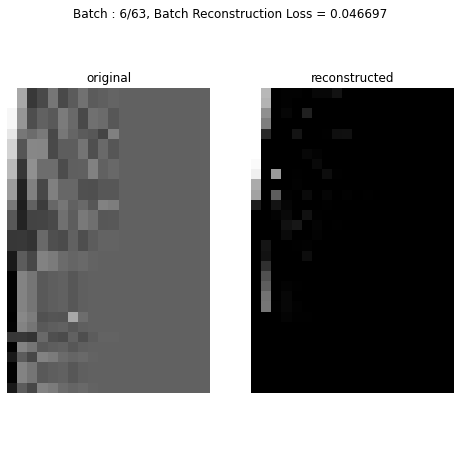

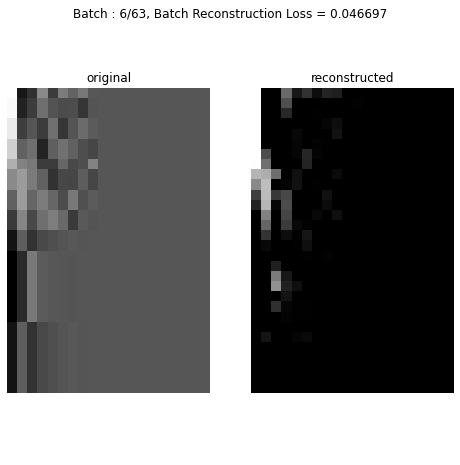

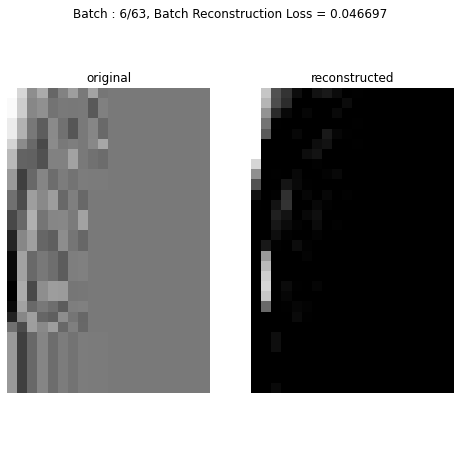

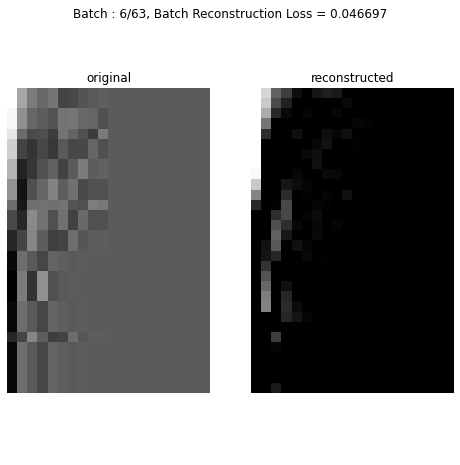

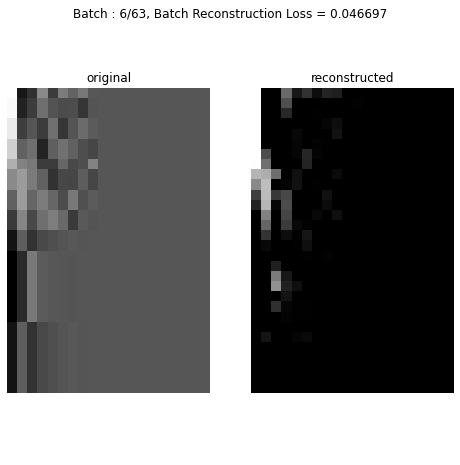

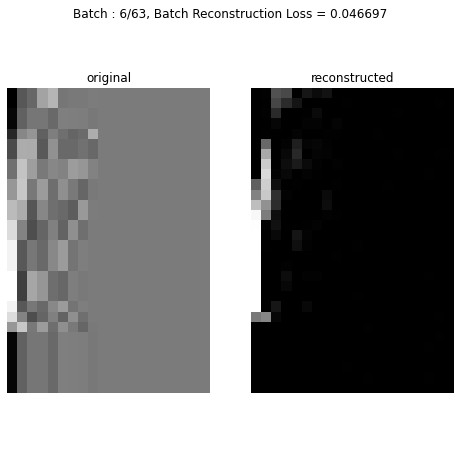

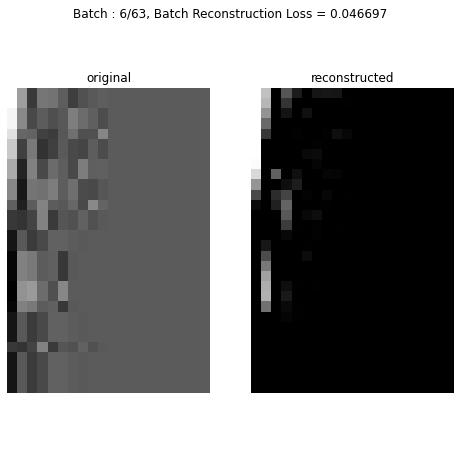

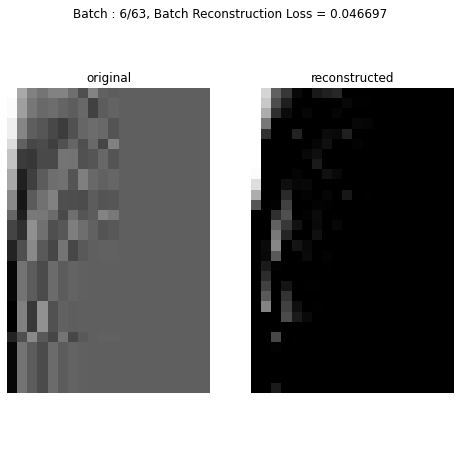

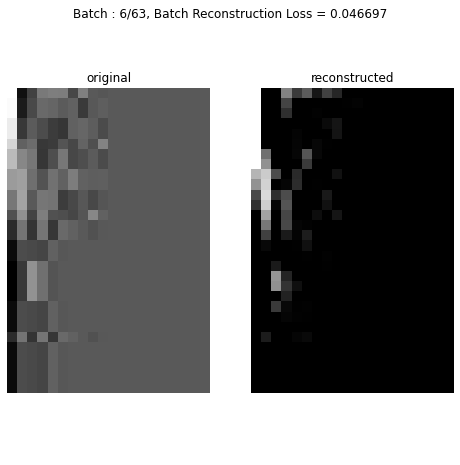

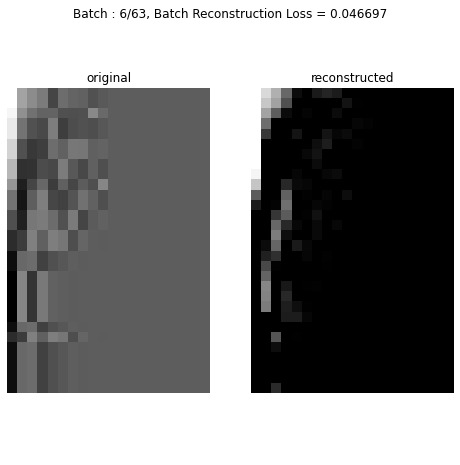

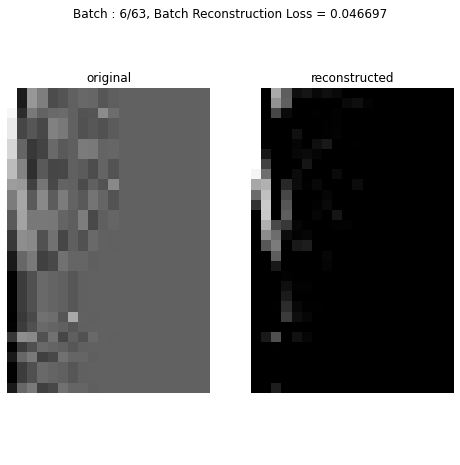

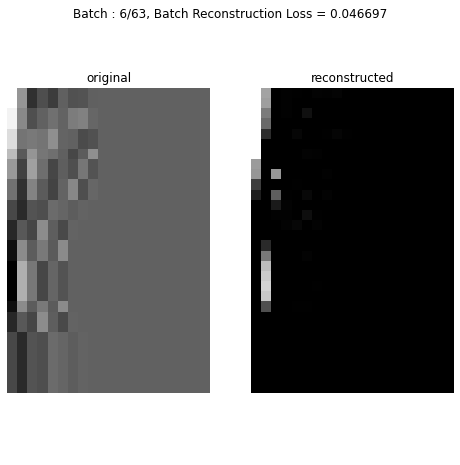

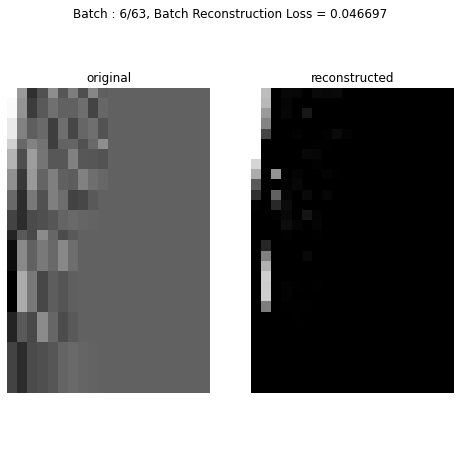

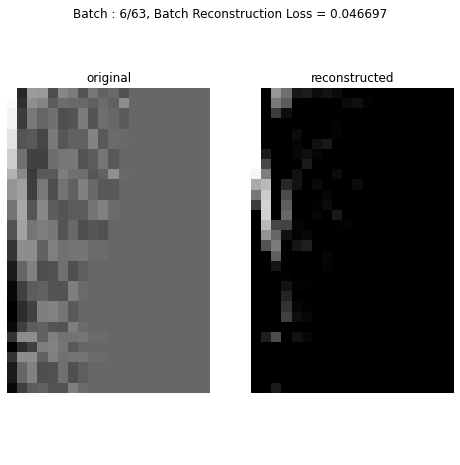

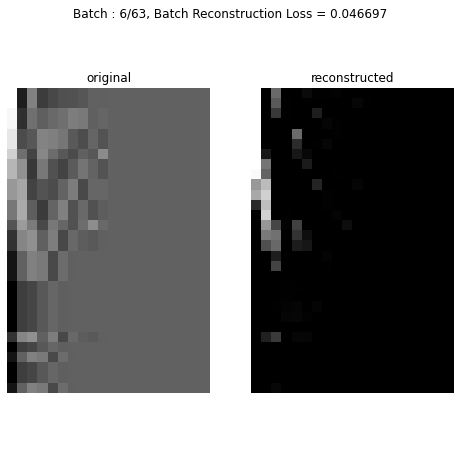

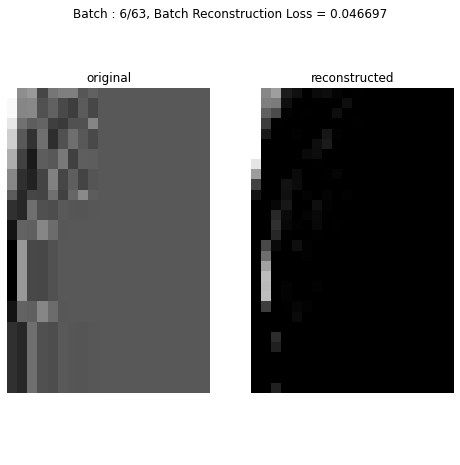

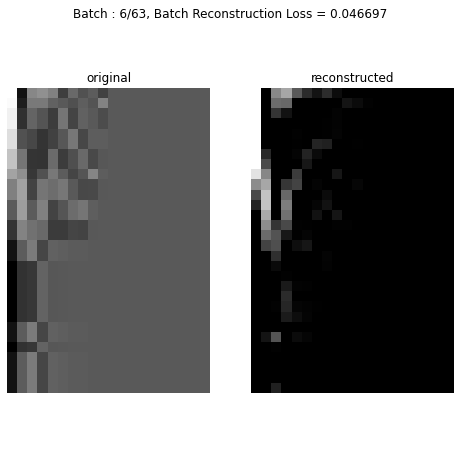

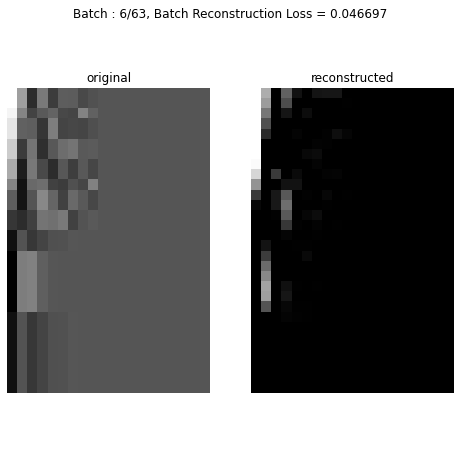

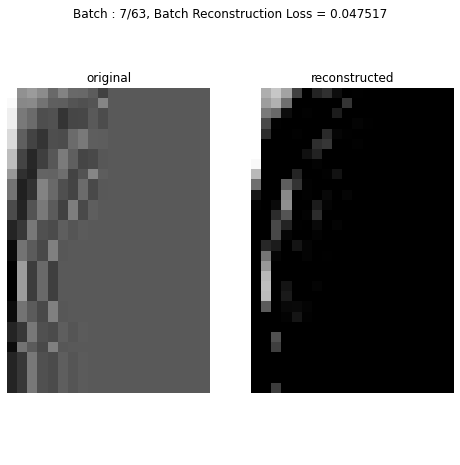

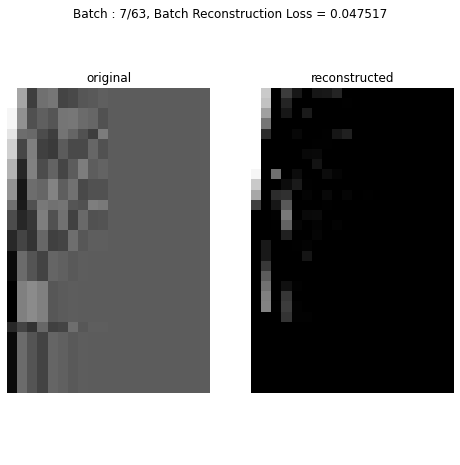

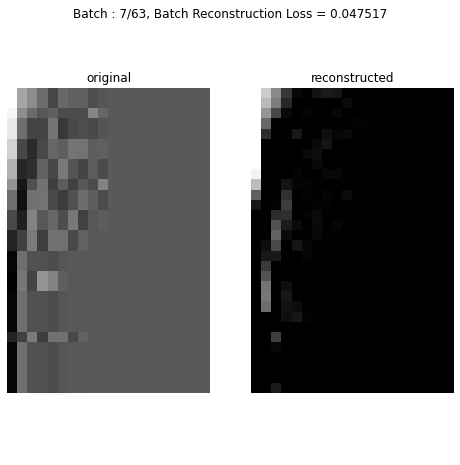

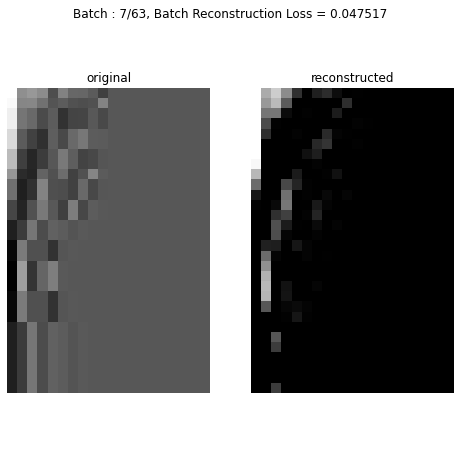

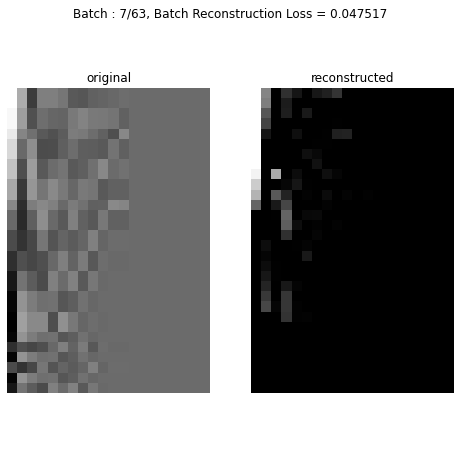

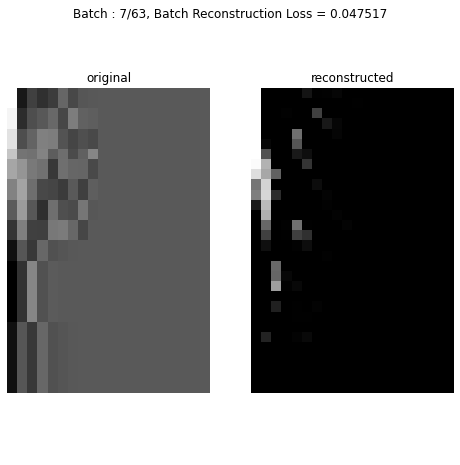

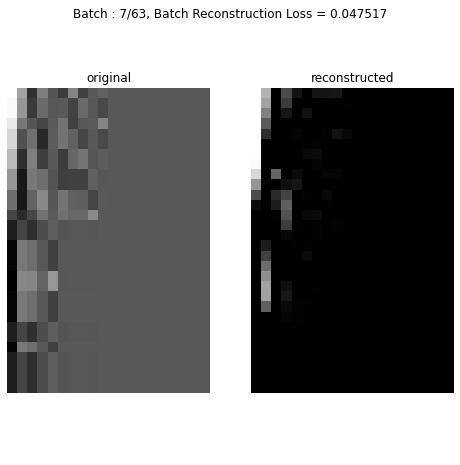

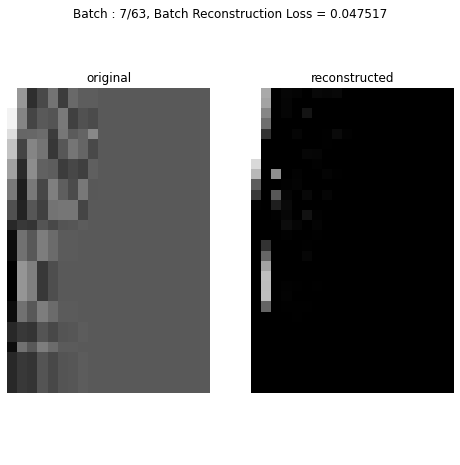

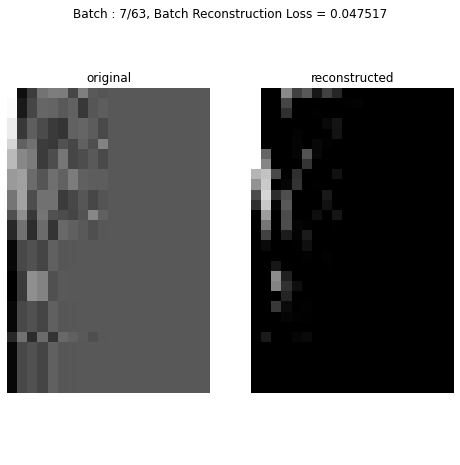

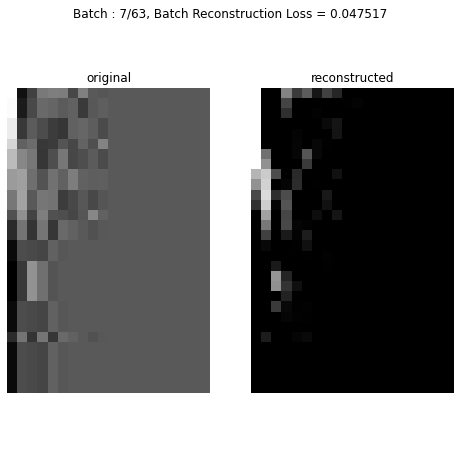

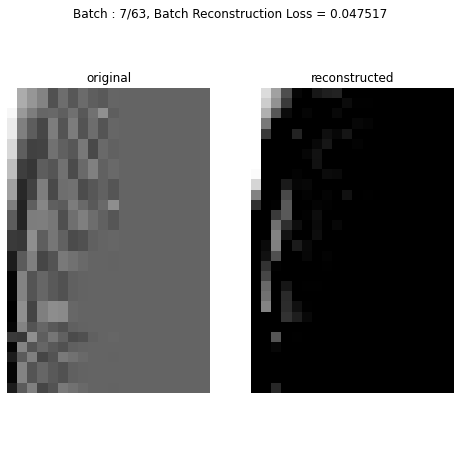

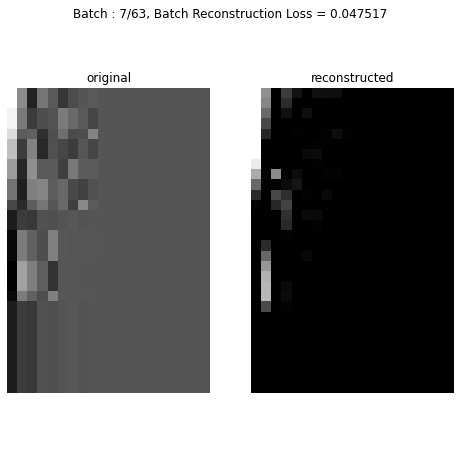

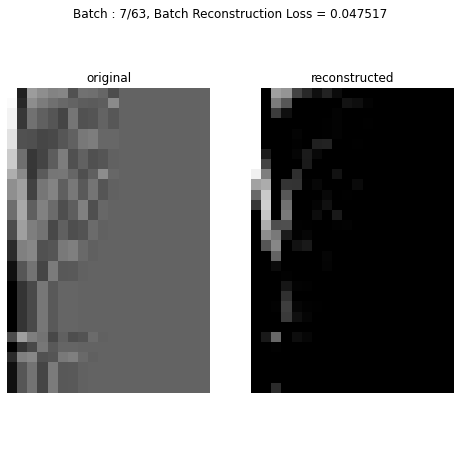

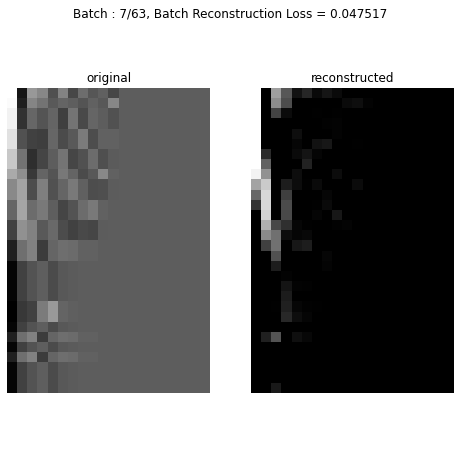

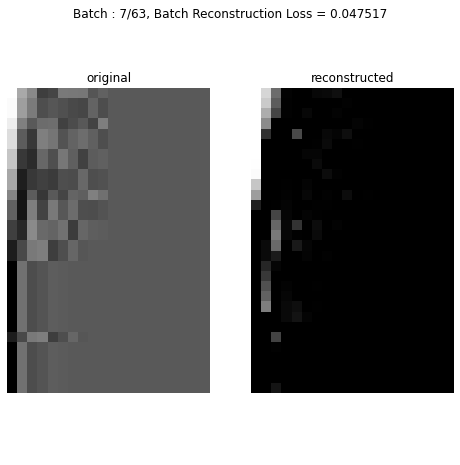

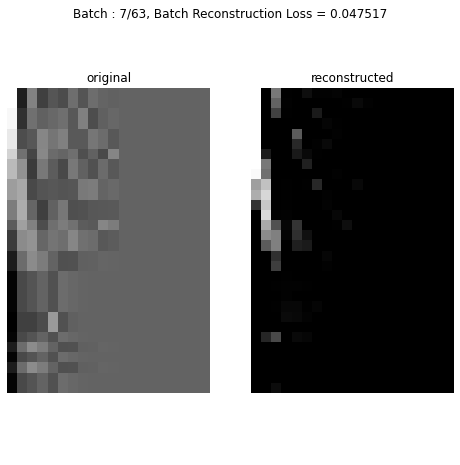

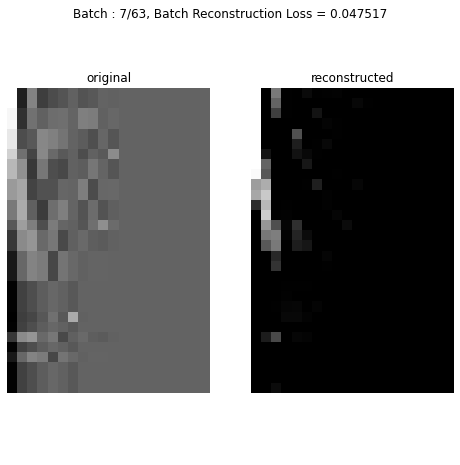

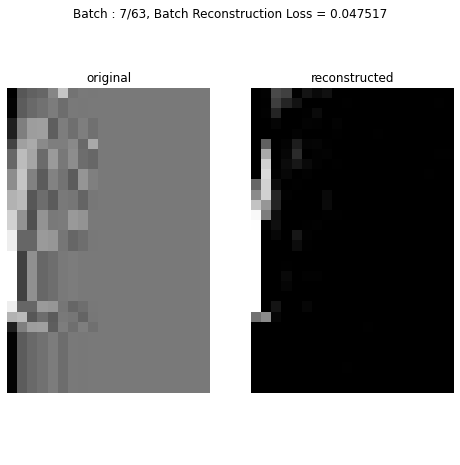

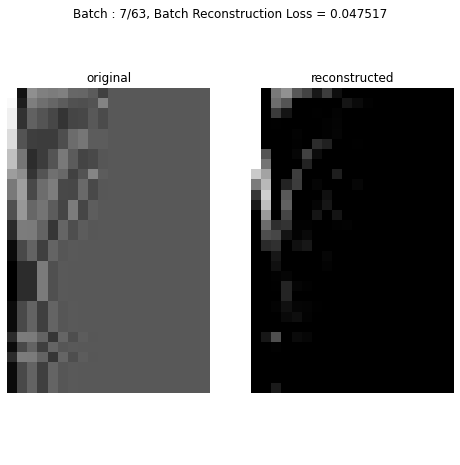

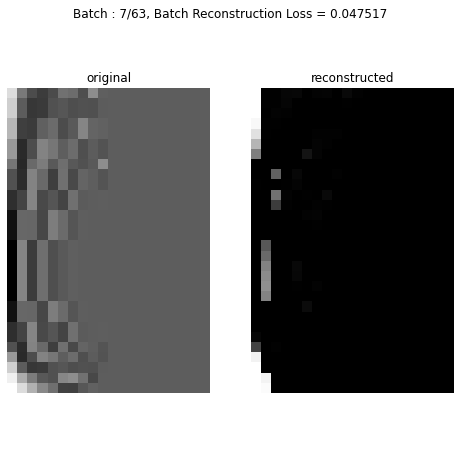

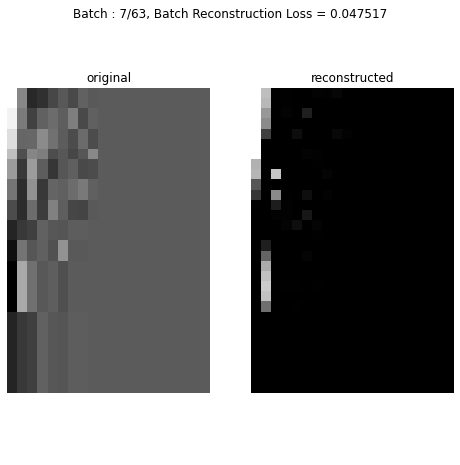

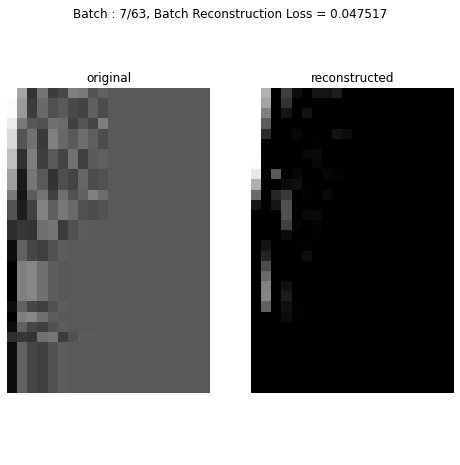

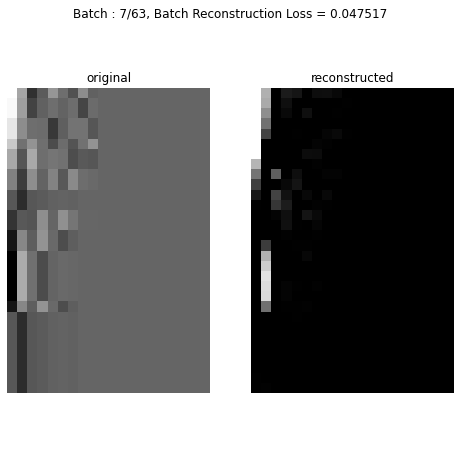

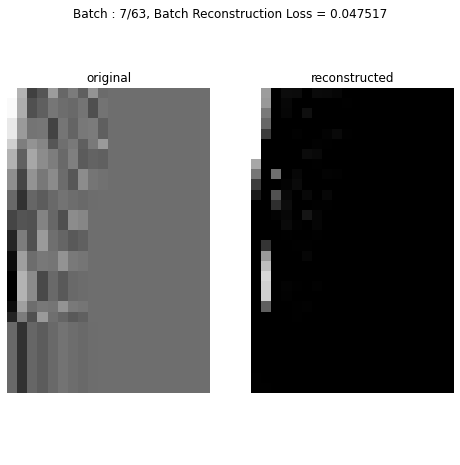

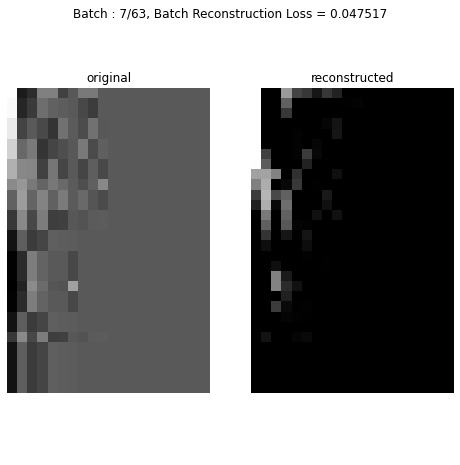

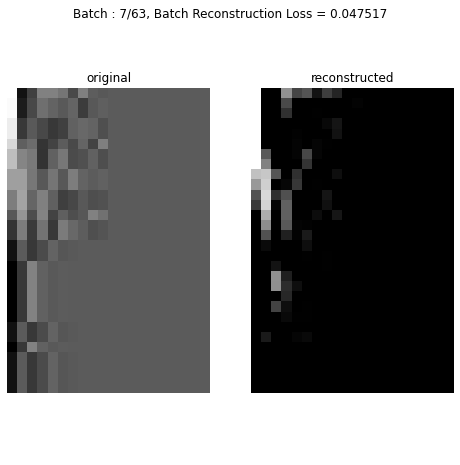

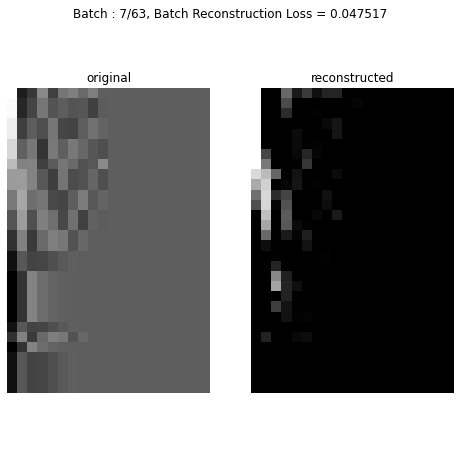

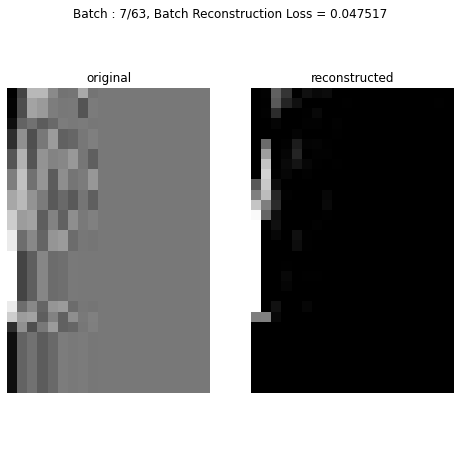

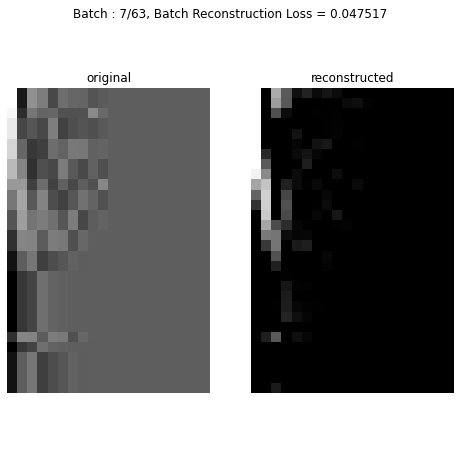

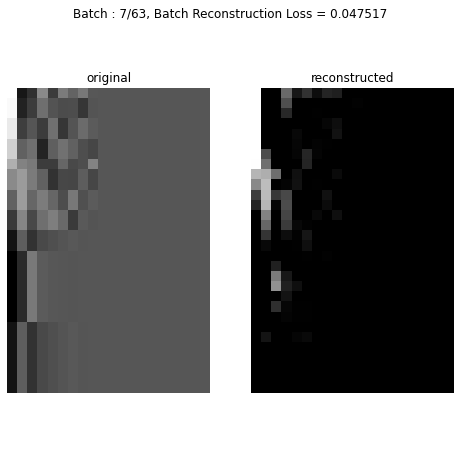

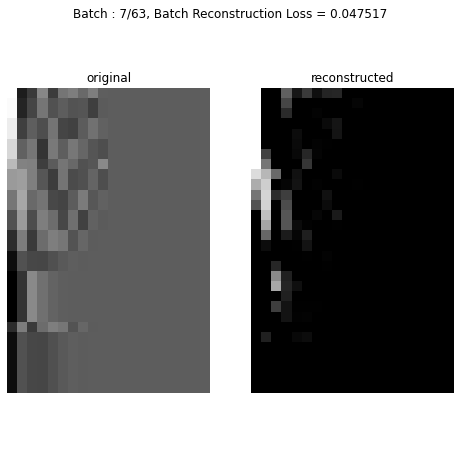

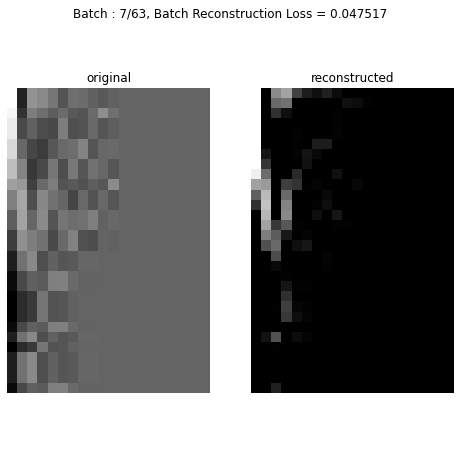

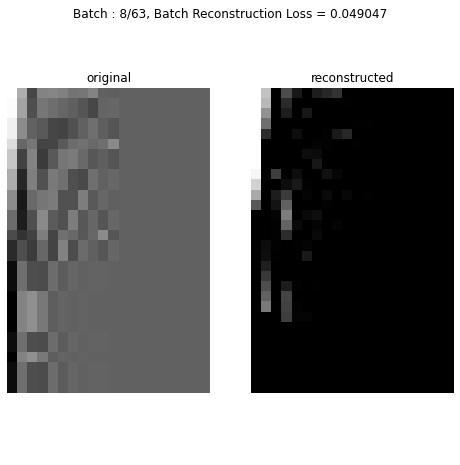

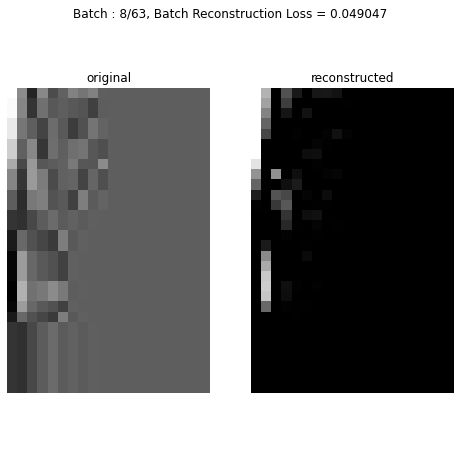

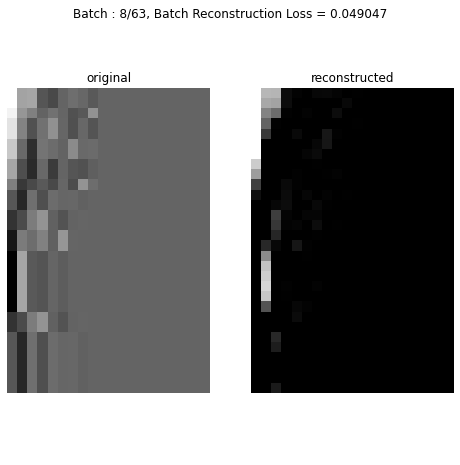

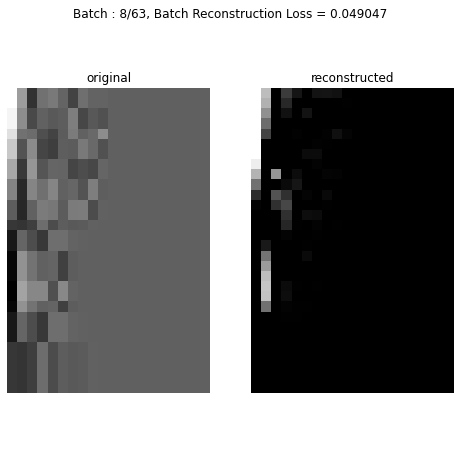

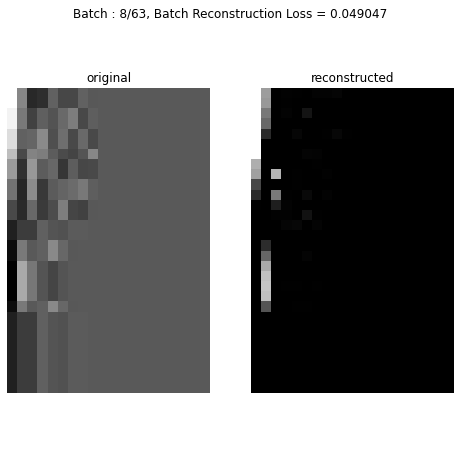

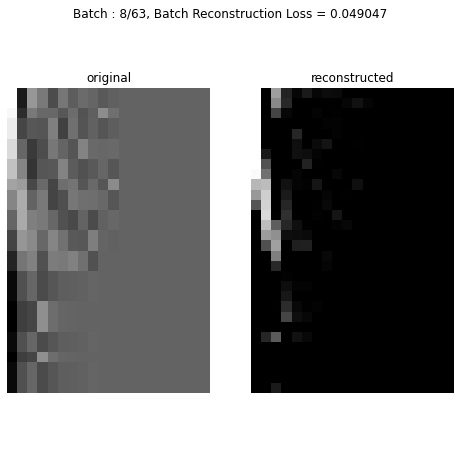

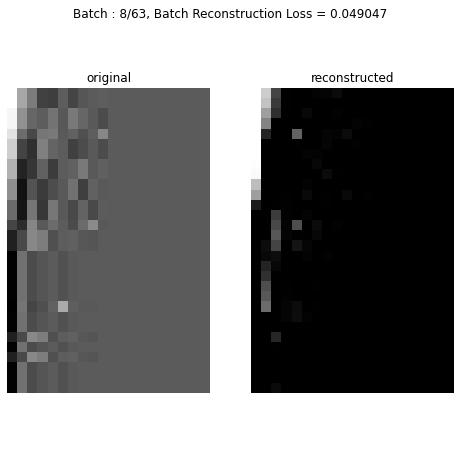

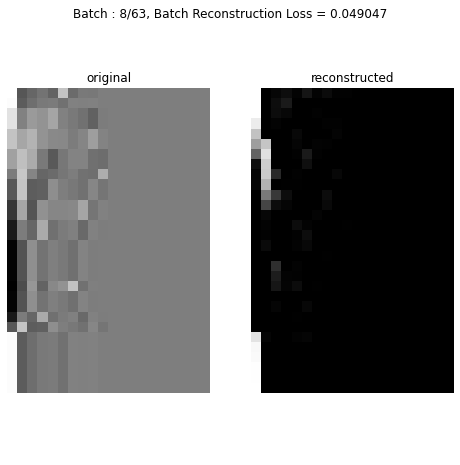

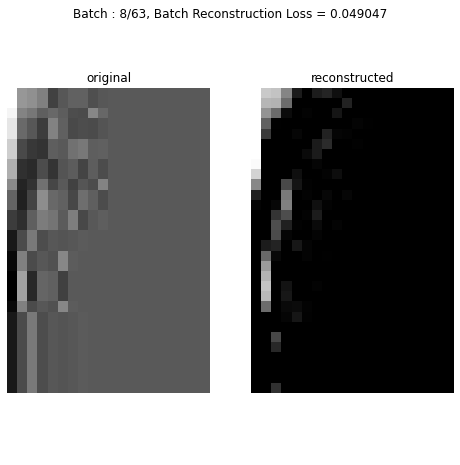

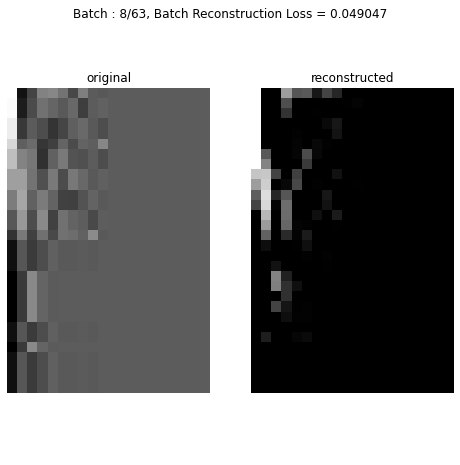

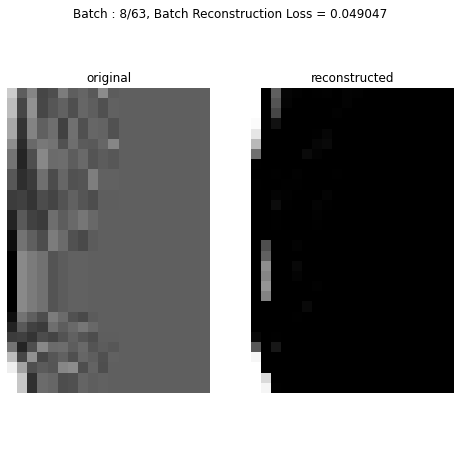

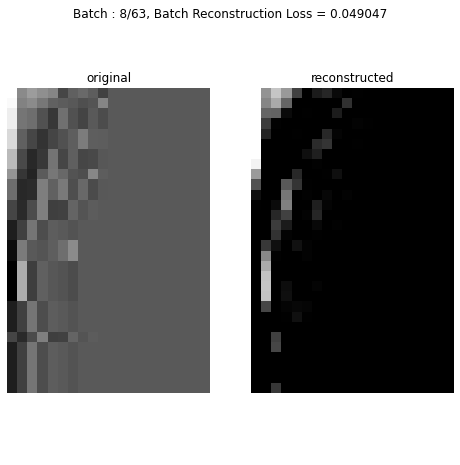

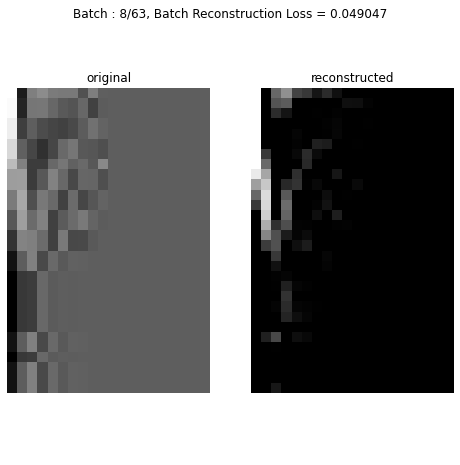

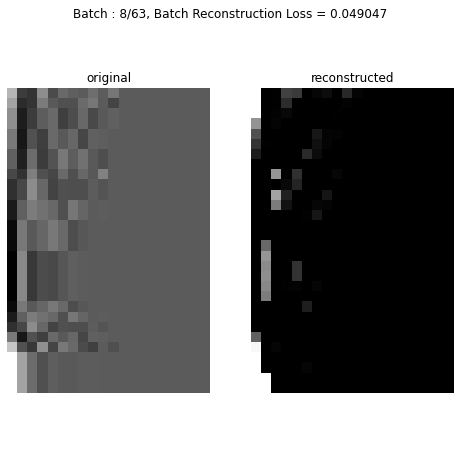

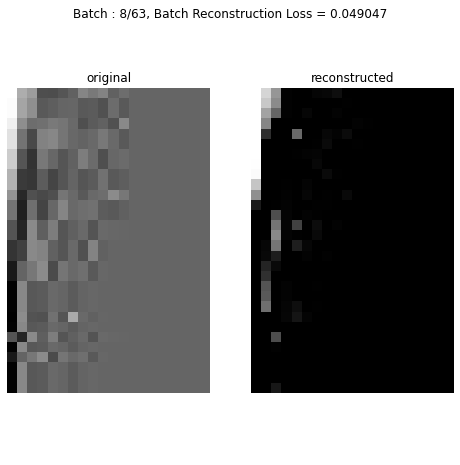

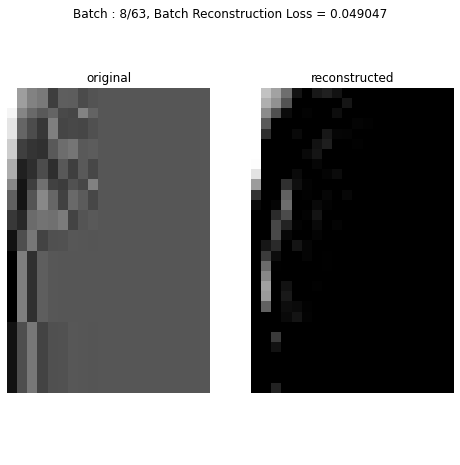

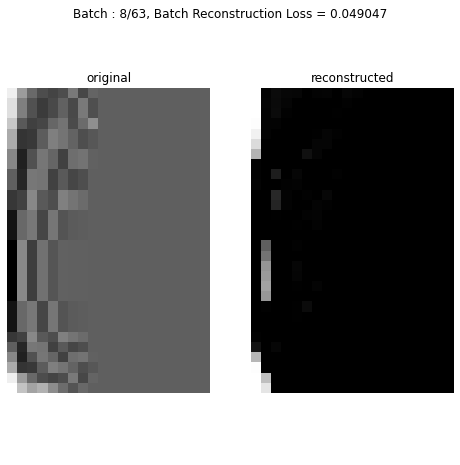

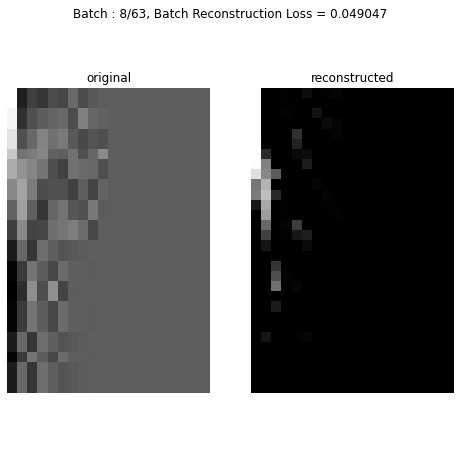

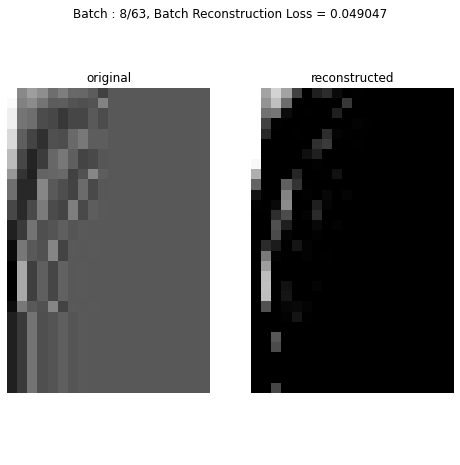

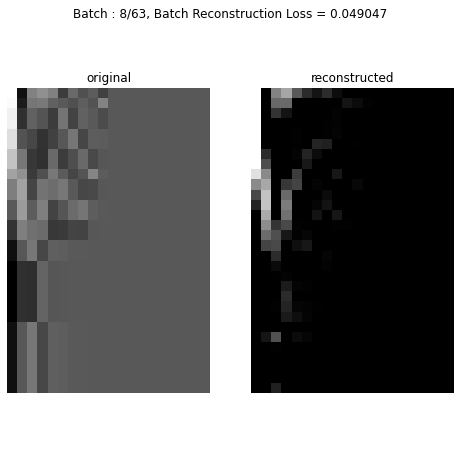

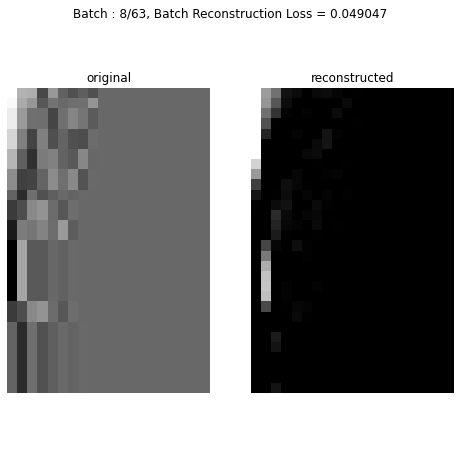

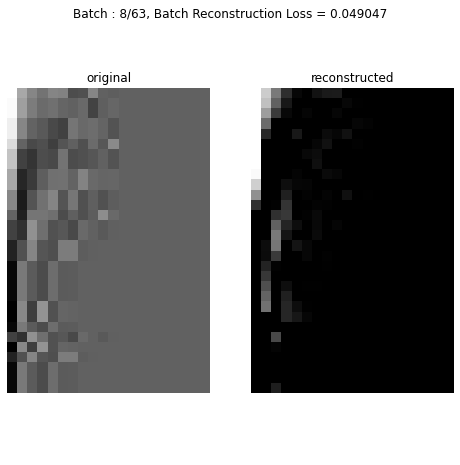

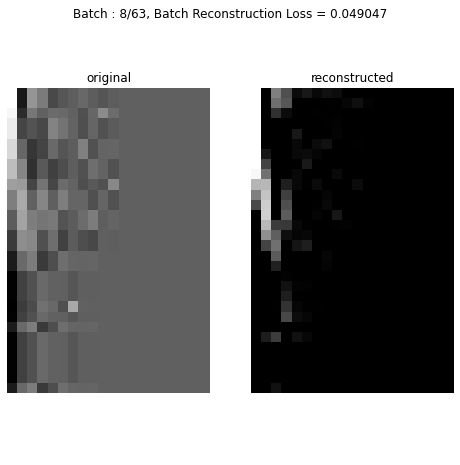

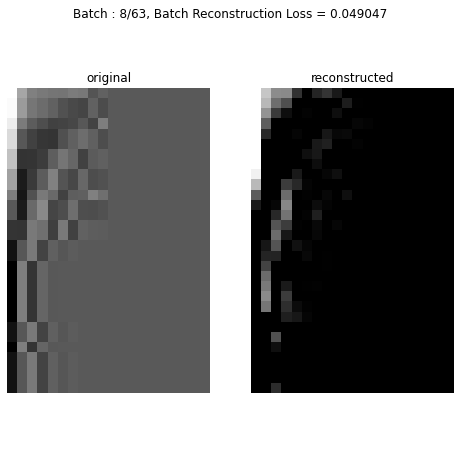

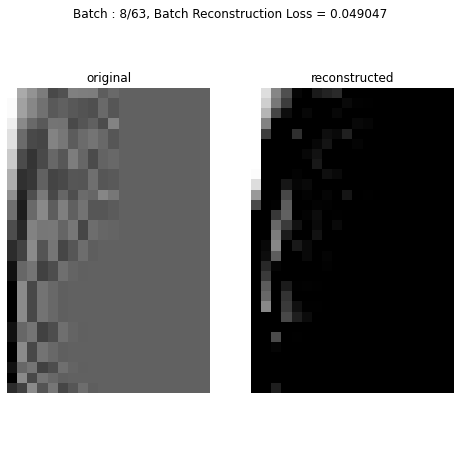

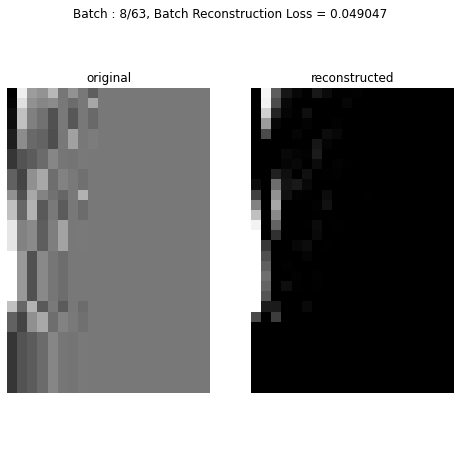

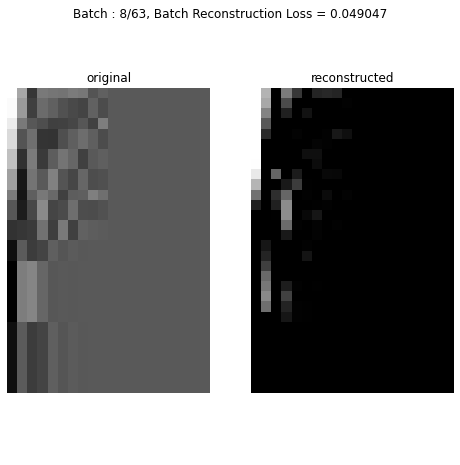

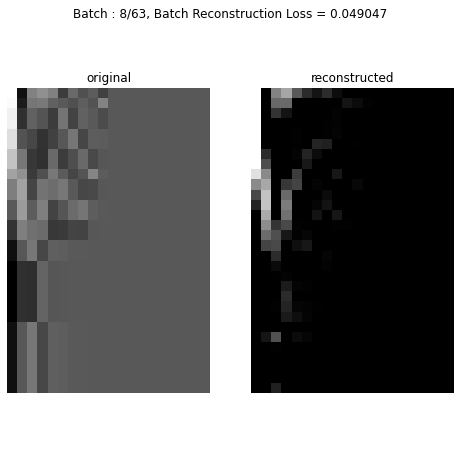

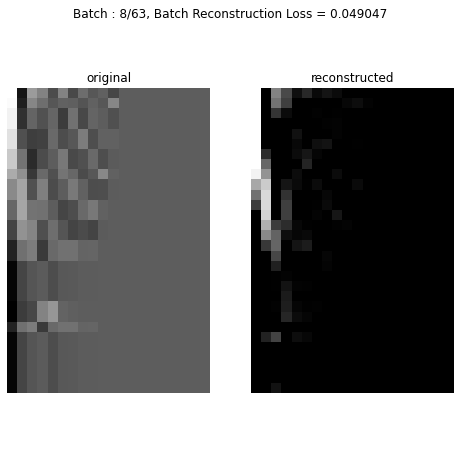

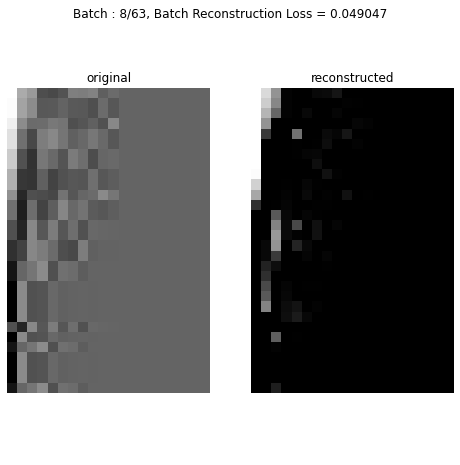

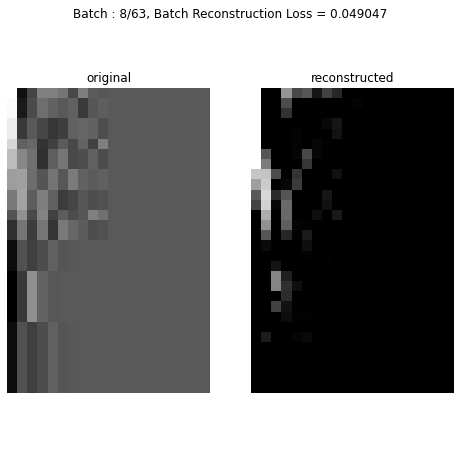

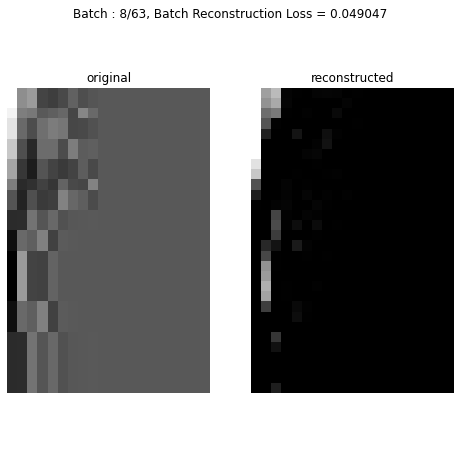

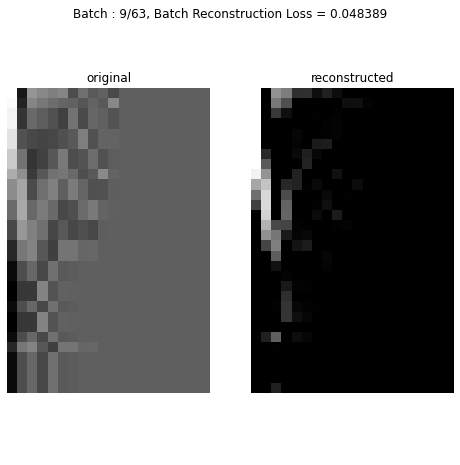

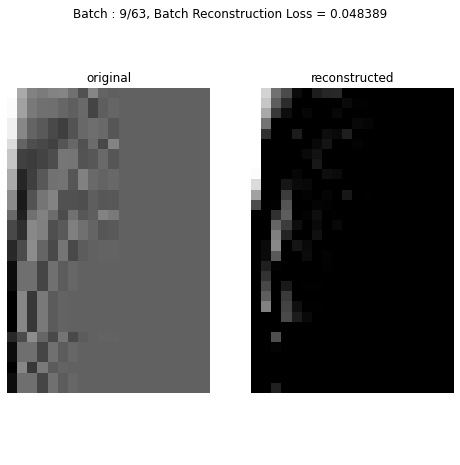

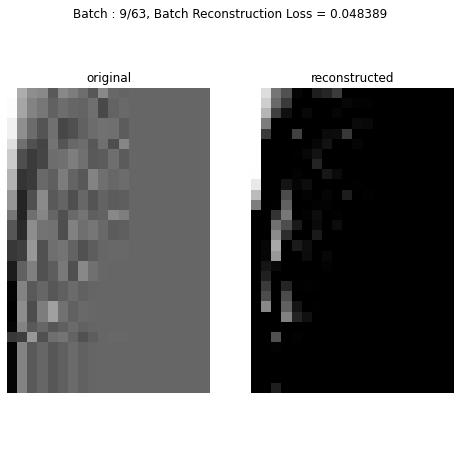

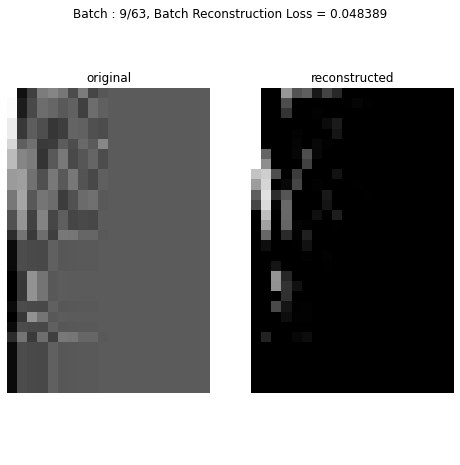

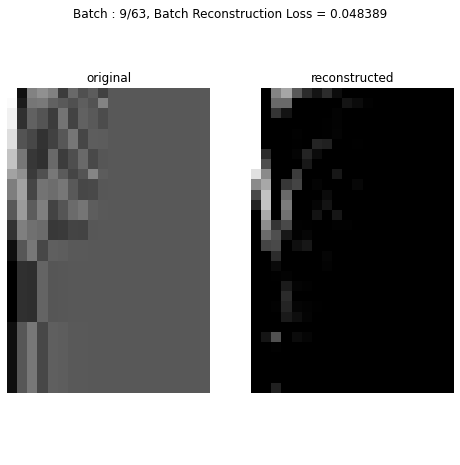

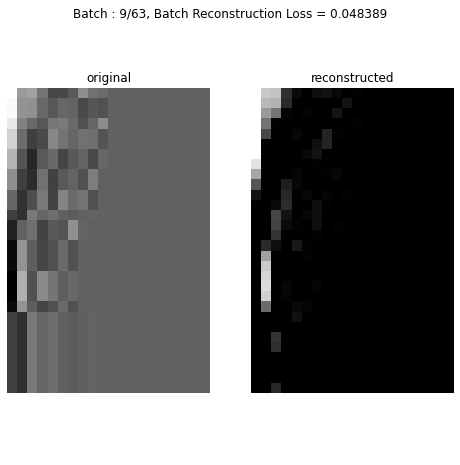

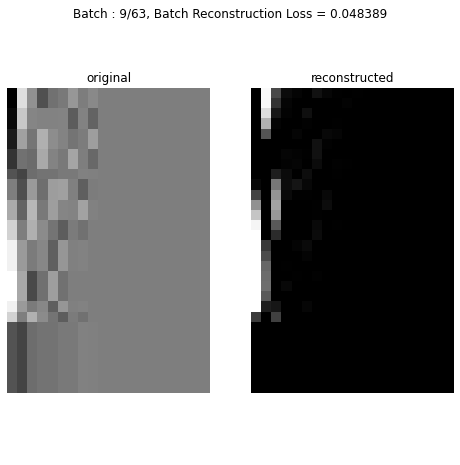

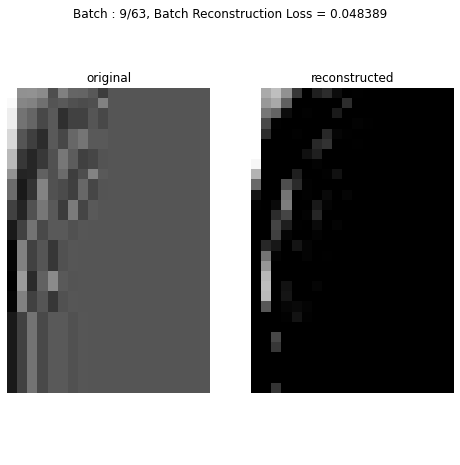

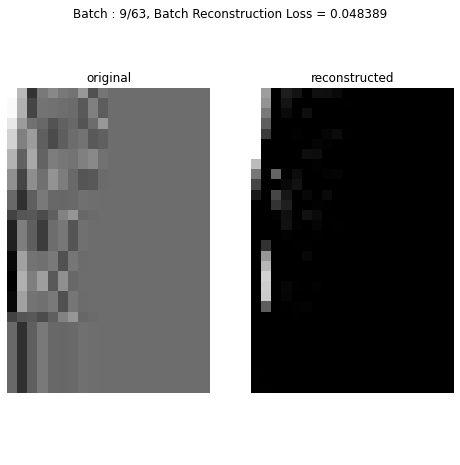

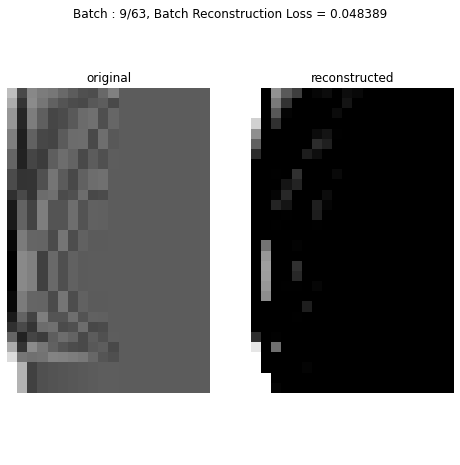

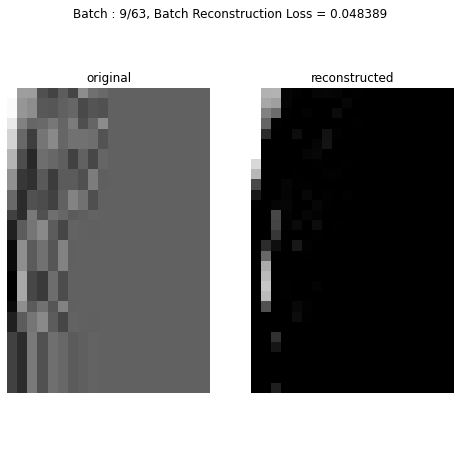

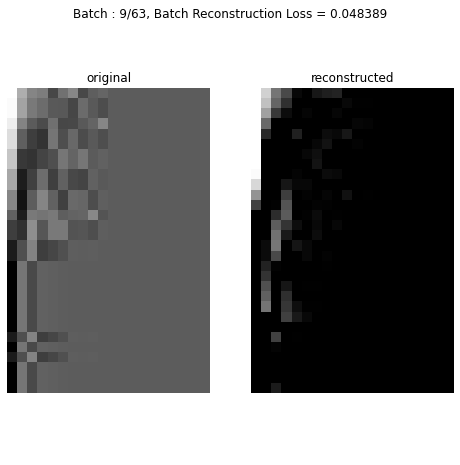

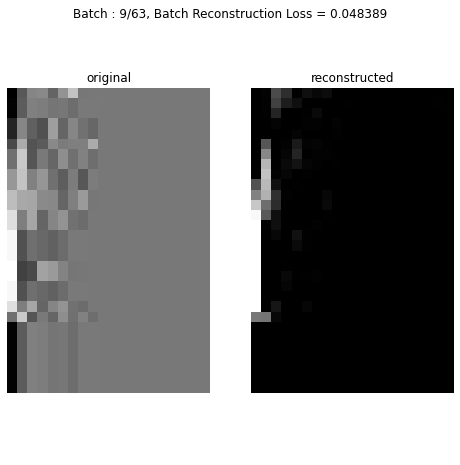

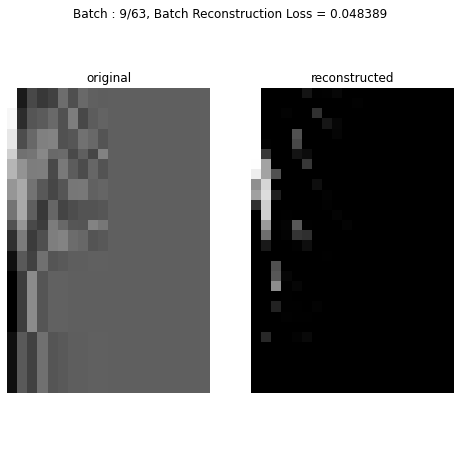

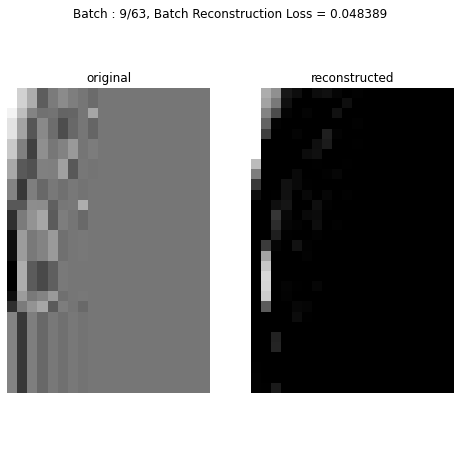

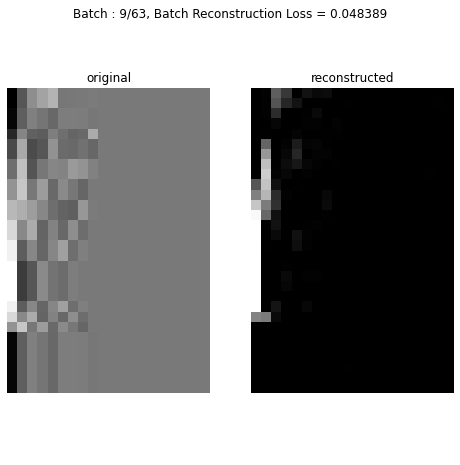

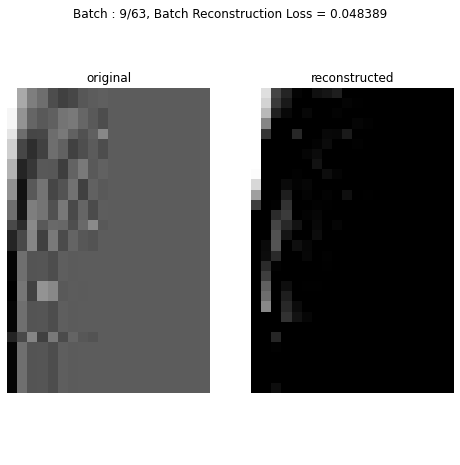

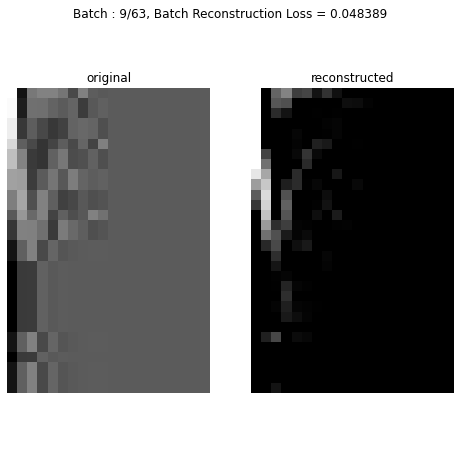

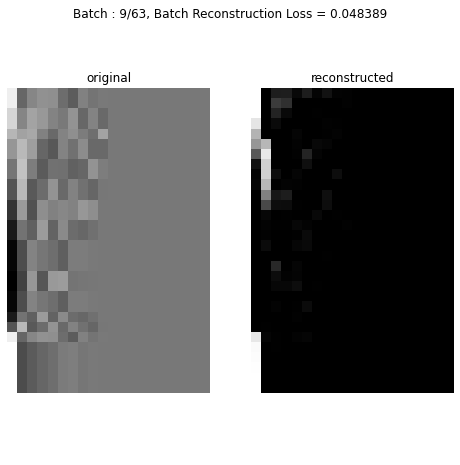

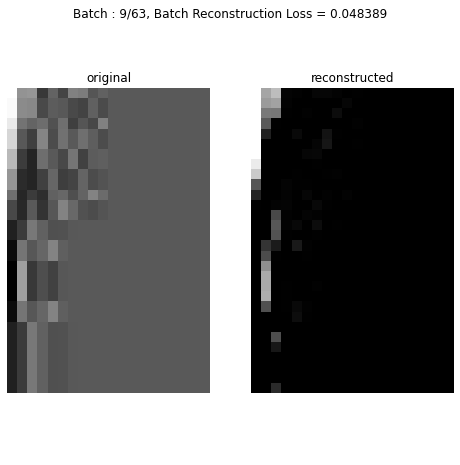

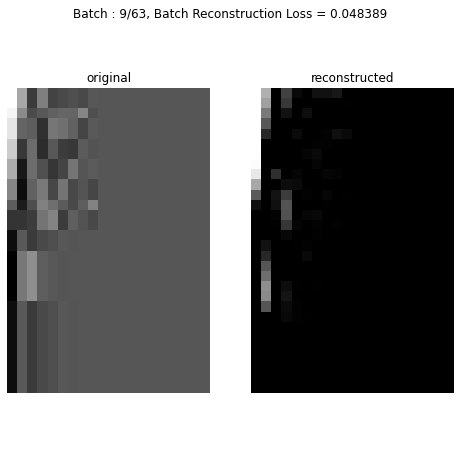

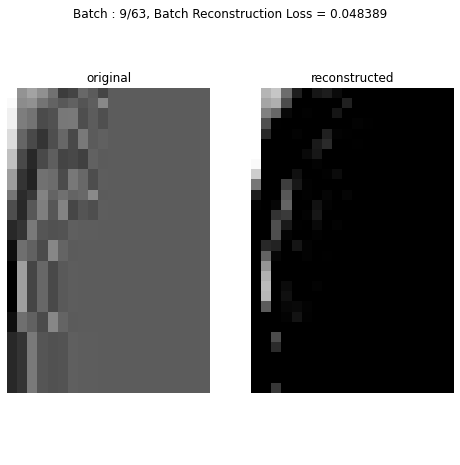

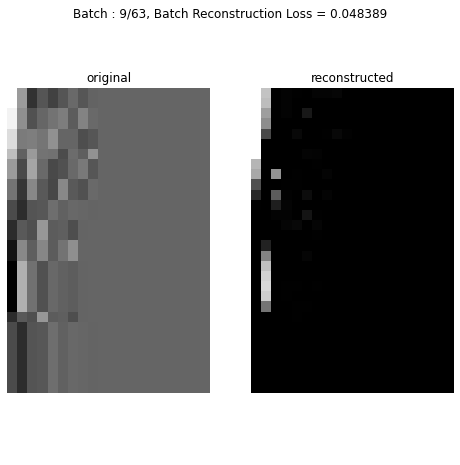

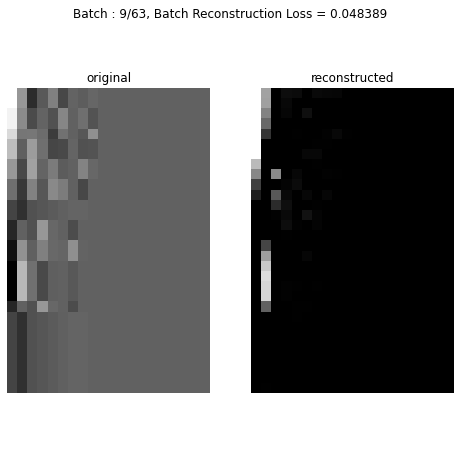

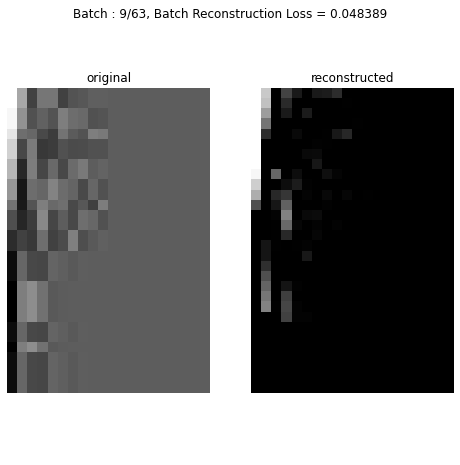

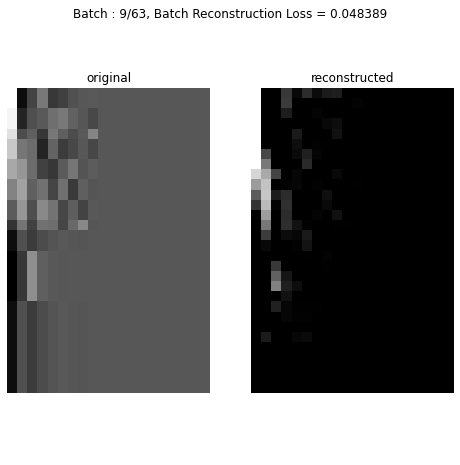

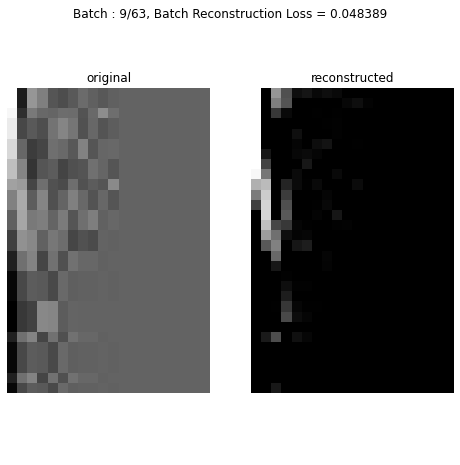

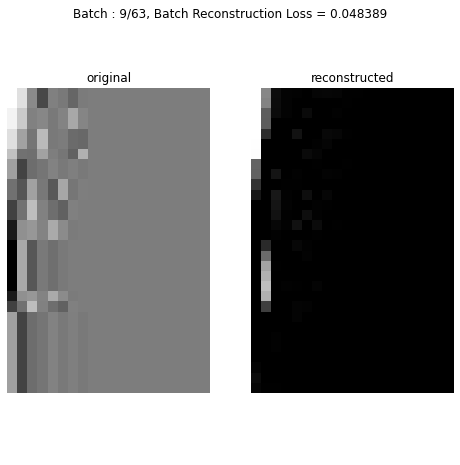

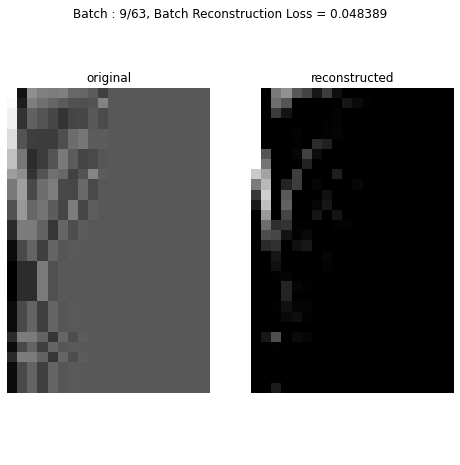

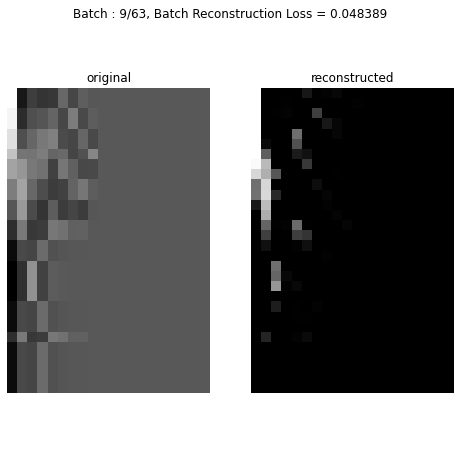

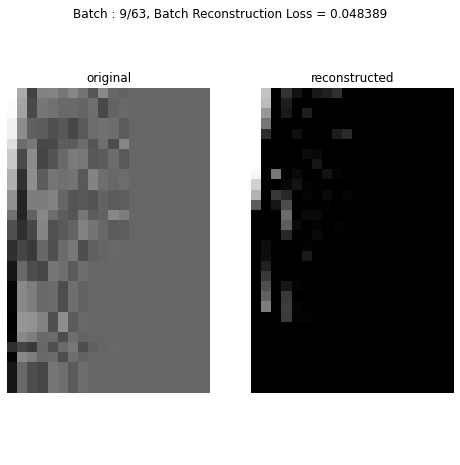

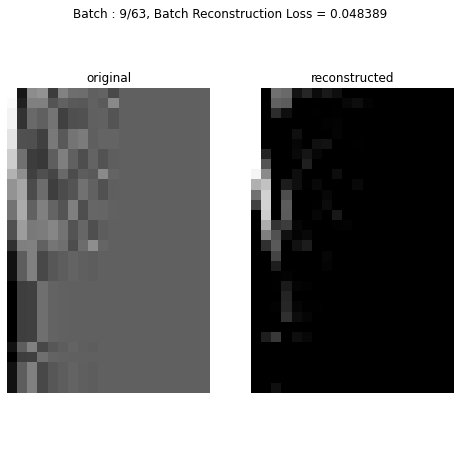

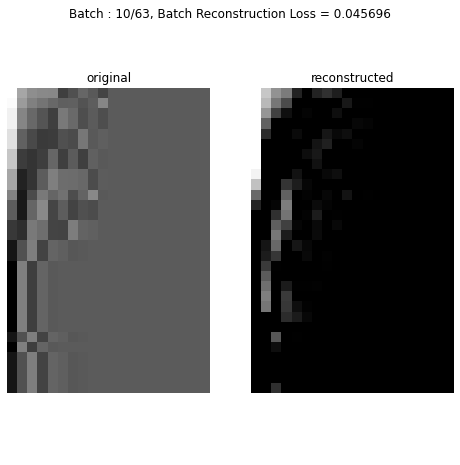

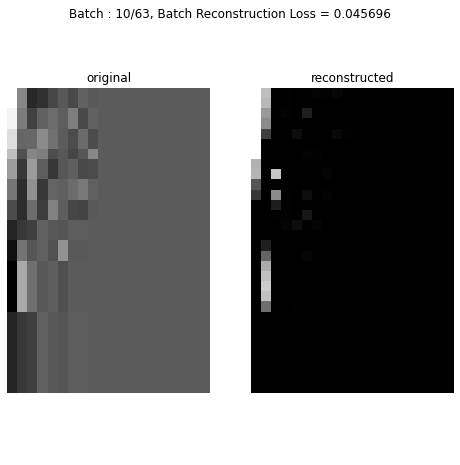

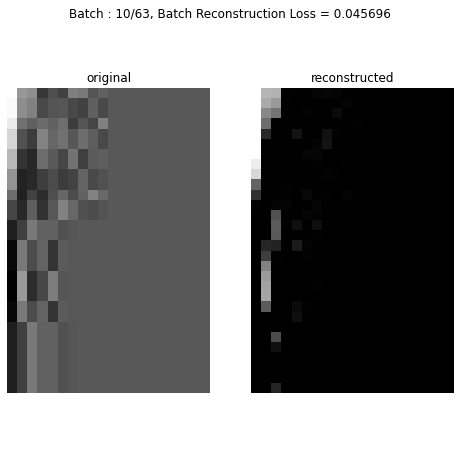

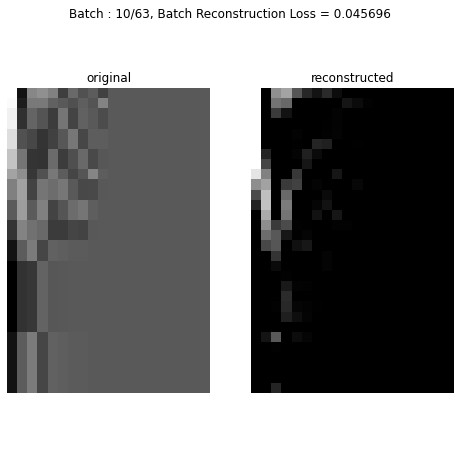

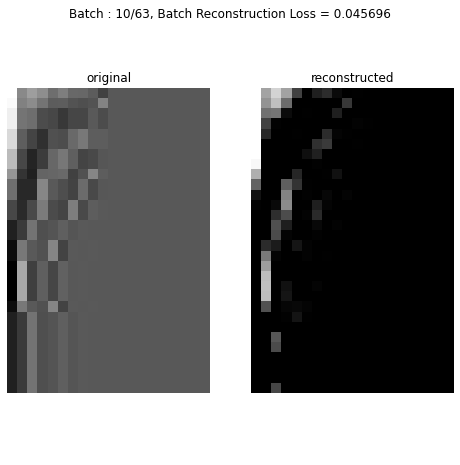

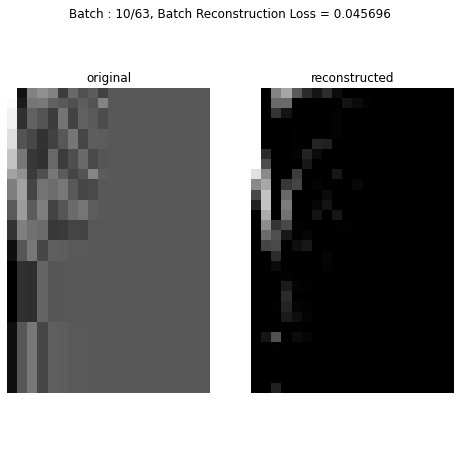

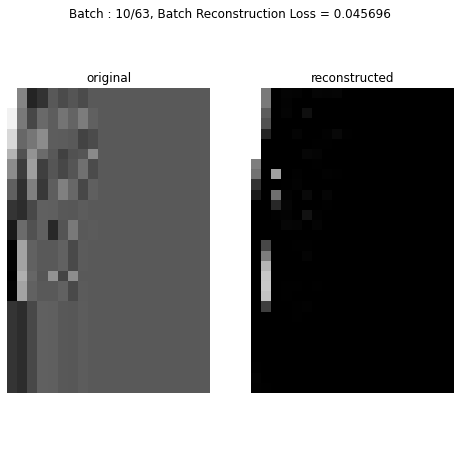

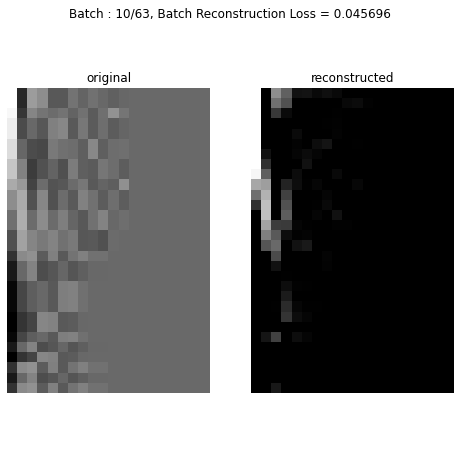

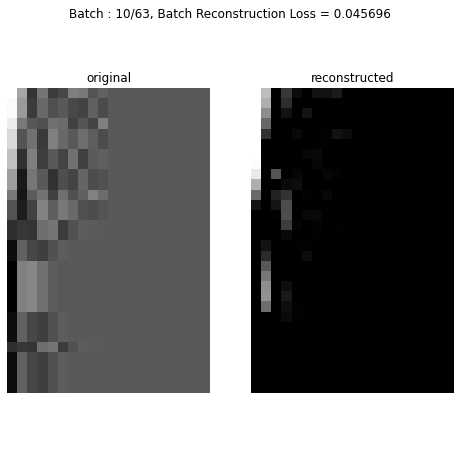

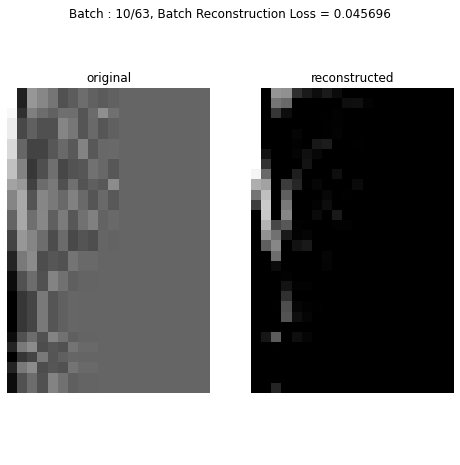

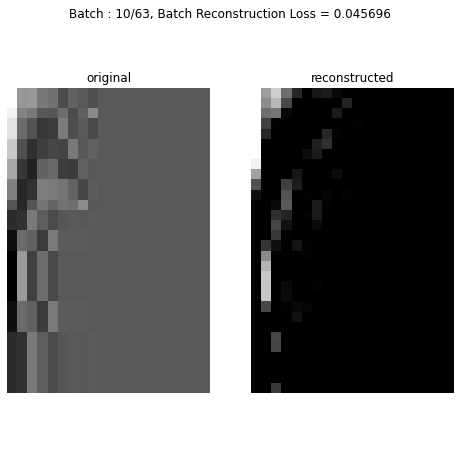

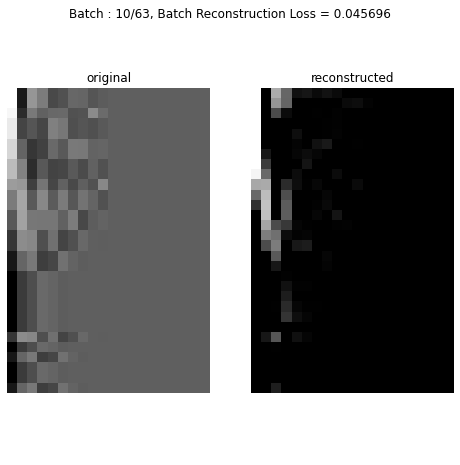

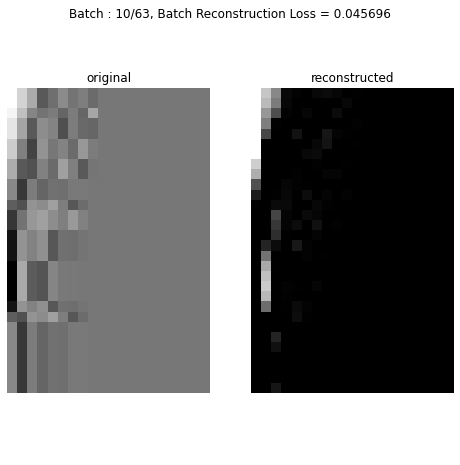

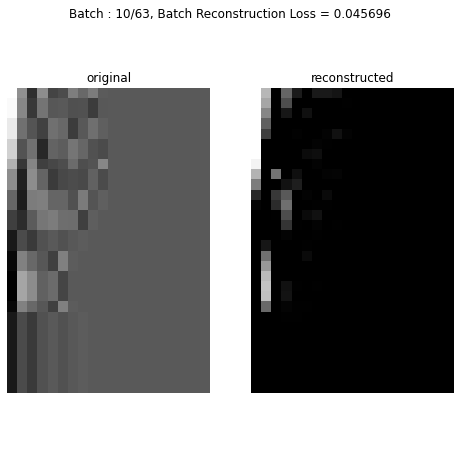

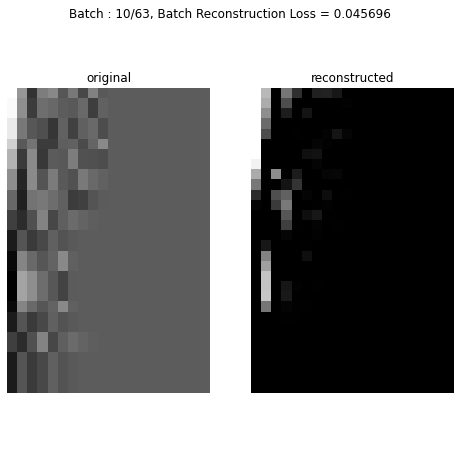

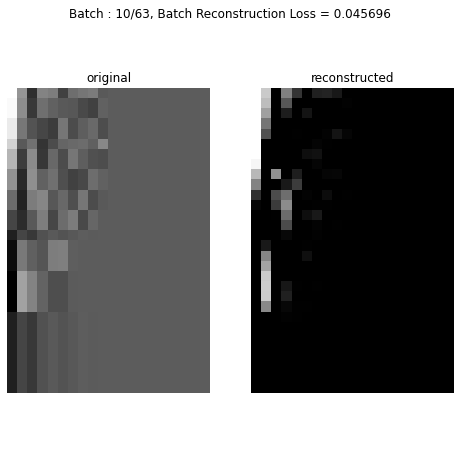

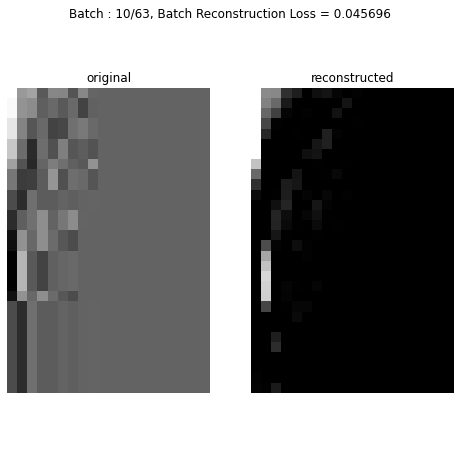

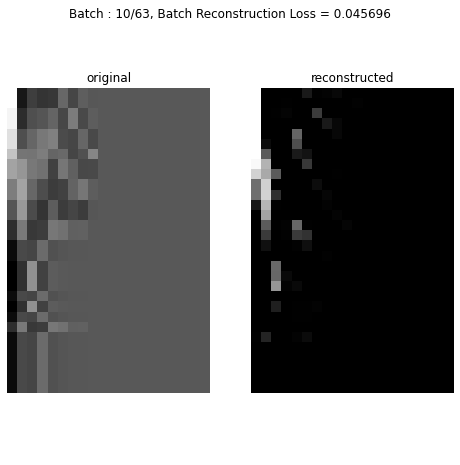

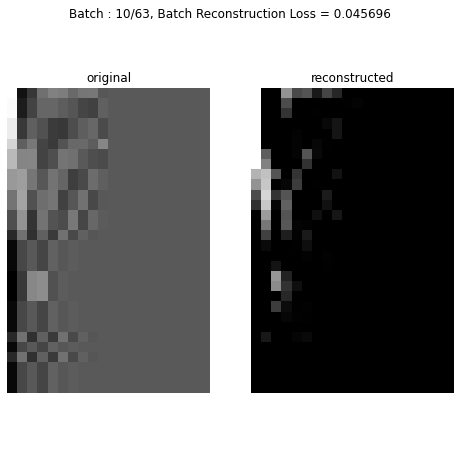

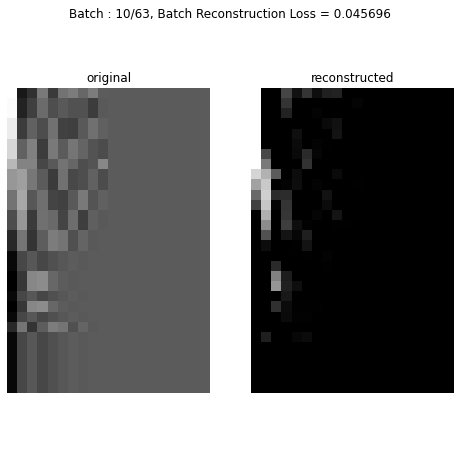

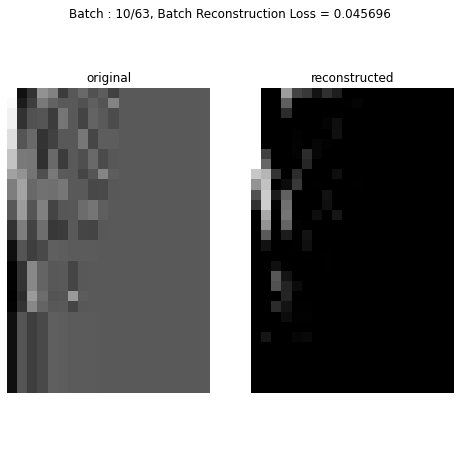

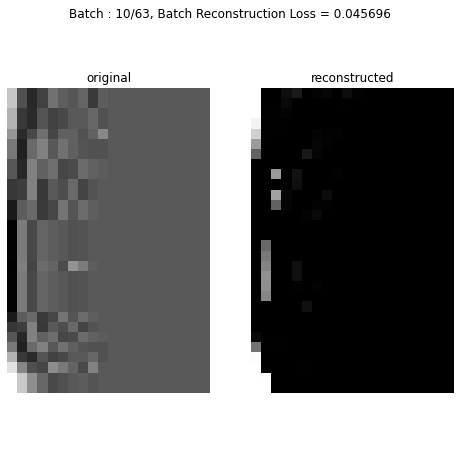

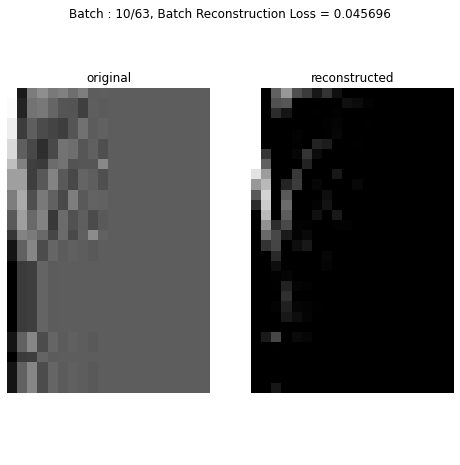

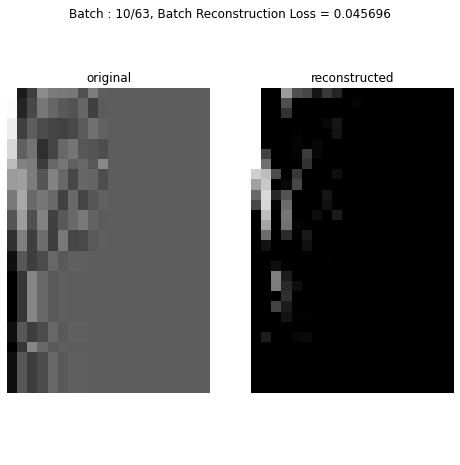

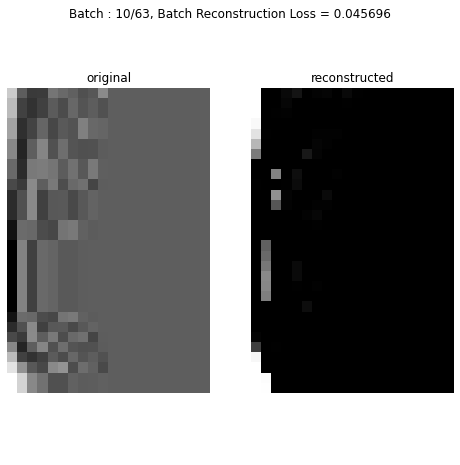

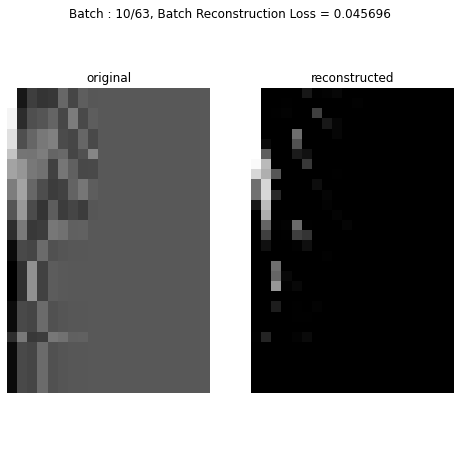

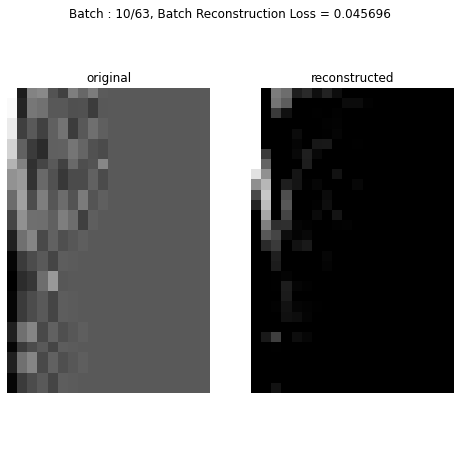

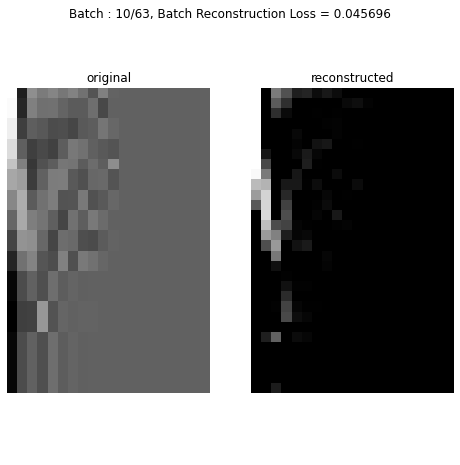

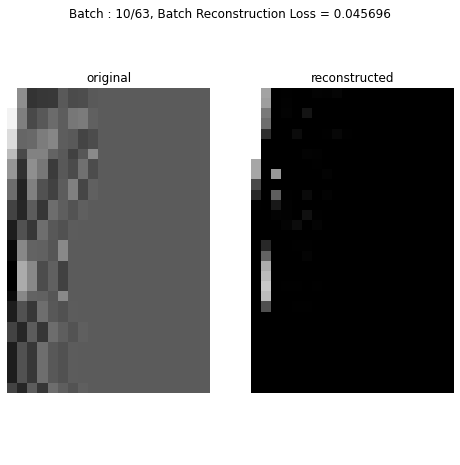

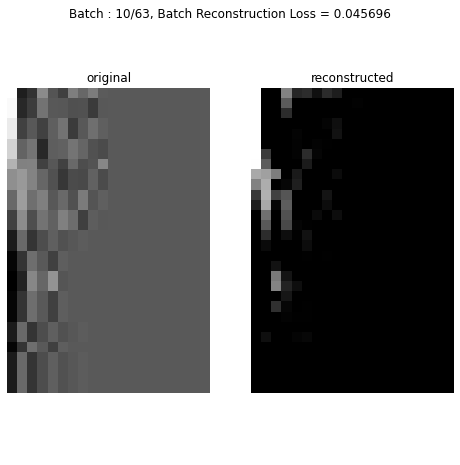

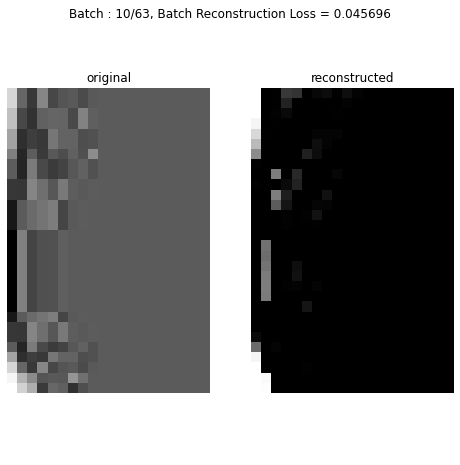

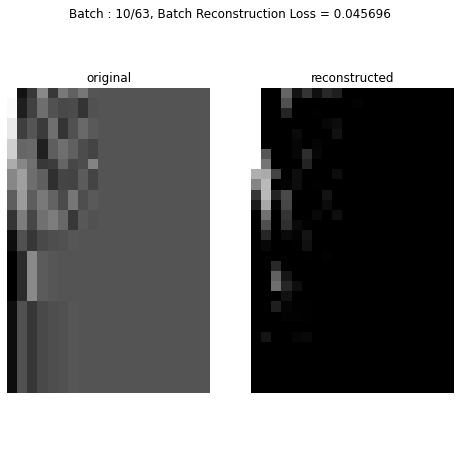

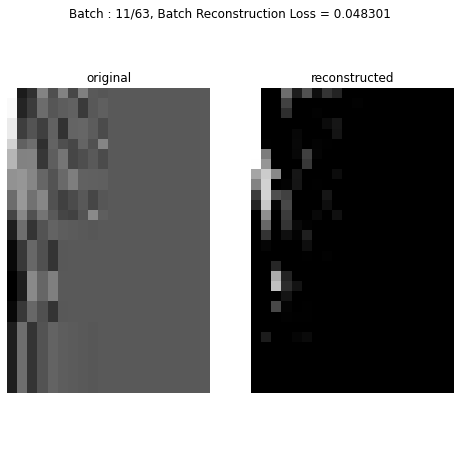

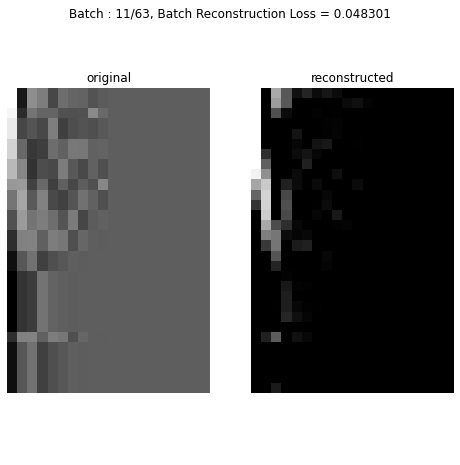

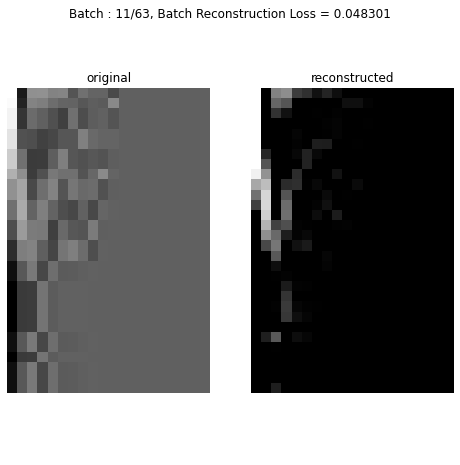

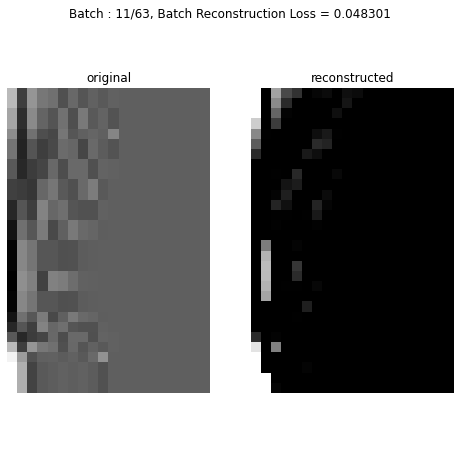

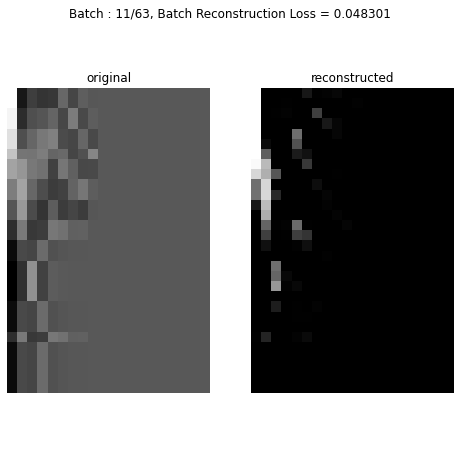

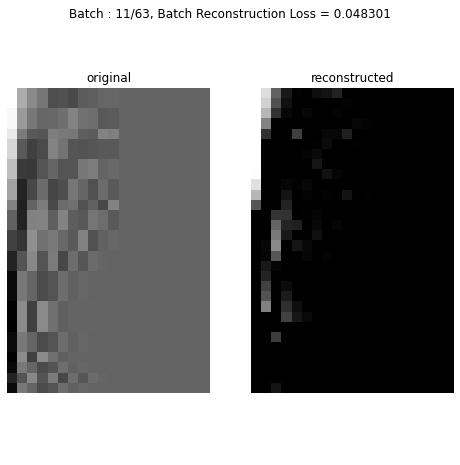

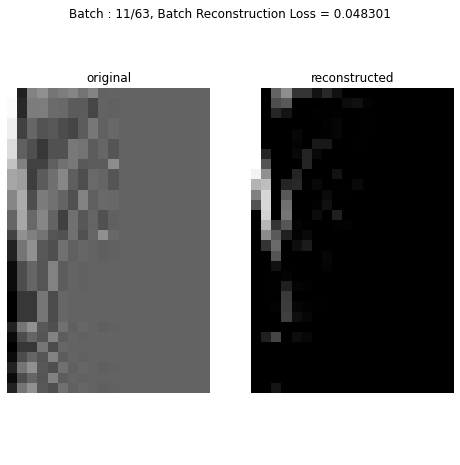

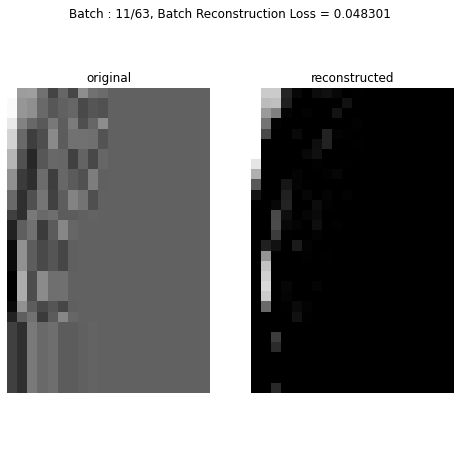

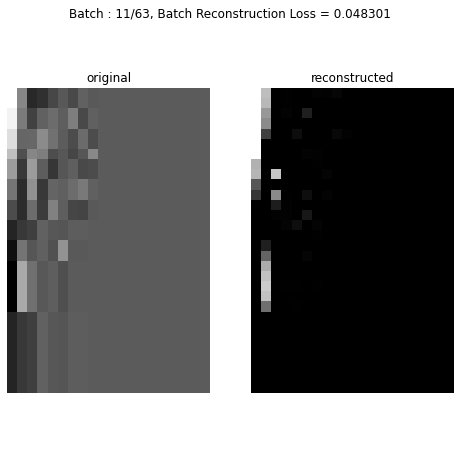

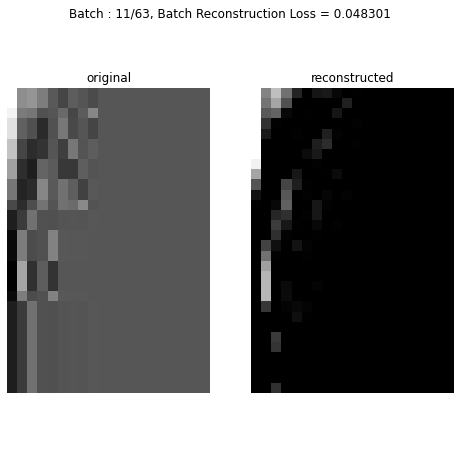

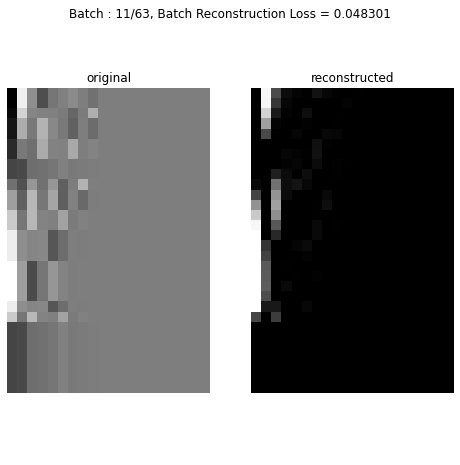

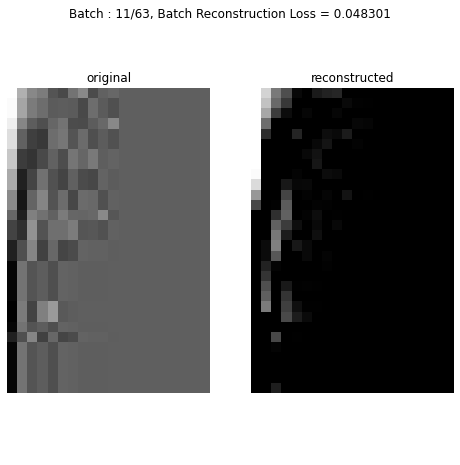

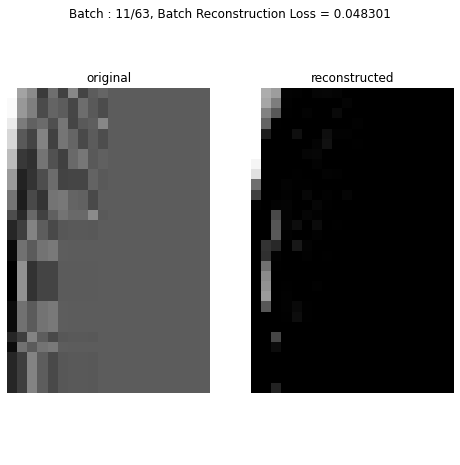

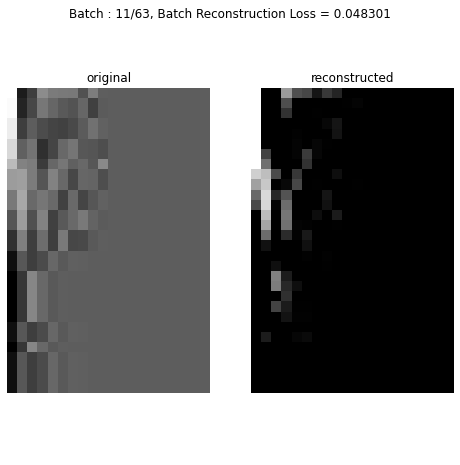

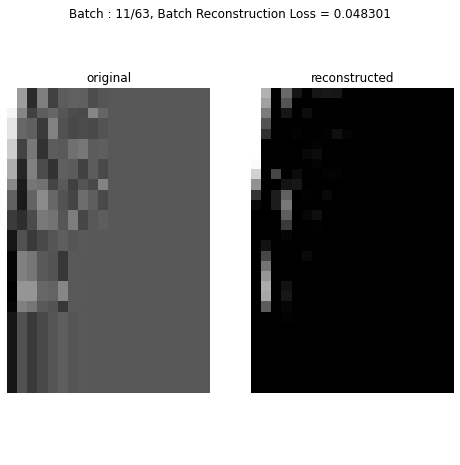

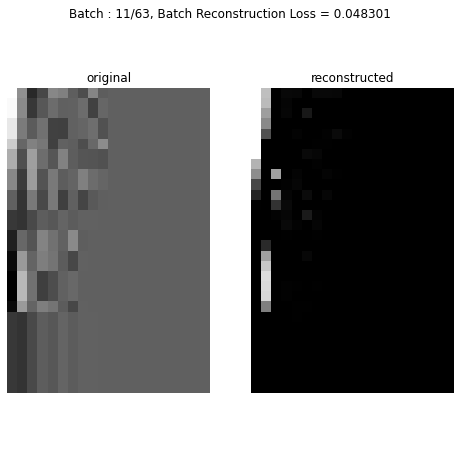

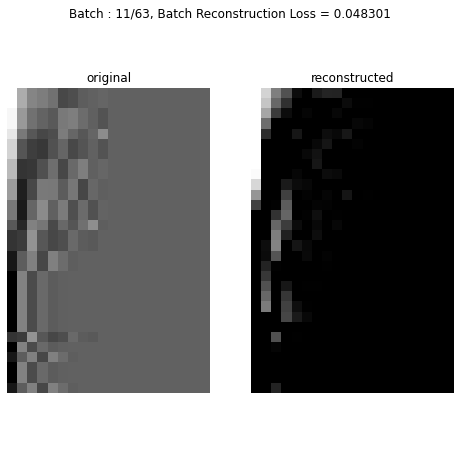

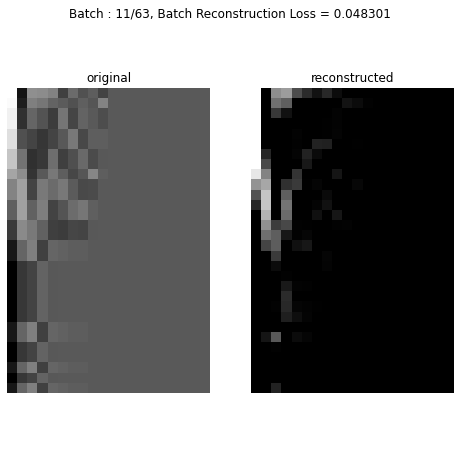

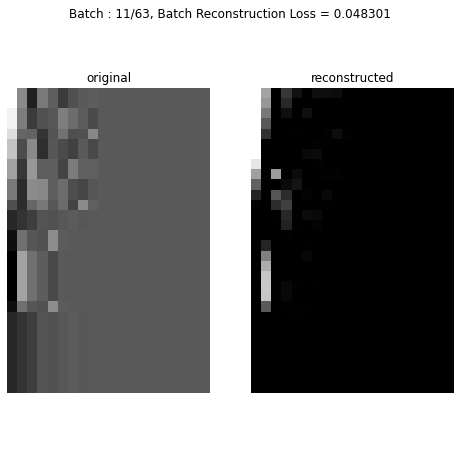

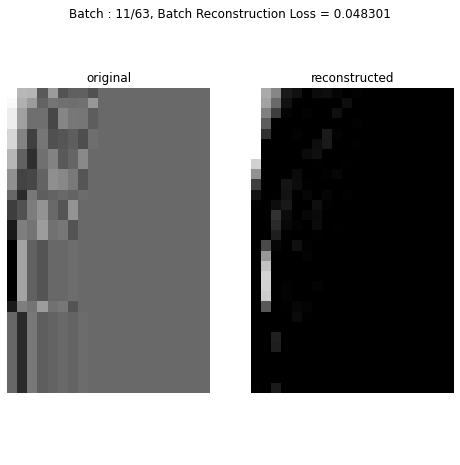

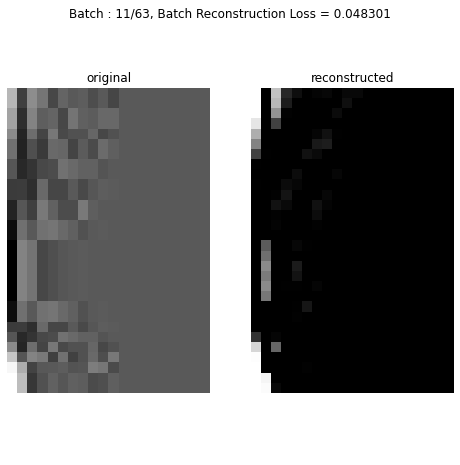

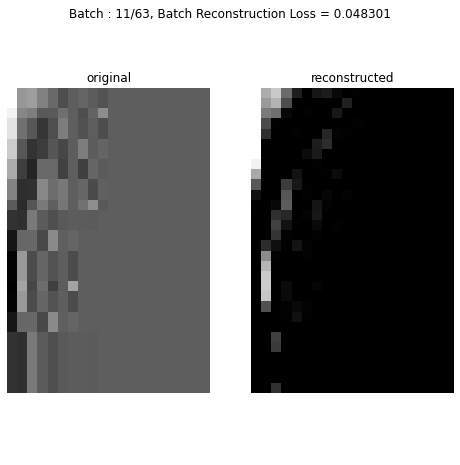

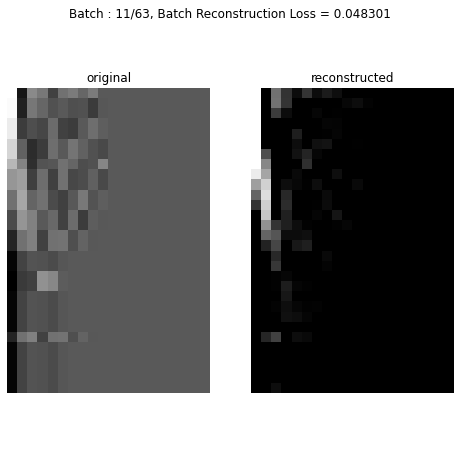

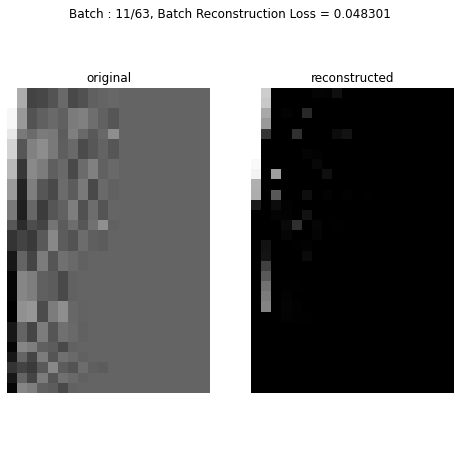

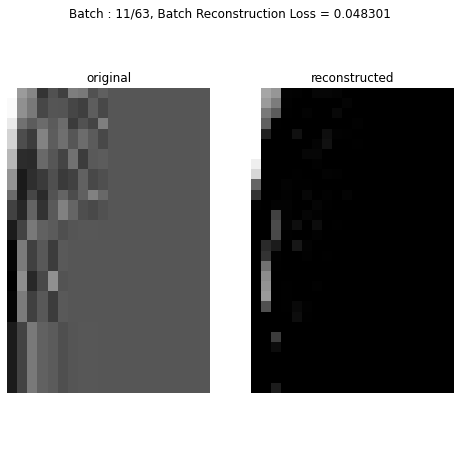

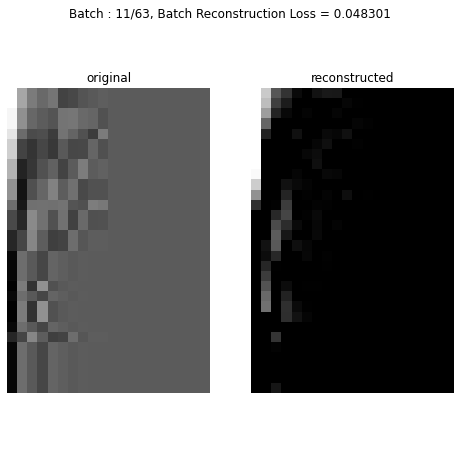

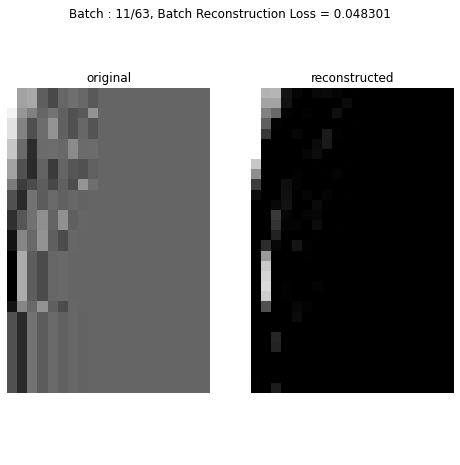

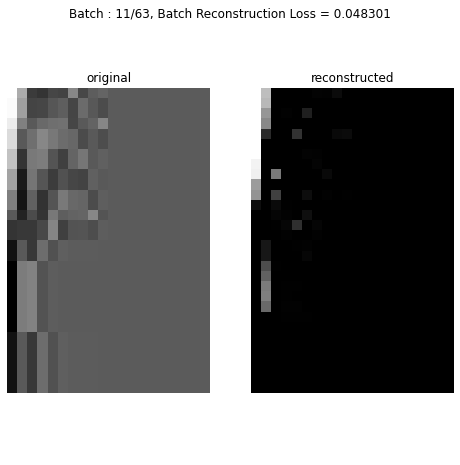

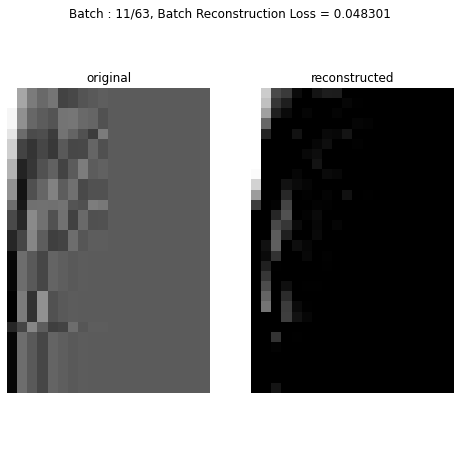

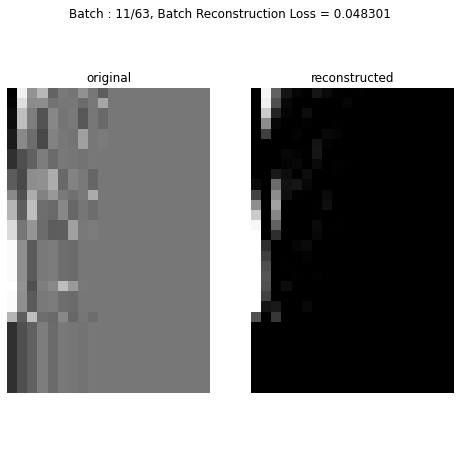

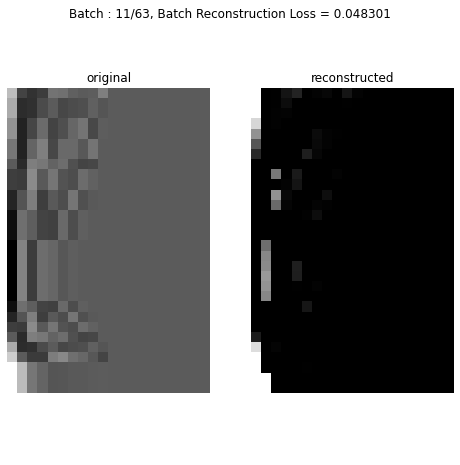

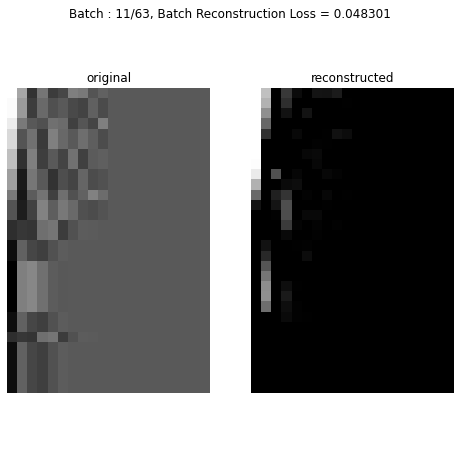

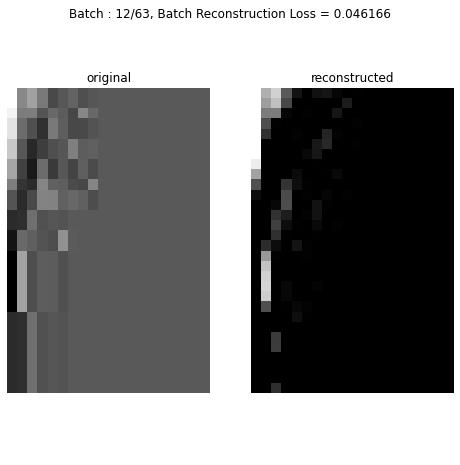

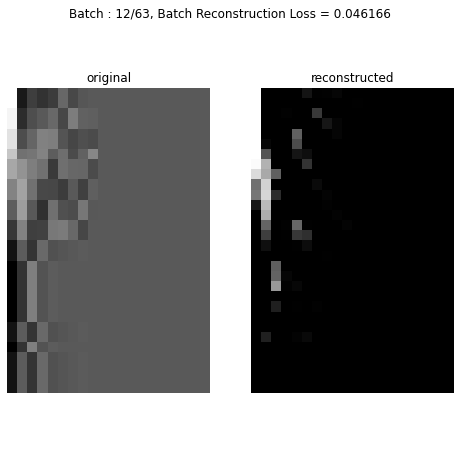

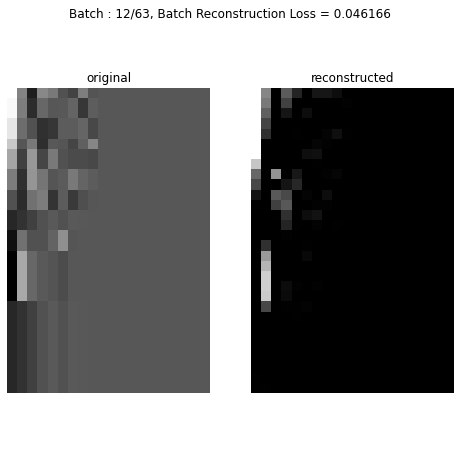

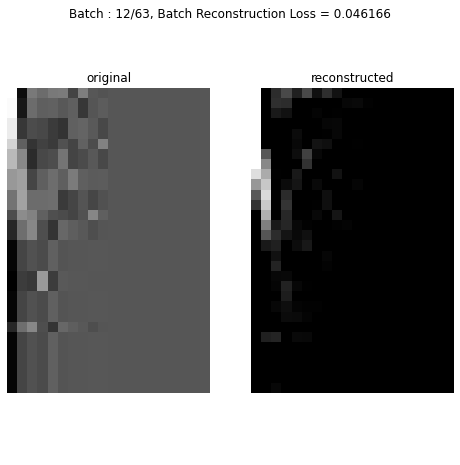

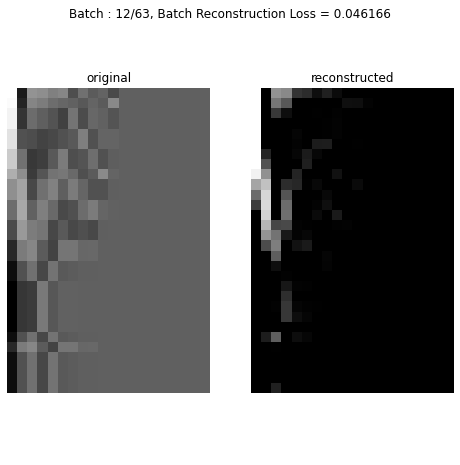

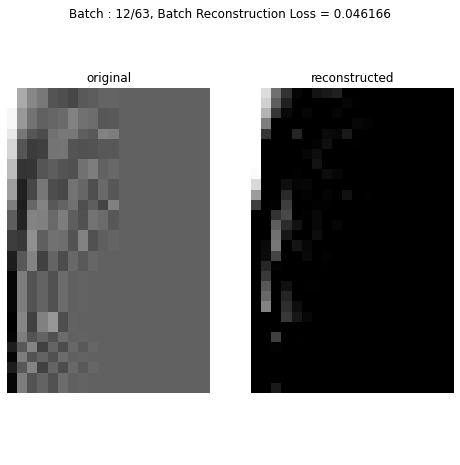

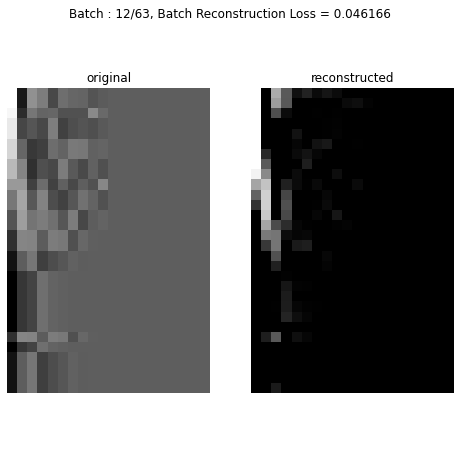

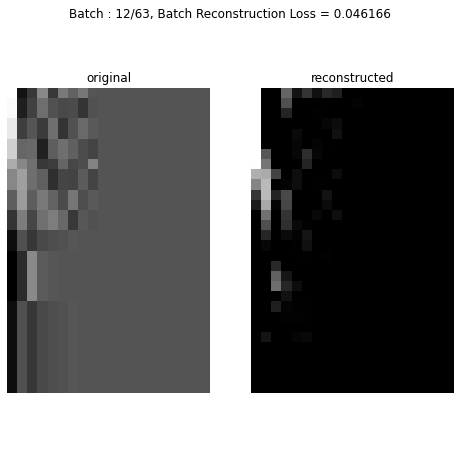

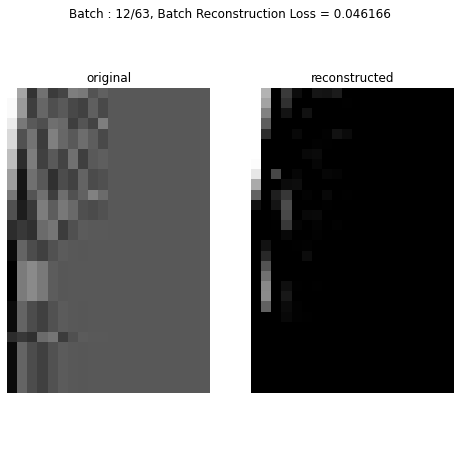

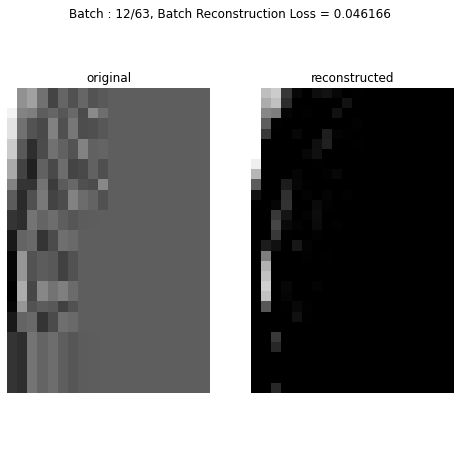

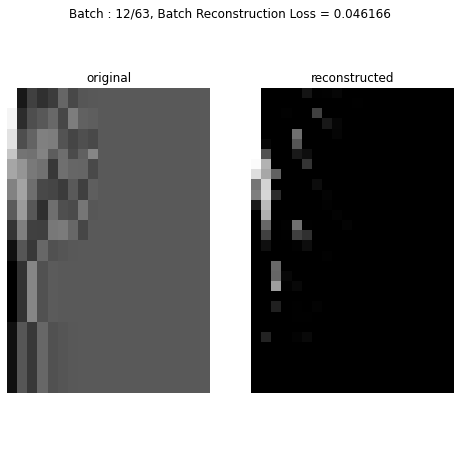

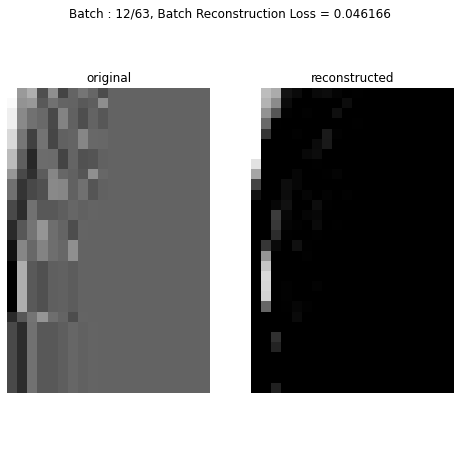

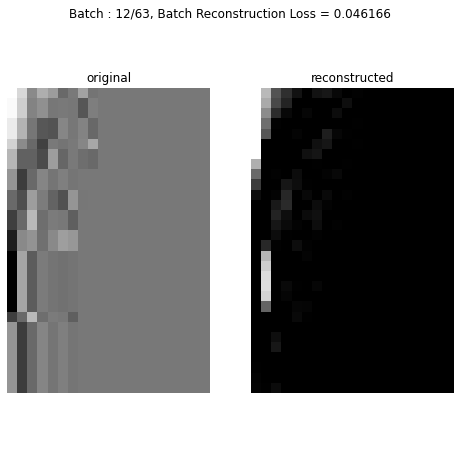

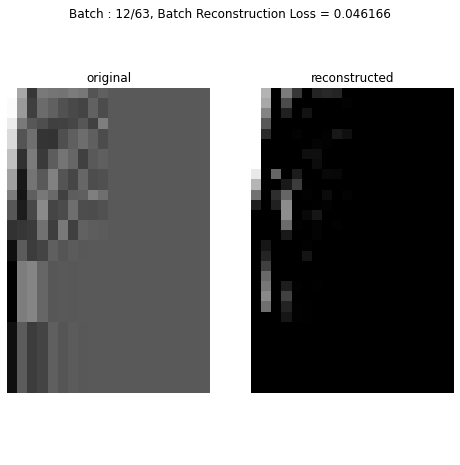

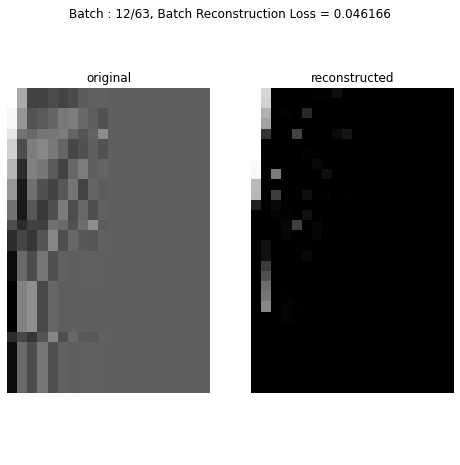

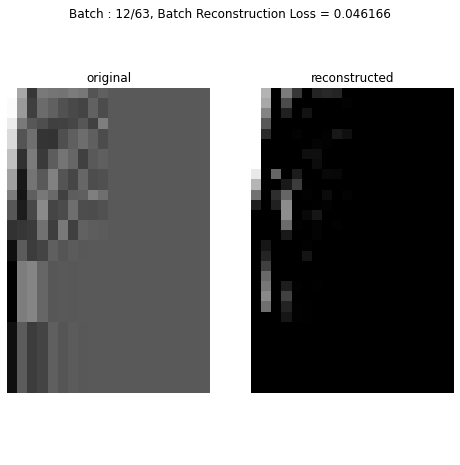

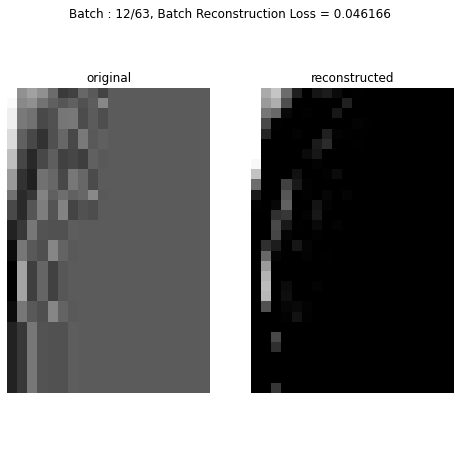

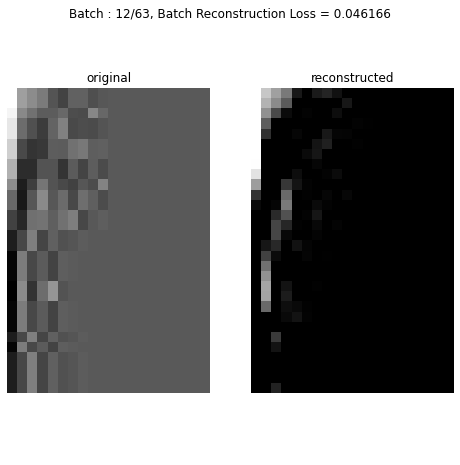

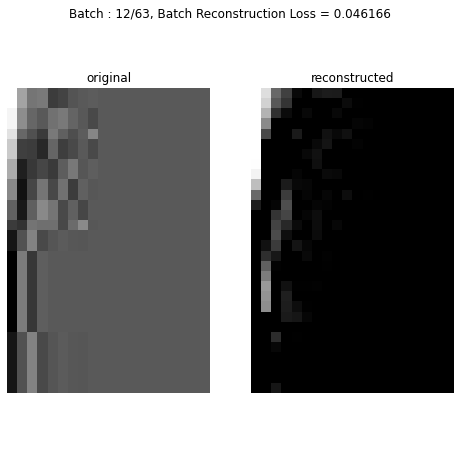

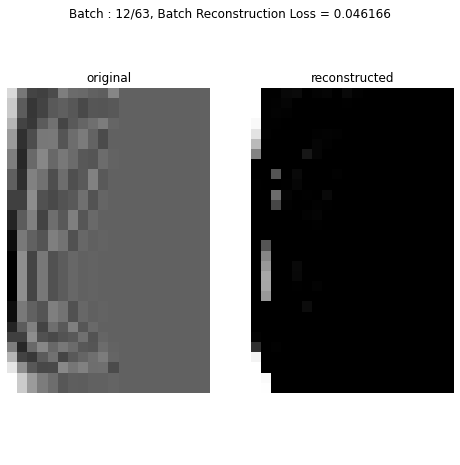

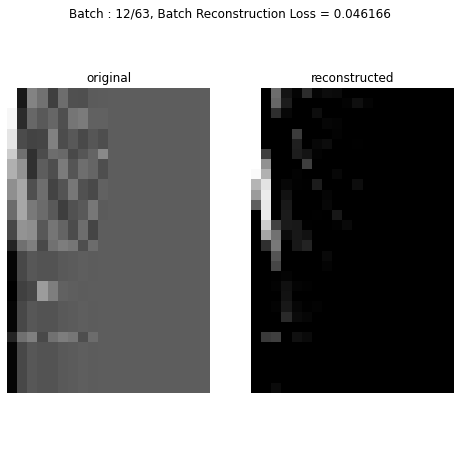

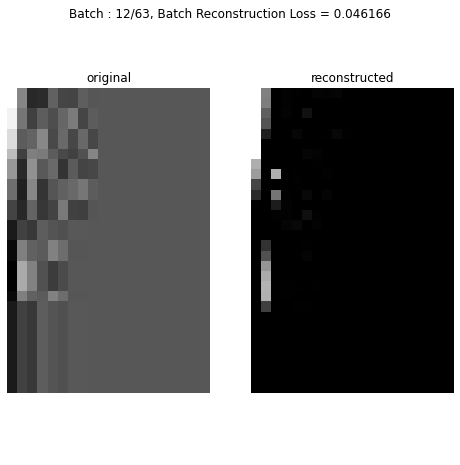

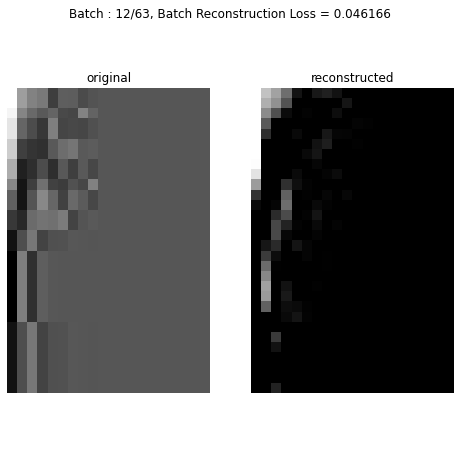

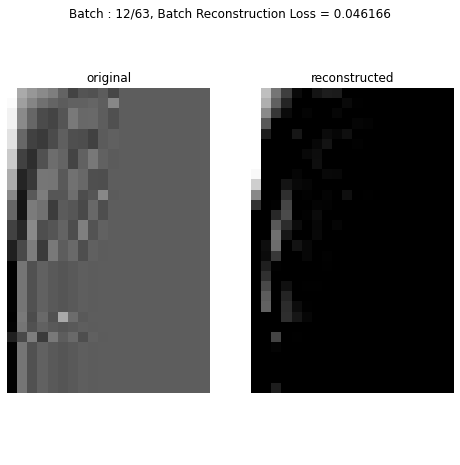

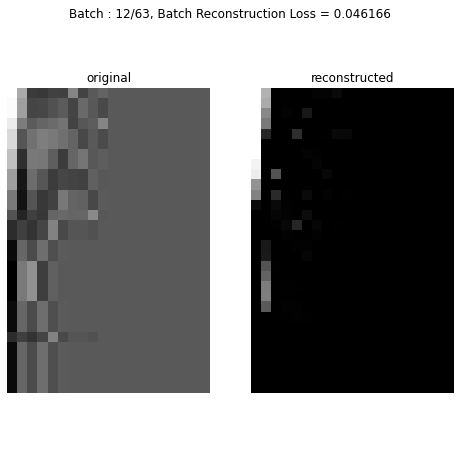

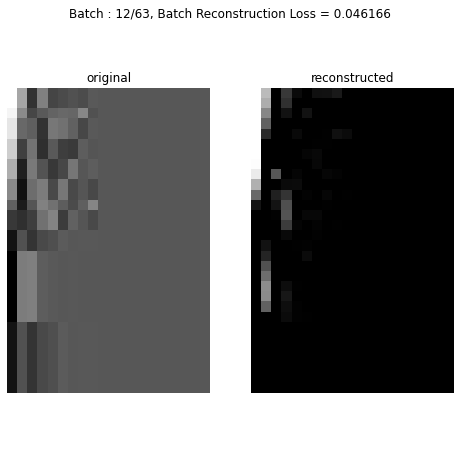

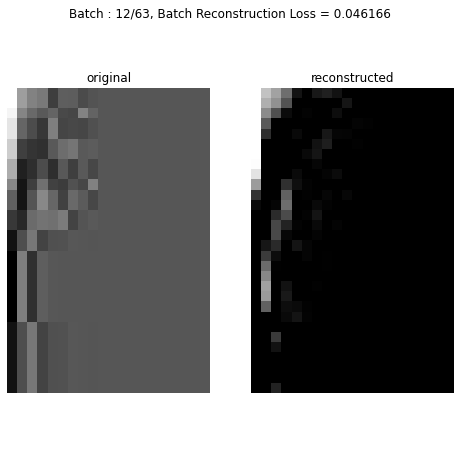

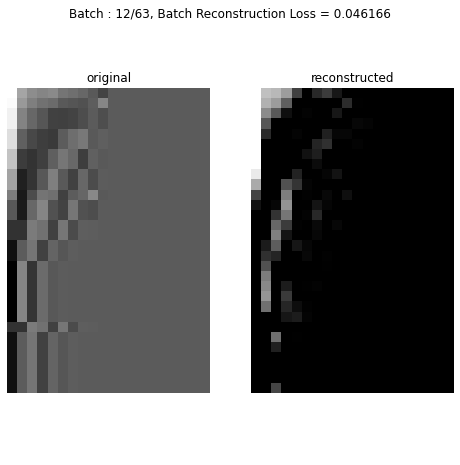

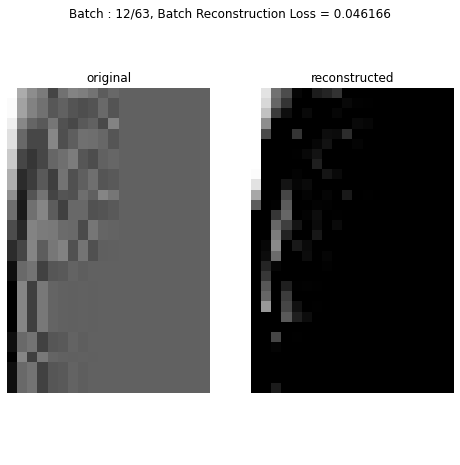

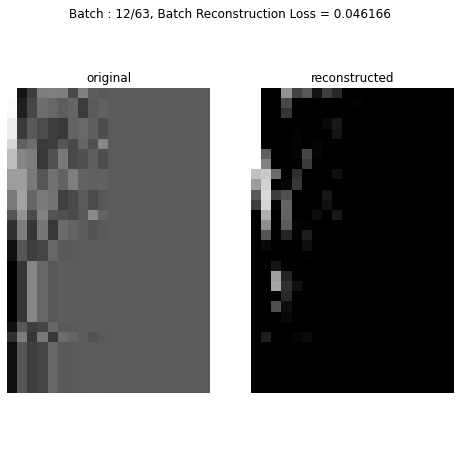

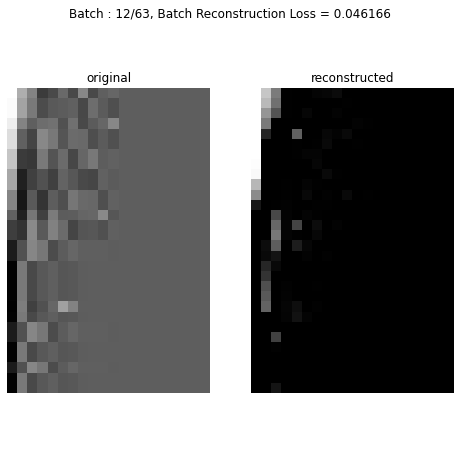

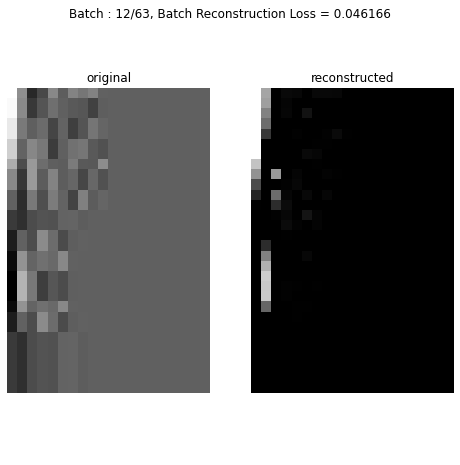

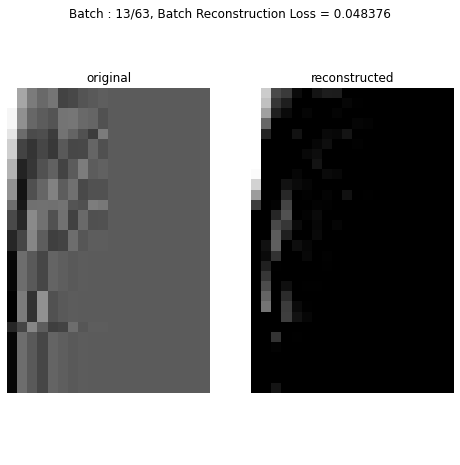

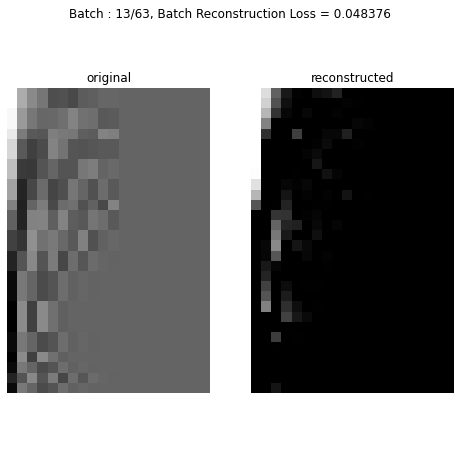

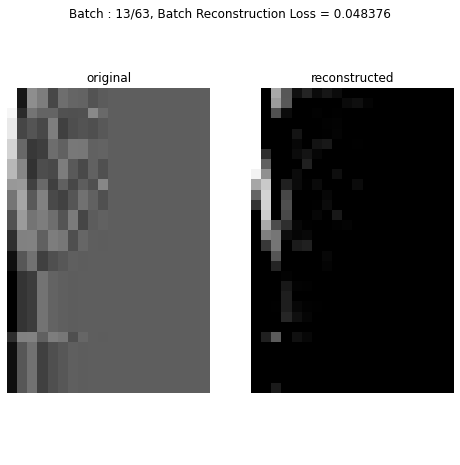

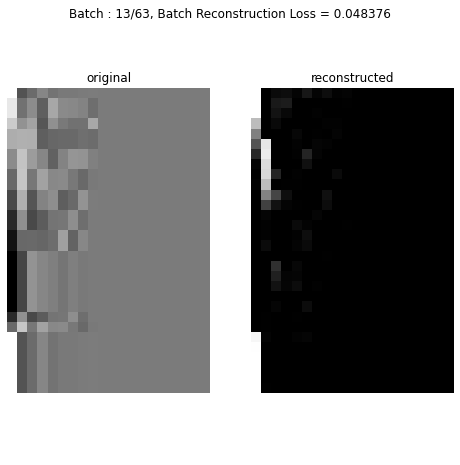

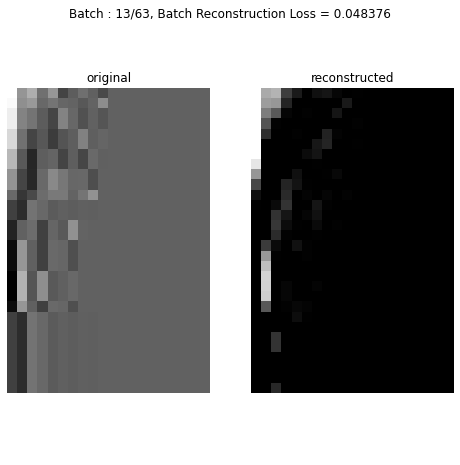

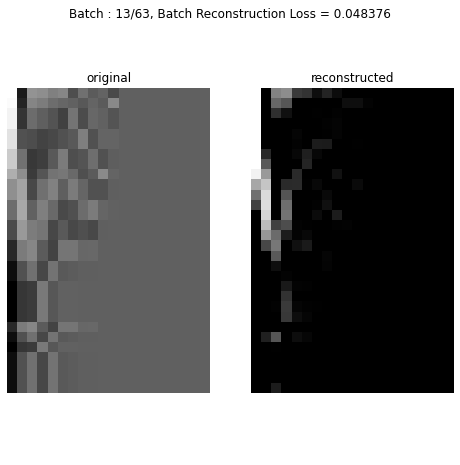

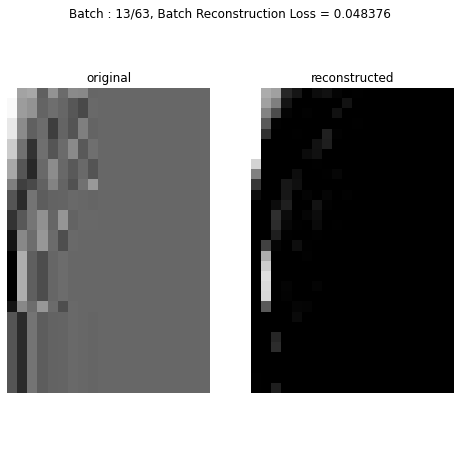

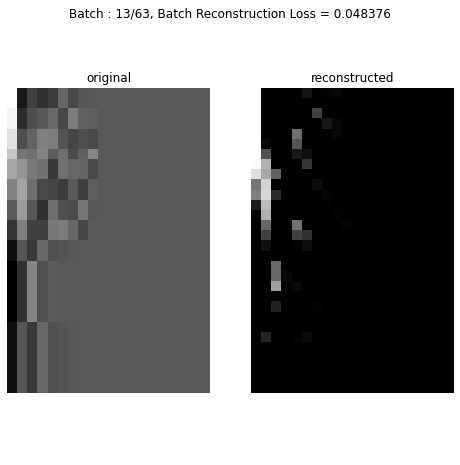

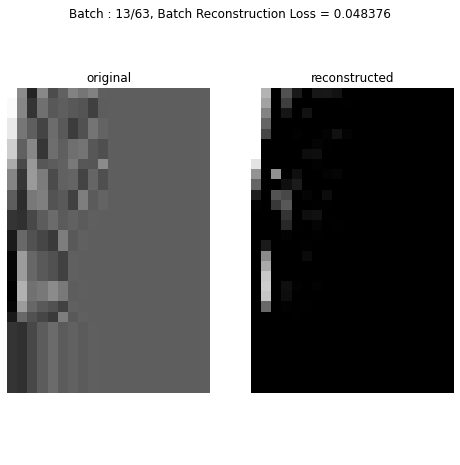

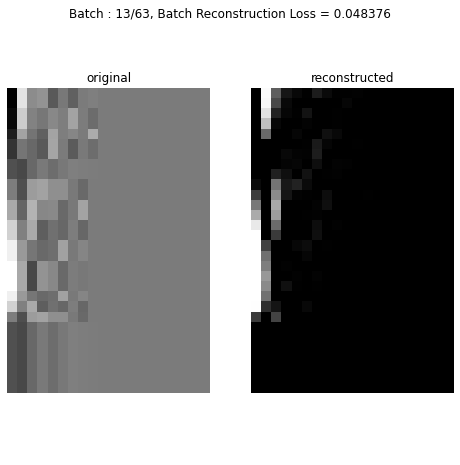

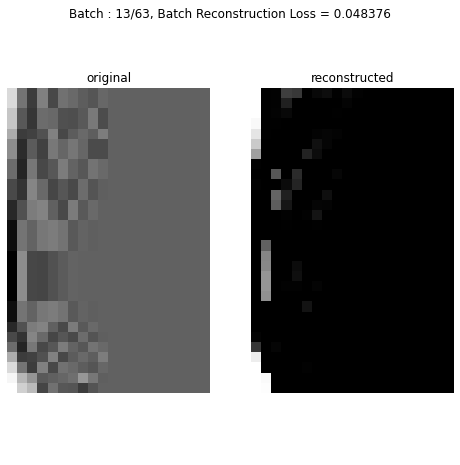

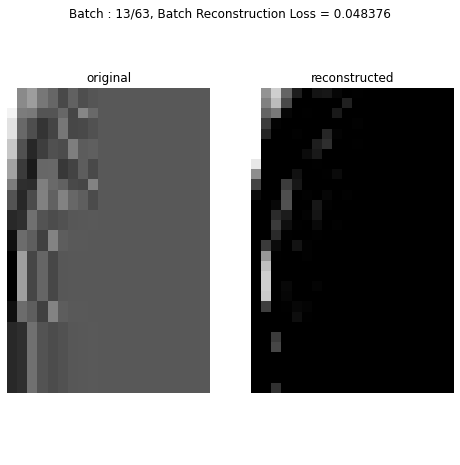

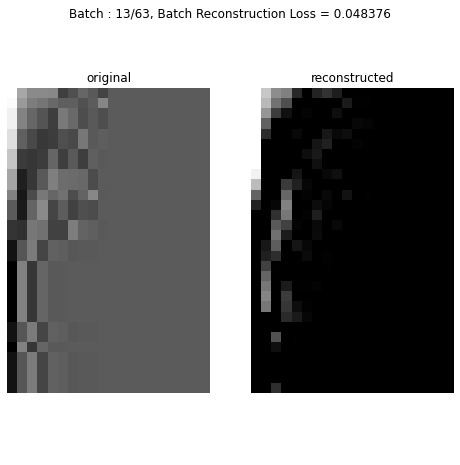

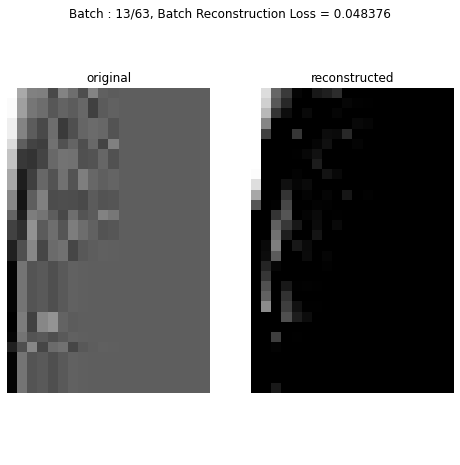

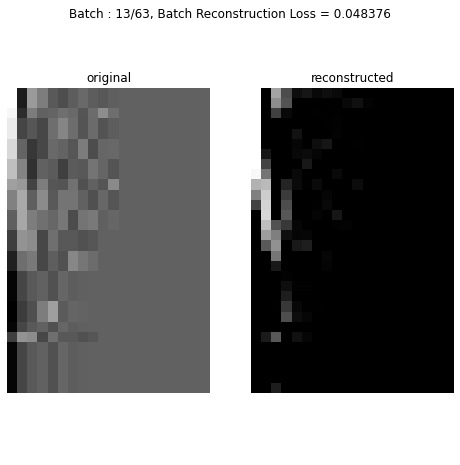

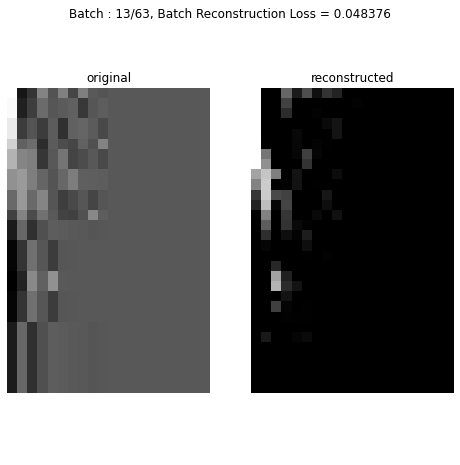

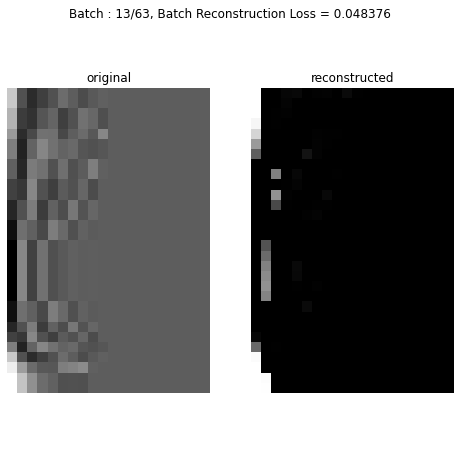

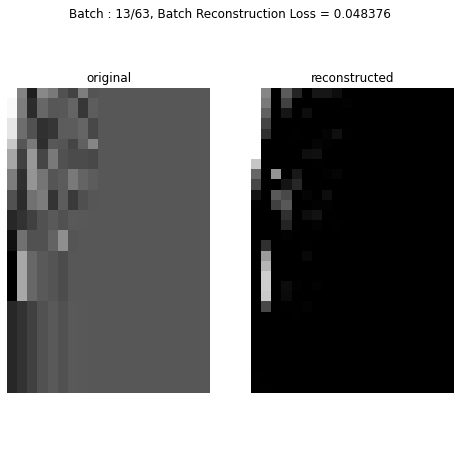

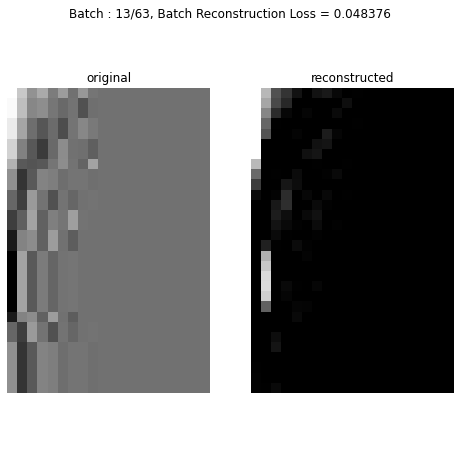

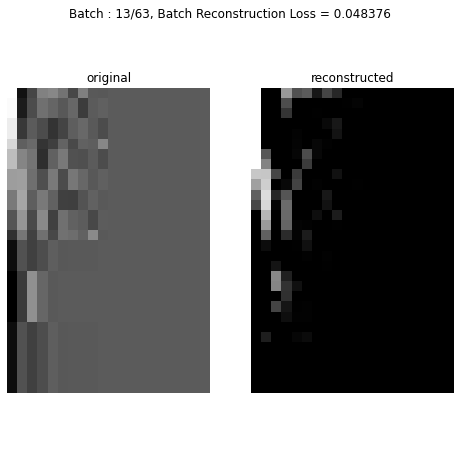

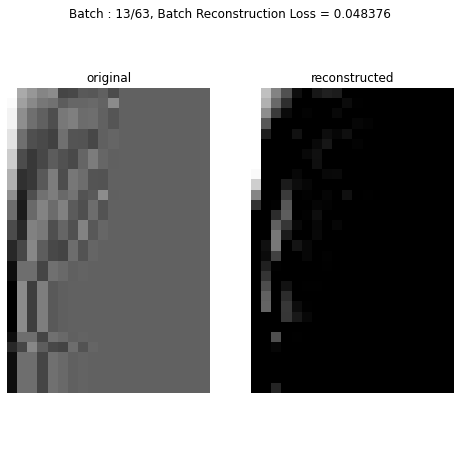

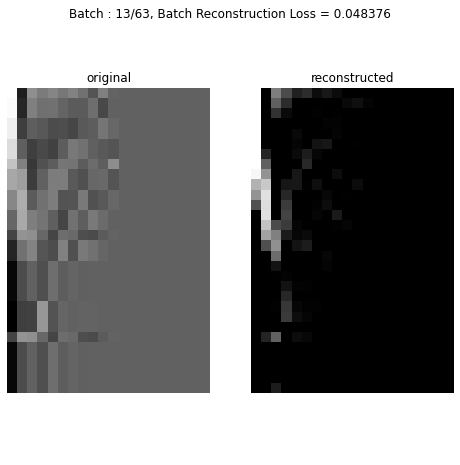

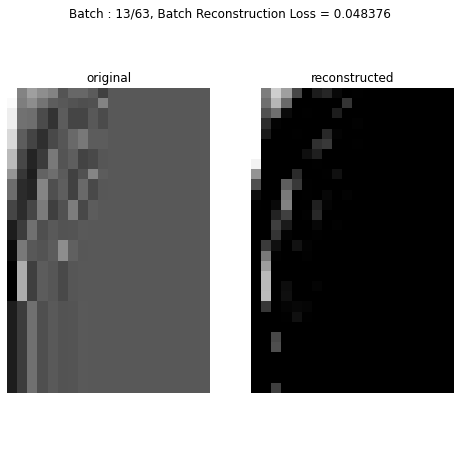

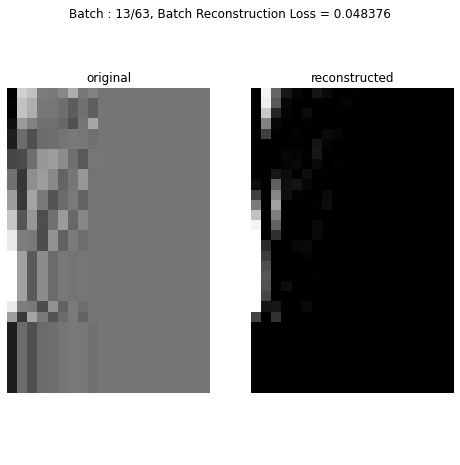

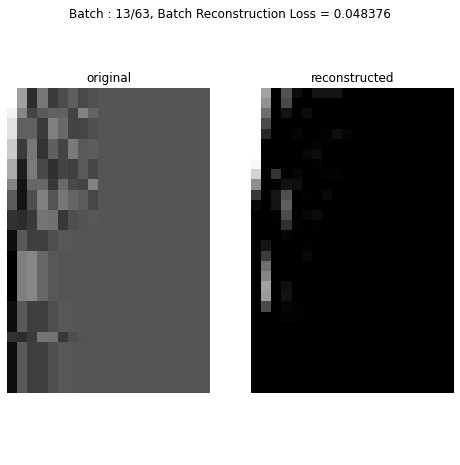

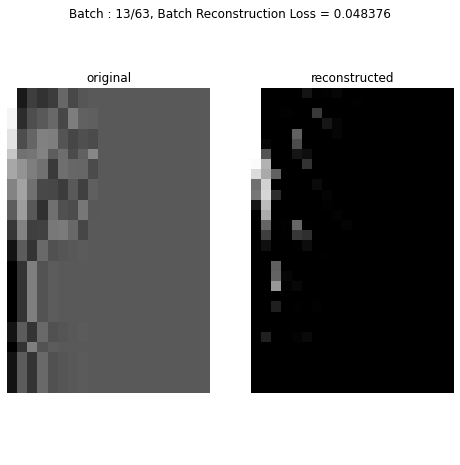

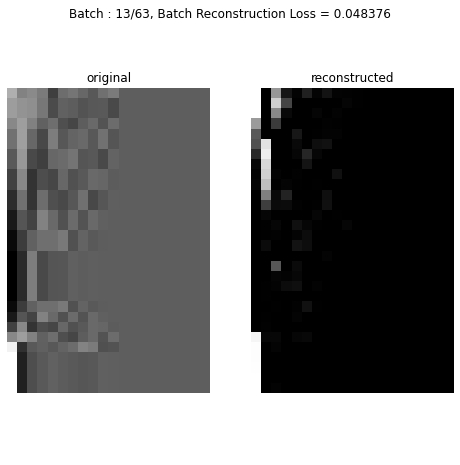

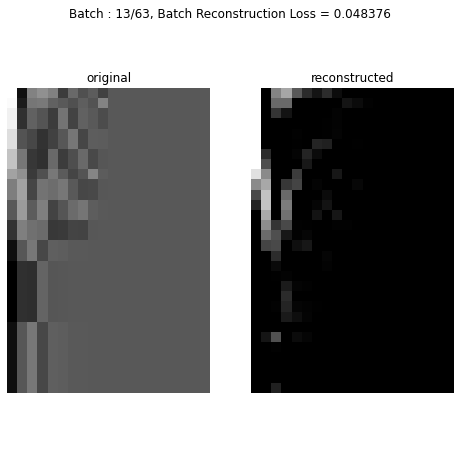

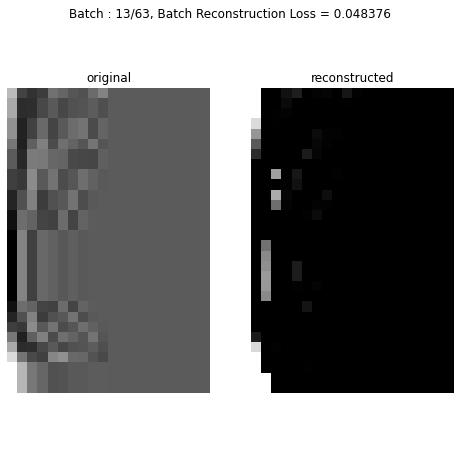

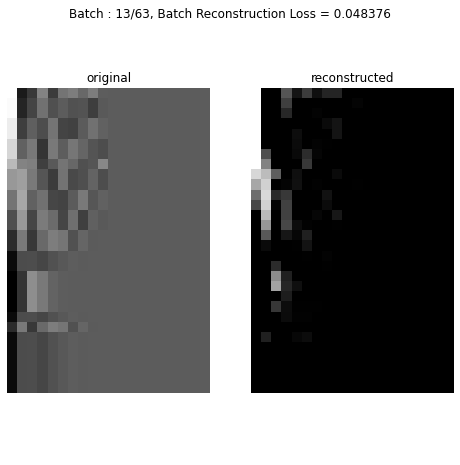

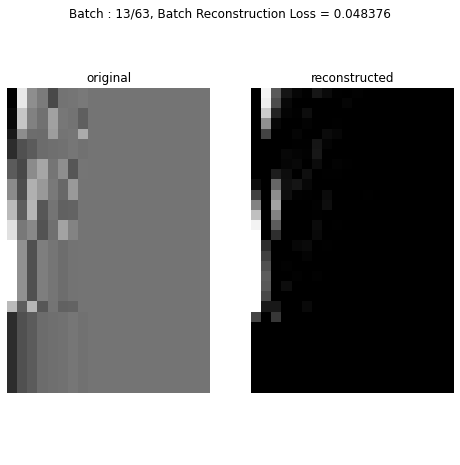

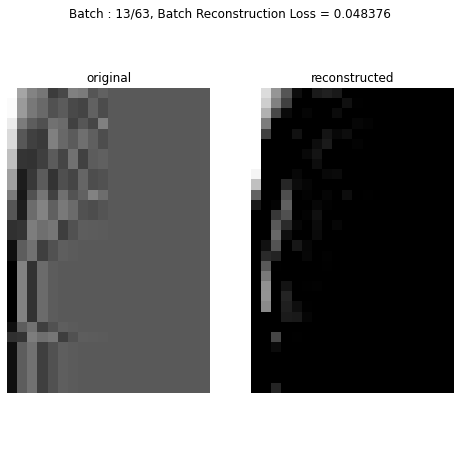

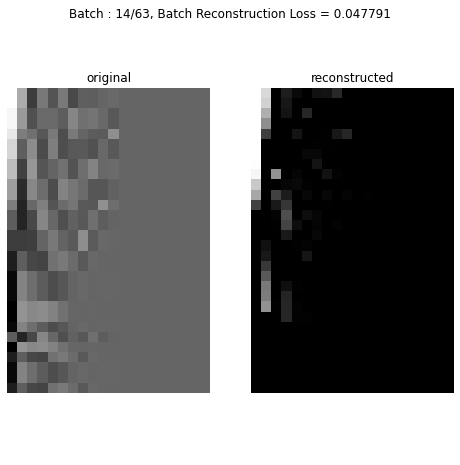

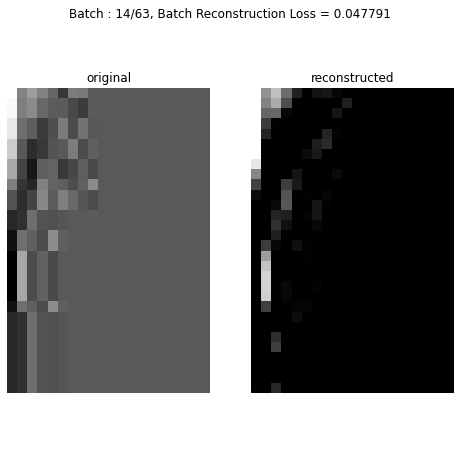

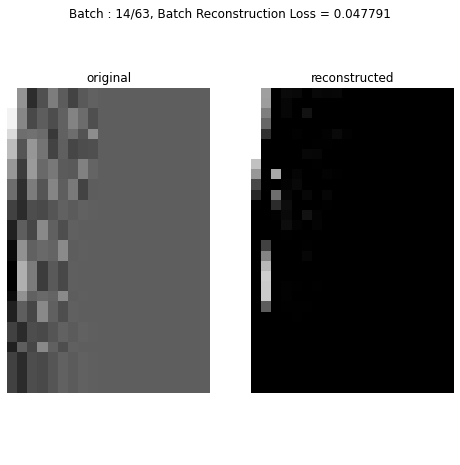

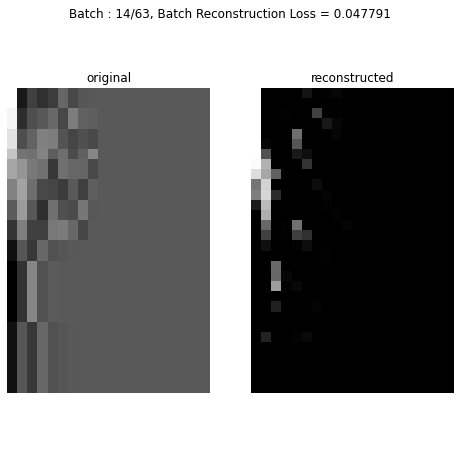

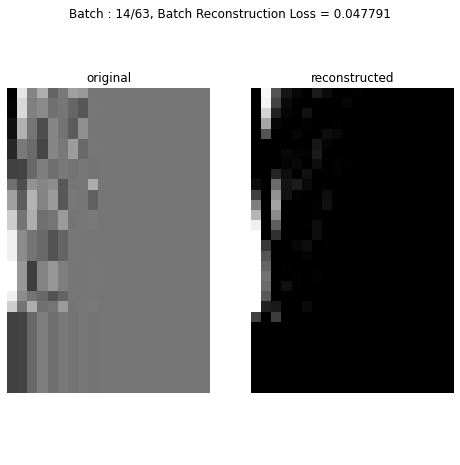

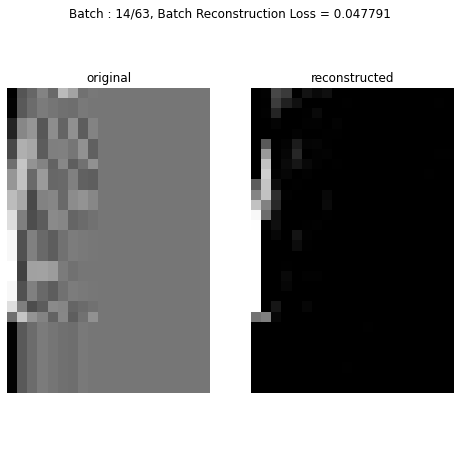

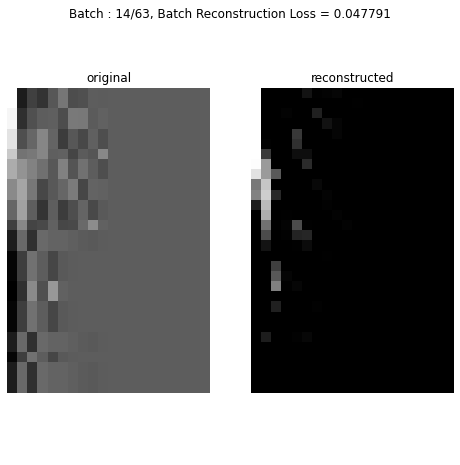

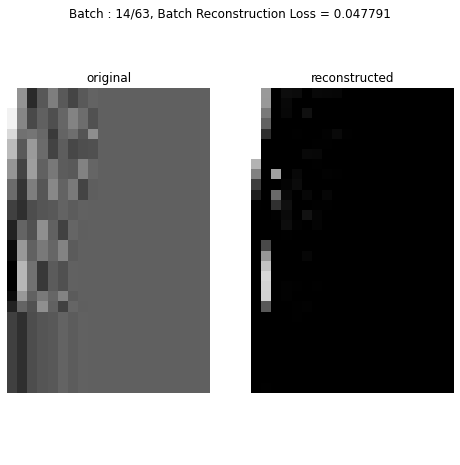

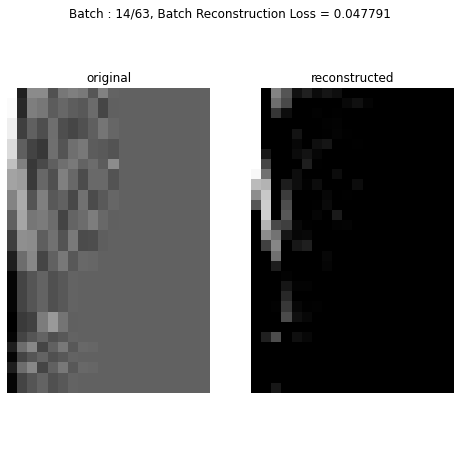

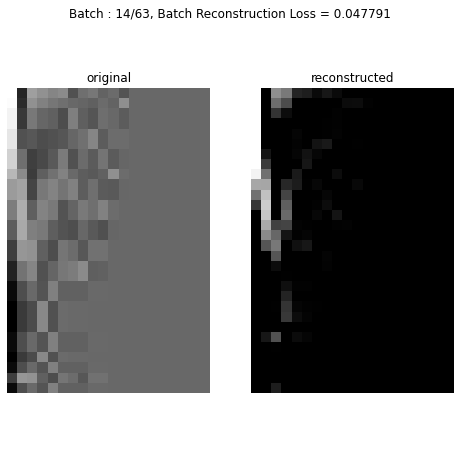

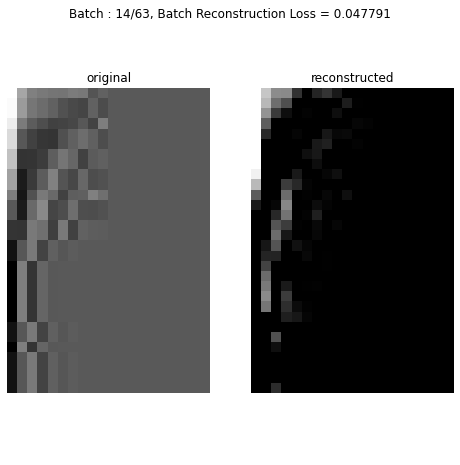

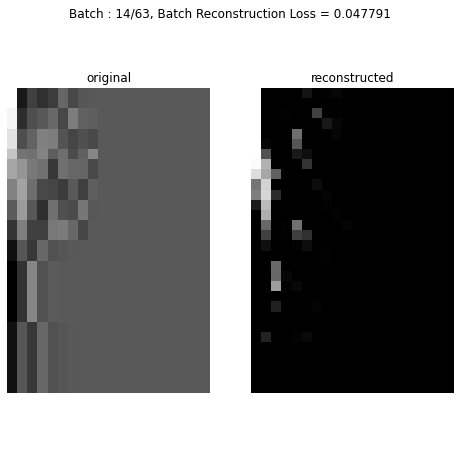

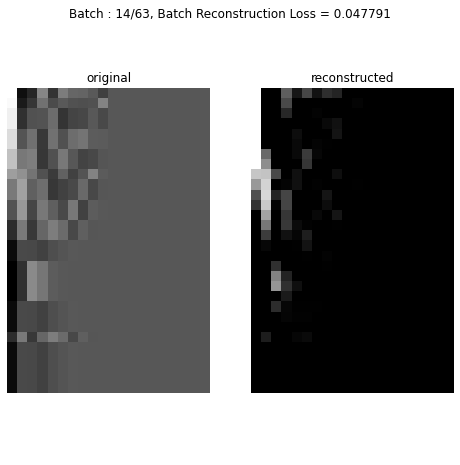

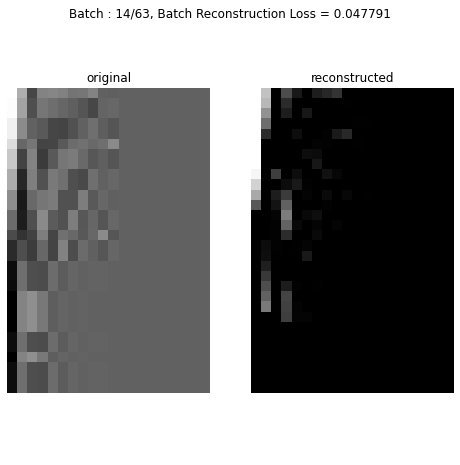

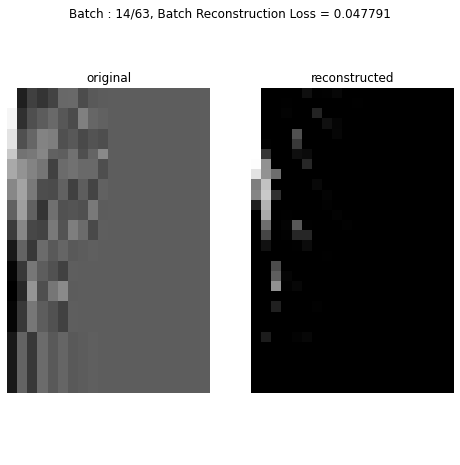

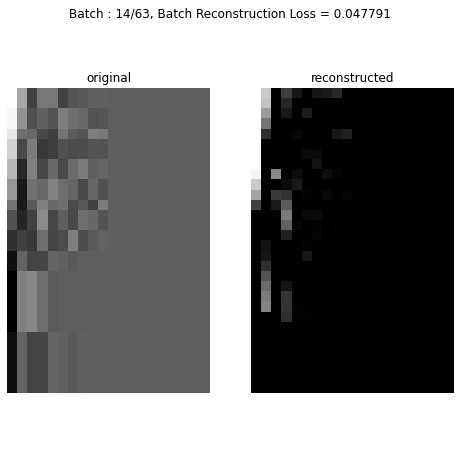

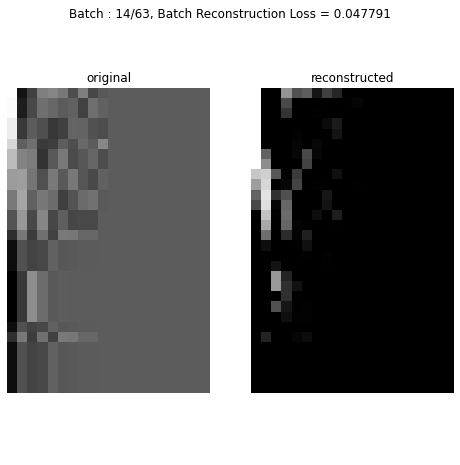

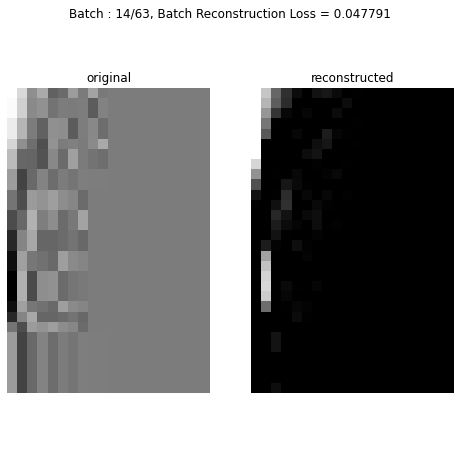

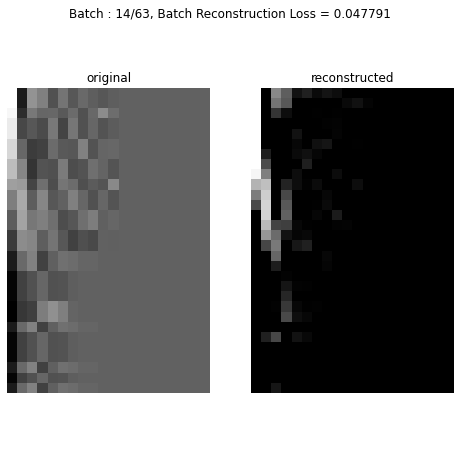

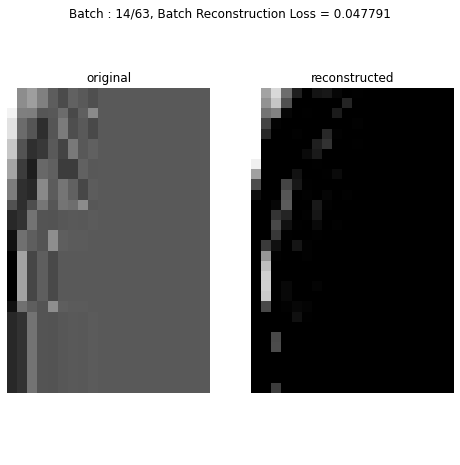

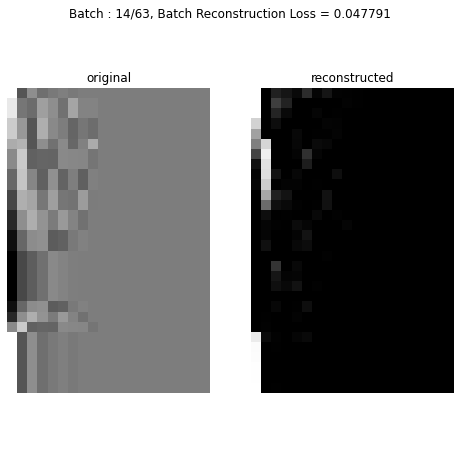

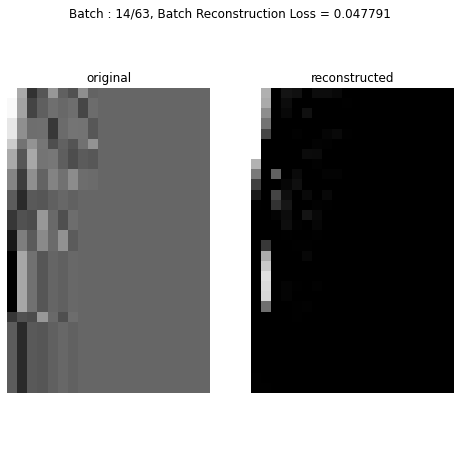

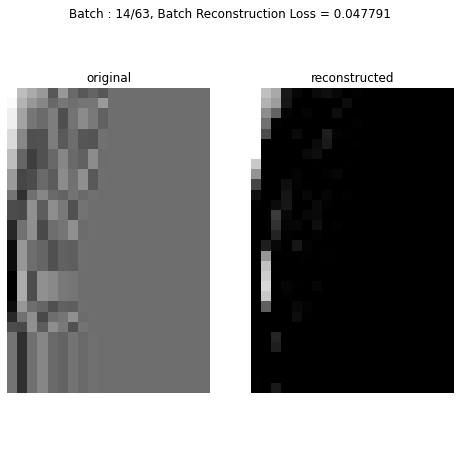

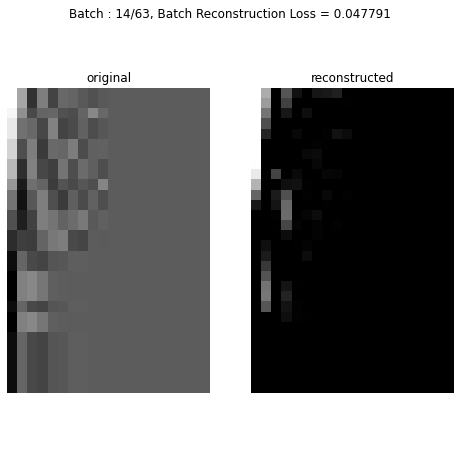

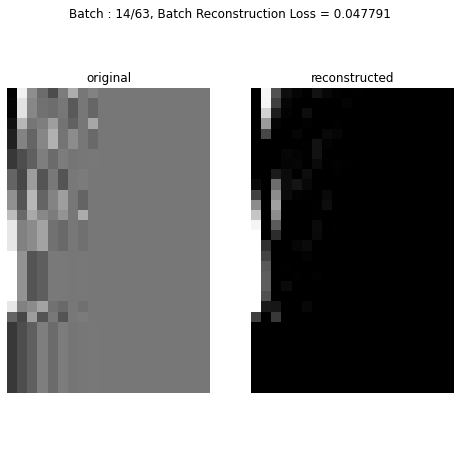

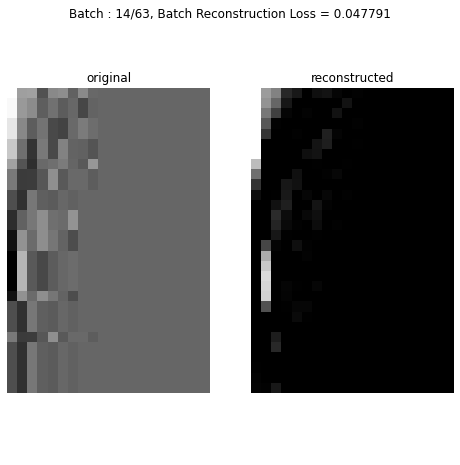

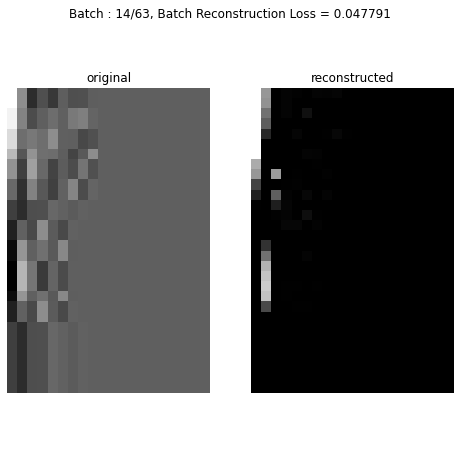

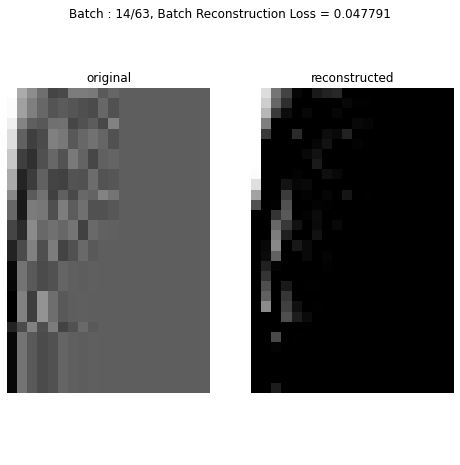

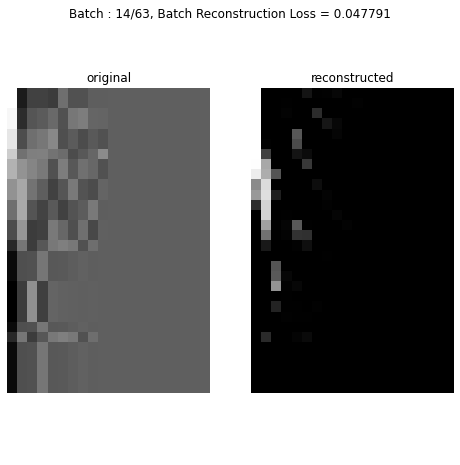

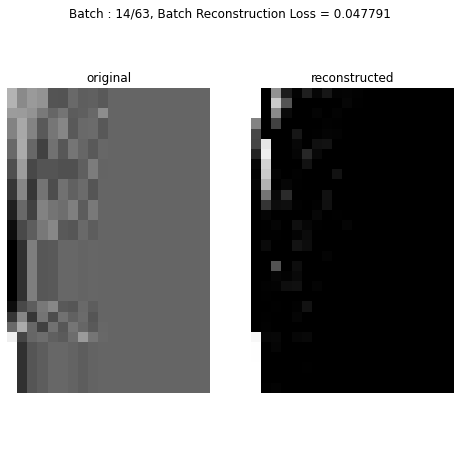

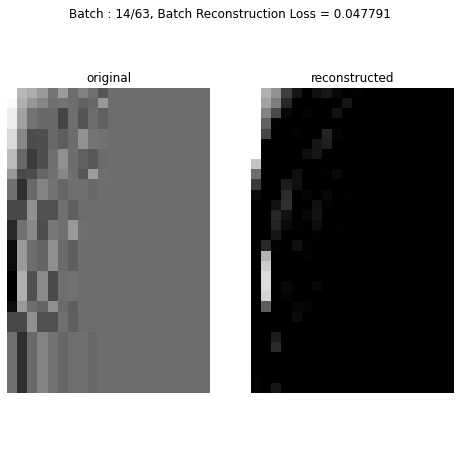

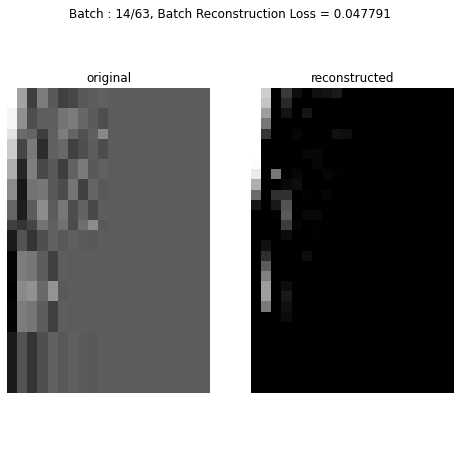

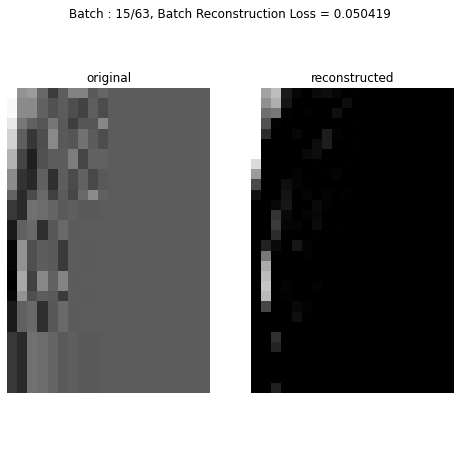

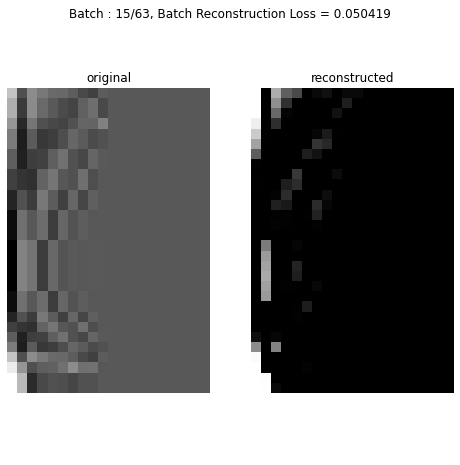

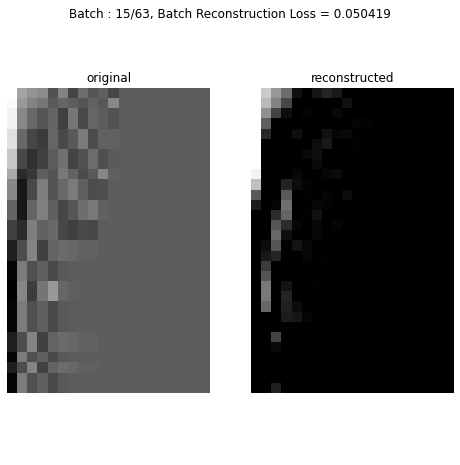

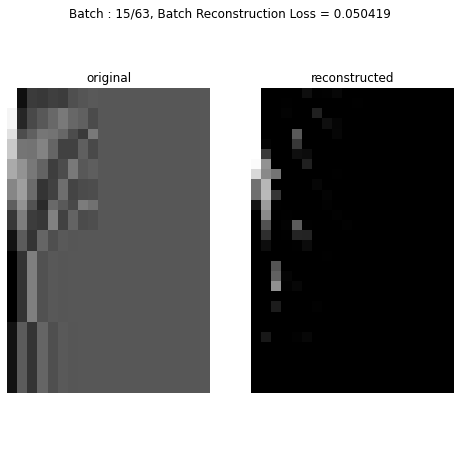

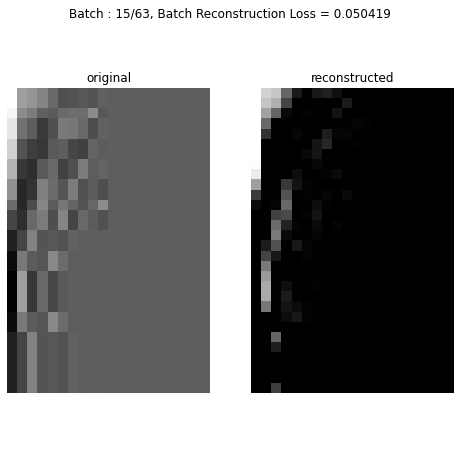

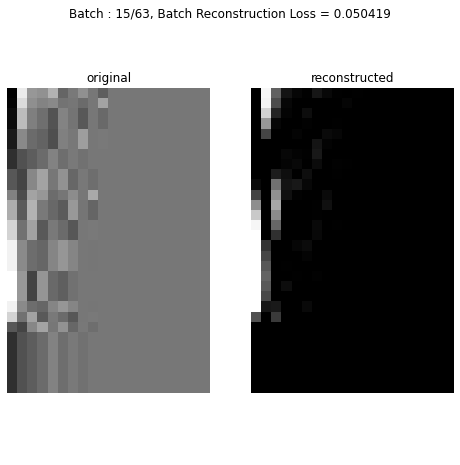

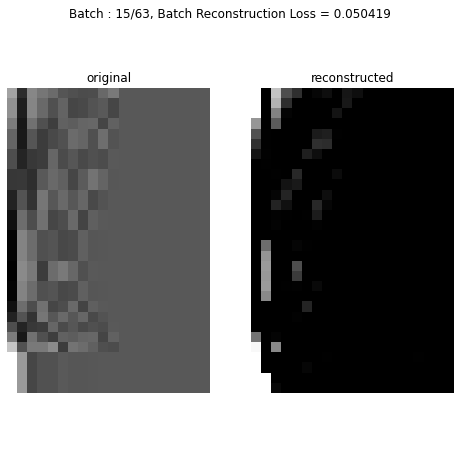

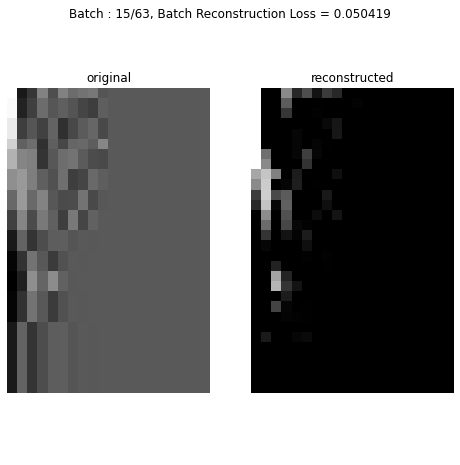

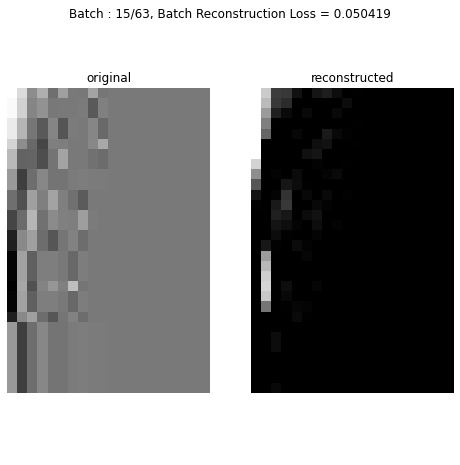

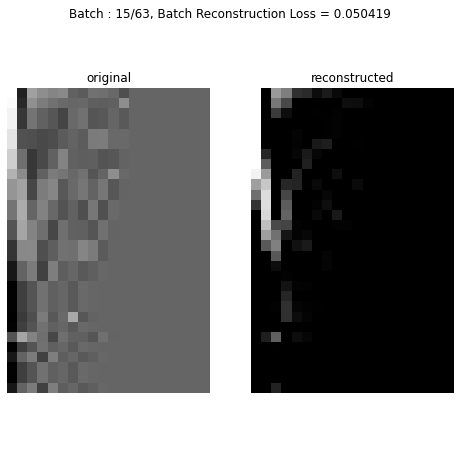

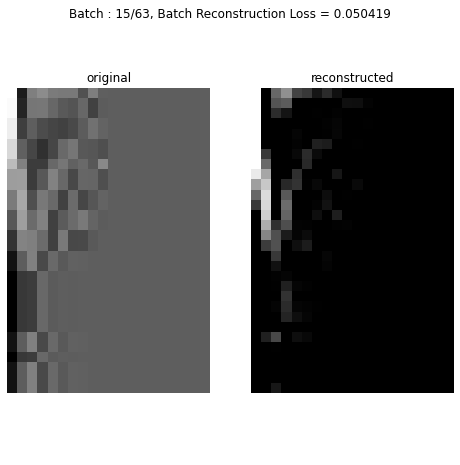

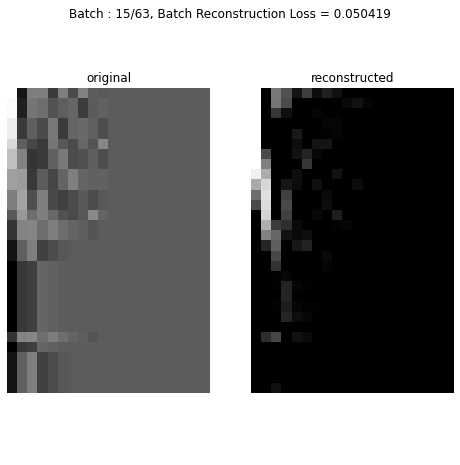

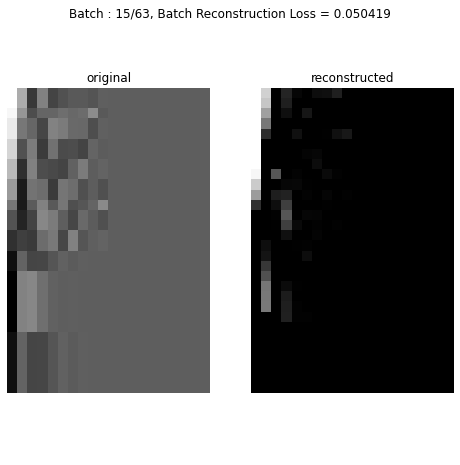

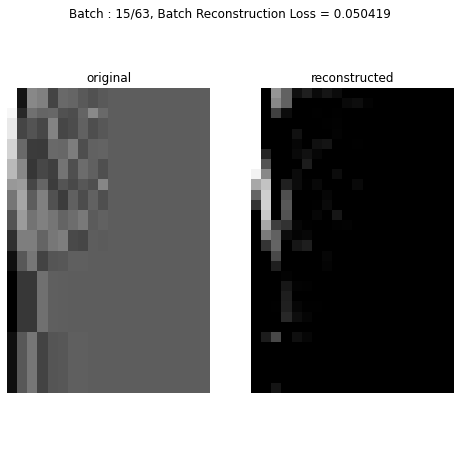

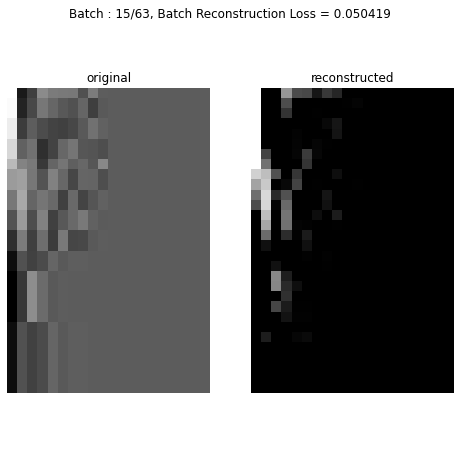

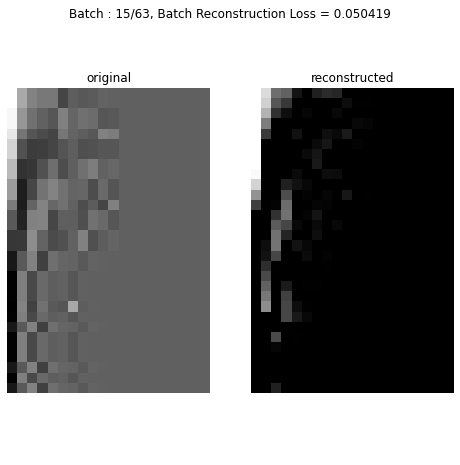

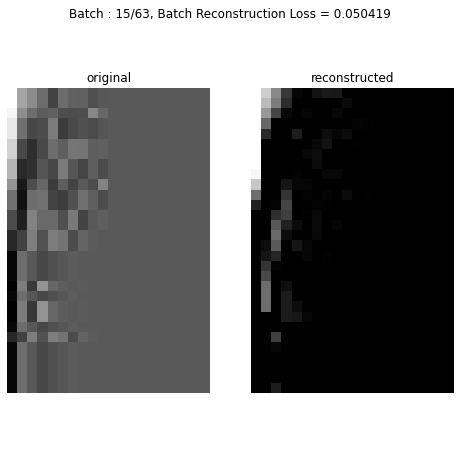

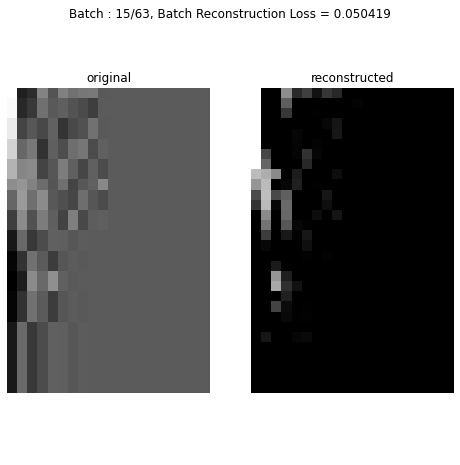

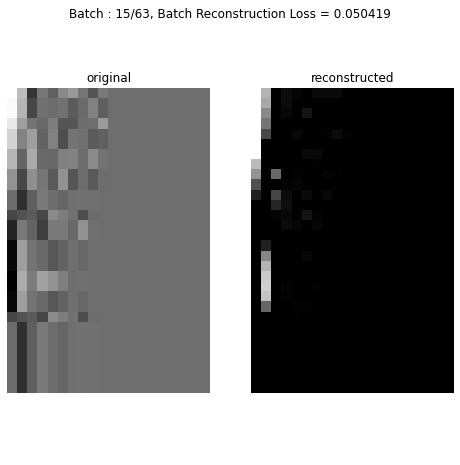

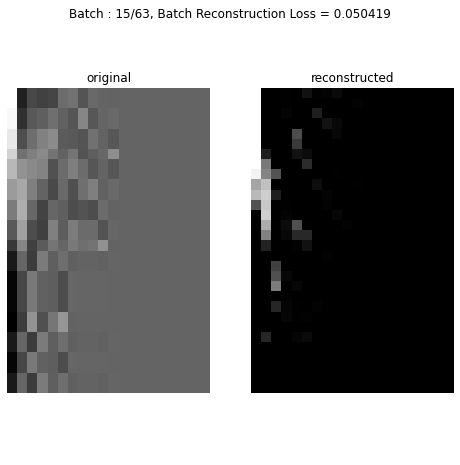

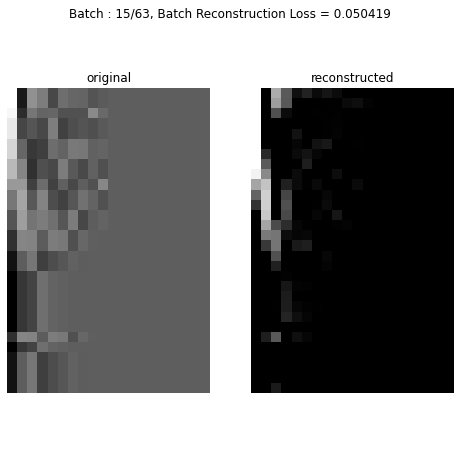

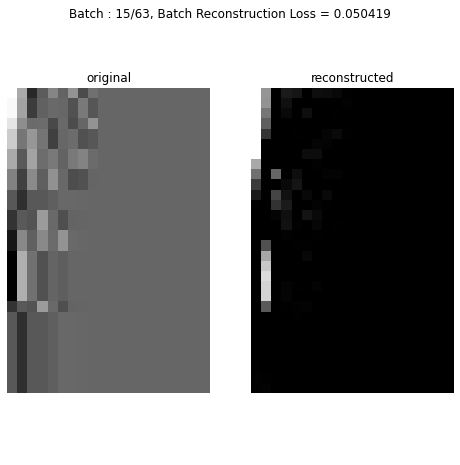

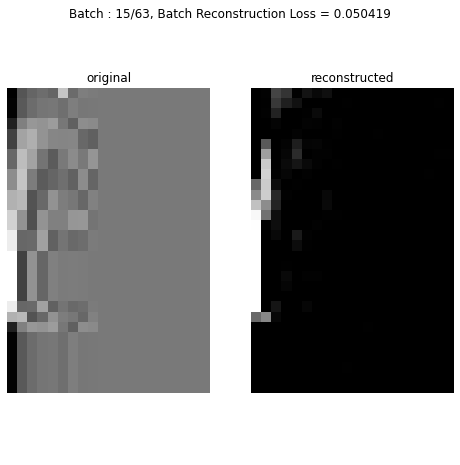

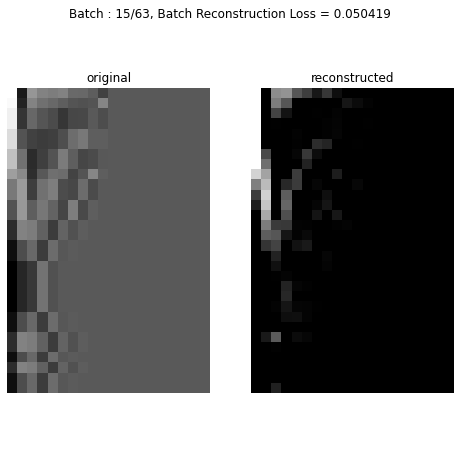

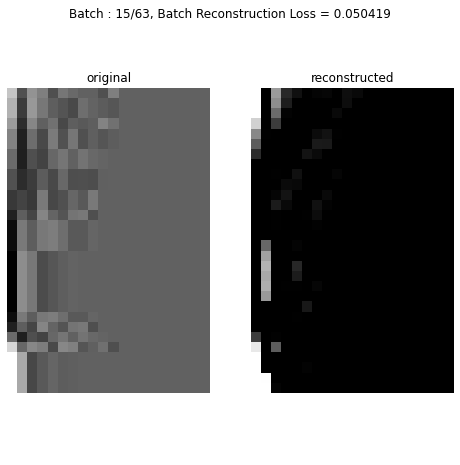

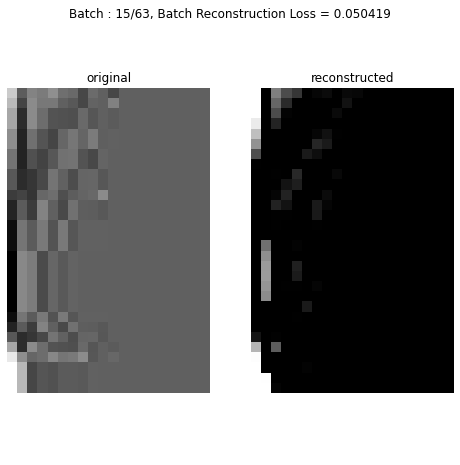

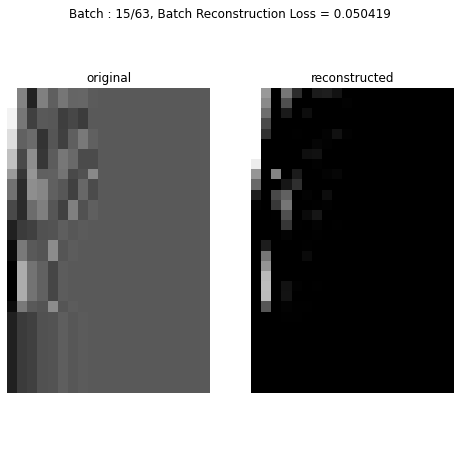

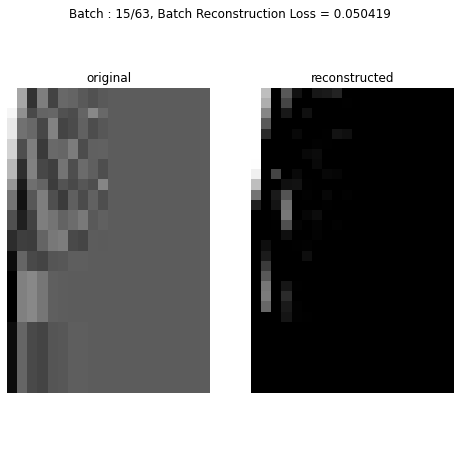

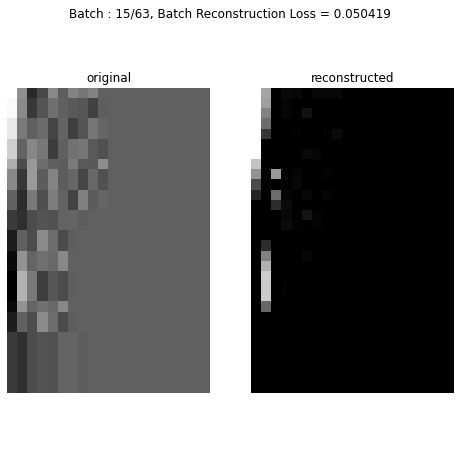

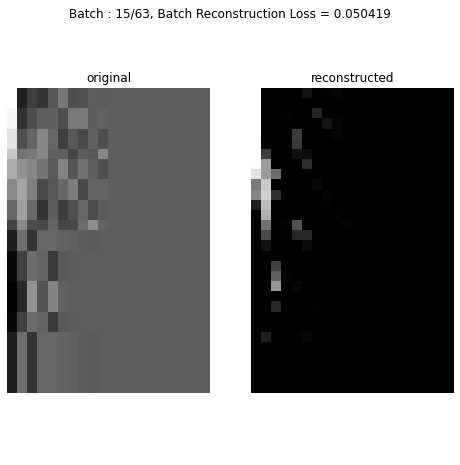

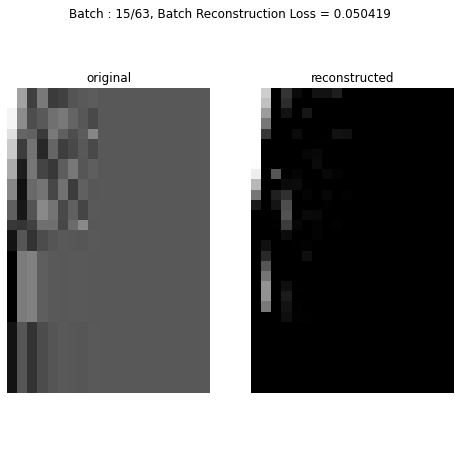

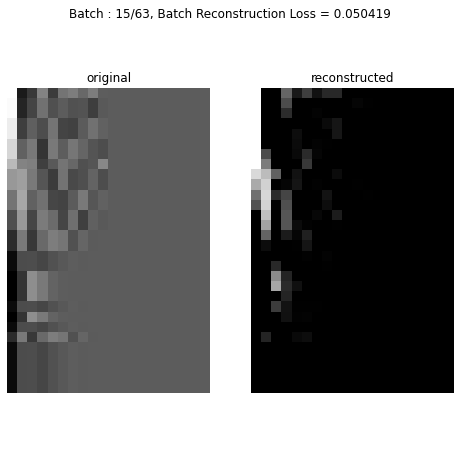

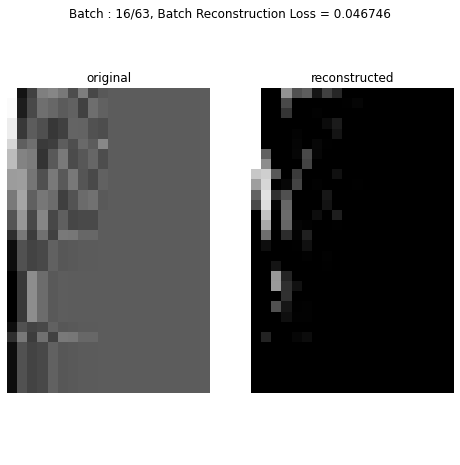

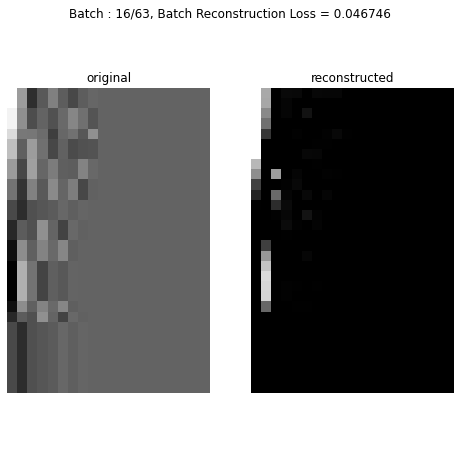

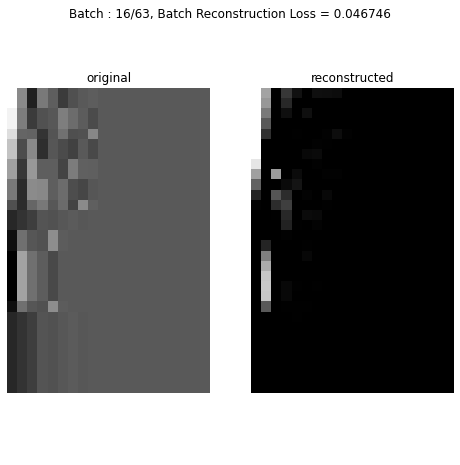

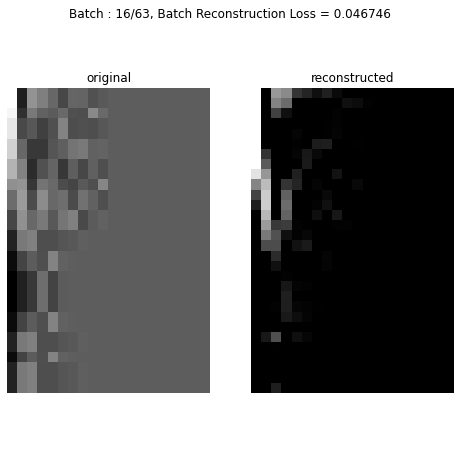

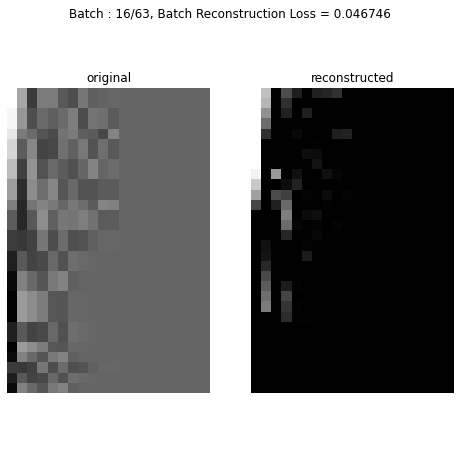

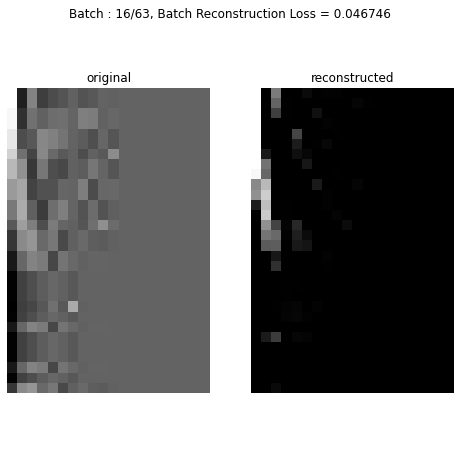

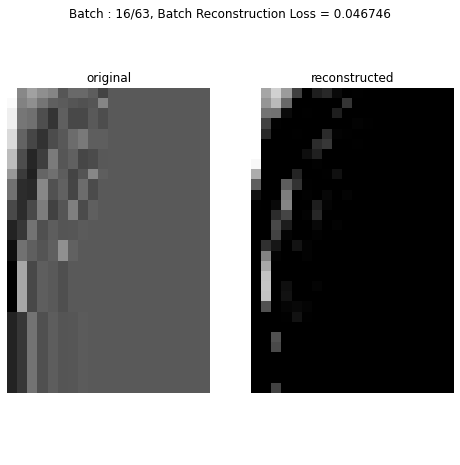

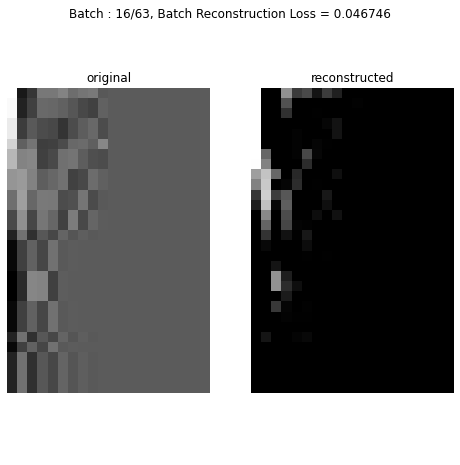

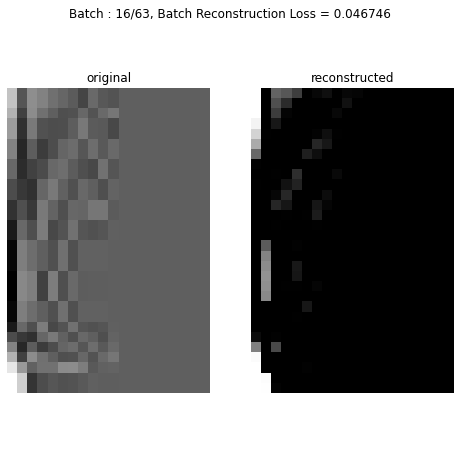

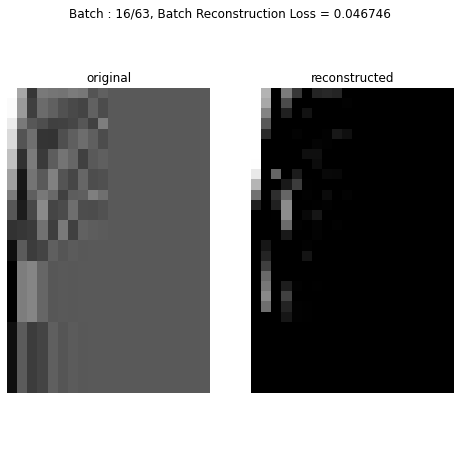

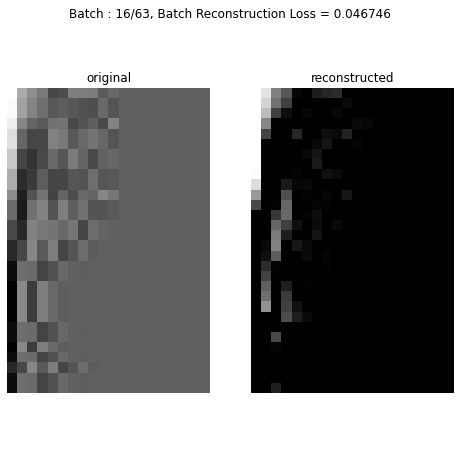

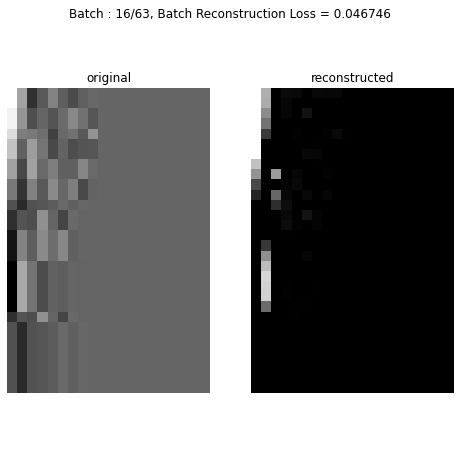

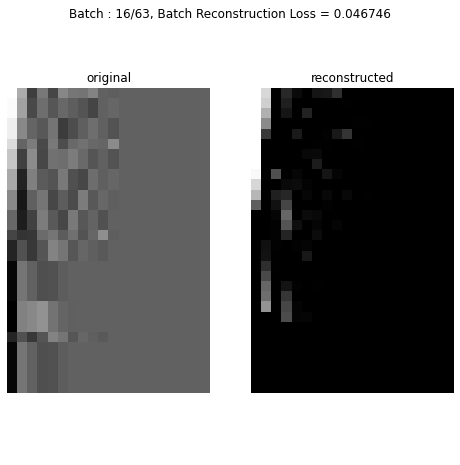

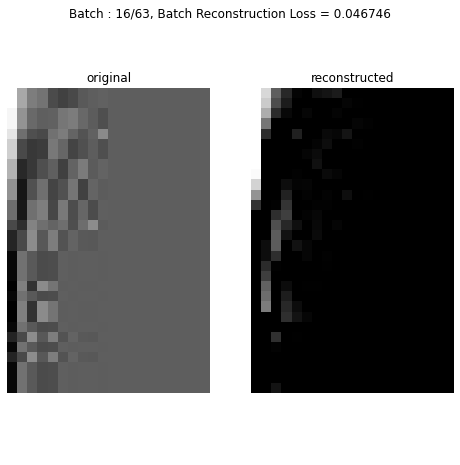

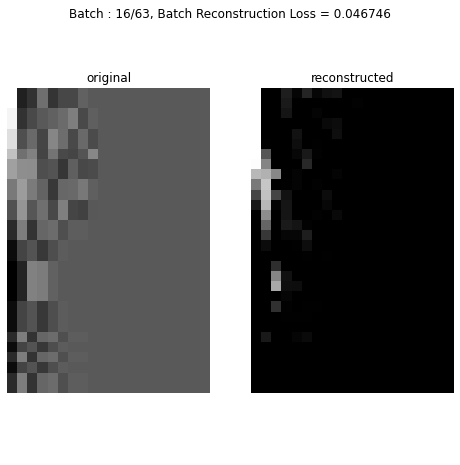

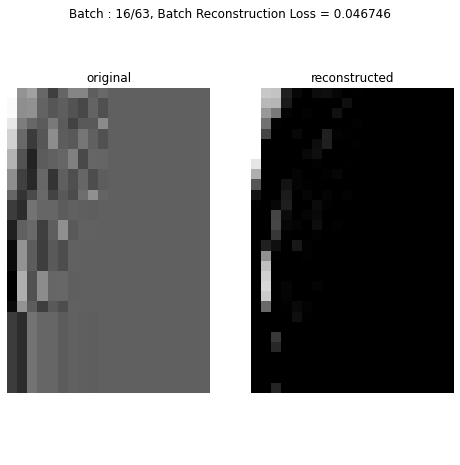

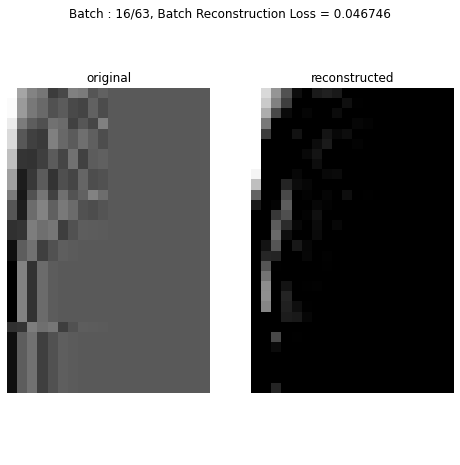

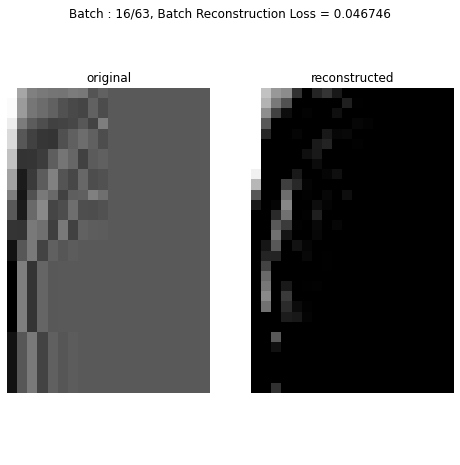

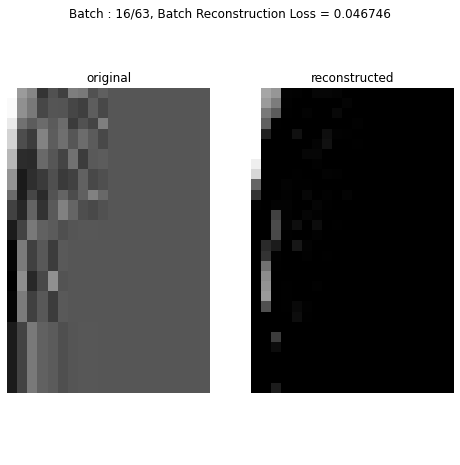

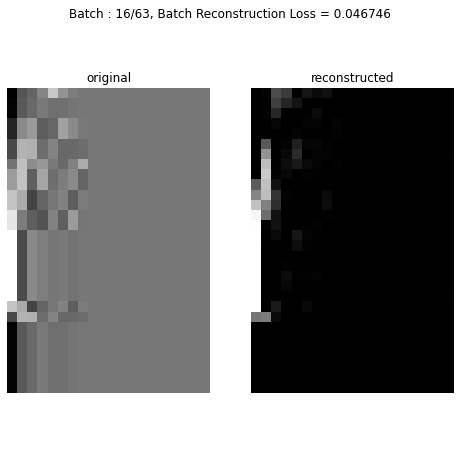

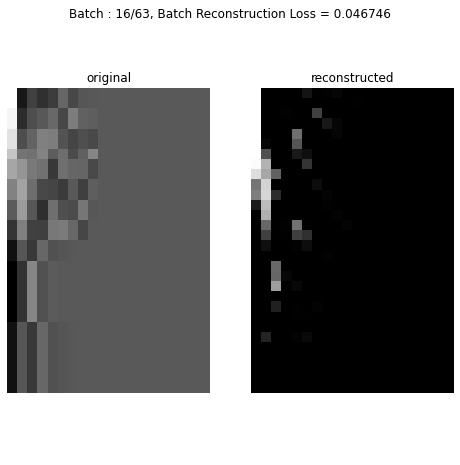

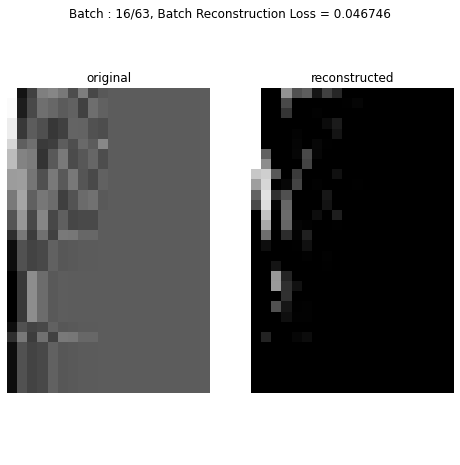

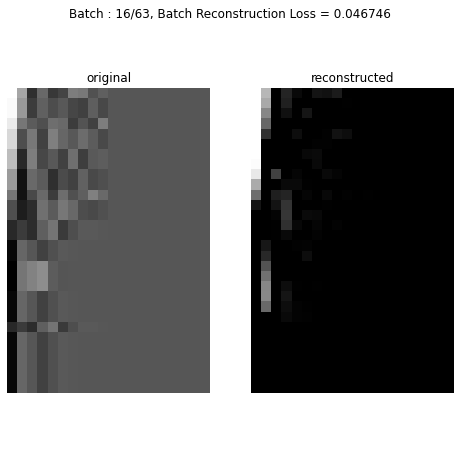

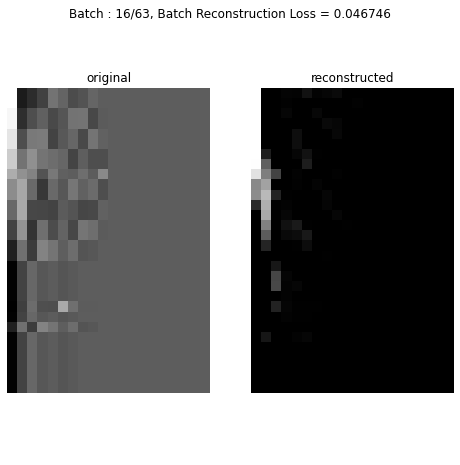

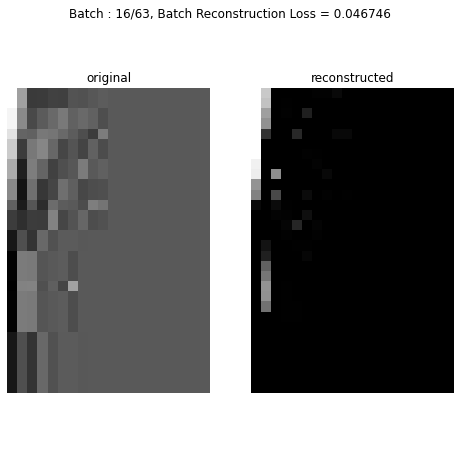

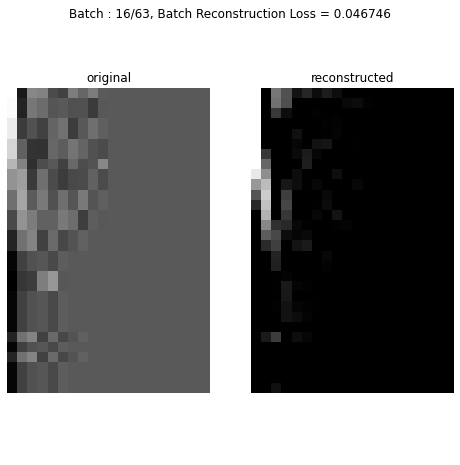

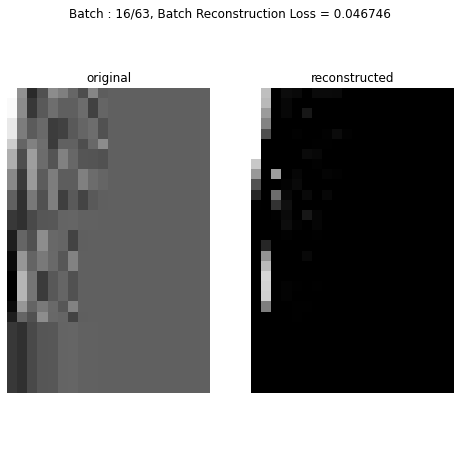

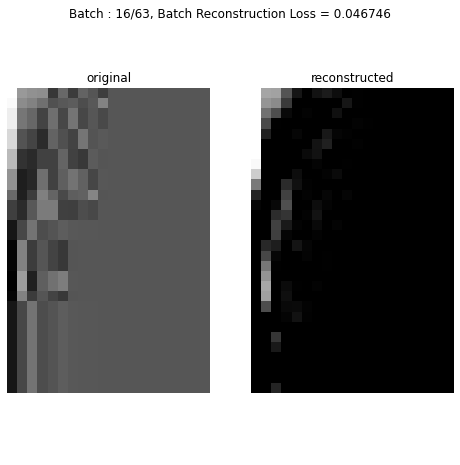

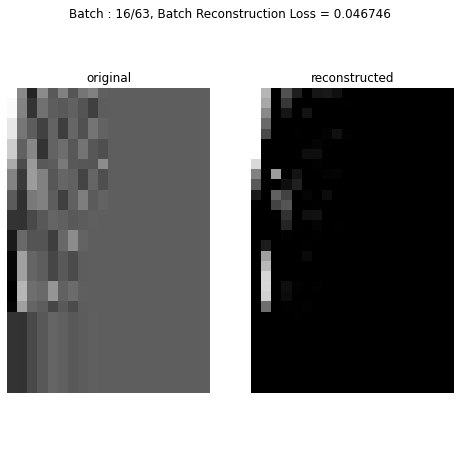

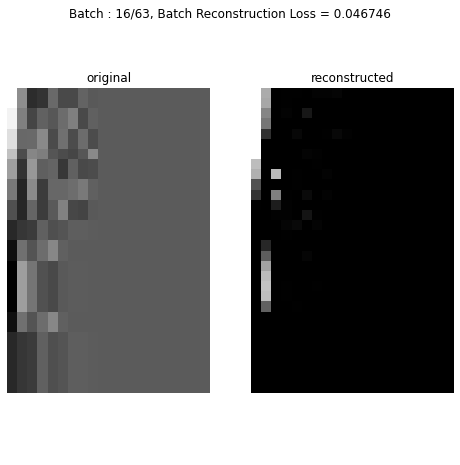

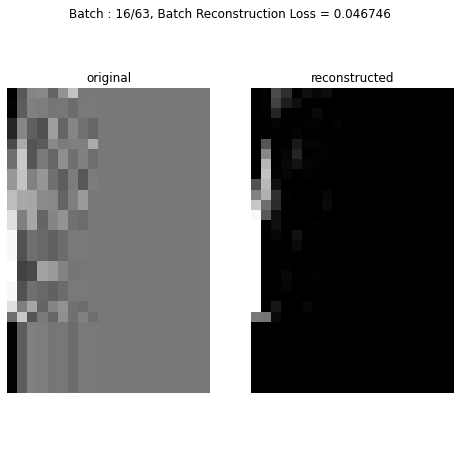

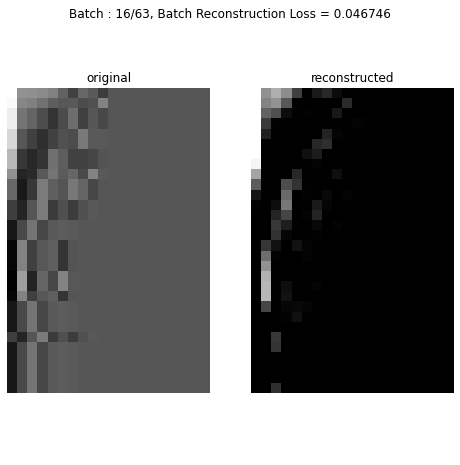

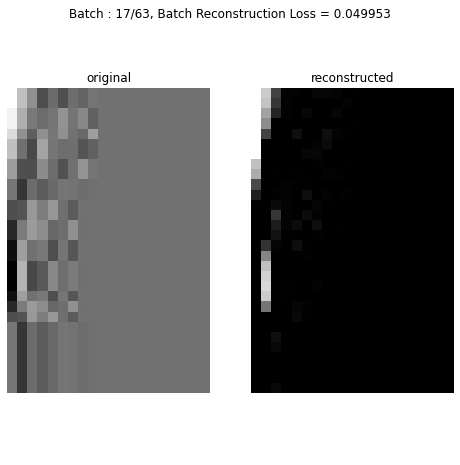

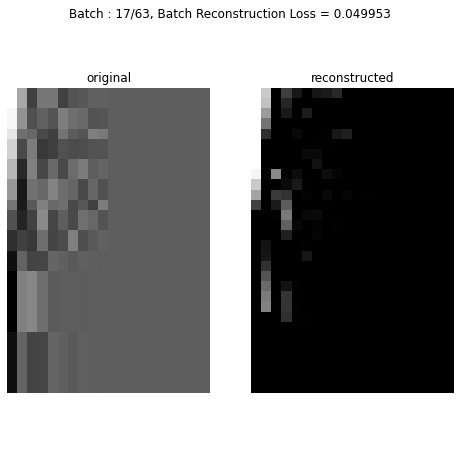

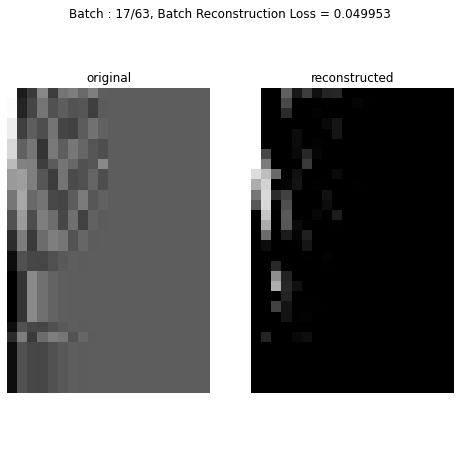

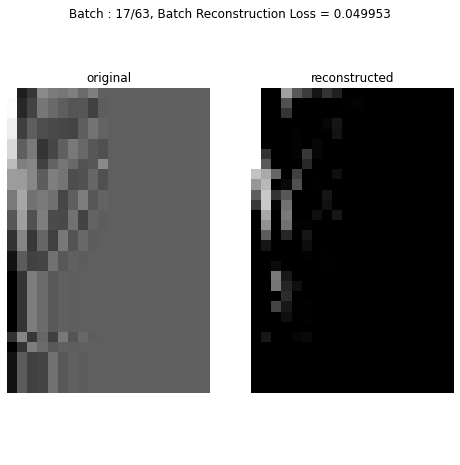

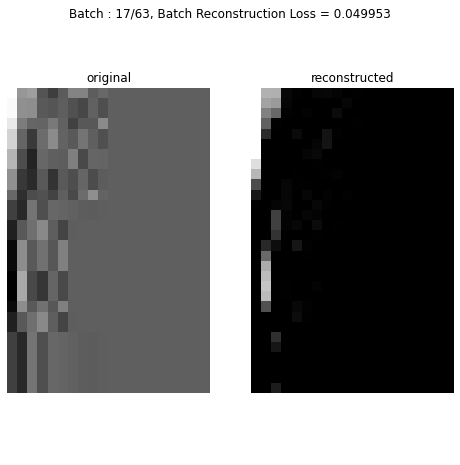

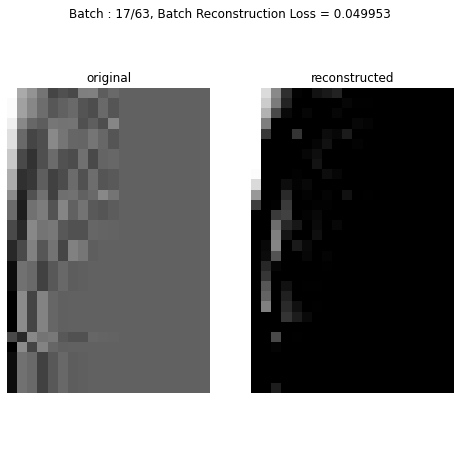

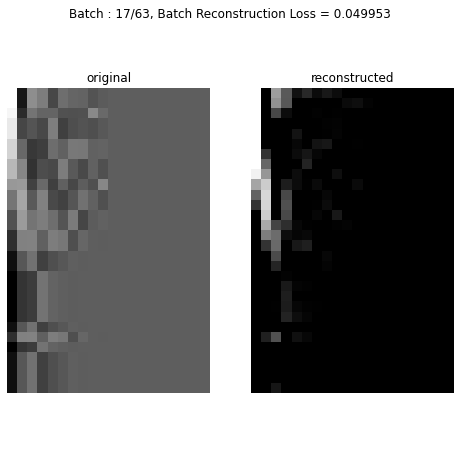

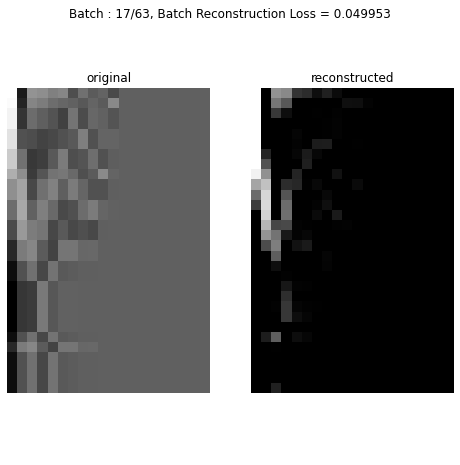

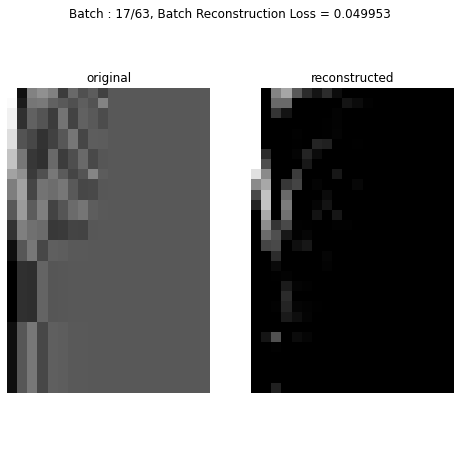

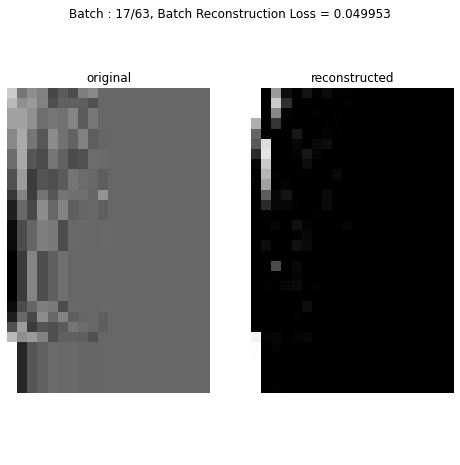

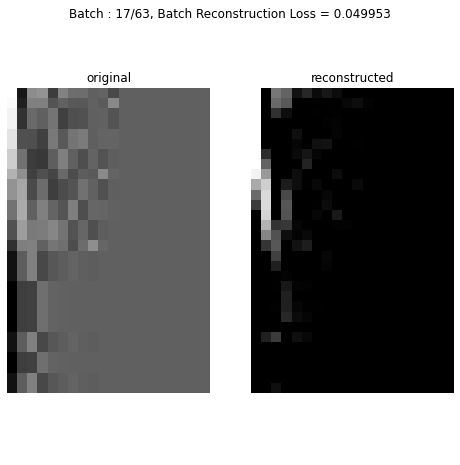

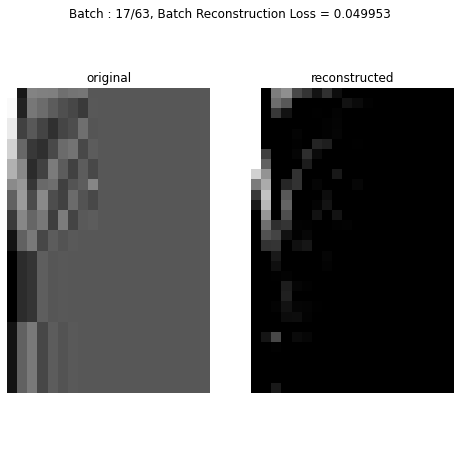

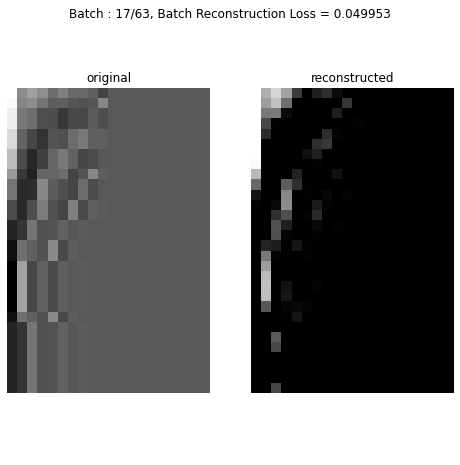

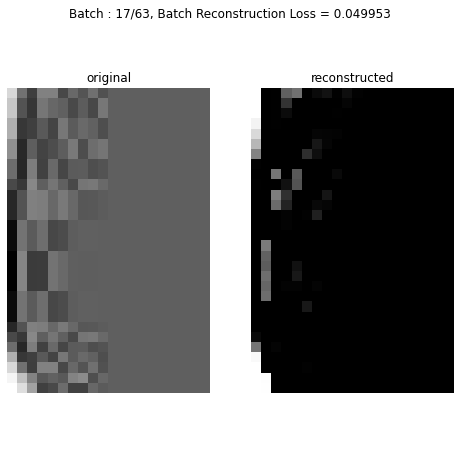

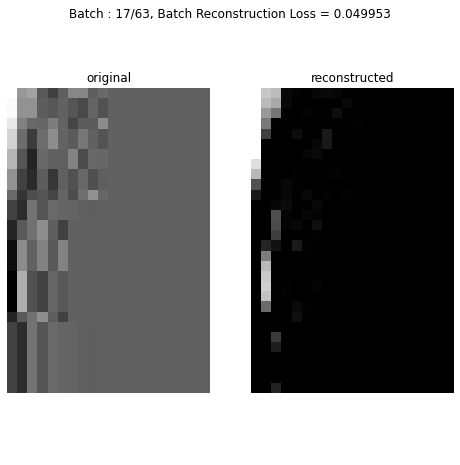

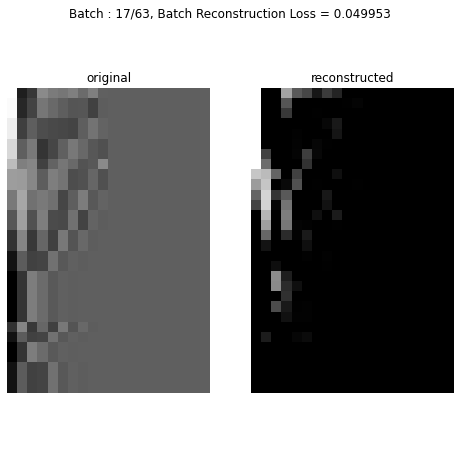

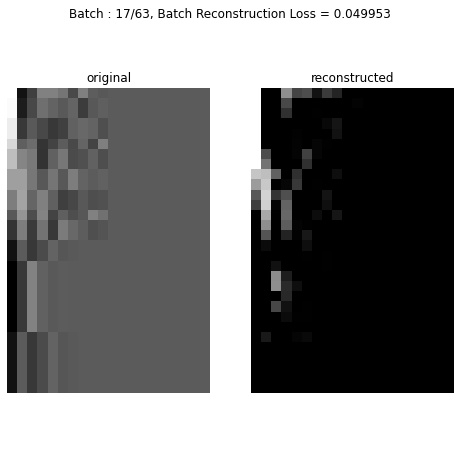

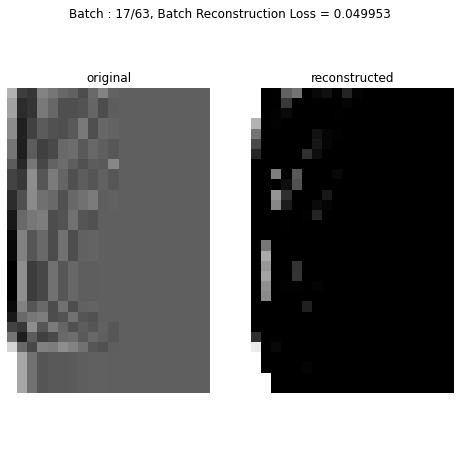

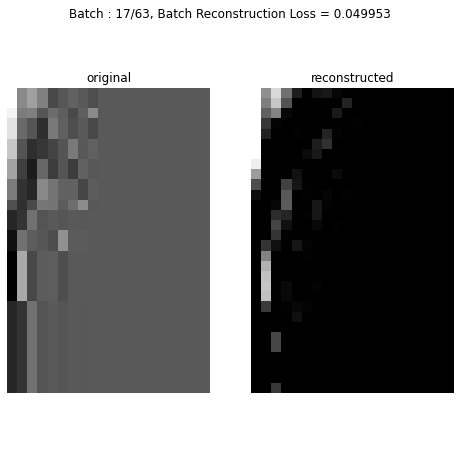

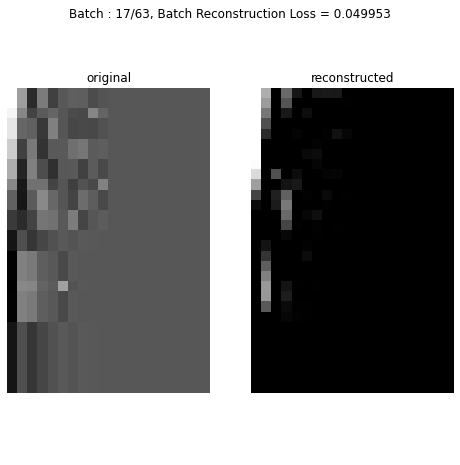

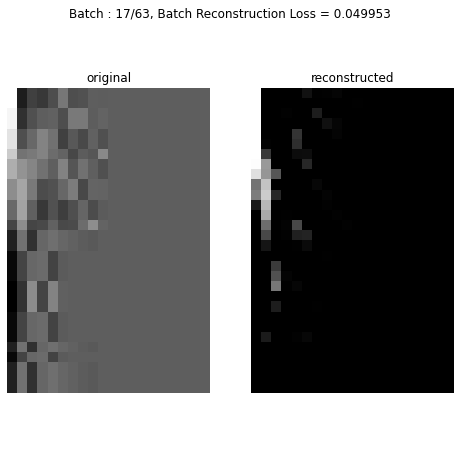

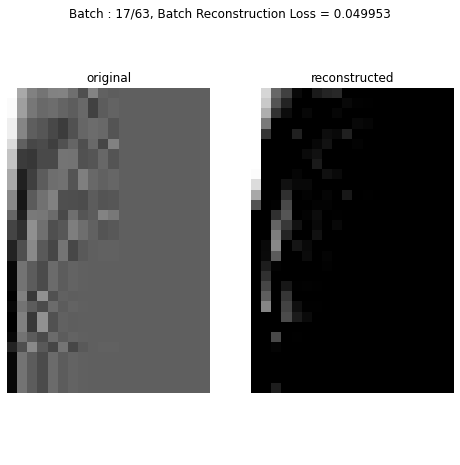

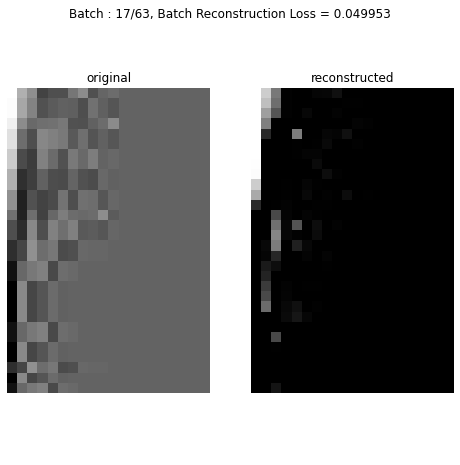

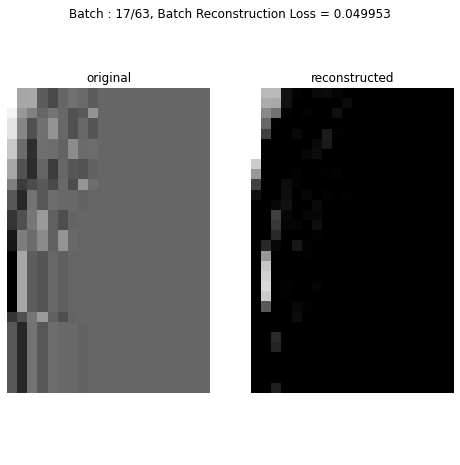

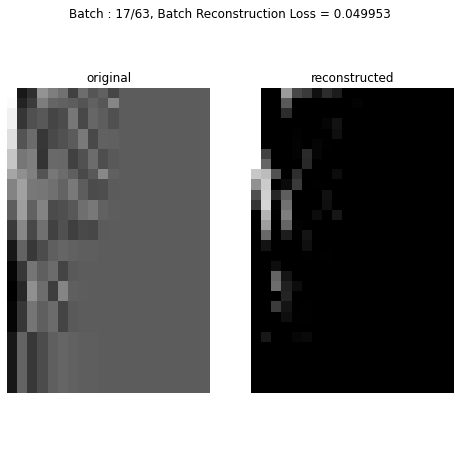

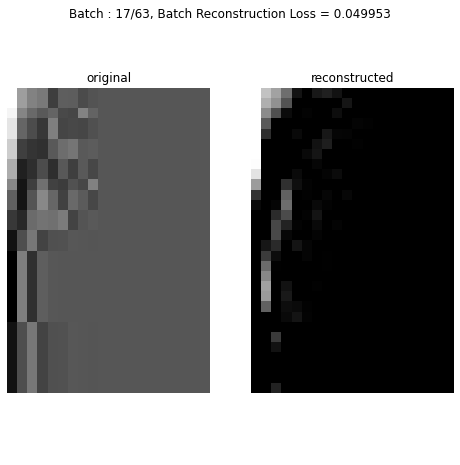

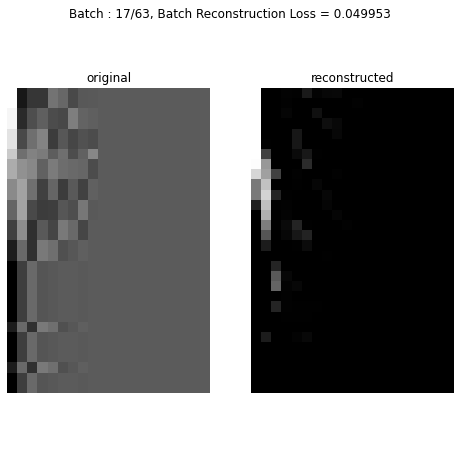

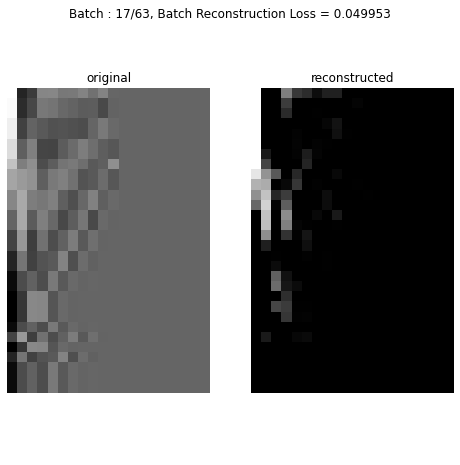

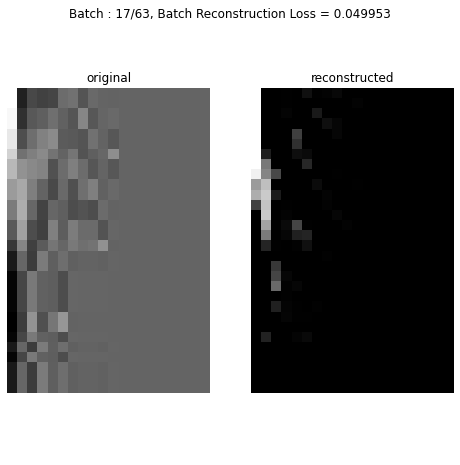

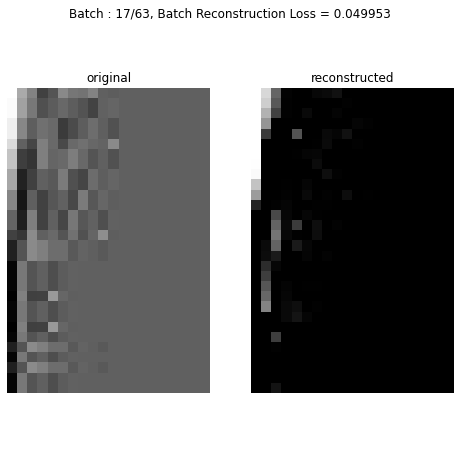

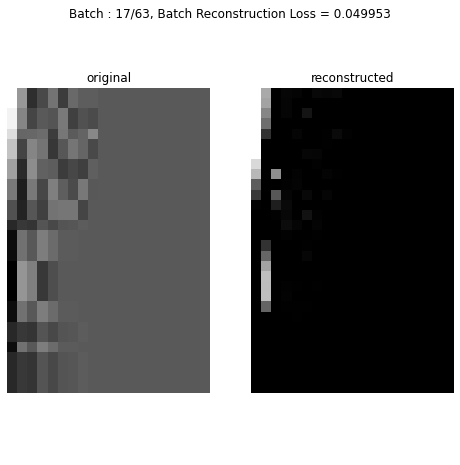

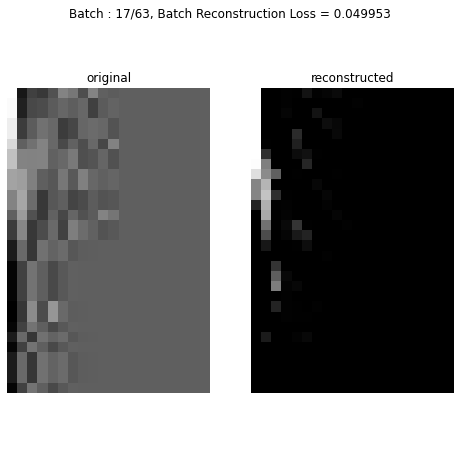

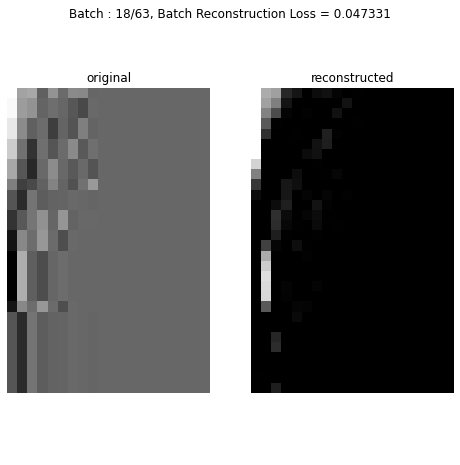

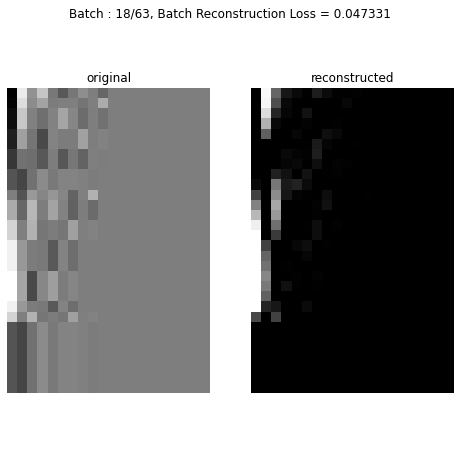

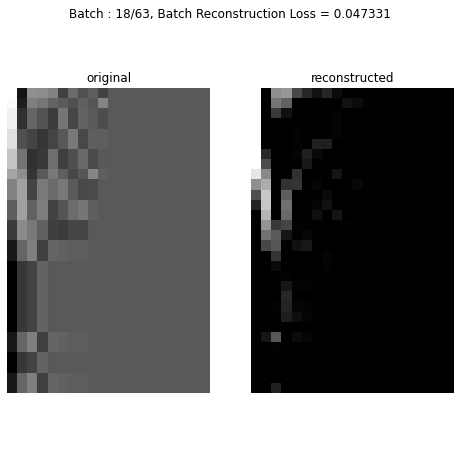

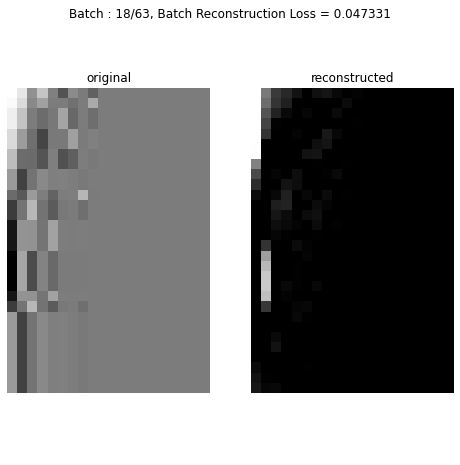

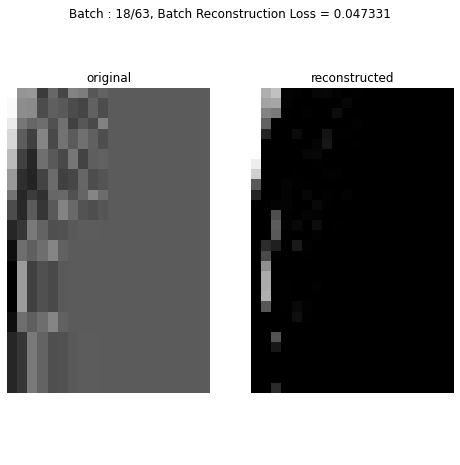

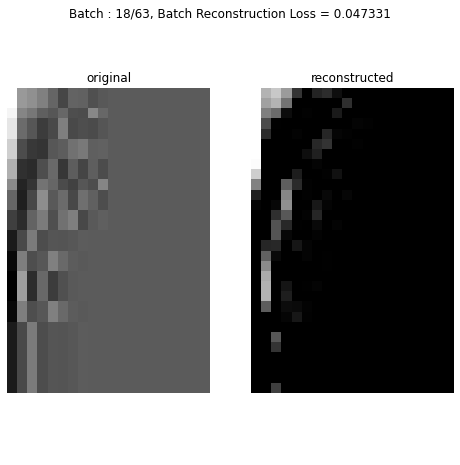

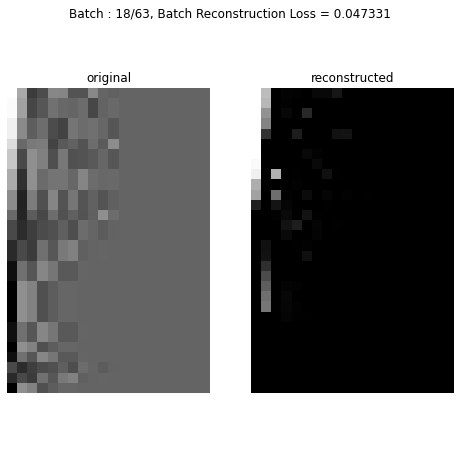

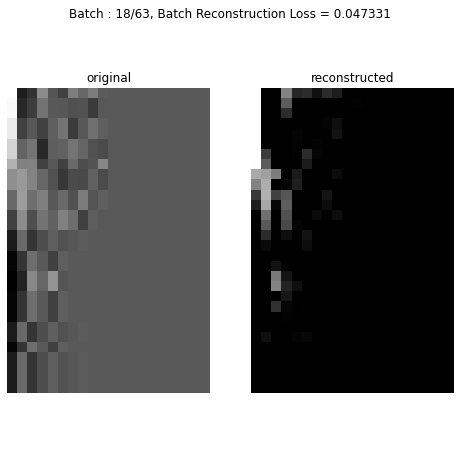

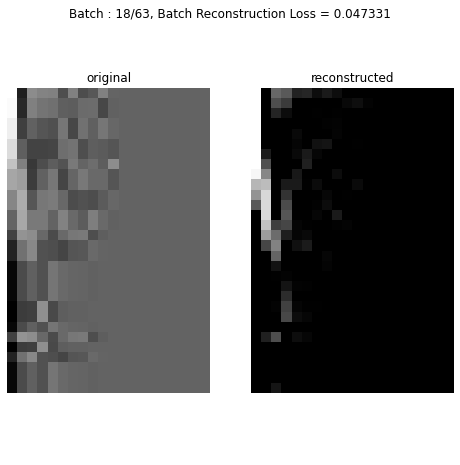

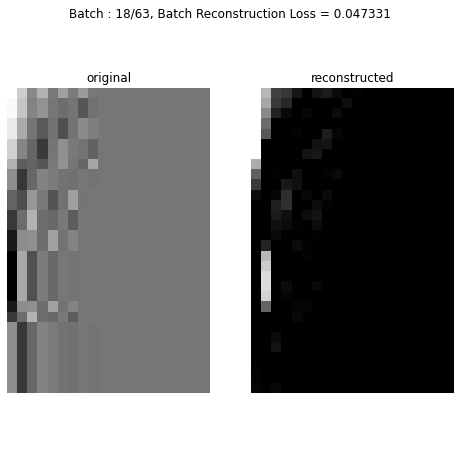

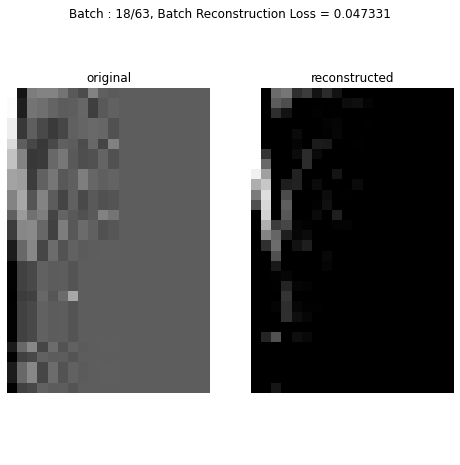

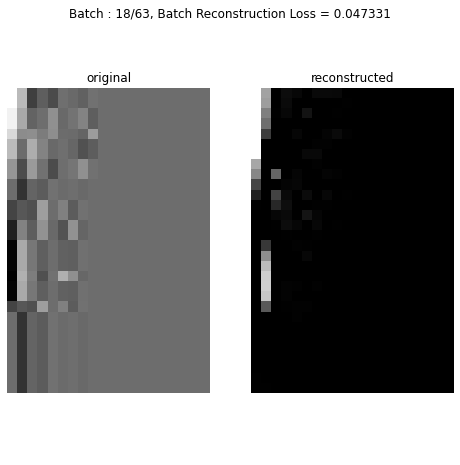

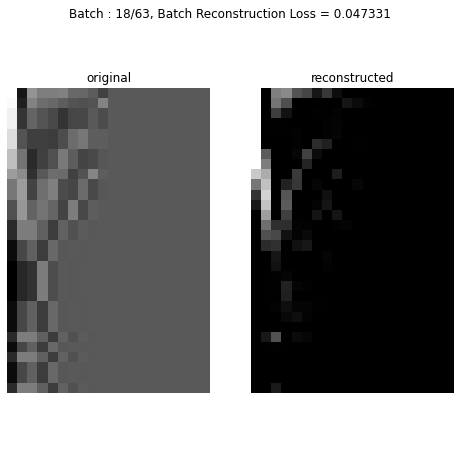

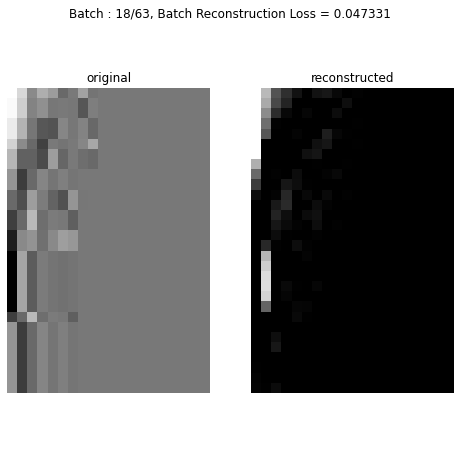

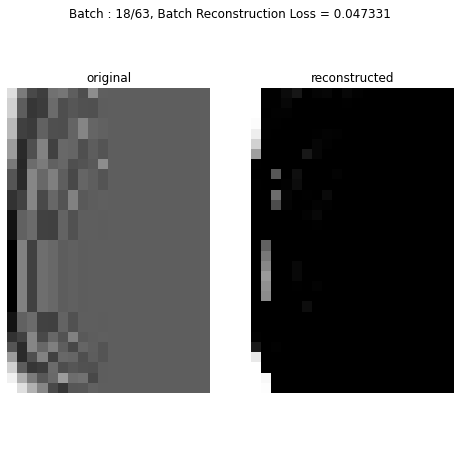

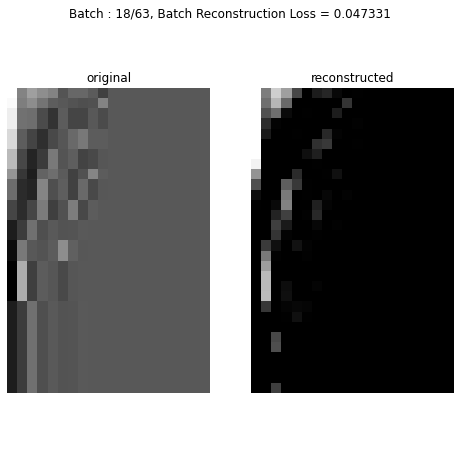

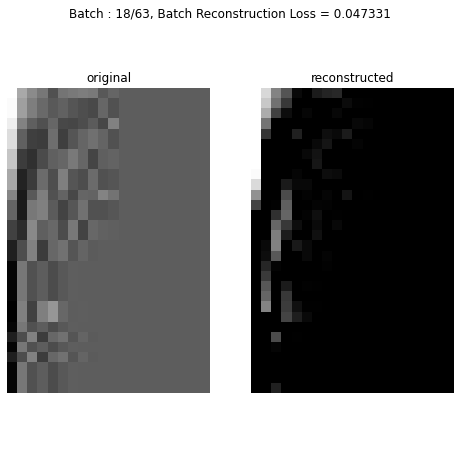

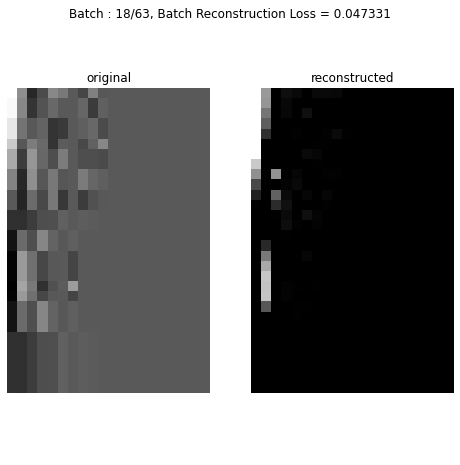

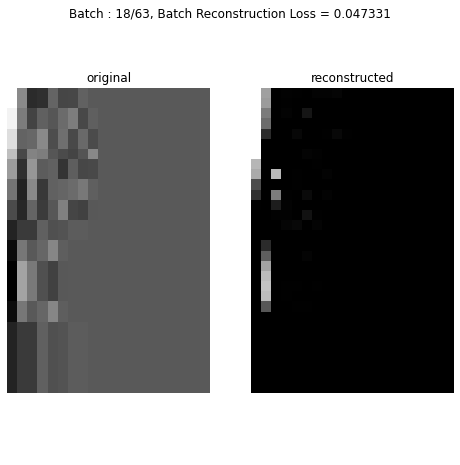

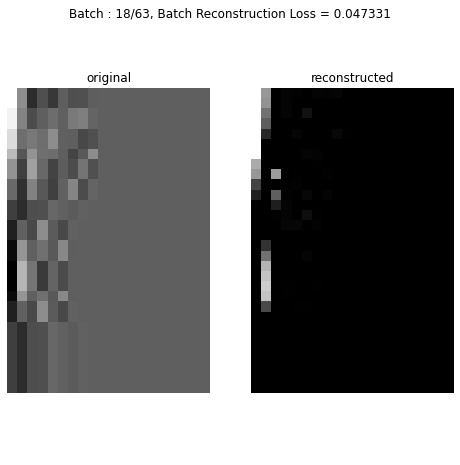

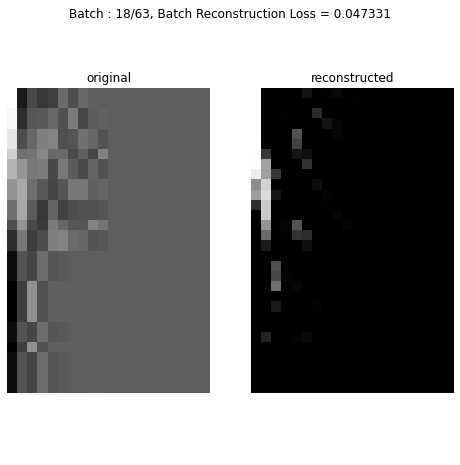

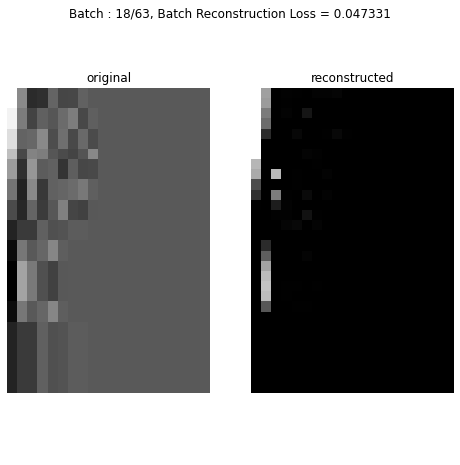

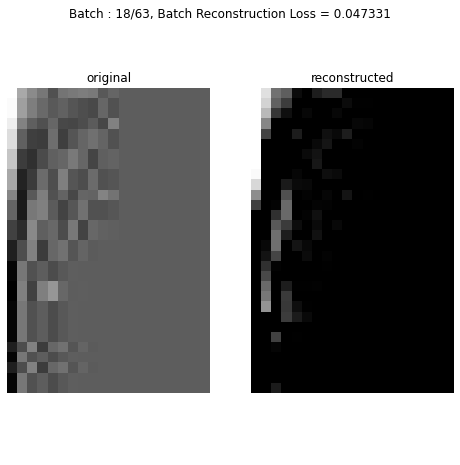

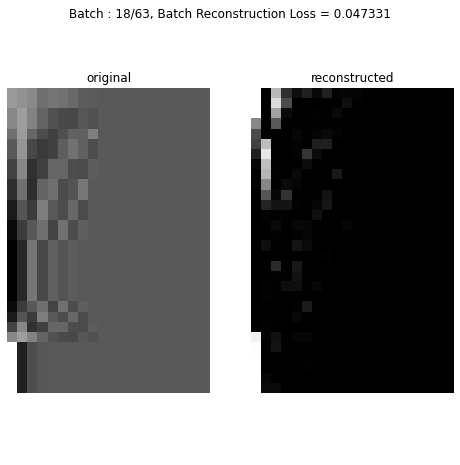

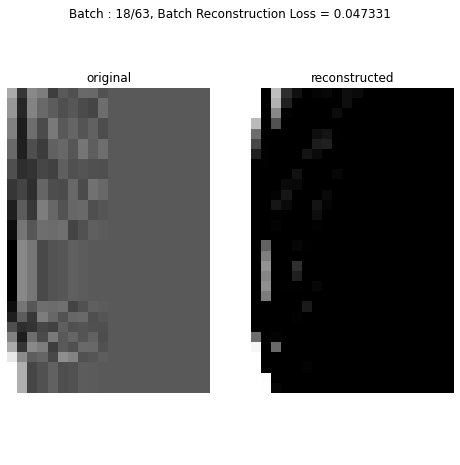

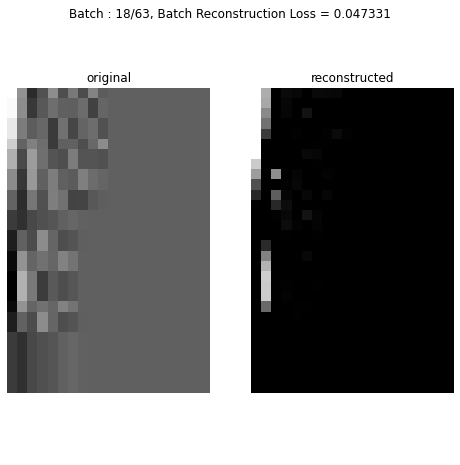

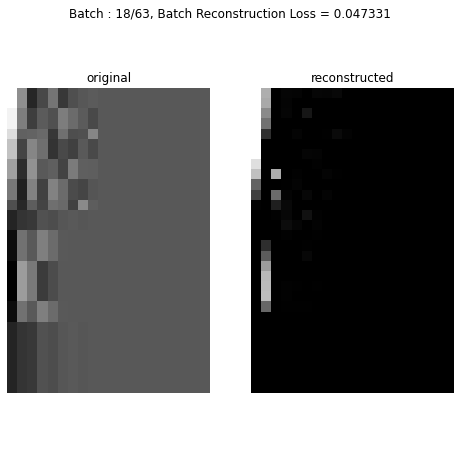

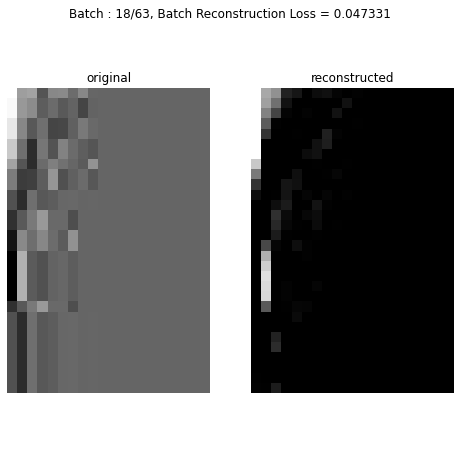

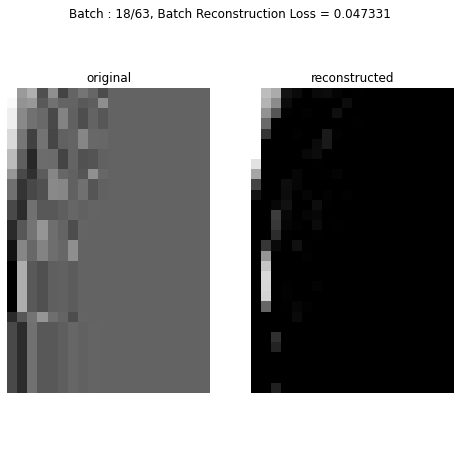

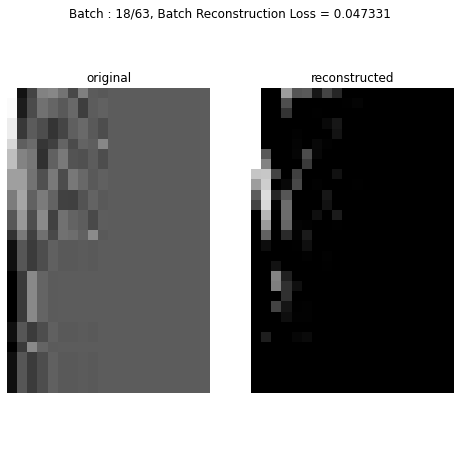

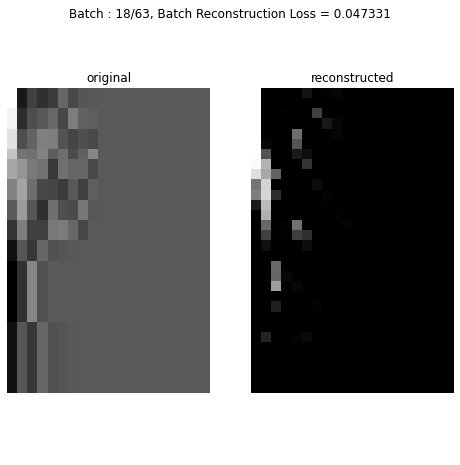

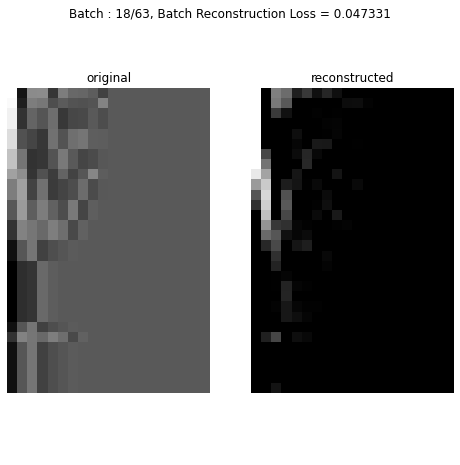

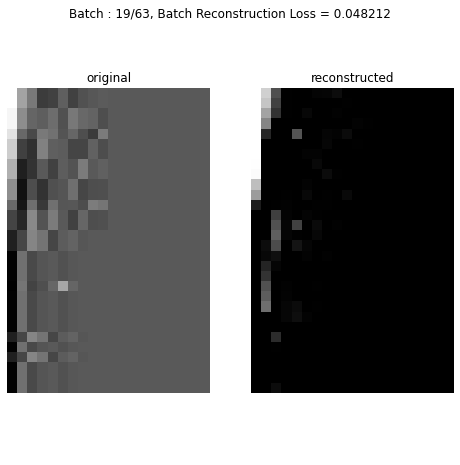

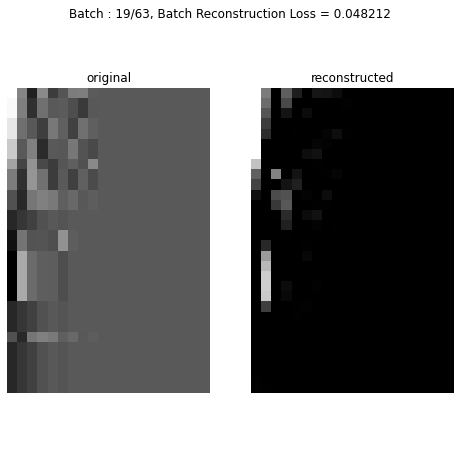

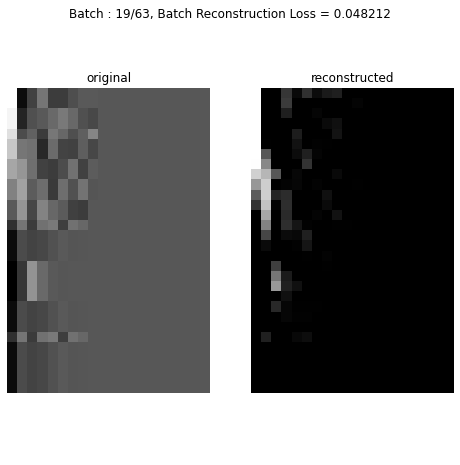

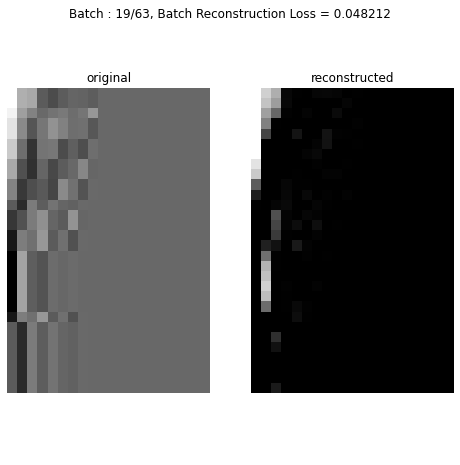

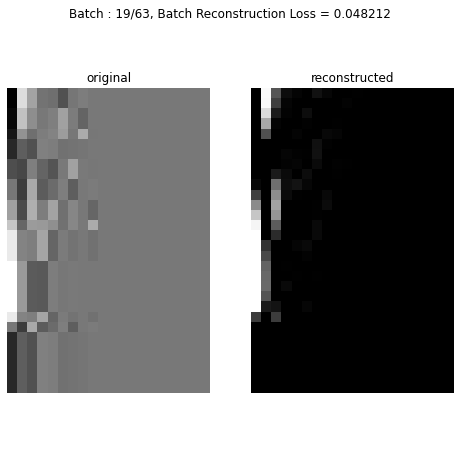

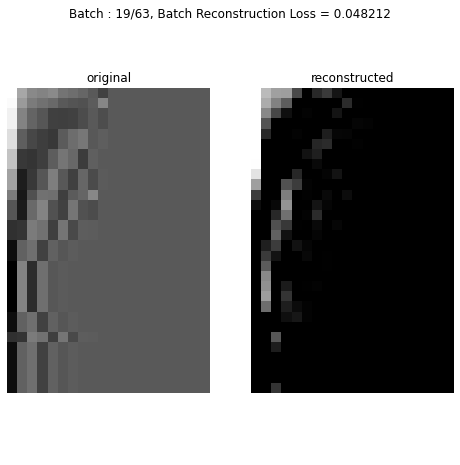

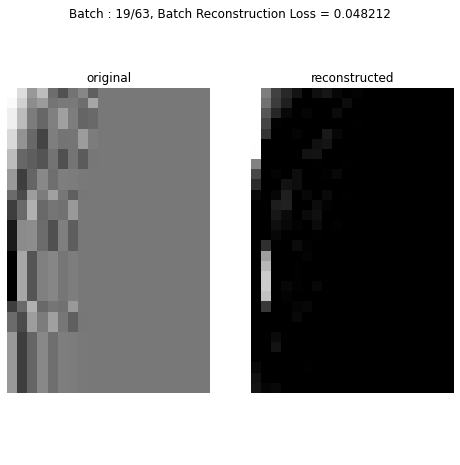

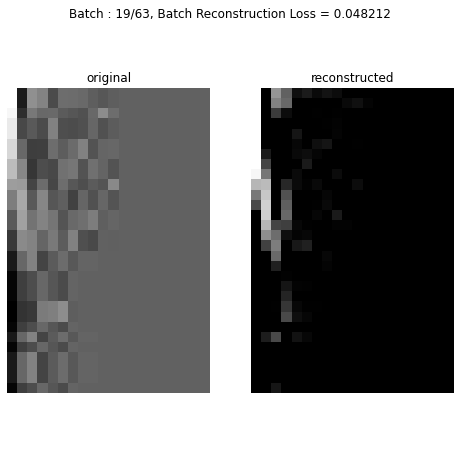

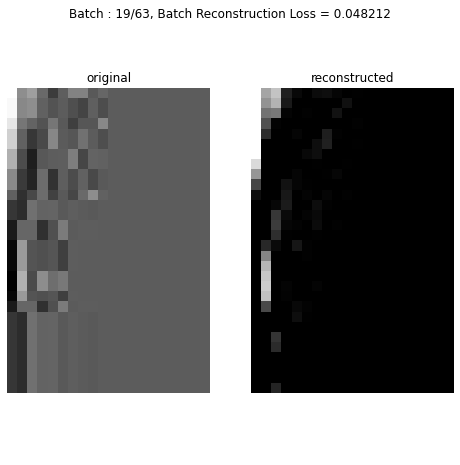

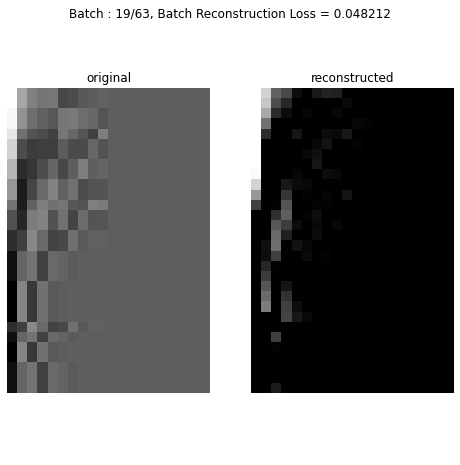

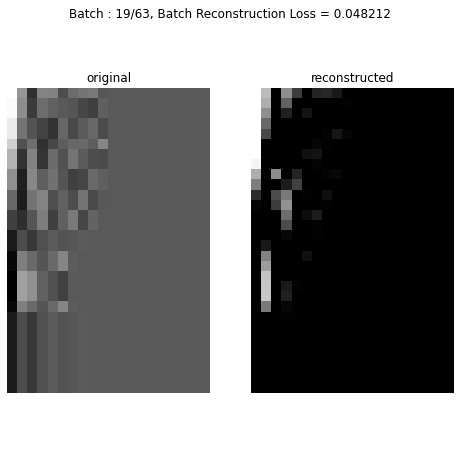

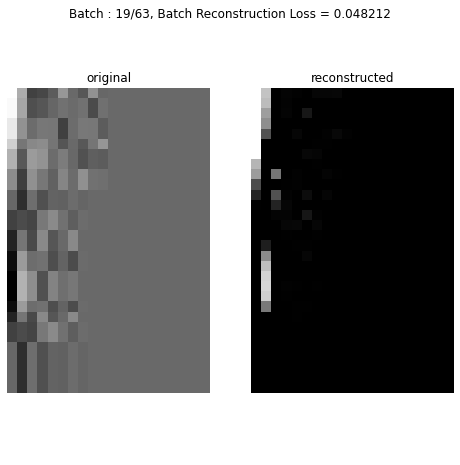

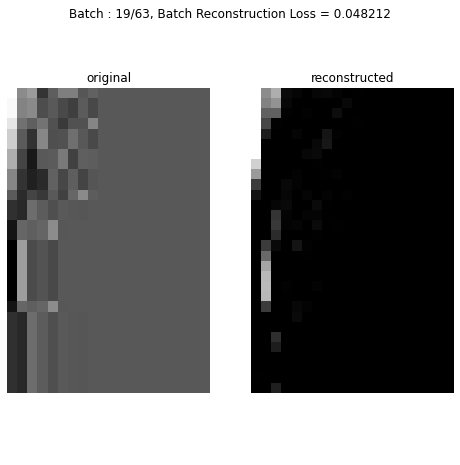

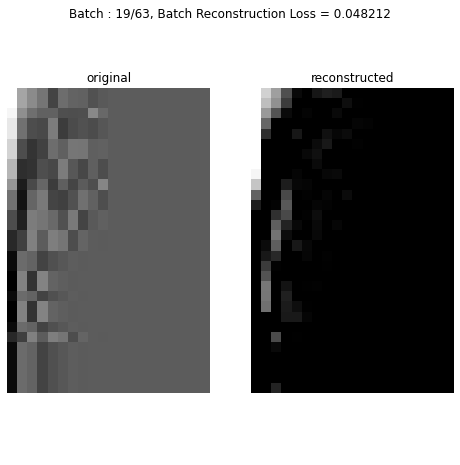

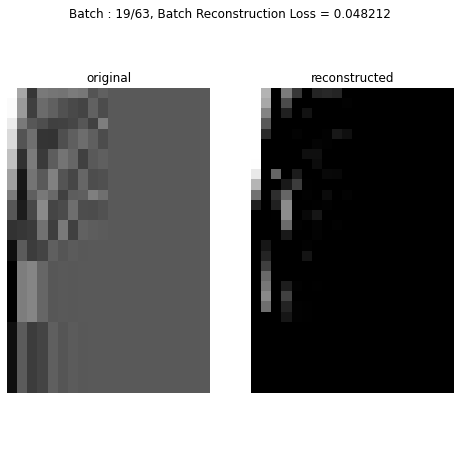

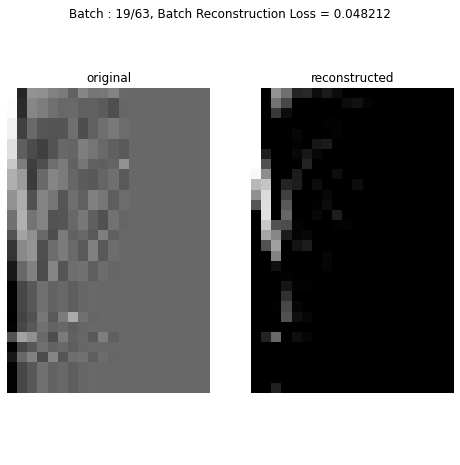

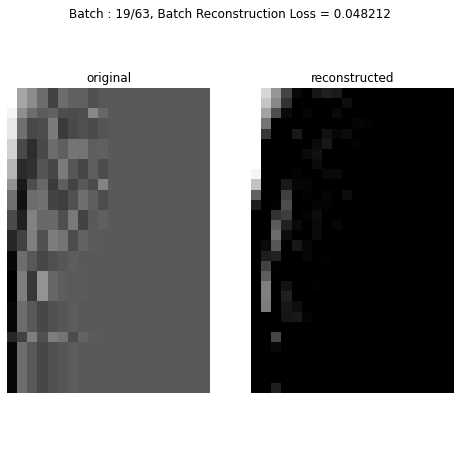

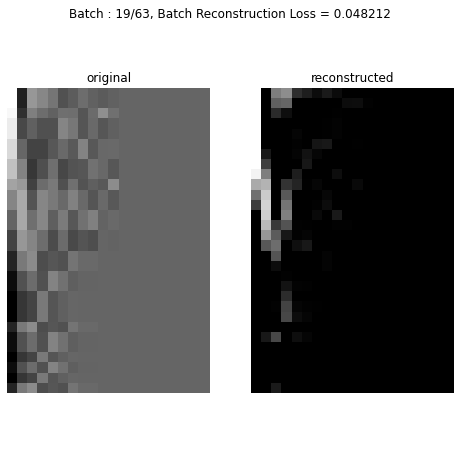

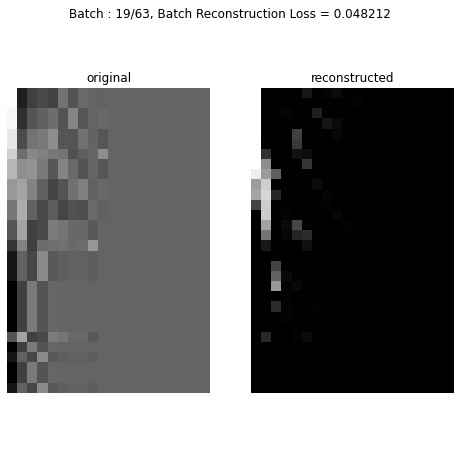

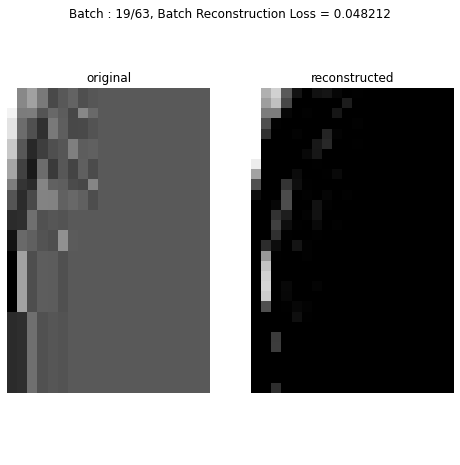

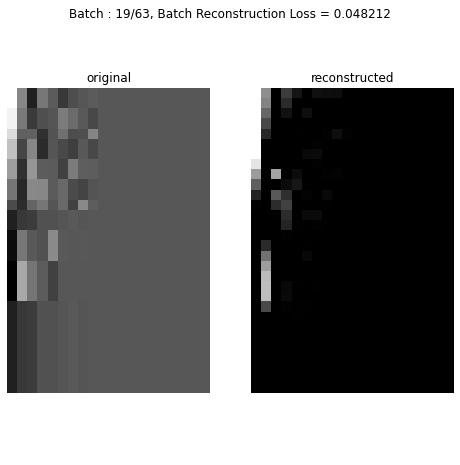

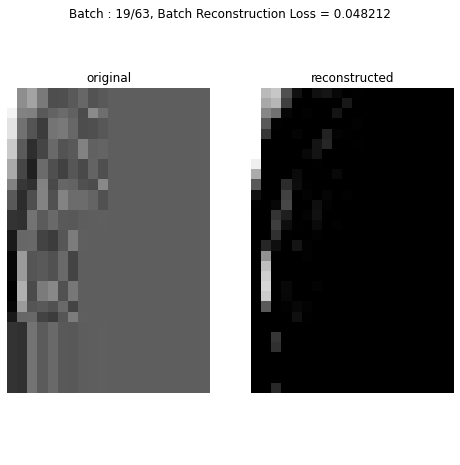

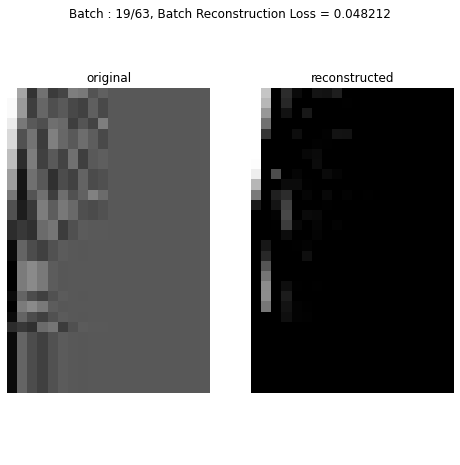

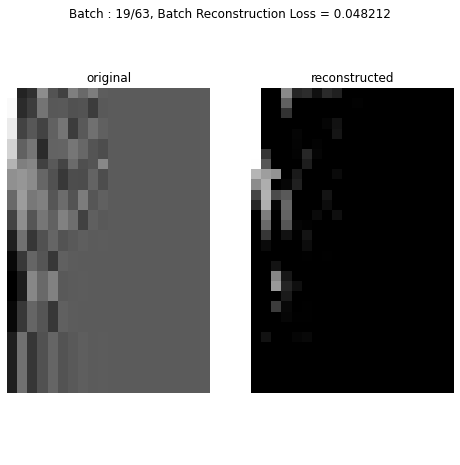

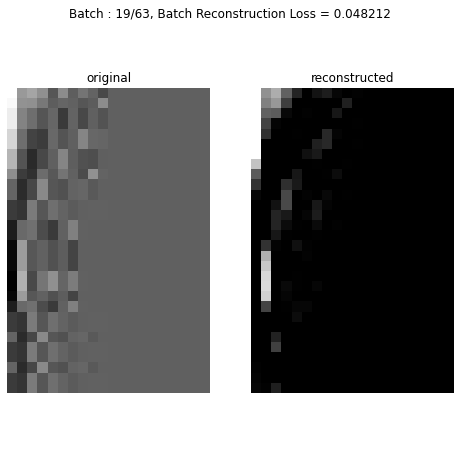

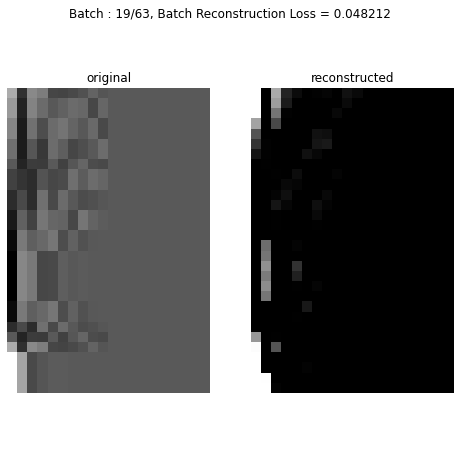

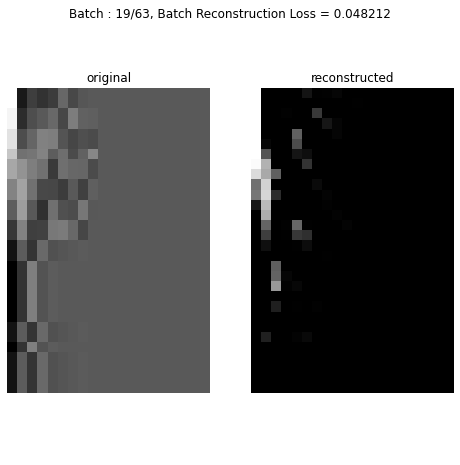

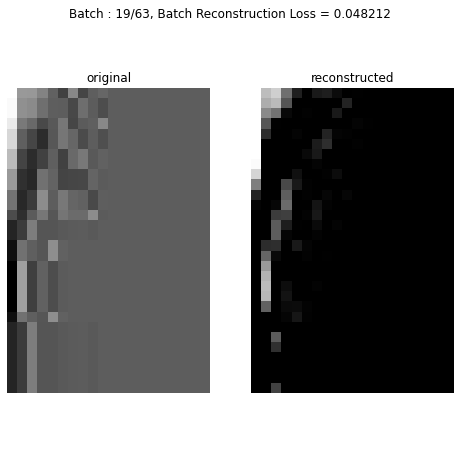

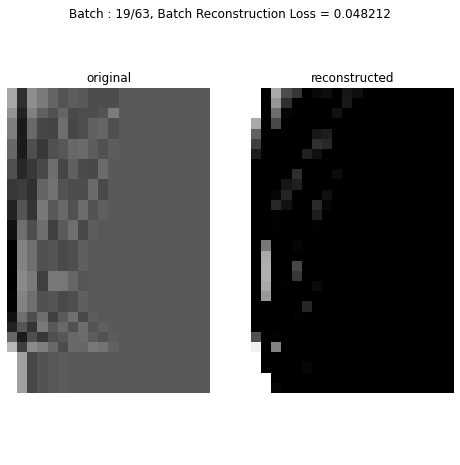

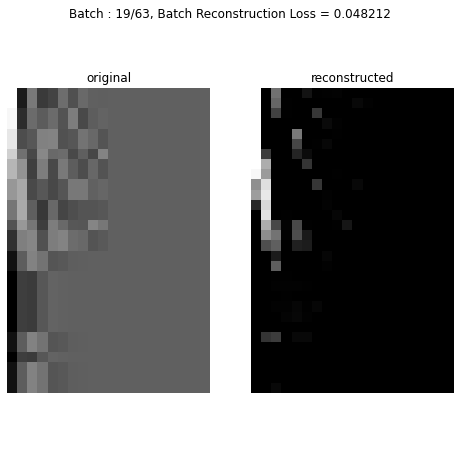

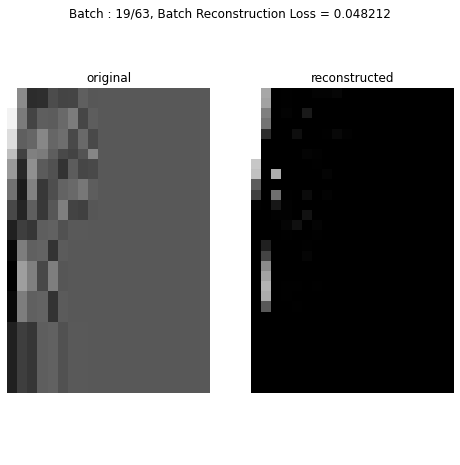

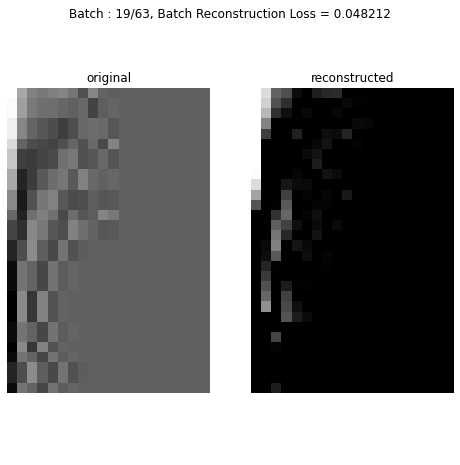

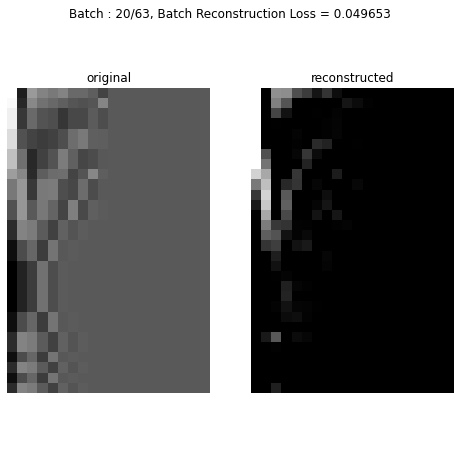

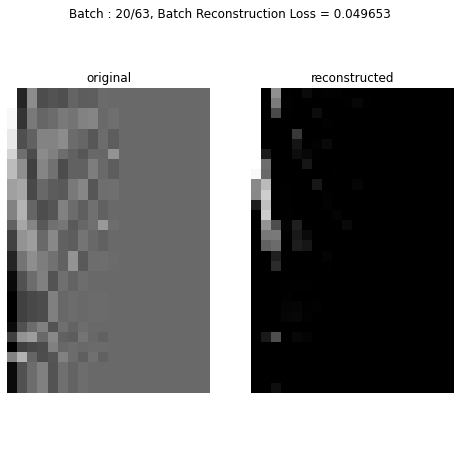

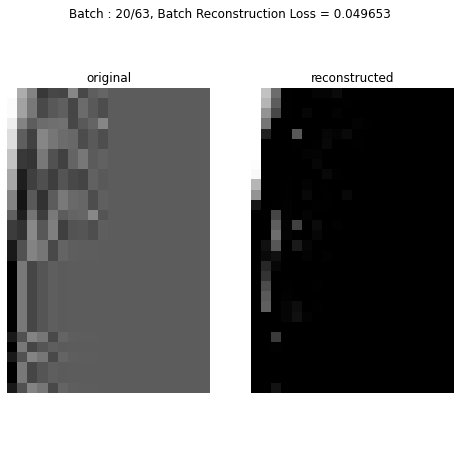

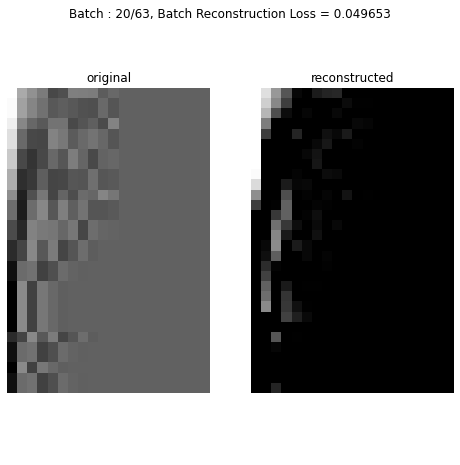

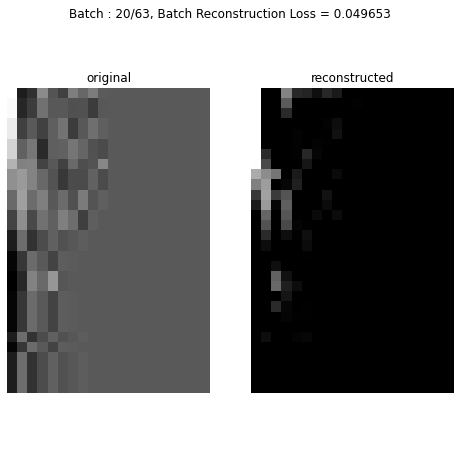

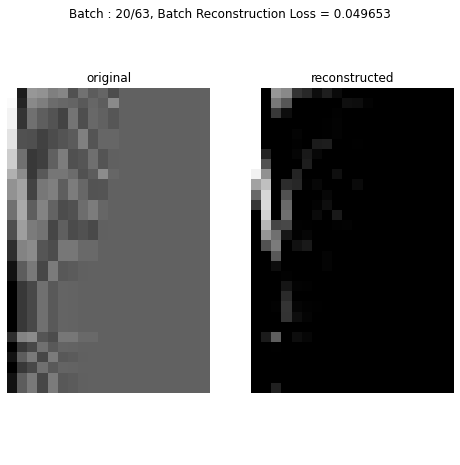

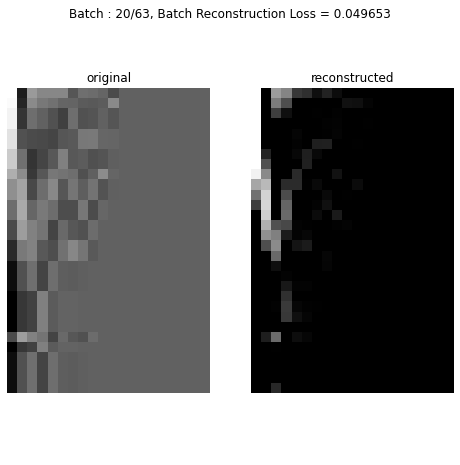

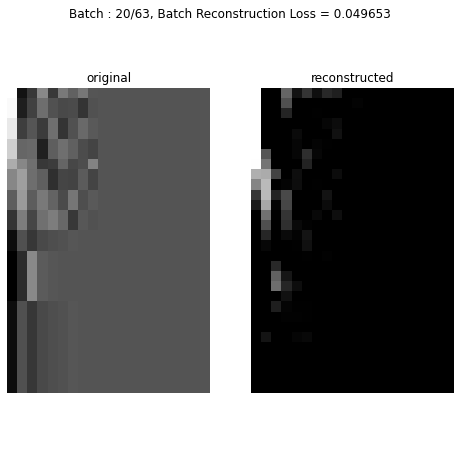

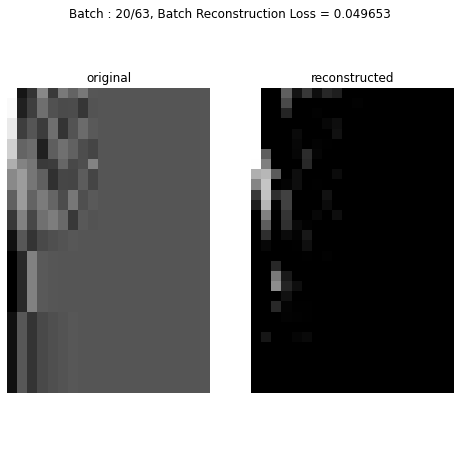

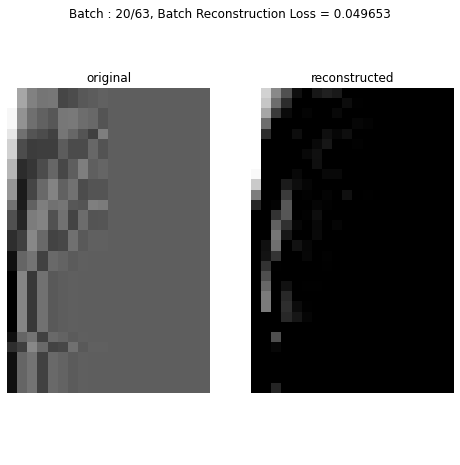

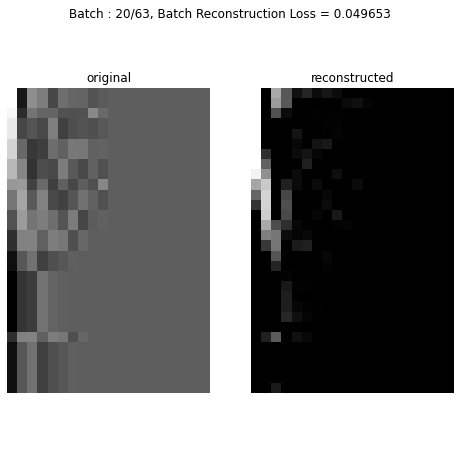

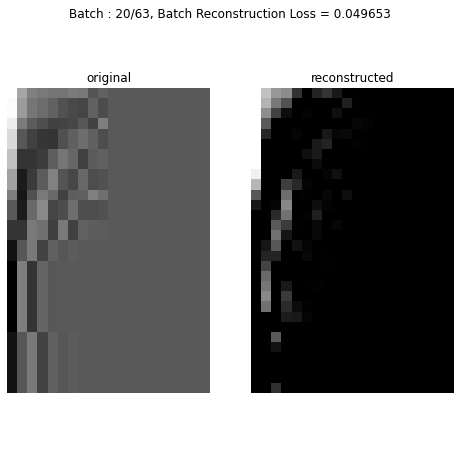

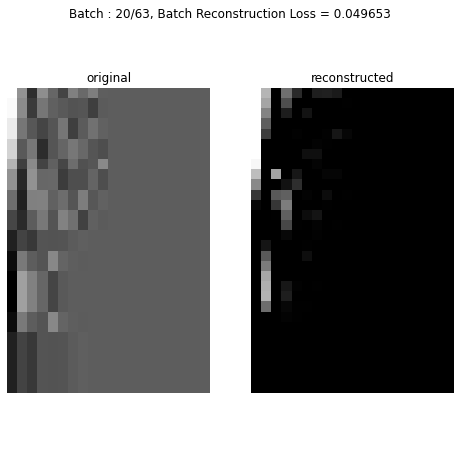

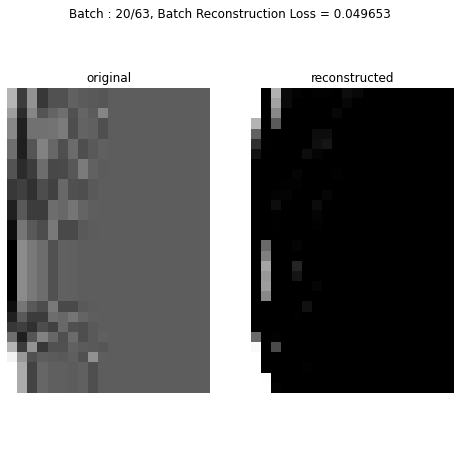

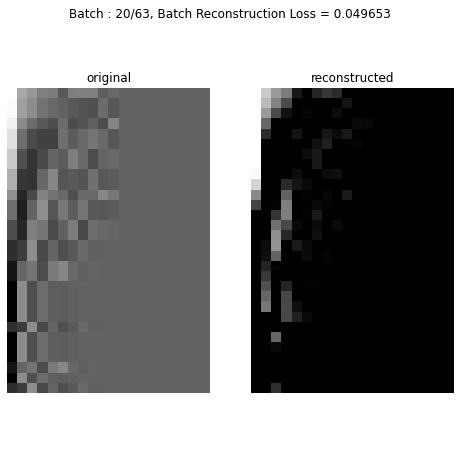

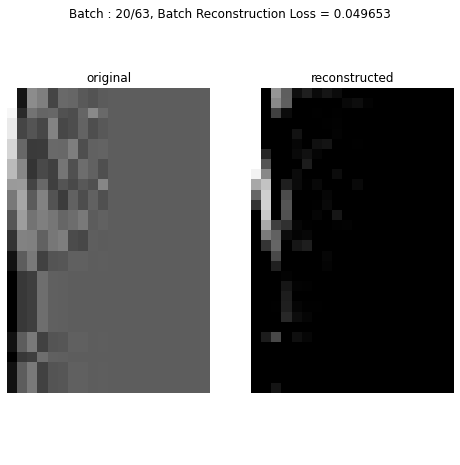

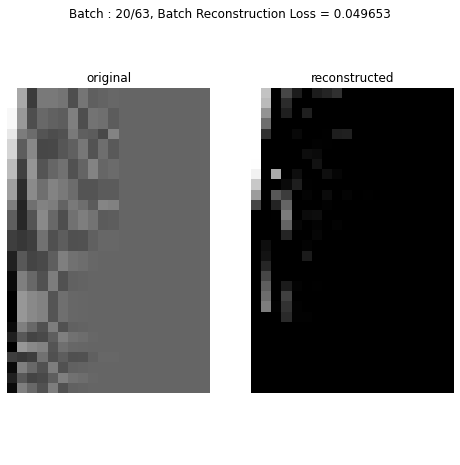

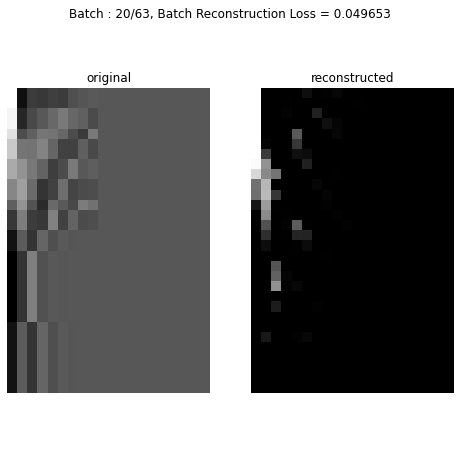

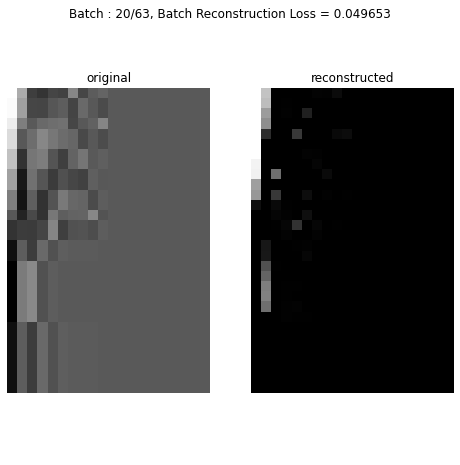

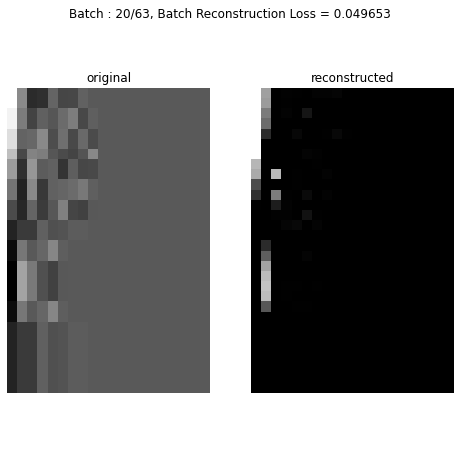

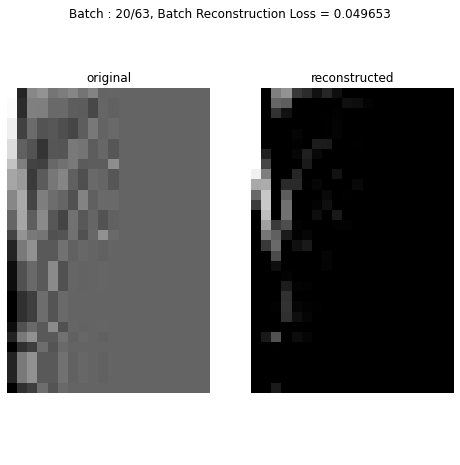

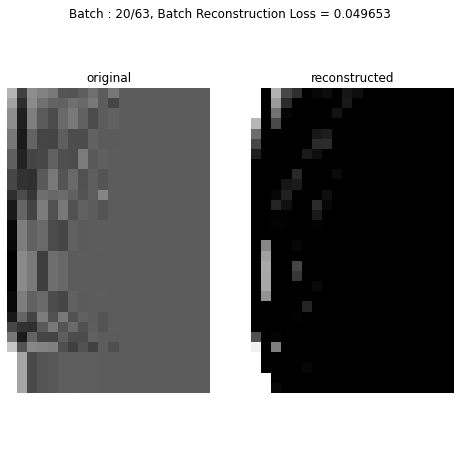

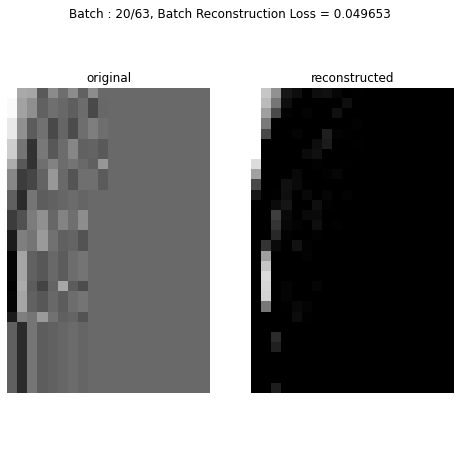

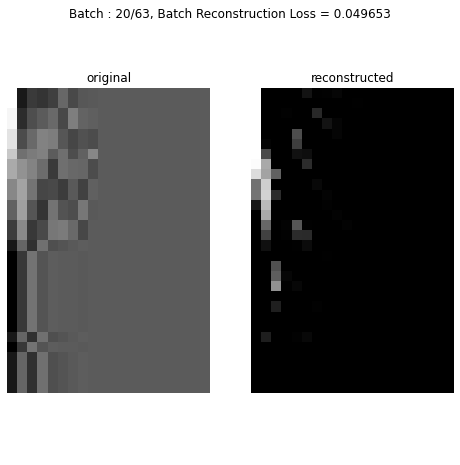

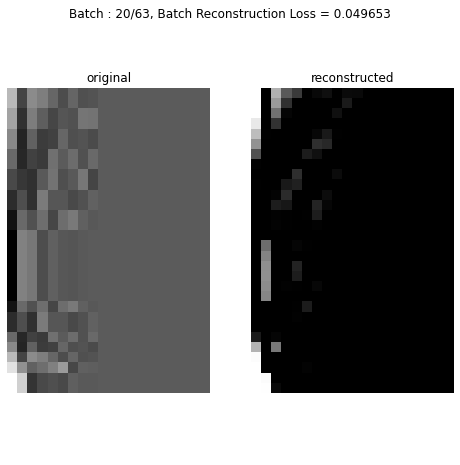

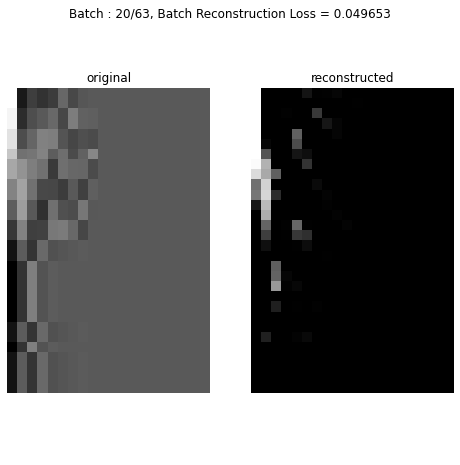

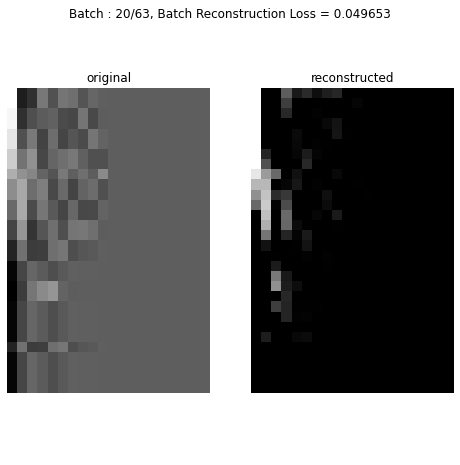

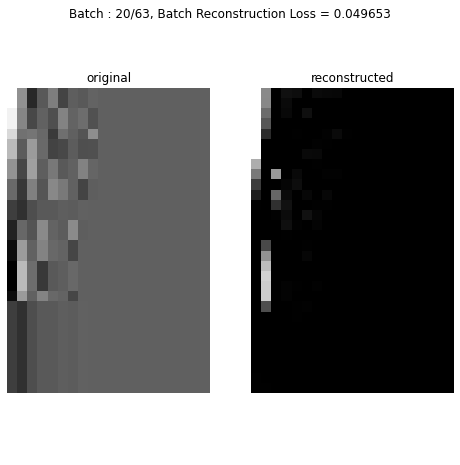

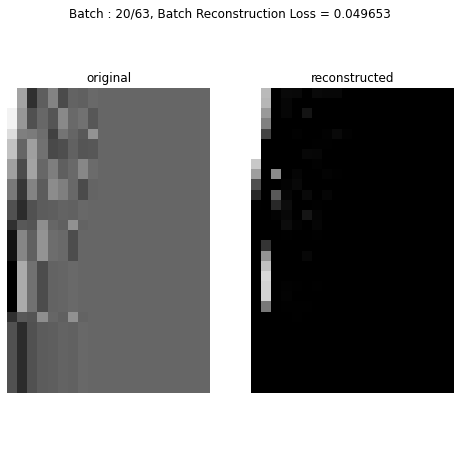

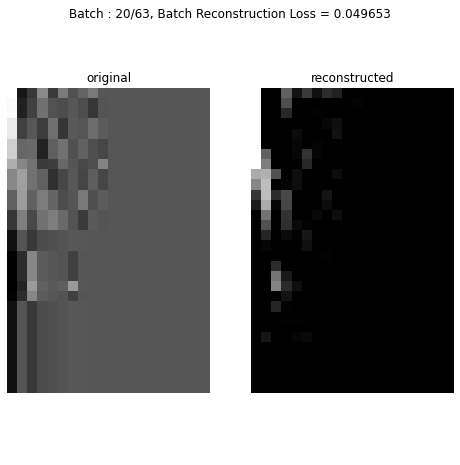

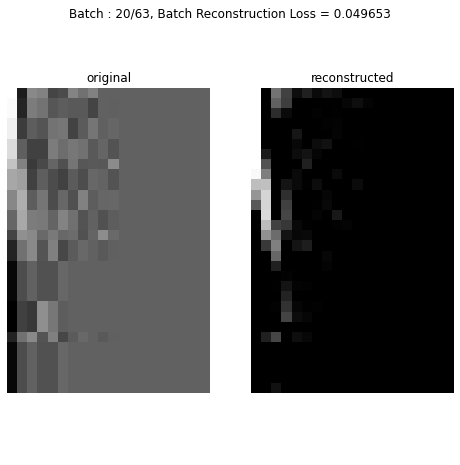

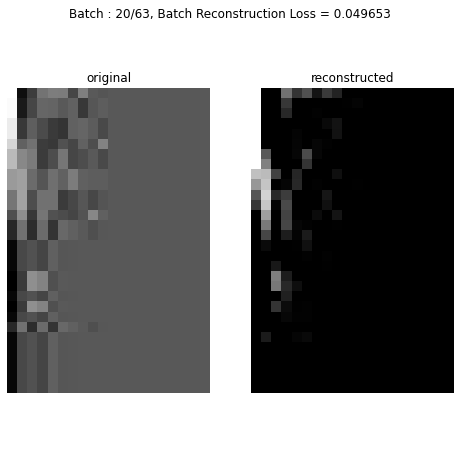

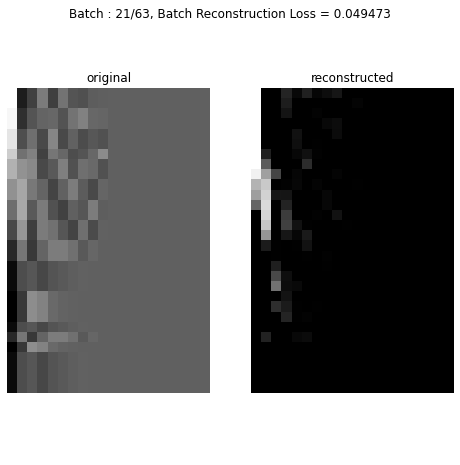

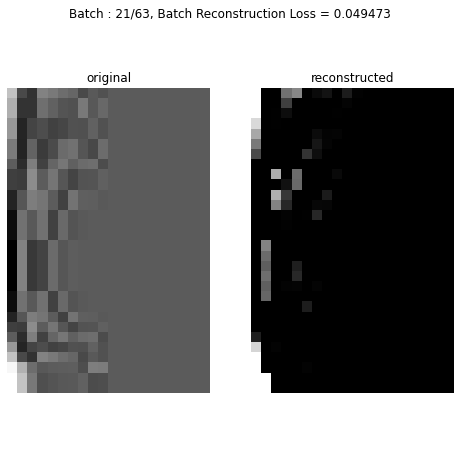

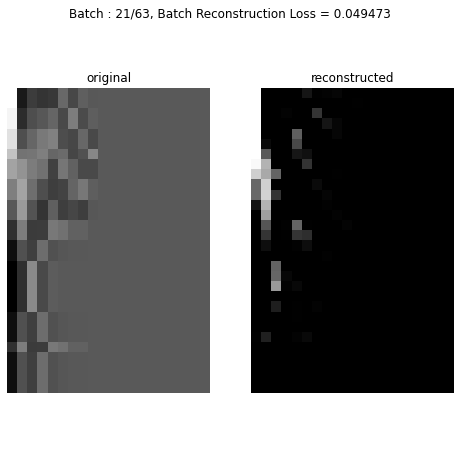

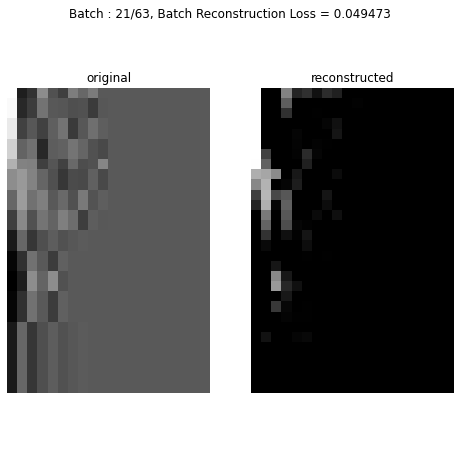

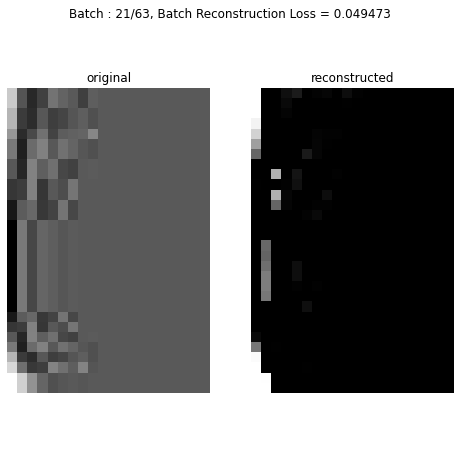

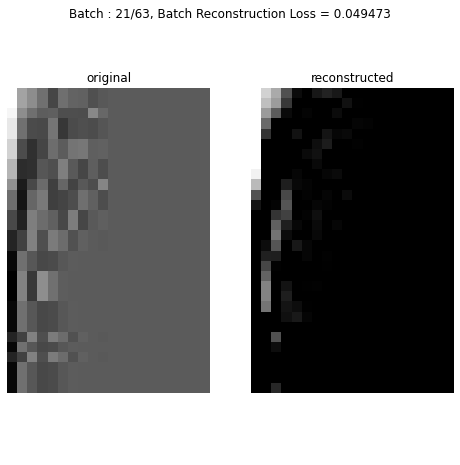

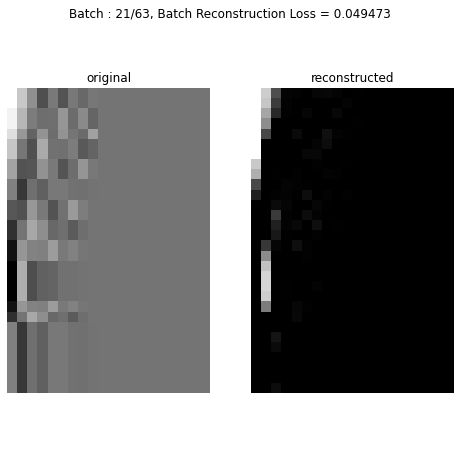

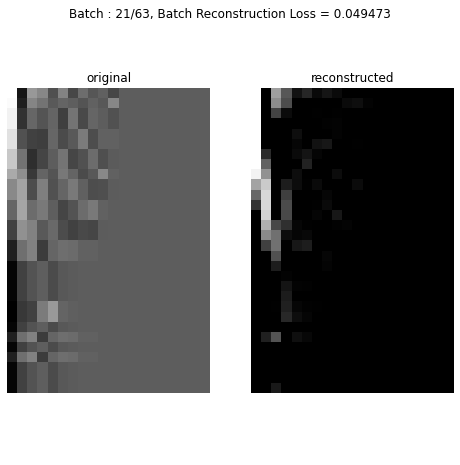

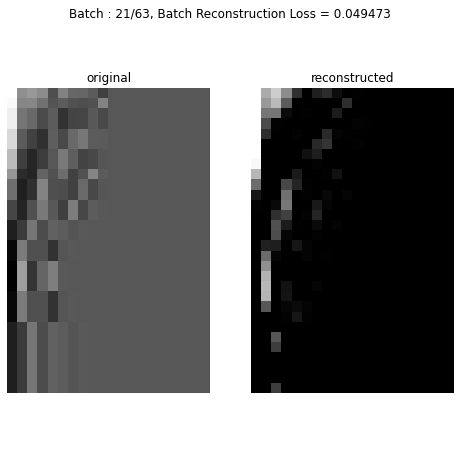

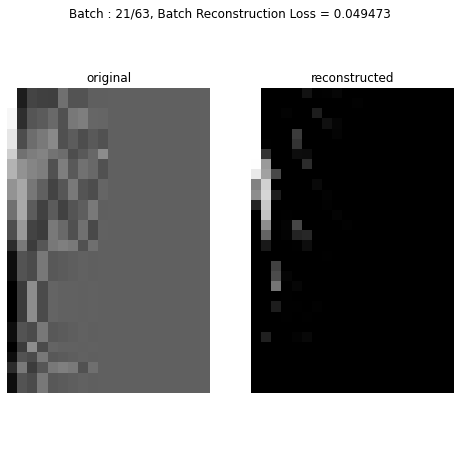

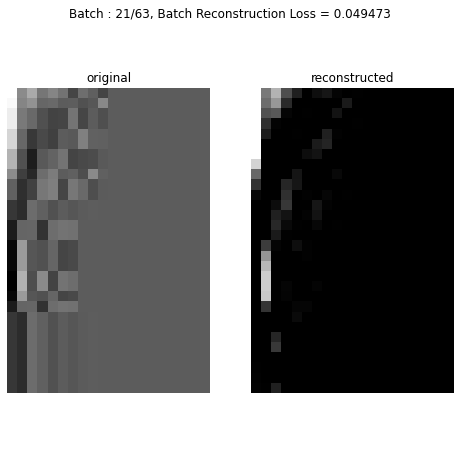

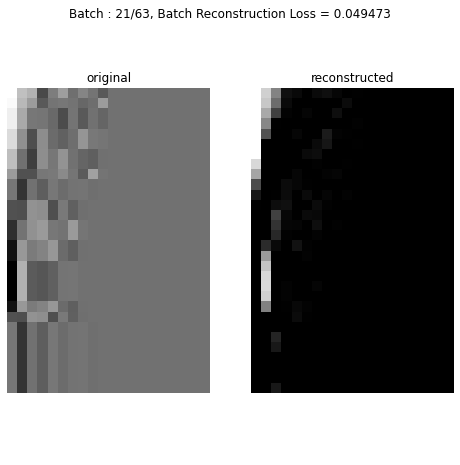

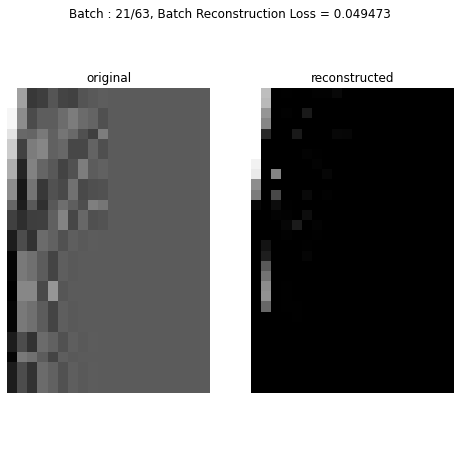

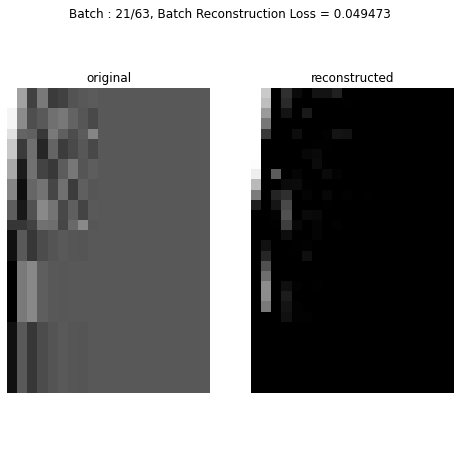

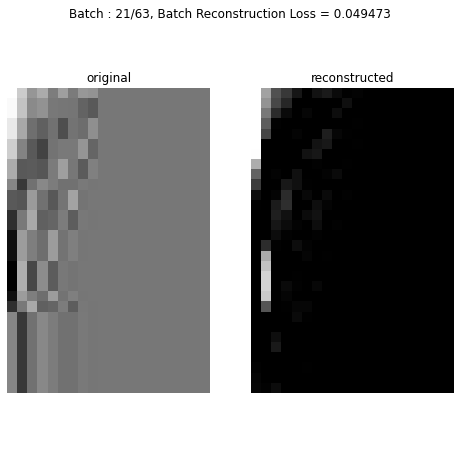

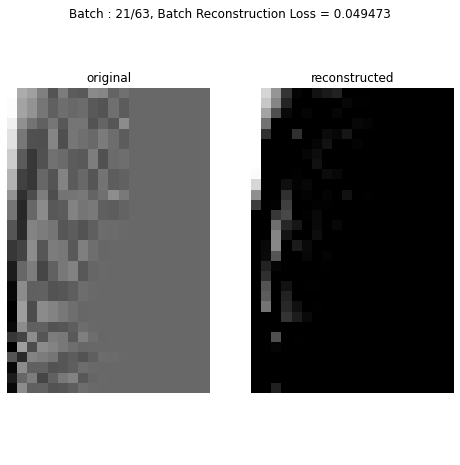

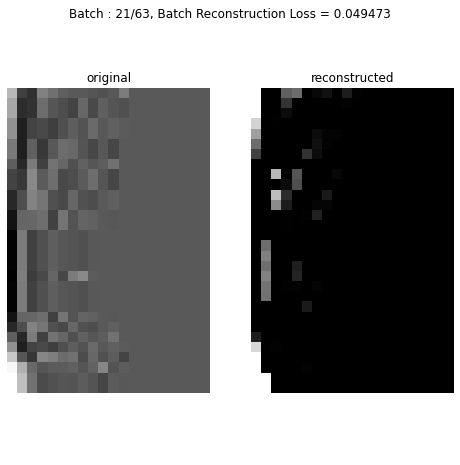

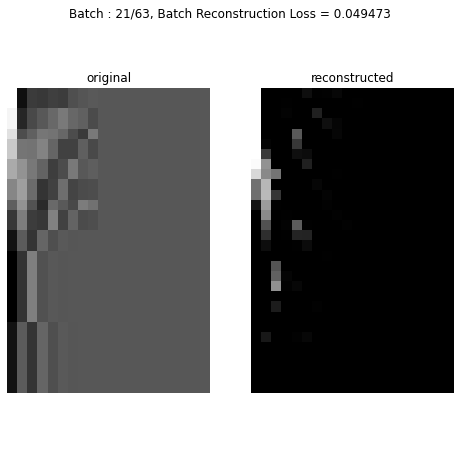

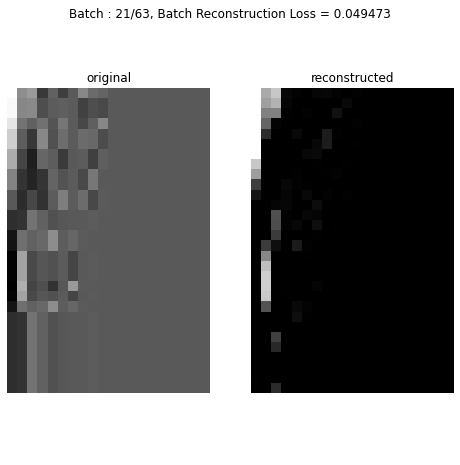

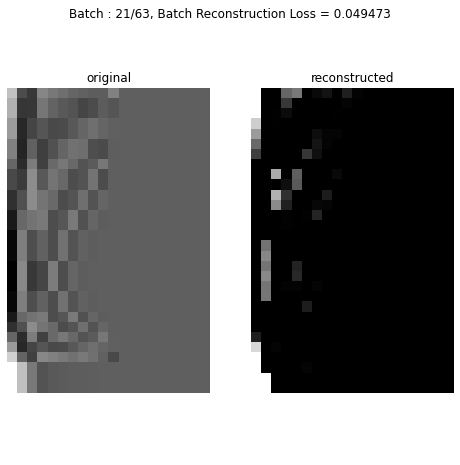

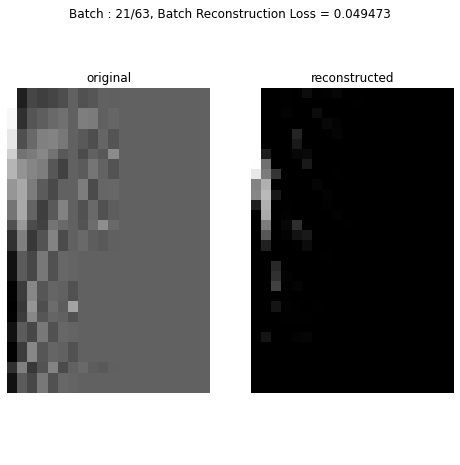

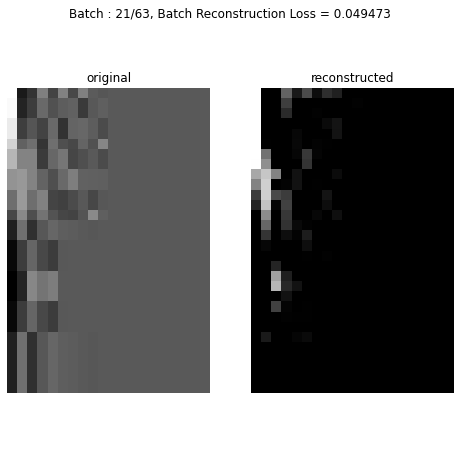

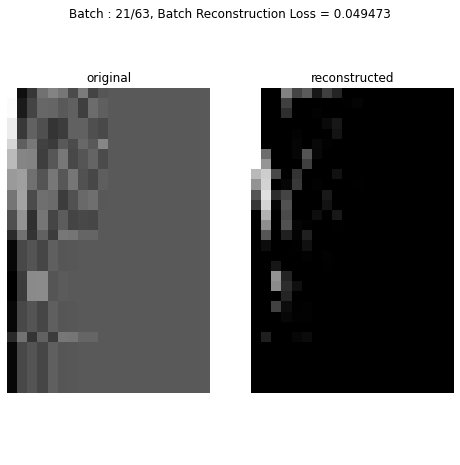

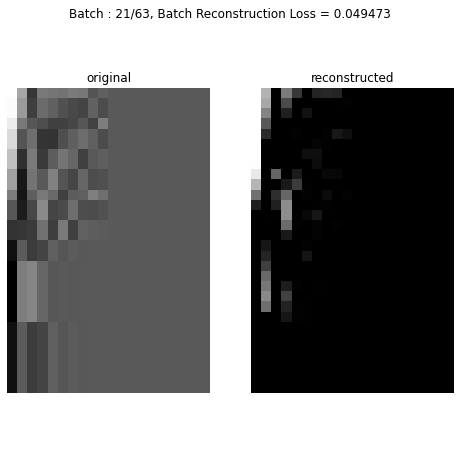

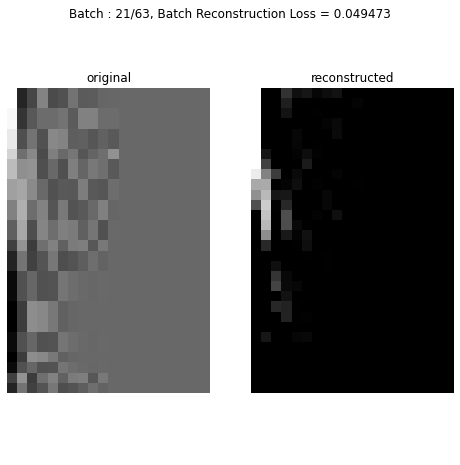

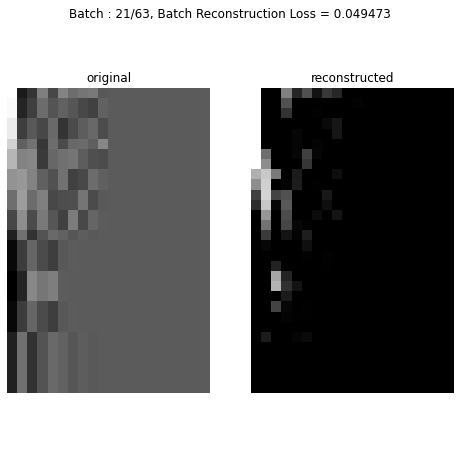

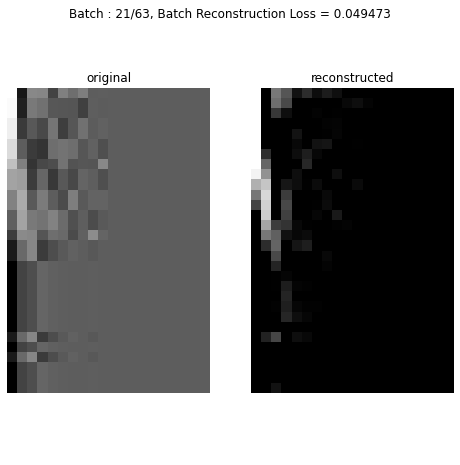

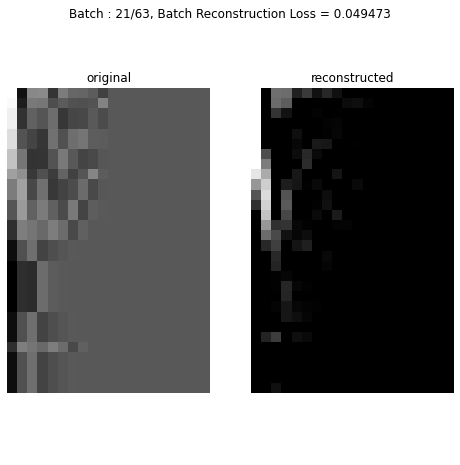

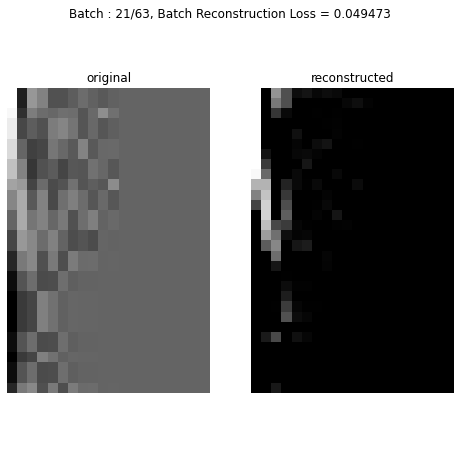

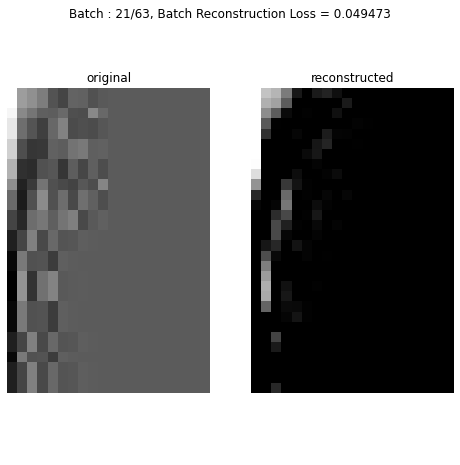

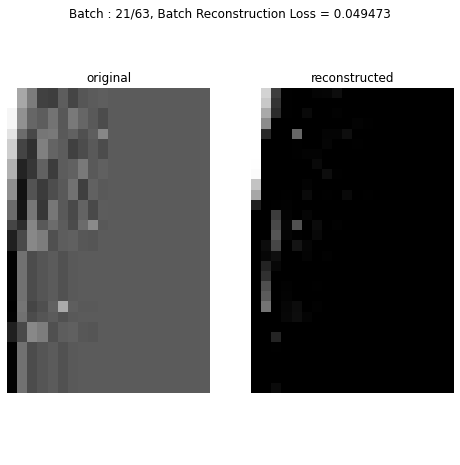

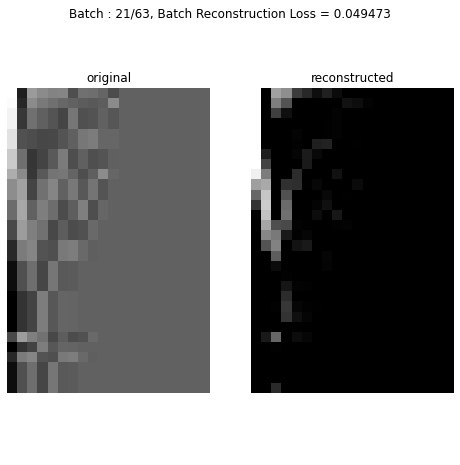

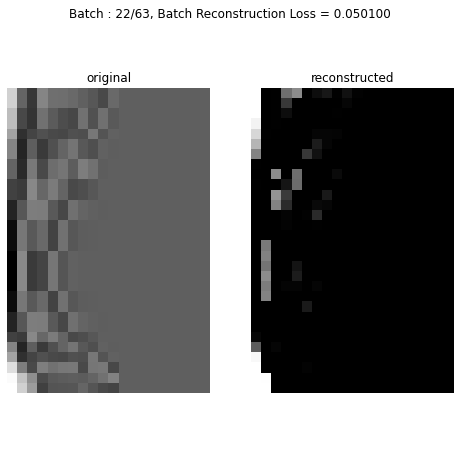

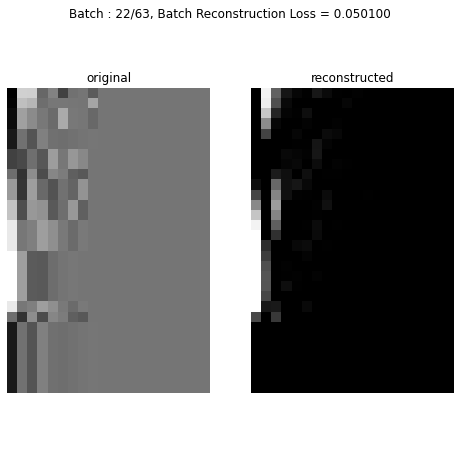

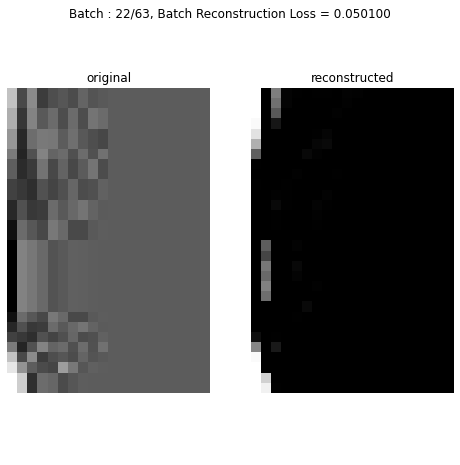

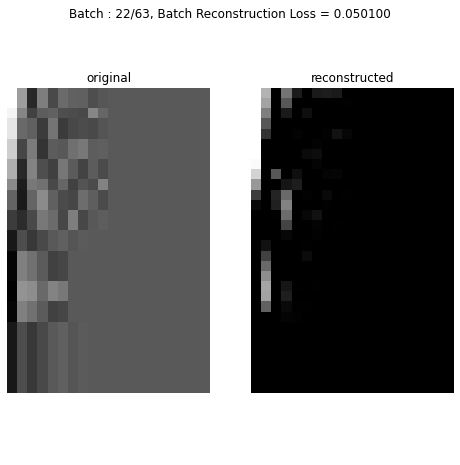

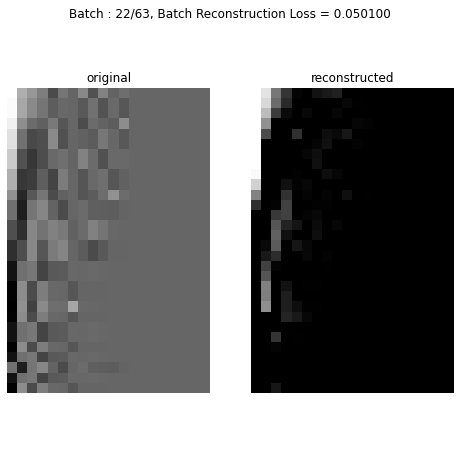

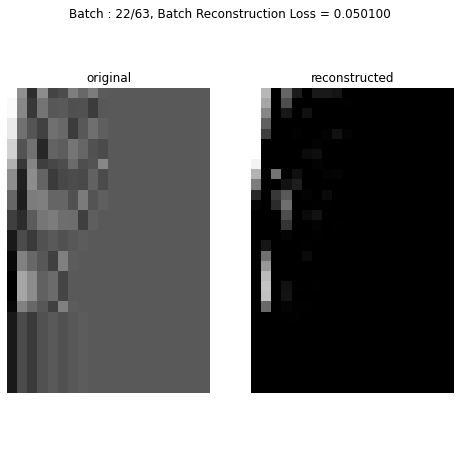

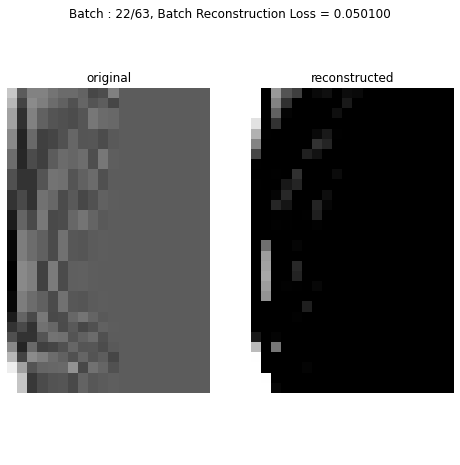

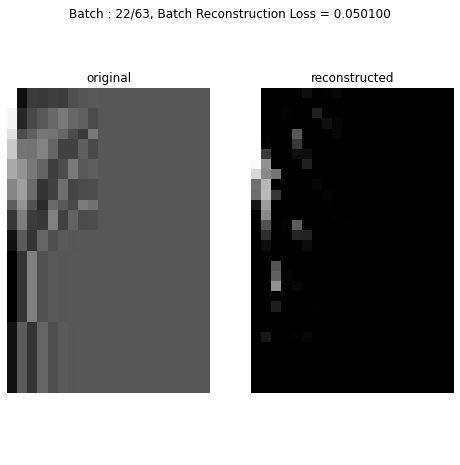

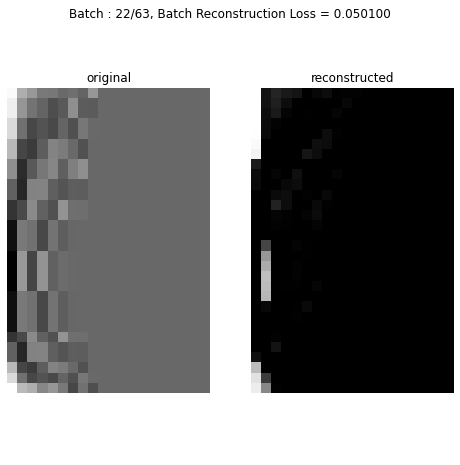

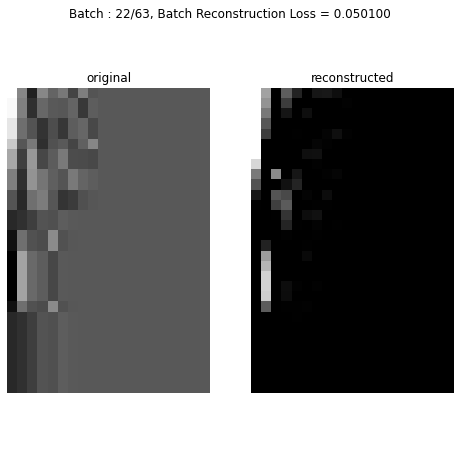

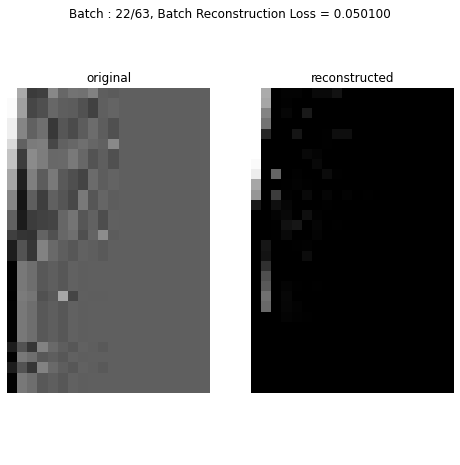

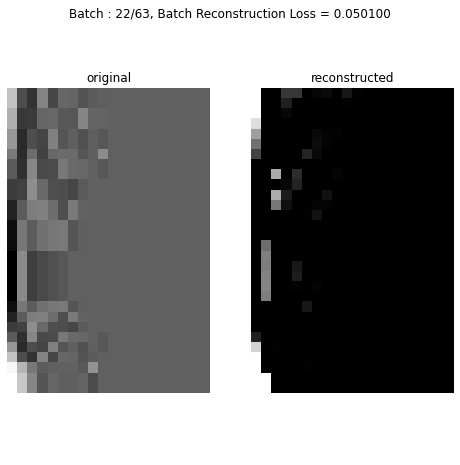

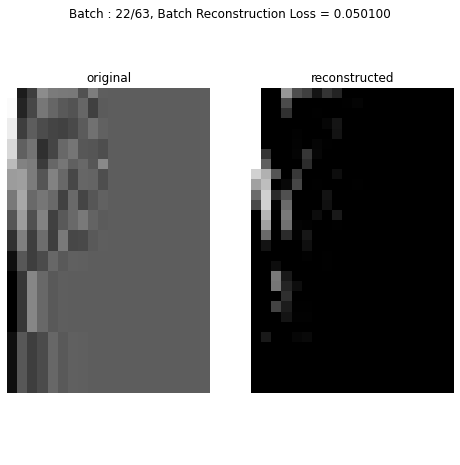

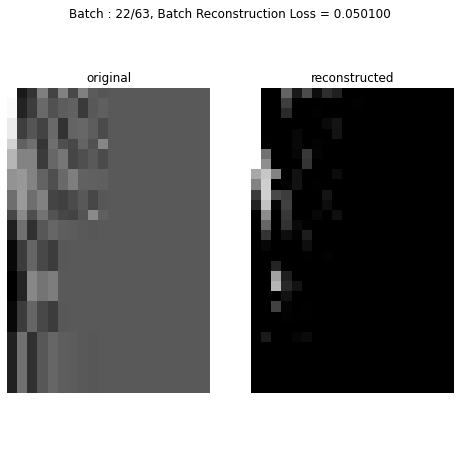

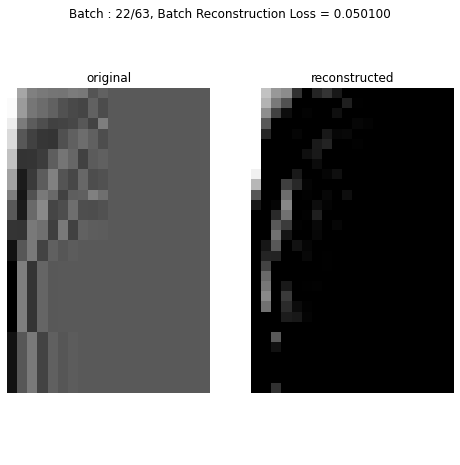

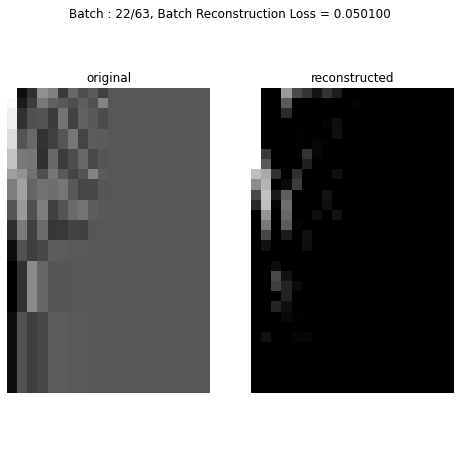

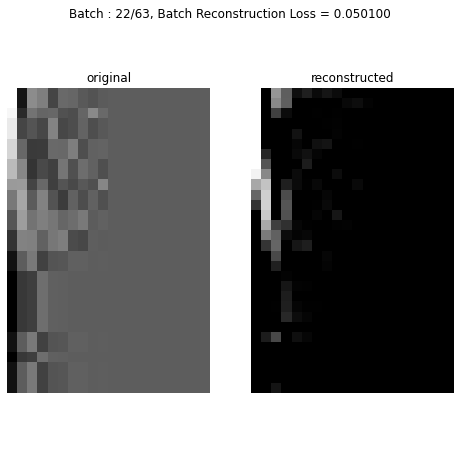

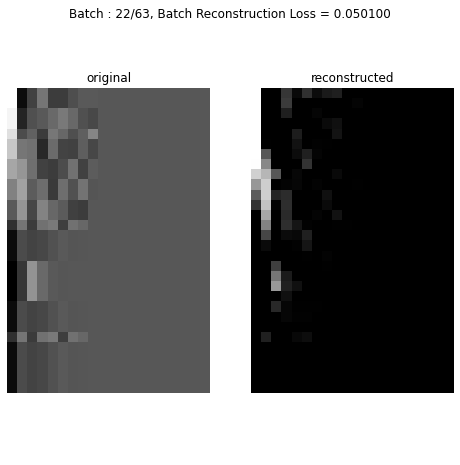

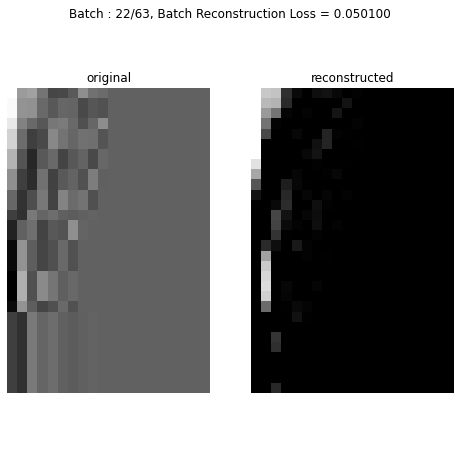

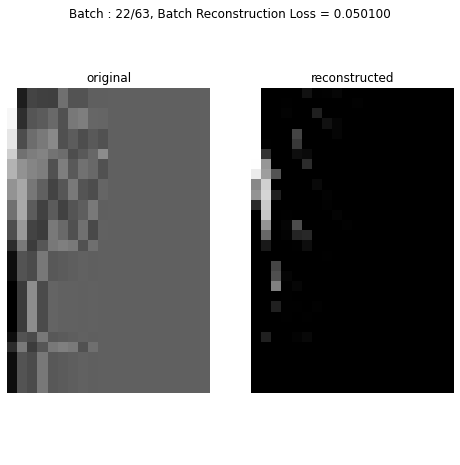

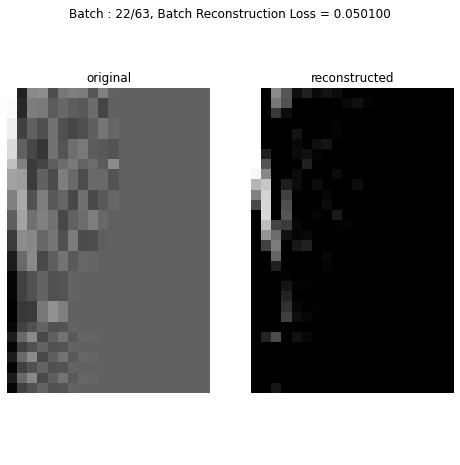

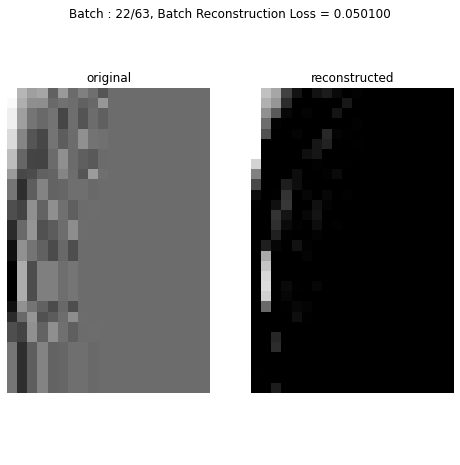

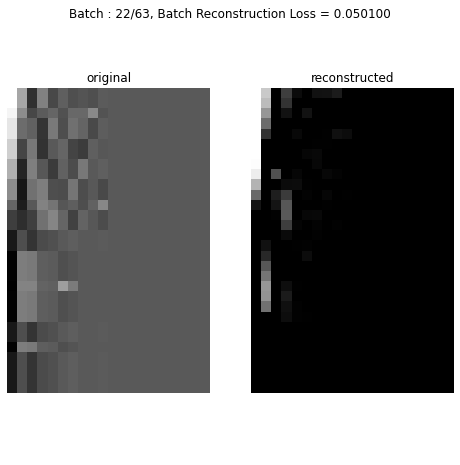

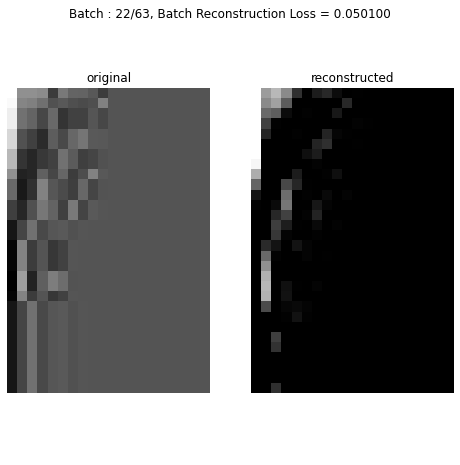

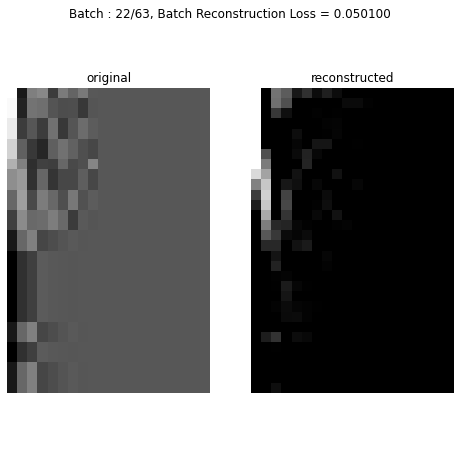

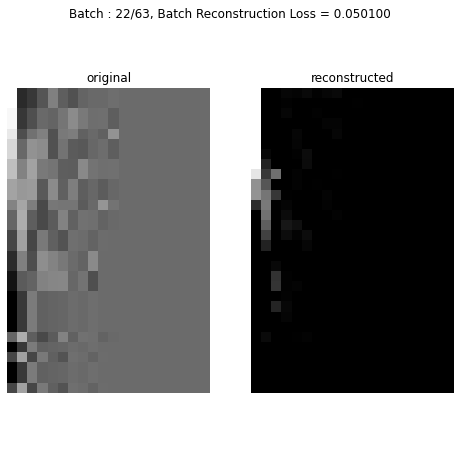

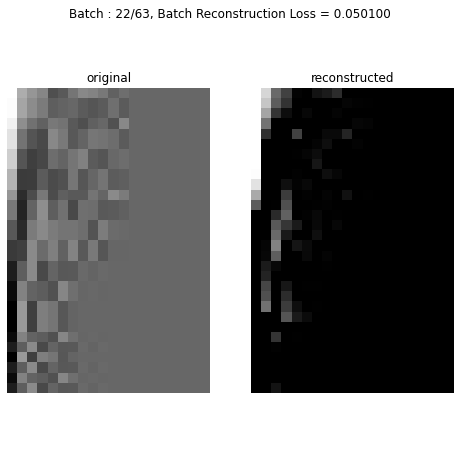

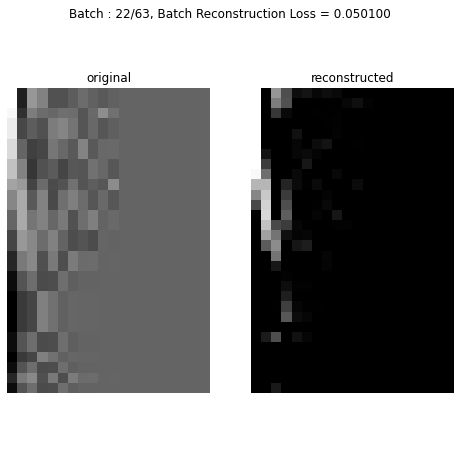

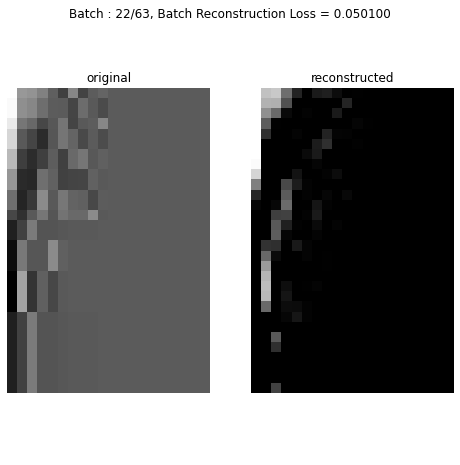

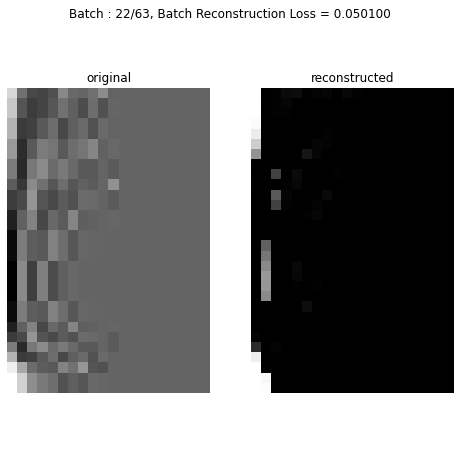

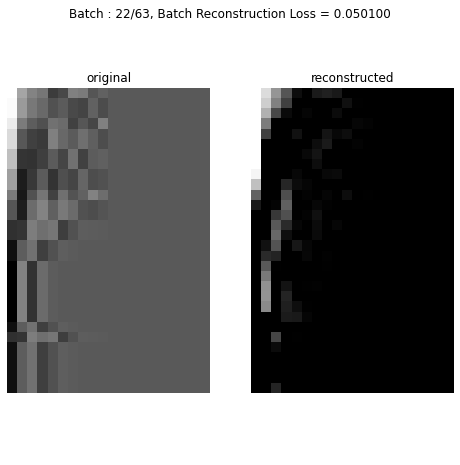

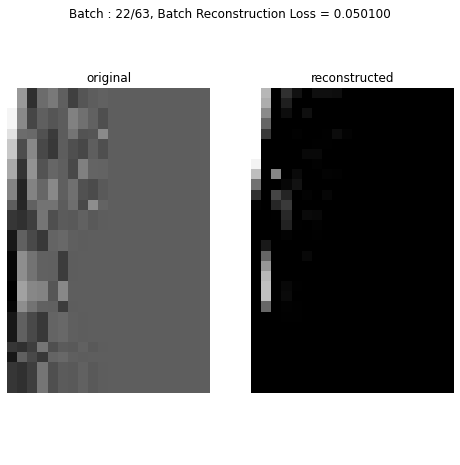

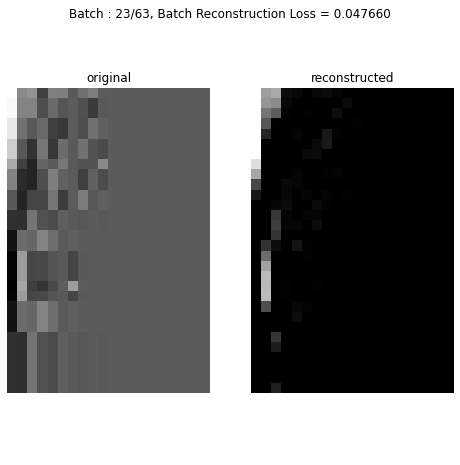

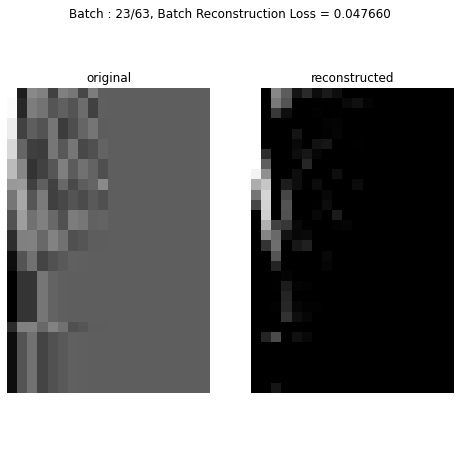

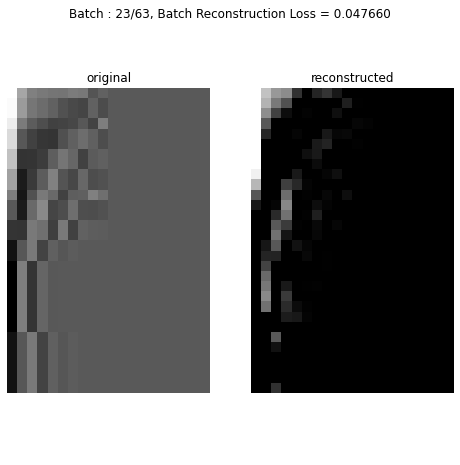

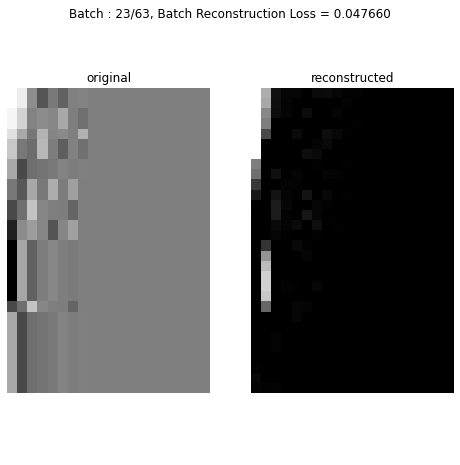

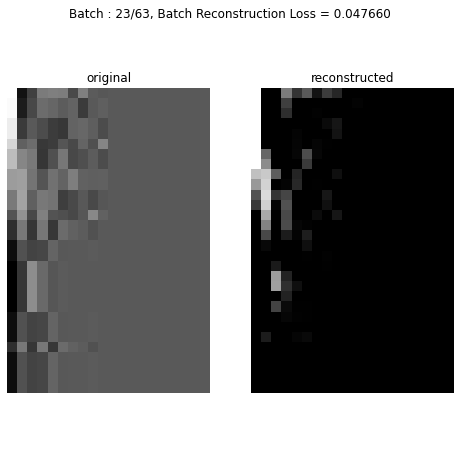

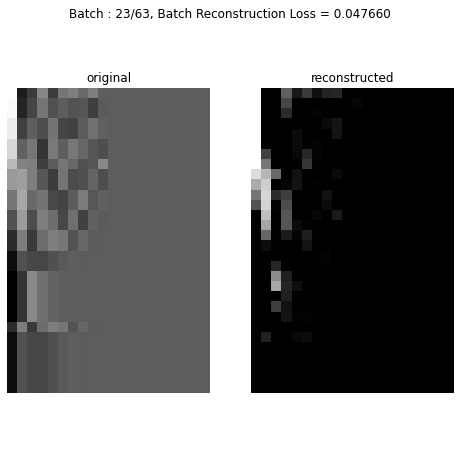

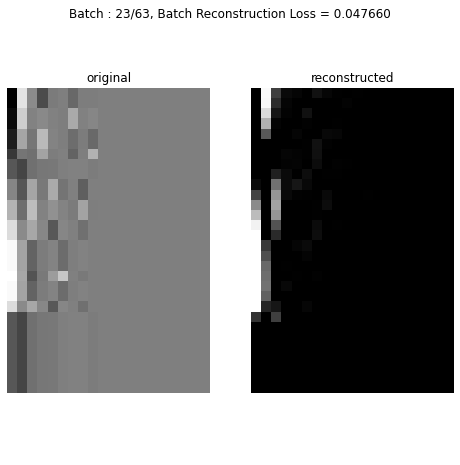

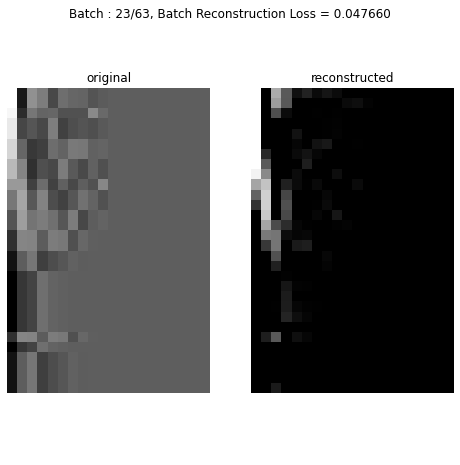

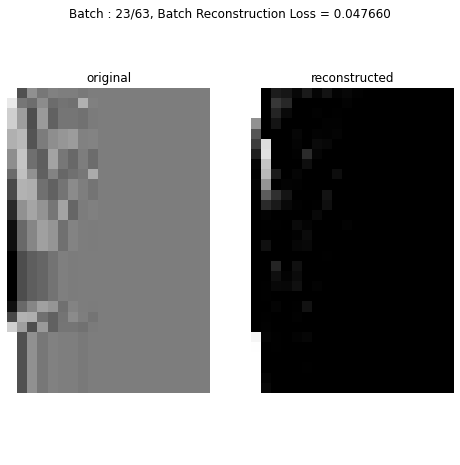

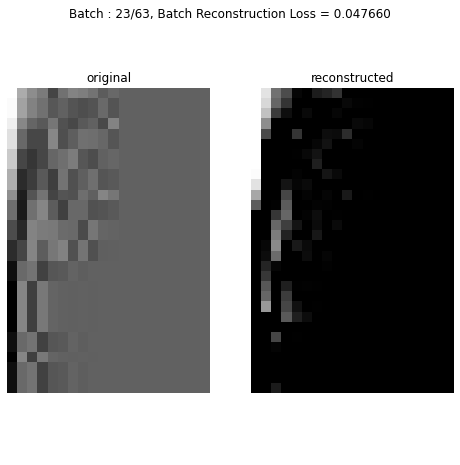

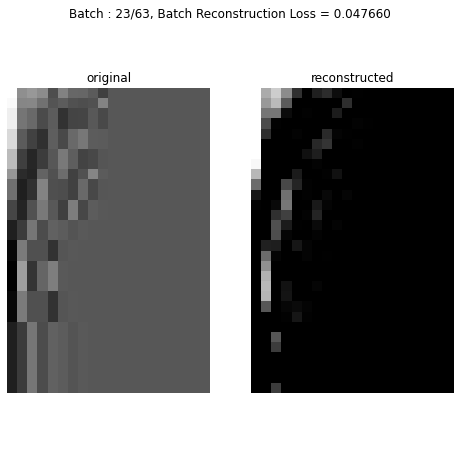

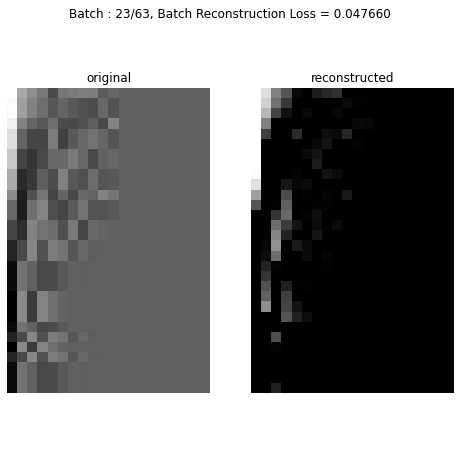

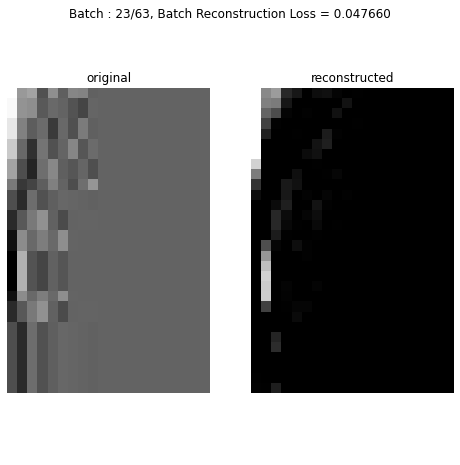

KeyboardInterrupt: 

In [58]:
# Visualization

for i in range(len(recons)):
    loss = test_losses[i]
    batch = batches[i]
    reconstructions = recons[i]
    # Iterate through all examples in ith batch
    for j in range(len(batch)):
        # Reshape original example for plotting
        original = batch[j].reshape(X.shape[1], X.shape[2])
        original = original.cpu()
        # Reshape reconstructed example for plotting
        reconstruction = reconstructions[j].reshape(X.shape[1], X.shape[2])
        reconstruction = reconstruction.cpu()
        
        fig = plt.figure(figsize=(8, 8))
        plt.title("Batch : {}/{}, Batch Reconstruction Loss = {:.6f}".format(i+1, len(recons), loss))
        plt.axis('off')
        # display original
        fig.add_subplot(1, 2, 1)
        plt.imshow(original)
        plt.axis('off')
        plt.title("original")
        plt.gray()
        
        # fig.get_xaxis().set_visible(False)
        # fig.get_yaxis().set_visible(False)

        # display reconstruction
        fig.add_subplot(1, 2, 2)
        plt.imshow(reconstruction)
        plt.axis('off')
        plt.title("reconstructed")
        plt.gray()
        # fig.get_xaxis().set_visible(False)
        # fig.get_yaxis().set_visible(False)
        plt.show()
        
        # w = 10
        # h = 10
        # fig = plt.figure(figsize=(8, 8))
        # columns = 4
        # rows = 5
        # for i in range(1, columns*rows +1):
        #     img = np.random.randint(10, size=(h,w))
        #     fig.add_subplot(rows, columns, i)
        #     plt.imshow(img)
        # plt.show()